# Neural network for h->aa->bbtautau signal/background separation

# Model definition and training

## Packages

In [1]:
import ROOT
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from matplotlib import pyplot
%matplotlib inline

from tensorflow import keras
from keras.models import Model
from keras.layers import Input, Activation, Dense, Dropout
from keras.initializers import glorot_uniform
from keras.utils import plot_model

import kerastuner
from kerastuner import Hyperband

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_curve, auc

import joblib

Welcome to JupyROOT 6.22/06


Using TensorFlow backend.


## Load root files

In [2]:
file_obs18 = ROOT.RDataFrame('mutau_tree', 'root_raw/mt18_raw/data_obs.root')
file_sig18 = ROOT.RDataFrame('mutau_tree', {'root_raw/mt18_raw/ggH_bbtt*.root', 'root_raw/mt18_raw/vbf_bbtt*.root'})
file_ZTT18 = ROOT.RDataFrame('mutau_tree', 'root_raw/mt18_raw/embedded.root')
file_TT18 = ROOT.RDataFrame('mutau_tree', 'root_raw/mt18_raw/TT*.root')

file_obs17 = ROOT.RDataFrame('mutau_tree', 'root_raw/mt17_raw/data_obs.root')
file_sig17 = ROOT.RDataFrame('mutau_tree', {'root_raw/mt17_raw/ggH_bbtt*.root', 'root_raw/mt17_raw/vbf_bbtt*.root'})
file_ZTT17 = ROOT.RDataFrame('mutau_tree', 'root_raw/mt17_raw/embedded.root')
file_TT17 = ROOT.RDataFrame('mutau_tree', 'root_raw/mt17_raw/TT*.root')

file_obs16 = ROOT.RDataFrame('mutau_tree', 'root_raw/mt16_raw/data_obs.root')
file_sig16 = ROOT.RDataFrame('mutau_tree', {'root_raw/mt16_raw/ggH_bbtt*.root', 'root_raw/mt16_raw/vbf_bbtt*.root'})
file_ZTT16 = ROOT.RDataFrame('mutau_tree', 'root_raw/mt16_raw/embedded.root')
file_TT16 = ROOT.RDataFrame('mutau_tree', 'root_raw/mt16_raw/TT*.root')

files18 = [file_obs18, file_sig18, file_ZTT18, file_TT18]
files17 = [file_obs17, file_sig17, file_ZTT17, file_TT17]
files16 = [file_obs16, file_sig16, file_ZTT16, file_TT16]

In [3]:
# 1b events
for i in range(len(files18)):
    files18[i] = files18[i].Filter('bpt_deepflavour_1>20 && bscore_deepflavour_1>0.2770 && bpt_deepflavour_2<0')
    files17[i] = files17[i].Filter('bpt_deepflavour_1>20 && bscore_deepflavour_1>0.3033 && bpt_deepflavour_2<0')
    files16[i] = files16[i].Filter('bpt_deepflavour_1>20 && bscore_deepflavour_1>0.3093 && bpt_deepflavour_2<0')

## Define some input features

In [4]:
# define 4-vectors, invariant masses and etc.
mymu = 'ROOT::Math::PtEtaPhiMVector(pt_1,eta_1,phi_1,m_1)'
mytau = 'ROOT::Math::PtEtaPhiMVector(pt_2,eta_2,phi_2,m_2)'
mymet = 'ROOT::Math::PtEtaPhiMVector(met,0,metphi,0)'
mytt = 'ROOT::Math::PtEtaPhiMVector((mymu+mytau+mymet).Pt(),(mymu+mytau+mymet).Eta(),(mymu+mytau+mymet).Phi(),m_sv)'
myb1 = 'ROOT::Math::PtEtaPhiMVector(bpt_deepflavour_1,beta_deepflavour_1,bphi_deepflavour_1,bm_deepflavour_1)'
m_btt = '(mytt+myb1).M()'
m_b1mu = '(mymu+myb1).M()'
m_b1tau = '(mytau+myb1).M()'
dR_tt = 'ROOT::Math::VectorUtil::DeltaR(mymu,mytau)'
dR_b1mu = 'ROOT::Math::VectorUtil::DeltaR(mymu,myb1)'
dR_b1tau = 'ROOT::Math::VectorUtil::DeltaR(mytau,myb1)'
dR_b1tt = 'ROOT::Math::VectorUtil::DeltaR(myb1,mytt)'
tt_pt = 'mytt.Pt()'
tt_eta = 'mytt.Eta()'

# define transverse masses mT and D_zeta
mT_mu = 'sqrt(pow(mymu.Pt()+mymet.Pt(),2)-pow(mymu.Px()+mymet.Px(),2)-pow(mymu.Py()+mymet.Py(),2))'
mT_tau = 'sqrt(pow(mytau.Pt()+mymet.Pt(),2)-pow(mytau.Px()+mymet.Px(),2)-pow(mytau.Py()+mymet.Py(),2))'
mT_b1 = 'sqrt(pow(myb1.Pt()+mymet.Pt(),2)-pow(myb1.Px()+mymet.Px(),2)-pow(myb1.Py()+mymet.Py(),2))'
norm_zeta = 'sqrt(pow(mymu.Px()/mymu.Pt()+mytau.Px()/mytau.Pt(),2)+pow(mymu.Py()/mymu.Pt()+mytau.Py()/mytau.Pt(),2))'
x_zeta = '(mymu.Px()/mymu.Pt()+mytau.Px()/mytau.Pt())/norm_zeta'
y_zeta = '(mymu.Py()/mymu.Pt()+mytau.Py()/mytau.Pt())/norm_zeta'
p_zeta_mis = 'mymet.Px()*x_zeta+mymet.Py()*y_zeta'
pzeta_vis = '(mymu.Px()+mytau.Px())*x_zeta+(mymu.Py()+mytau.Py())*y_zeta'
Dzeta = 'p_zeta_mis-0.85*pzeta_vis'

# add defined variables to dataframe
for i in range(len(files18)):
    files18[i] = files18[i].Define('mymu', mymu)\
    .Define('mytau', mytau)\
    .Define('mymet', mymet)\
    .Define('mytt', mytt)\
    .Define('myb1', myb1)\
    .Define('m_btt', m_btt)\
    .Define('m_b1mu', m_b1mu)\
    .Define('m_b1tau', m_b1tau)\
    .Define('dR_tt', dR_tt)\
    .Define('dR_b1mu', dR_b1mu)\
    .Define('dR_b1tau', dR_b1tau)\
    .Define('dR_b1tt', dR_b1tt)\
    .Define('tt_pt', tt_pt)\
    .Define('tt_eta', tt_eta)\
    .Define('mT_mu', mT_mu)\
    .Define('mT_tau', mT_tau)\
    .Define('mT_b1', mT_b1)\
    .Define('norm_zeta', norm_zeta)\
    .Define('x_zeta', x_zeta)\
    .Define('y_zeta', y_zeta)\
    .Define('p_zeta_mis', p_zeta_mis)\
    .Define('pzeta_vis', pzeta_vis)\
    .Define('Dzeta', Dzeta)
    
    files17[i] = files17[i].Define('mymu', mymu)\
    .Define('mytau', mytau)\
    .Define('mymet', mymet)\
    .Define('mytt', mytt)\
    .Define('myb1', myb1)\
    .Define('m_btt', m_btt)\
    .Define('m_b1mu', m_b1mu)\
    .Define('m_b1tau', m_b1tau)\
    .Define('dR_tt', dR_tt)\
    .Define('dR_b1mu', dR_b1mu)\
    .Define('dR_b1tau', dR_b1tau)\
    .Define('dR_b1tt', dR_b1tt)\
    .Define('tt_pt', tt_pt)\
    .Define('tt_eta', tt_eta)\
    .Define('mT_mu', mT_mu)\
    .Define('mT_tau', mT_tau)\
    .Define('mT_b1', mT_b1)\
    .Define('norm_zeta', norm_zeta)\
    .Define('x_zeta', x_zeta)\
    .Define('y_zeta', y_zeta)\
    .Define('p_zeta_mis', p_zeta_mis)\
    .Define('pzeta_vis', pzeta_vis)\
    .Define('Dzeta', Dzeta)
    
    files16[i] = files16[i].Define('mymu', mymu)\
    .Define('mytau', mytau)\
    .Define('mymet', mymet)\
    .Define('mytt', mytt)\
    .Define('myb1', myb1)\
    .Define('m_btt', m_btt)\
    .Define('m_b1mu', m_b1mu)\
    .Define('m_b1tau', m_b1tau)\
    .Define('dR_tt', dR_tt)\
    .Define('dR_b1mu', dR_b1mu)\
    .Define('dR_b1tau', dR_b1tau)\
    .Define('dR_b1tt', dR_b1tt)\
    .Define('tt_pt', tt_pt)\
    .Define('tt_eta', tt_eta)\
    .Define('mT_mu', mT_mu)\
    .Define('mT_tau', mT_tau)\
    .Define('mT_b1', mT_b1)\
    .Define('norm_zeta', norm_zeta)\
    .Define('x_zeta', x_zeta)\
    .Define('y_zeta', y_zeta)\
    .Define('p_zeta_mis', p_zeta_mis)\
    .Define('pzeta_vis', pzeta_vis)\
    .Define('Dzeta', Dzeta)

## Apply baseline selection cuts

In [5]:
######################## 2 0 1 8 ##########################
# 2018 mu+tau trigger requirements
trigger24OR27_18 = '((passMu24 && matchMu24_1 && filterMu24_1 && pt_1>25) or (passMu27 && matchMu27_1 && filterMu27_1 && pt_1>25))'#keep 25 not 28
trigger2027_18 = '(passMu20Tau27 && matchMu20Tau27_1 && filterMu20Tau27_1 && matchMu20Tau27_2 && filterMu20Tau27_2 && pt_1>21 && pt_1<25 && pt_2>32 && fabs(eta_2)<2.1)'
trigger2027HPS_18 = '(passMu20HPSTau27 && matchMu20HPSTau27_1 && filterMu20HPSTau27_1 && matchMu20HPSTau27_2 && filterMu20HPSTau27_2 && pt_1>21 && pt_1<25 && pt_2>32 && fabs(eta_2)<2.1)'
trigger24OR27_emb_18 = '((passMu24 && matchMu24_1 && pt_1>25) or (passMu27 && matchMu27_1 && pt_1>25))'#keep 25 not 28
trigger2027HPS_emb_18 = '(matchEmbFilter_Mu20Tau27_1 && matchEmbFilter_Mu20HPSTau27_2 && pt_1>21 && pt_1<25 && pt_2>32 && fabs(eta_2)<2.1)'

trigger_mc_18 = trigger24OR27_18 + str(' or ') + trigger2027HPS_18
trigger_obs_1_18 = trigger2027_18 + str(' or ') + trigger24OR27_18
trigger_obs_2_18 = trigger2027HPS_18 + str(' or ') + trigger24OR27_18
trigger_emb_18 = trigger24OR27_emb_18 + str(' or ') + trigger2027HPS_emb_18

for i in range(len(files18)):
    files18[i] = files18[i].Filter('Flag_goodVertices==0')\
    .Filter('Flag_globalSuperTightHalo2016Filter==0')\
    .Filter('Flag_HBHENoiseFilter==0')\
    .Filter('Flag_HBHENoiseIsoFilter==0')\
    .Filter('Flag_EcalDeadCellTriggerPrimitiveFilter==0')\
    .Filter('Flag_BadPFMuonFilter==0')\
    .Filter('Flag_ecalBadCalibReducedMINIAODFilter==0')\
    .Filter('pt_2>20')\
    .Filter('fabs(eta_1)<2.1 && fabs(eta_2)<2.3')\
    .Filter('iso_1<0.15')\
    .Filter('byVLooseDeepVSe_2 && byTightDeepVSmu_2')\
    .Filter('dR_tt>0.4')

files18[0] = files18[0].Filter('Flag_eeBadScFilter==0')
files18[2] = files18[2].Filter('Flag_eeBadScFilter==0')

files18[3] = files18[3].Filter('gen_match_2!=6').Filter('((gen_match_1<3 or gen_match_1==6) or (gen_match_1==4 && gen_match_2<3))')

files18[1] = files18[1].Filter('gen_match_1==4 && gen_match_2==5')#reconstructed taus are gen taus
files18[1] = files18[1].Filter('m_btt<200')#reject long tail (mostly wrongly reco b jet)

files18[2] = files18[2].Filter('gen_match_2!=6').Filter('genweight<=1.0')

# triggers
obs1_18 = files18[0].Filter('run<317509').Filter(trigger_obs_1_18)
obs2_18 = files18[0].Filter('run>=317509').Filter(trigger_obs_2_18)
files18[1] = files18[1].Filter(trigger_mc_18)
files18[2] = files18[2].Filter(trigger_emb_18)
files18[3] = files18[3].Filter(trigger_mc_18)

# QCD region
qcd1_18 = obs1_18.Filter('q_1*q_2>0').Filter('byMediumDeepVSjet_2==0')
qcd2_18 = obs2_18.Filter('q_1*q_2>0').Filter('byMediumDeepVSjet_2==0')

# signal region
for i in range(1,len(files18)):
    files18[i] = files18[i].Filter('q_1*q_2<0')\
    .Filter('byMediumDeepVSjet_2')

######################## 2 0 1 7 ##########################
# 2017 mu+tau trigger requirements
trigger24OR27_17 = '((passMu24 && matchMu24_1 && filterMu24_1 && pt_1>25) or (passMu27 && matchMu27_1 && filterMu27_1 && pt_1>25))'#keep 25 not 28
trigger2027_17 = '(passMu20Tau27 && matchMu20Tau27_1 && filterMu20Tau27_1 && matchMu20Tau27_2 && filterMu20Tau27_2 && pt_1>21 && pt_1<25 && pt_2>32 && fabs(eta_2)<2.1)'
trigger24OR27_emb_17 = '((passMu24 && matchMu24_1 && pt_1>25) or (passMu27 && matchMu27_1 && pt_1>25))'#keep 25 not 28
trigger2027_emb_17 = '(matchEmbFilter_Mu20Tau27_2017_1 && matchEmbFilter_Mu20Tau27_2 && pt_1>21 && pt_1<25 && pt_2>32 && fabs(eta_2)<2.1)'

trigger_mc_obs_17 = trigger24OR27_17 + str(' or ') + trigger2027_17
trigger_emb_17 = trigger24OR27_emb_17 + str(' or ') + trigger2027_emb_17

for i in range(len(files17)):
    files17[i] = files17[i].Filter('Flag_goodVertices==0')\
    .Filter('Flag_globalSuperTightHalo2016Filter==0')\
    .Filter('Flag_HBHENoiseFilter==0')\
    .Filter('Flag_HBHENoiseIsoFilter==0')\
    .Filter('Flag_EcalDeadCellTriggerPrimitiveFilter==0')\
    .Filter('Flag_BadPFMuonFilter==0')\
    .Filter('Flag_ecalBadCalibReducedMINIAODFilter==0')\
    .Filter('pt_2>20')\
    .Filter('fabs(eta_1)<2.1 && fabs(eta_2)<2.3')\
    .Filter('iso_1<0.15')\
    .Filter('byVLooseDeepVSe_2 && byTightDeepVSmu_2')\
    .Filter('dR_tt>0.4')

files17[0] = files17[0].Filter('Flag_eeBadScFilter==0')
files17[2] = files17[2].Filter('Flag_eeBadScFilter==0')

files17[3] = files17[3].Filter('gen_match_2!=6').Filter('((gen_match_1<3 or gen_match_1==6) or (gen_match_1==4 && gen_match_2<3))')

files17[1] = files17[1].Filter('gen_match_1==4 && gen_match_2==5')#reconstructed taus are gen taus
files17[1] = files17[1].Filter('m_btt<200')#reject long tail (mostly wrongly reco b jet)

files17[2] = files17[2].Filter('gen_match_2!=6').Filter('genweight<=1.0')

# triggers
files17[0] = files17[0].Filter(trigger_mc_obs_17)
files17[1] = files17[1].Filter(trigger_mc_obs_17)
files17[2] = files17[2].Filter(trigger_emb_17)
files17[3] = files17[3].Filter(trigger_mc_obs_17)

# QCD region
qcd_17 = files17[0].Filter('q_1*q_2>0').Filter('byMediumDeepVSjet_2==0')

# signal region
for i in range(1,len(files17)):
    files17[i] = files17[i].Filter('q_1*q_2<0')\
    .Filter('byMediumDeepVSjet_2')

######################## 2 0 1 6 ##########################
# 2016 mu+tau trigger requirements
trigger22_16 = '((passMu22eta2p1 && matchMu22eta2p1_1 && filterMu22eta2p1_1 && pt_1>23) or (passTkMu22eta2p1 && matchTkMu22eta2p1_1 && filterTkMu22eta2p1_1 && pt_1>23) or (passMu22 && matchMu22_1 && filterMu22_1 && pt_1>23) or (passTkMu22 && matchTkMu22_1 && filterTkMu22_1 && pt_1>23))'
trigger1920_16 = '((passMu19Tau20 && matchMu19Tau20_1 && matchMu19Tau20_2 && filterMu19Tau20_1 && filterMu19Tau20_2 && pt_1>20 && pt_1<23 && pt_2>25 && fabs(eta_2)<2.1) or (passMu19Tau20SingleL1 && matchMu19Tau20SingleL1_1 && matchMu19Tau20SingleL1_2 && filterMu19Tau20SingleL1_1 && filterMu19Tau20SingleL1_2 && pt_1>20 && pt_1<23 && pt_2>25 && fabs(eta_2)<2.1))'

trigger_all_16 = trigger22_16 + str(' or ') + trigger1920_16

for i in range(len(files16)):
    files16[i] = files16[i].Filter('Flag_goodVertices==0')\
    .Filter('Flag_globalSuperTightHalo2016Filter==0')\
    .Filter('Flag_HBHENoiseFilter==0')\
    .Filter('Flag_HBHENoiseIsoFilter==0')\
    .Filter('Flag_EcalDeadCellTriggerPrimitiveFilter==0')\
    .Filter('Flag_BadPFMuonFilter==0')\
    .Filter('pt_2>20')\
    .Filter('fabs(eta_1)<2.1 && fabs(eta_2)<2.3')\
    .Filter('iso_1<0.15')\
    .Filter('byVLooseDeepVSe_2 && byTightDeepVSmu_2')\
    .Filter('dR_tt>0.4')

files16[0] = files16[0].Filter('Flag_eeBadScFilter==0')
files16[2] = files16[2].Filter('Flag_eeBadScFilter==0')

files16[3] = files16[3].Filter('gen_match_2!=6').Filter('((gen_match_1<3 or gen_match_1==6) or (gen_match_1==4 && gen_match_2<3))')

files16[1] = files16[1].Filter('gen_match_1==4 && gen_match_2==5')#reconstructed taus are gen taus
files16[1] = files16[1].Filter('m_btt<200')#reject long tail (mostly wrongly reco b jet)

files16[2] = files16[2].Filter('gen_match_2!=6').Filter('genweight<=1.0')

# triggers
files16[0] = files16[0].Filter(trigger_all_16)
files16[1] = files16[1].Filter(trigger_all_16)
files16[2] = files16[2].Filter(trigger_all_16)
files16[3] = files16[3].Filter(trigger_all_16)

# QCD region
qcd_16 = files16[0].Filter('q_1*q_2>0').Filter('byMediumDeepVSjet_2==0')

# signal region
for i in range(1,len(files16)):
    files16[i] = files16[i].Filter('q_1*q_2<0')\
    .Filter('byMediumDeepVSjet_2')

# [0]=obs, [1]=sig, [2]=embedded, [3]=ttbar

## Select all input features and save into pandas DataFrame

In [6]:
# list of feature variables
###### for 1b events
feature_list = ['pt_1', 'm_btt', 'm_b1mu', 'm_b1tau',\
                'dR_tt', 'dR_b1mu', 'dR_b1tau', 'dR_b1tt',\
                'tt_pt', 'tt_eta', 'mT_mu', 'mT_tau', 'mT_b1', 'Dzeta',\
                'bpt_deepflavour_1']

# convert root RDataFrame into pandas DataFrame, saving only the features as columns
for i in range(1,len(files18)):
    files18[i] = pd.DataFrame(files18[i].AsNumpy(feature_list))
    files17[i] = pd.DataFrame(files17[i].AsNumpy(feature_list))
    files16[i] = pd.DataFrame(files16[i].AsNumpy(feature_list))
qcd1_18 = pd.DataFrame(qcd1_18.AsNumpy(feature_list))
qcd2_18 = pd.DataFrame(qcd2_18.AsNumpy(feature_list))
qcd_17 = pd.DataFrame(qcd_17.AsNumpy(feature_list))
qcd_16 = pd.DataFrame(qcd_16.AsNumpy(feature_list))

print('sig18.shape  : ' + str(files18[1].shape))
print('ZTT18.shape  : ' + str(files18[2].shape))
print('TT18.shape   : ' + str(files18[3].shape))
print('qcd18_1.shape: ' + str(qcd1_18.shape))
print('qcd18_2.shape: ' + str(qcd2_18.shape))
print('\nsig17.shape  : ' + str(files17[1].shape))
print('ZTT17.shape  : ' + str(files17[2].shape))
print('TT17.shape   : ' + str(files17[3].shape))
print('qcd17.shape  : ' + str(qcd_17.shape))
print('\nsig16.shape  : ' + str(files16[1].shape))
print('ZTT16.shape  : ' + str(files16[2].shape))
print('TT16.shape   : ' + str(files16[3].shape))
print('qcd16.shape  : ' + str(qcd_16.shape))

sig_allyears = [files18[1], files17[1], files16[1]]
ZTT_allyears = [files18[2], files17[2], files16[2]]
TT_allyears = [files18[3], files17[3], files16[3]]
qcd_allyears = [qcd1_18, qcd2_18, qcd_17, qcd_16]

sig_allyears = pd.concat(sig_allyears)
ZTT_allyears = pd.concat(ZTT_allyears)
TT_allyears = pd.concat(TT_allyears)
qcd_allyears = pd.concat(qcd_allyears)

# tag MC signal events as class 1
sig_allyears['label'] = np.ones((sig_allyears.shape[0], 1))

# tag MC background events as class 0
ZTT_allyears['label'] = np.zeros((ZTT_allyears.shape[0], 1))
TT_allyears['label'] = np.zeros((TT_allyears.shape[0],1))
qcd_allyears['label'] = np.zeros((qcd_allyears.shape[0], 1))

print('\nsig_allyears.shape: ' + str(sig_allyears.shape))
print('ZTT_allyears.shape: ' + str(ZTT_allyears.shape))
print('TT_allyears.shape : ' + str(TT_allyears.shape))
print('qcd_allyears.shape: ' + str(qcd_allyears.shape))

sig18.shape  : (52752, 15)
ZTT18.shape  : (183176, 15)
TT18.shape   : (370067, 15)
qcd18_1.shape: (65987, 15)
qcd18_2.shape: (150992, 15)

sig17.shape  : (50787, 15)
ZTT17.shape  : (120380, 15)
TT17.shape   : (51751, 15)
qcd17.shape  : (145092, 15)

sig16.shape  : (55125, 15)
ZTT16.shape  : (86188, 15)
TT16.shape   : (367360, 15)
qcd16.shape  : (111161, 15)

sig_allyears.shape: (158664, 16)
ZTT_allyears.shape: (389744, 16)
TT_allyears.shape : (789178, 16)
qcd_allyears.shape: (473232, 16)


## Split into MC/data

In [7]:
# reduce class 0 sample size for balanced training
ZTT_allyears = ZTT_allyears.sample(n = 27608, random_state = 20)#17.4%
TT_allyears = TT_allyears.sample(n = 67273, random_state = 20)#42.4%
qcd_allyears = qcd_allyears.sample(n = 63783, random_state = 20)#40.2%

# collect all MC as one dataframe, separated from another dataframe for observed data
df_bkg = [ZTT_allyears, TT_allyears, qcd_allyears]
df_bkg = pd.concat(df_bkg)

df_MC = [sig_allyears, ZTT_allyears, TT_allyears, qcd_allyears]
df_MC = pd.concat(df_MC)

#print('\nObserved dataframe: \n' + str(df_obs))
print('\nMC dataframe: \n' + str(df_MC))


MC dataframe: 
             pt_1       m_btt      m_b1mu     m_b1tau     dR_tt   dR_b1mu  \
0       25.171171  120.290534   75.067564   75.677819  0.428546  3.241924   
1       28.901808  148.357619   87.878348   86.894275  0.487327  2.995889   
2       30.975979   70.370230   74.030863   60.001502  0.436360  2.743765   
3       26.504463  120.788199   76.320437   65.305801  0.416853  3.196587   
4       25.480280  117.640200   70.293790   70.786177  0.411964  3.257215   
...           ...         ...         ...         ...       ...       ...   
94459   30.783623  272.053115   65.411519  130.344455  3.154595  1.350434   
119077  61.233215  171.864671  115.441911  101.880455  1.385561  2.416949   
102359  23.822527  210.914838   30.407344  103.890062  3.246504  0.894619   
13783   77.793213  431.830399  134.997757  201.152200  4.287111  3.020521   
32898   50.203251  191.622946   69.174553   60.777237  2.977013  1.362053   

        dR_b1tau   dR_b1tt      tt_pt    tt_eta      mT_mu 

## Compare input feature distributions between sig and bkg

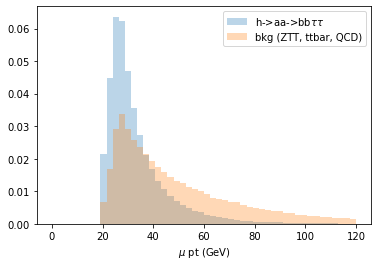

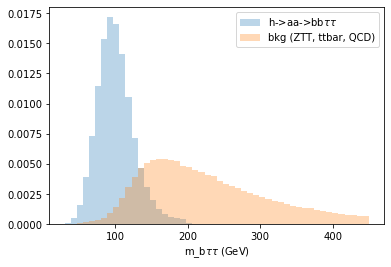

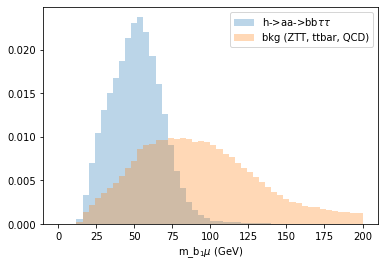

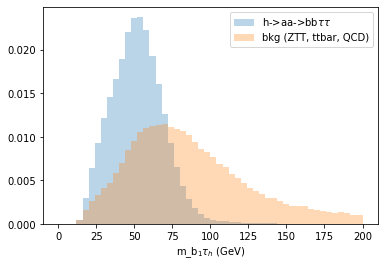

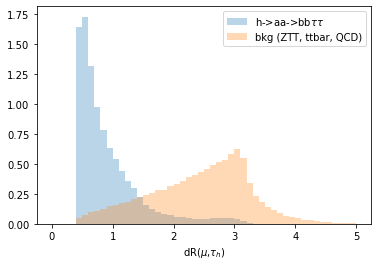

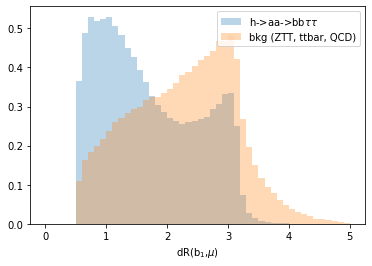

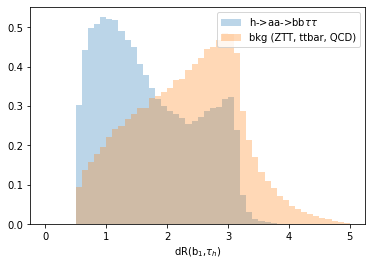

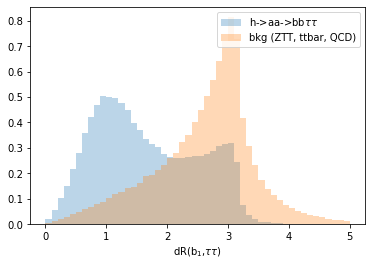

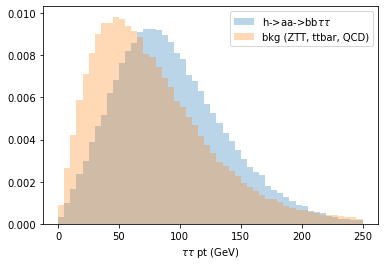

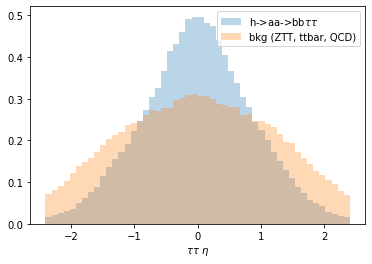

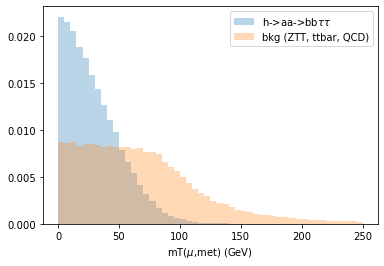

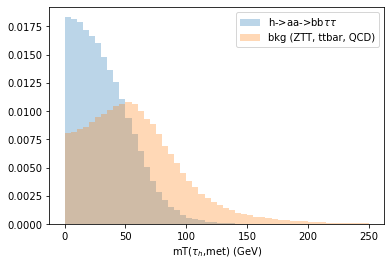

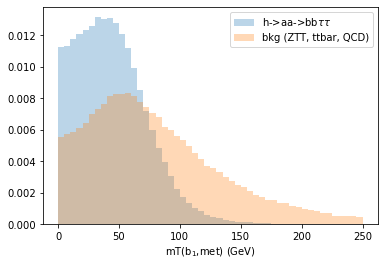

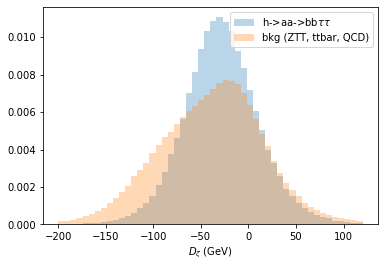

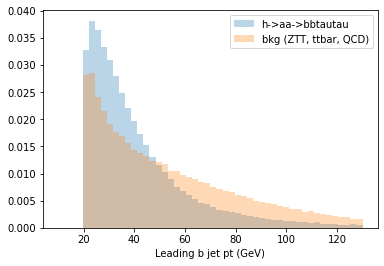

In [8]:
pyplot.hist(sig_allyears['pt_1'], density = 1, range = (0,120), bins = 50, alpha = 0.3, label = 'h->aa->bb$\\tau\\tau$')
pyplot.hist(df_bkg['pt_1'], density = 1, range = (0,120), bins = 50, alpha = 0.3, label = 'bkg (ZTT, ttbar, QCD)')
#pyplot.hist(ZTT_allyears['pt_1'], density = 1, range = (0,120), bins = 50, alpha = 1.0, label = 'ZTT', histtype = 'step')
#pyplot.hist(TT_allyears['pt_1'], density = 1, range = (0,120), bins = 50, alpha = 1.0, label = 'ttbar', histtype = 'step')
#pyplot.hist(qcd_allyears['pt_1'], density = 1, range = (0,120), bins = 50, alpha = 1.0, label = 'QCD', histtype = 'step')
pyplot.legend(loc = 'upper right')
pyplot.xlabel('$\mu$ pt (GeV)')
pyplot.show()

pyplot.hist(sig_allyears['m_btt'], density = 1, range = (30,450), bins = 50, alpha = 0.3, label = 'h->aa->bb$\\tau\\tau$')
pyplot.hist(df_bkg['m_btt'], density = 1, range = (30,450), bins = 50, alpha = 0.3, label = 'bkg (ZTT, ttbar, QCD)')
#pyplot.hist(ZTT_allyears['m_btt'], density = 1, range = (30,450), bins = 50, alpha = 1.0, label = 'ZTT', histtype = 'step')
#pyplot.hist(TT_allyears['m_btt'], density = 1, range = (30,450), bins = 50, alpha = 1.0, label = 'ttbar', histtype = 'step')
#pyplot.hist(qcd_allyears['m_btt'], density = 1, range = (30,450), bins = 50, alpha = 1.0, label = 'QCD', histtype = 'step')
pyplot.legend(loc = 'upper right')
pyplot.xlabel('m_b$\\tau\\tau$ (GeV)')
pyplot.show()

pyplot.hist(sig_allyears['m_b1mu'], density = 1, range = (0,200), bins = 50, alpha = 0.3, label = 'h->aa->bb$\\tau\\tau$')
pyplot.hist(df_bkg['m_b1mu'], density = 1, range = (0,200), bins = 50, alpha = 0.3, label = 'bkg (ZTT, ttbar, QCD)')
#pyplot.hist(ZTT_allyears['m_b1mu'], density = 1, range = (0,200), bins = 50, alpha = 1.0, label = 'ZTT', histtype = 'step')
#pyplot.hist(TT_allyears['m_b1mu'], density = 1, range = (0,200), bins = 50, alpha = 1.0, label = 'ttbar', histtype = 'step')
#pyplot.hist(qcd_allyears['m_b1mu'], density = 1, range = (0,200), bins = 50, alpha = 1.0, label = 'QCD', histtype = 'step')
pyplot.legend(loc = 'upper right')
pyplot.xlabel('m_b$_1$$\mu$ (GeV)')
pyplot.show()

pyplot.hist(sig_allyears['m_b1tau'], density = 1, range = (0,200), bins = 50, alpha = 0.3, label = 'h->aa->bb$\\tau\\tau$')
pyplot.hist(df_bkg['m_b1tau'], density = 1, range = (0,200), bins = 50, alpha = 0.3, label = 'bkg (ZTT, ttbar, QCD)')
#pyplot.hist(ZTT_allyears['m_b1tau'], density = 1, range = (0,200), bins = 50, alpha = 1.0, label = 'ZTT', histtype = 'step')
#pyplot.hist(TT_allyears['m_b1tau'], density = 1, range = (0,200), bins = 50, alpha = 1.0, label = 'ttbar', histtype = 'step')
#pyplot.hist(qcd_allyears['m_b1tau'], density = 1, range = (0,200), bins = 50, alpha = 1.0, label = 'QCD', histtype = 'step')
pyplot.legend(loc = 'upper right')
pyplot.xlabel('m_b$_1$$\\tau_h$ (GeV)')
pyplot.show()

pyplot.hist(sig_allyears['dR_tt'], density = 1, range = (0,5), bins = 50, alpha = 0.3, label = 'h->aa->bb$\\tau\\tau$')
pyplot.hist(df_bkg['dR_tt'], density = 1, range = (0,5), bins = 50, alpha = 0.3, label = 'bkg (ZTT, ttbar, QCD)')
#pyplot.hist(ZTT_allyears['dR_tt'], density = 1, range = (0,5), bins = 50, alpha = 1.0, label = 'ZTT', histtype = 'step')
#pyplot.hist(TT_allyears['dR_tt'], density = 1, range = (0,5), bins = 50, alpha = 1.0, label = 'ttbar', histtype = 'step')
#pyplot.hist(qcd_allyears['dR_tt'], density = 1, range = (0,5), bins = 50, alpha = 1.0, label = 'QCD', histtype = 'step')
pyplot.legend(loc = 'upper right')
pyplot.xlabel('dR($\mu$,$\\tau_h$)')
pyplot.show()

pyplot.hist(sig_allyears['dR_b1mu'], density = 1, range = (0,5), bins = 50, alpha = 0.3, label = 'h->aa->bb$\\tau\\tau$')
pyplot.hist(df_bkg['dR_b1mu'], density = 1, range = (0,5), bins = 50, alpha = 0.3, label = 'bkg (ZTT, ttbar, QCD)')
#pyplot.hist(ZTT_allyears['dR_b1mu'], density = 1, range = (0,5), bins = 50, alpha = 1.0, label = 'ZTT', histtype = 'step')
#pyplot.hist(TT_allyears['dR_b1mu'], density = 1, range = (0,5), bins = 50, alpha = 1.0, label = 'ttbar', histtype = 'step')
#pyplot.hist(qcd_allyears['dR_b1mu'], density = 1, range = (0,5), bins = 50, alpha = 1.0, label = 'QCD', histtype = 'step')
pyplot.legend(loc = 'upper right')
pyplot.xlabel('dR(b$_1$,$\mu$)')
pyplot.show()

pyplot.hist(sig_allyears['dR_b1tau'], density = 1, range = (0,5), bins = 50, alpha = 0.3, label = 'h->aa->bb$\\tau\\tau$')
pyplot.hist(df_bkg['dR_b1tau'], density = 1, range = (0,5), bins = 50, alpha = 0.3, label = 'bkg (ZTT, ttbar, QCD)')
#pyplot.hist(ZTT_allyears['dR_b1tau'], density = 1, range = (0,5), bins = 50, alpha = 1.0, label = 'ZTT', histtype = 'step')
#pyplot.hist(TT_allyears['dR_b1tau'], density = 1, range = (0,5), bins = 50, alpha = 1.0, label = 'ttbar', histtype = 'step')
#pyplot.hist(qcd_allyears['dR_b1tau'], density = 1, range = (0,5), bins = 50, alpha = 1.0, label = 'QCD', histtype = 'step')
pyplot.legend(loc = 'upper right')
pyplot.xlabel('dR(b$_1$,$\\tau_h$)')
pyplot.show()

pyplot.hist(sig_allyears['dR_b1tt'], density = 1, range = (0,5), bins = 50, alpha = 0.3, label = 'h->aa->bb$\\tau\\tau$')
pyplot.hist(df_bkg['dR_b1tt'], density = 1, range = (0,5), bins = 50, alpha = 0.3, label = 'bkg (ZTT, ttbar, QCD)')
#pyplot.hist(ZTT_allyears['dR_b1tt'], density = 1, range = (0,5), bins = 50, alpha = 1.0, label = 'ZTT', histtype = 'step')
#pyplot.hist(TT_allyears['dR_b1tt'], density = 1, range = (0,5), bins = 50, alpha = 1.0, label = 'ttbar', histtype = 'step')
#pyplot.hist(qcd_allyears['dR_b1tt'], density = 1, range = (0,5), bins = 50, alpha = 1.0, label = 'QCD', histtype = 'step')
pyplot.legend(loc = 'upper right')
pyplot.xlabel('dR(b$_1$,$\\tau\\tau$)')
pyplot.show()

pyplot.hist(sig_allyears['tt_pt'], density = 1, range = (0,250), bins = 50, alpha = 0.3, label = 'h->aa->bb$\\tau\\tau$')
pyplot.hist(df_bkg['tt_pt'], density = 1, range = (0,250), bins = 50, alpha = 0.3, label = 'bkg (ZTT, ttbar, QCD)')
#pyplot.hist(ZTT_allyears['tt_pt'], density = 1, range = (0,250), bins = 50, alpha = 1.0, label = 'ZTT', histtype = 'step')
#pyplot.hist(TT_allyears['tt_pt'], density = 1, range = (0,250), bins = 50, alpha = 1.0, label = 'ttbar', histtype = 'step')
#pyplot.hist(qcd_allyears['tt_pt'], density = 1, range = (0,250), bins = 50, alpha = 1.0, label = 'QCD', histtype = 'step')
pyplot.legend(loc = 'upper right')
pyplot.xlabel('$\\tau\\tau$ pt (GeV)')
pyplot.show()

pyplot.hist(sig_allyears['tt_eta'], density = 1, range = (-2.4,2.4), bins = 50, alpha = 0.3, label = 'h->aa->bb$\\tau\\tau$')
pyplot.hist(df_bkg['tt_eta'], density = 1, range = (-2.4,2.4), bins = 50, alpha = 0.3, label = 'bkg (ZTT, ttbar, QCD)')
#pyplot.hist(ZTT_allyears['tt_eta'], density = 1, range = (-2.4,2.4), bins = 50, alpha = 1.0, label = 'ZTT', histtype = 'step')
#pyplot.hist(TT_allyears['tt_eta'], density = 1, range = (-2.4,2.4), bins = 50, alpha = 1.0, label = 'ttbar', histtype = 'step')
#pyplot.hist(qcd_allyears['tt_eta'], density = 1, range = (-2.4,2.4), bins = 50, alpha = 1.0, label = 'QCD', histtype = 'step')
pyplot.legend(loc = 'upper right')
pyplot.xlabel('$\\tau\\tau$ $\eta$')
pyplot.show()

pyplot.hist(sig_allyears['mT_mu'], density = 1, range = (0,250), bins = 50, alpha = 0.3, label = 'h->aa->bb$\\tau\\tau$')
pyplot.hist(df_bkg['mT_mu'], density = 1, range = (0,250), bins = 50, alpha = 0.3, label = 'bkg (ZTT, ttbar, QCD)')
#pyplot.hist(ZTT_allyears['mT_mu'], density = 1, range = (0,250), bins = 50, alpha = 1.0, label = 'ZTT', histtype = 'step')
#pyplot.hist(TT_allyears['mT_mu'], density = 1, range = (0,250), bins = 50, alpha = 1.0, label = 'ttbar', histtype = 'step')
#pyplot.hist(qcd_allyears['mT_mu'], density = 1, range = (0,250), bins = 50, alpha = 1.0, label = 'QCD', histtype = 'step')
pyplot.legend(loc = 'upper right')
pyplot.xlabel('mT($\mu$,met) (GeV)')
pyplot.show()

pyplot.hist(sig_allyears['mT_tau'], density = 1, range = (0,250), bins = 50, alpha = 0.3, label = 'h->aa->bb$\\tau\\tau$')
pyplot.hist(df_bkg['mT_tau'], density = 1, range = (0,250), bins = 50, alpha = 0.3, label = 'bkg (ZTT, ttbar, QCD)')
#pyplot.hist(ZTT_allyears['mT_tau'], density = 1, range = (0,250), bins = 50, alpha = 1.0, label = 'ZTT', histtype = 'step')
#pyplot.hist(TT_allyears['mT_tau'], density = 1, range = (0,250), bins = 50, alpha = 1.0, label = 'ttbar', histtype = 'step')
#pyplot.hist(qcd_allyears['mT_tau'], density = 1, range = (0,250), bins = 50, alpha = 1.0, label = 'QCD', histtype = 'step')
pyplot.legend(loc = 'upper right')
pyplot.xlabel('mT($\\tau_h$,met) (GeV)')
pyplot.show()

pyplot.hist(sig_allyears['mT_b1'], density = 1, range = (0,250), bins = 50, alpha = 0.3, label = 'h->aa->bb$\\tau\\tau$')
pyplot.hist(df_bkg['mT_b1'], density = 1, range = (0,250), bins = 50, alpha = 0.3, label = 'bkg (ZTT, ttbar, QCD)')
#pyplot.hist(ZTT_allyears['mT_b1'], density = 1, range = (0,250), bins = 50, alpha = 1.0, label = 'ZTT', histtype = 'step')
#pyplot.hist(TT_allyears['mT_b1'], density = 1, range = (0,250), bins = 50, alpha = 1.0, label = 'ttbar', histtype = 'step')
#pyplot.hist(qcd_allyears['mT_b1'], density = 1, range = (0,250), bins = 50, alpha = 1.0, label = 'QCD', histtype = 'step')
pyplot.legend(loc = 'upper right')
pyplot.xlabel('mT(b$_1$,met) (GeV)')
pyplot.show()

pyplot.hist(sig_allyears['Dzeta'], density = 1, range = (-200,120), bins = 50, alpha = 0.3, label = 'h->aa->bb$\\tau\\tau$')
pyplot.hist(df_bkg['Dzeta'], density = 1, range = (-200,120), bins = 50, alpha = 0.3, label = 'bkg (ZTT, ttbar, QCD)')
#pyplot.hist(ZTT_allyears['Dzeta'], density = 1, range = (-200,120), bins = 50, alpha = 1.0, label = 'ZTT', histtype = 'step')
#pyplot.hist(TT_allyears['Dzeta'], density = 1, range = (-200,120), bins = 50, alpha = 1.0, label = 'ttbar', histtype = 'step')
#pyplot.hist(qcd_allyears['Dzeta'], density = 1, range = (-200,120), bins = 50, alpha = 1.0, label = 'QCD', histtype = 'step')
pyplot.legend(loc = 'upper right')
pyplot.xlabel('$D_\zeta$ (GeV)')
pyplot.show()

pyplot.hist(sig_allyears['bpt_deepflavour_1'], density = 1, range = (10,130), bins = 50, alpha = 0.3, label = 'h->aa->bbtautau')
pyplot.hist(df_bkg['bpt_deepflavour_1'], density = 1, range = (10,130), bins = 50, alpha = 0.3, label = 'bkg (ZTT, ttbar, QCD)')
#pyplot.hist(ZTT_allyears['bpt_deepflavour_1'], density = 1, range = (10,130), bins = 50, alpha = 1.0, label = 'ZTT', histtype = 'step')
#pyplot.hist(TT_allyears['bpt_deepflavour_1'], density = 1, range = (10,130), bins = 50, alpha = 1.0, label = 'ttbar', histtype = 'step')
#pyplot.hist(qcd_allyears['bpt_deepflavour_1'], density = 1, range = (10,130), bins = 50, alpha = 1.0, label = 'QCD', histtype = 'step')
pyplot.legend(loc = 'upper right')
pyplot.xlabel('Leading b jet pt (GeV)')
pyplot.show()

## Input data pre-processing

In [9]:
# convert to numpy arrays
dataset = df_MC.values
X = dataset[:,0:(dataset.shape[1]-1)]
Y = dataset[:,dataset.shape[1]-1]
Y = Y.reshape(Y.shape[0],1)

#dataset_obs = df_obs.values
#X_obs = dataset_obs[:,0:(dataset_obs.shape[1])]

# give train/val/test partition ratios
train_ratio = 0.6
val_ratio = 0.2
test_ratio = 1 - train_ratio - val_ratio

# randomly partition data set into train/val/test sets with given ratios
X_train_val, X_test, Y_train_val, Y_test = train_test_split(X, Y, test_size = test_ratio, random_state=15)
X_train, X_val, Y_train, Y_val = train_test_split(X_train_val, Y_train_val, test_size = val_ratio/(val_ratio+train_ratio), random_state=15)

# standardize feature variables
# only based on means and stds in train_val set, should apply this only scaler to all other sets
# think of the transformation in phase space
scaler = StandardScaler().fit(X_train_val)
X_train_val = scaler.transform(X_train_val)
X_train = scaler.transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)
#X_obs = scaler.transform(X_obs)

# print input data shapes
print("\nPartition the data set into train/val/test: %.2f/%.2f/%.2f" % (train_ratio, val_ratio, test_ratio))
print("X_train.shape: " + str(X_train.shape))
print("Y_train.shape: " + str(Y_train.shape))
print("X_val.shape: " + str(X_val.shape))
print("Y_val.shape: " + str(Y_val.shape))
print("X_test.shape: " + str(X_test.shape))
print("Y_test.shape: " + str(Y_test.shape))
#print("\nX_obs.shape: " + str(X_obs.shape))

# print ratio of signal/background examples in each set
train_sig = np.count_nonzero(Y_train)
train_bkg = np.count_nonzero(Y_train == 0)
train_sig_perc = 100*train_sig/(train_sig+train_bkg)
train_bkg_perc = 100*train_bkg/(train_sig+train_bkg)
val_sig = np.count_nonzero(Y_val)
val_bkg = np.count_nonzero(Y_val == 0)
val_sig_perc = 100*val_sig/(val_sig+val_bkg)
val_bkg_perc = 100*val_bkg/(val_sig+val_bkg)
test_sig = np.count_nonzero(Y_test)
test_bkg = np.count_nonzero(Y_test == 0)
test_sig_perc = 100*test_sig/(test_sig+test_bkg)
test_bkg_perc = 100*test_bkg/(test_sig+test_bkg)

total_sig = train_sig + val_sig + test_sig
total_bkg = train_bkg + val_bkg + test_bkg
total_sig_perc = 100*total_sig/(total_sig+total_bkg)
total_bkg_perc = 100*total_bkg/(total_sig+total_bkg)
print("\nTotal number of sig/bkg examples: %d/%d (%.2f%%/%.2f%%)" % (total_sig, total_bkg, total_sig_perc, total_bkg_perc))

print("\nNumber of sig/bkg examples in each set:")
print("train : %d/%d (%.1f%%/%.1f%%)" % (train_sig, train_bkg, train_sig_perc, train_bkg_perc))
print("val   : %d/%d (%.1f%%/%.1f%%)" % (val_sig, val_bkg, val_sig_perc, val_bkg_perc))
print("test  : %d/%d (%.1f%%/%.1f%%)" % (test_sig, test_bkg, test_sig_perc, test_bkg_perc))


Partition the data set into train/val/test: 0.60/0.20/0.20
X_train.shape: (190396, 15)
Y_train.shape: (190396, 1)
X_val.shape: (63466, 15)
Y_val.shape: (63466, 1)
X_test.shape: (63466, 15)
Y_test.shape: (63466, 1)

Total number of sig/bkg examples: 158664/158664 (50.00%/50.00%)

Number of sig/bkg examples in each set:
train : 95188/95208 (50.0%/50.0%)
val   : 31663/31803 (49.9%/50.1%)
test  : 31813/31653 (50.1%/49.9%)


## DNN Hyperparameters searching

In [10]:
# define model for the search
def hypermodel(hp):
    hp_model = keras.Sequential()
    hp_model.add(keras.layers.Input(shape = (X.shape[1],)))
    
    hp_model.add(keras.layers.Dense(units = hp.Int('units_1',
                                                   min_value = 20,
                                                   max_value = 60,
                                                   step = 2),
                                    activation = 'relu',
                                    kernel_initializer = glorot_uniform(seed=1)))
    
    hp_model.add(keras.layers.Dropout(rate = hp.Float('rate_1',
                                                      min_value = 0.2,
                                                      max_value = 0.5,
                                                      default = 0.2,
                                                      step = 0.1),
                                      seed = 10))
    
    hp_model.add(keras.layers.Dense(units = hp.Int('units_2',
                                                   min_value = 20,
                                                   max_value = 60,
                                                   step = 2),
                                    activation = 'relu',
                                    kernel_initializer = glorot_uniform(seed=1)))
    
    hp_model.add(keras.layers.Dropout(rate = hp.Float('rate_2',
                                                      min_value = 0.2,
                                                      max_value = 0.5,
                                                      default = 0.2,
                                                      step = 0.1),
                                      seed = 10))

    hp_model.add(keras.layers.Dense(units = 1, activation = 'sigmoid', kernel_initializer = glorot_uniform(seed=1)))
    hp_model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])
    return hp_model

In [11]:
# define tuner model
tuner = Hyperband(hypermodel,
                  objective = 'val_accuracy',
                  max_epochs = 20,
                  factor = 3, #number of models to train in a bracket = 1+log_factor(max_epochs)
                  hyperband_iterations = 2, #number of times to iterate over the full Hyperband algorithm
                  seed = 10,
                  directory = 'hypertuning',
                  project_name = 'tune',
                  overwrite = True)

2021-08-27 17:25:21.146325: I tensorflow/core/platform/cpu_feature_guard.cc:145] This TensorFlow binary is optimized with Intel(R) MKL-DNN to use the following CPU instructions in performance critical operations:  SSE4.1 SSE4.2
To enable them in non-MKL-DNN operations, rebuild TensorFlow with the appropriate compiler flags.
2021-08-27 17:25:21.147663: I tensorflow/core/common_runtime/process_util.cc:115] Creating new thread pool with default inter op setting: 8. Tune using inter_op_parallelism_threads for best performance.


In [12]:
# run the search
tuner.search(X_train, Y_train, epochs = 20, validation_data = (X_val,Y_val), batch_size = 256)

Train on 190396 samples, validate on 63466 samples
Epoch 1/3
190396/190396 [==============================] - ETA: 9:44 - loss: 0.8008 - accuracy: 0.48 - ETA: 1:08 - loss: 0.7026 - accuracy: 0.57 - ETA: 38s - loss: 0.6434 - accuracy: 0.6363 - ETA: 26s - loss: 0.5884 - accuracy: 0.700 - ETA: 20s - loss: 0.5428 - accuracy: 0.746 - ETA: 17s - loss: 0.5057 - accuracy: 0.775 - ETA: 15s - loss: 0.4748 - accuracy: 0.798 - ETA: 13s - loss: 0.4458 - accuracy: 0.815 - ETA: 12s - loss: 0.4239 - accuracy: 0.827 - ETA: 11s - loss: 0.4036 - accuracy: 0.837 - ETA: 10s - loss: 0.3864 - accuracy: 0.845 - ETA: 9s - loss: 0.3705 - accuracy: 0.852 - ETA: 9s - loss: 0.3560 - accuracy: 0.85 - ETA: 8s - loss: 0.3420 - accuracy: 0.86 - ETA: 8s - loss: 0.3304 - accuracy: 0.87 - ETA: 7s - loss: 0.3208 - accuracy: 0.87 - ETA: 7s - loss: 0.3120 - accuracy: 0.87 - ETA: 7s - loss: 0.3040 - accuracy: 0.88 - ETA: 7s - loss: 0.2970 - accuracy: 0.88 - ETA: 6s - loss: 0.2905 - accuracy: 0.88 - ETA: 6s - loss: 0.2834 - a

190396/190396 [==============================] - ETA: 4s - loss: 0.1079 - accuracy: 0.96 - ETA: 4s - loss: 0.1133 - accuracy: 0.95 - ETA: 4s - loss: 0.1215 - accuracy: 0.95 - ETA: 4s - loss: 0.1233 - accuracy: 0.95 - ETA: 4s - loss: 0.1244 - accuracy: 0.95 - ETA: 4s - loss: 0.1239 - accuracy: 0.95 - ETA: 4s - loss: 0.1255 - accuracy: 0.95 - ETA: 4s - loss: 0.1262 - accuracy: 0.95 - ETA: 4s - loss: 0.1250 - accuracy: 0.95 - ETA: 4s - loss: 0.1249 - accuracy: 0.95 - ETA: 4s - loss: 0.1233 - accuracy: 0.95 - ETA: 4s - loss: 0.1239 - accuracy: 0.95 - ETA: 4s - loss: 0.1244 - accuracy: 0.95 - ETA: 3s - loss: 0.1237 - accuracy: 0.95 - ETA: 3s - loss: 0.1252 - accuracy: 0.95 - ETA: 3s - loss: 0.1254 - accuracy: 0.95 - ETA: 3s - loss: 0.1254 - accuracy: 0.95 - ETA: 3s - loss: 0.1252 - accuracy: 0.95 - ETA: 3s - loss: 0.1255 - accuracy: 0.95 - ETA: 3s - loss: 0.1263 - accuracy: 0.95 - ETA: 3s - loss: 0.1261 - accuracy: 0.95 - ETA: 3s - loss: 0.1267 - accuracy: 0.95 - ETA: 3s - loss: 0.1268 - ac

Train on 190396 samples, validate on 63466 samples
Epoch 1/3
190396/190396 [==============================] - ETA: 6:29 - loss: 0.9627 - accuracy: 0.39 - ETA: 42s - loss: 0.8588 - accuracy: 0.4516 - ETA: 23s - loss: 0.8102 - accuracy: 0.489 - ETA: 17s - loss: 0.7595 - accuracy: 0.529 - ETA: 13s - loss: 0.7237 - accuracy: 0.562 - ETA: 11s - loss: 0.6892 - accuracy: 0.597 - ETA: 10s - loss: 0.6549 - accuracy: 0.630 - ETA: 9s - loss: 0.6287 - accuracy: 0.653 - ETA: 8s - loss: 0.6044 - accuracy: 0.67 - ETA: 7s - loss: 0.5821 - accuracy: 0.69 - ETA: 7s - loss: 0.5602 - accuracy: 0.70 - ETA: 7s - loss: 0.5541 - accuracy: 0.71 - ETA: 7s - loss: 0.5351 - accuracy: 0.72 - ETA: 6s - loss: 0.5158 - accuracy: 0.73 - ETA: 6s - loss: 0.5005 - accuracy: 0.74 - ETA: 6s - loss: 0.4847 - accuracy: 0.75 - ETA: 5s - loss: 0.4702 - accuracy: 0.76 - ETA: 5s - loss: 0.4573 - accuracy: 0.77 - ETA: 5s - loss: 0.4451 - accuracy: 0.78 - ETA: 5s - loss: 0.4340 - accuracy: 0.79 - ETA: 4s - loss: 0.4238 - accuracy:

190396/190396 [==============================] - ETA: 4s - loss: 0.1878 - accuracy: 0.93 - ETA: 3s - loss: 0.1704 - accuracy: 0.94 - ETA: 3s - loss: 0.1663 - accuracy: 0.94 - ETA: 3s - loss: 0.1546 - accuracy: 0.94 - ETA: 3s - loss: 0.1534 - accuracy: 0.94 - ETA: 3s - loss: 0.1531 - accuracy: 0.94 - ETA: 3s - loss: 0.1556 - accuracy: 0.94 - ETA: 3s - loss: 0.1524 - accuracy: 0.94 - ETA: 3s - loss: 0.1525 - accuracy: 0.94 - ETA: 3s - loss: 0.1515 - accuracy: 0.94 - ETA: 3s - loss: 0.1517 - accuracy: 0.94 - ETA: 3s - loss: 0.1506 - accuracy: 0.94 - ETA: 3s - loss: 0.1495 - accuracy: 0.94 - ETA: 3s - loss: 0.1485 - accuracy: 0.94 - ETA: 3s - loss: 0.1494 - accuracy: 0.94 - ETA: 3s - loss: 0.1492 - accuracy: 0.94 - ETA: 3s - loss: 0.1488 - accuracy: 0.94 - ETA: 3s - loss: 0.1488 - accuracy: 0.94 - ETA: 3s - loss: 0.1491 - accuracy: 0.94 - ETA: 3s - loss: 0.1492 - accuracy: 0.94 - ETA: 3s - loss: 0.1492 - accuracy: 0.94 - ETA: 3s - loss: 0.1493 - accuracy: 0.94 - ETA: 3s - loss: 0.1491 - ac

Train on 190396 samples, validate on 63466 samples
Epoch 1/3
190396/190396 [==============================] - ETA: 6:27 - loss: 0.7436 - accuracy: 0.52 - ETA: 46s - loss: 0.6947 - accuracy: 0.5543 - ETA: 26s - loss: 0.6413 - accuracy: 0.617 - ETA: 19s - loss: 0.6030 - accuracy: 0.662 - ETA: 15s - loss: 0.5708 - accuracy: 0.697 - ETA: 13s - loss: 0.5381 - accuracy: 0.727 - ETA: 11s - loss: 0.5133 - accuracy: 0.750 - ETA: 10s - loss: 0.4908 - accuracy: 0.766 - ETA: 9s - loss: 0.4677 - accuracy: 0.783 - ETA: 8s - loss: 0.4456 - accuracy: 0.79 - ETA: 8s - loss: 0.4290 - accuracy: 0.80 - ETA: 7s - loss: 0.4168 - accuracy: 0.81 - ETA: 7s - loss: 0.4023 - accuracy: 0.82 - ETA: 7s - loss: 0.3897 - accuracy: 0.82 - ETA: 6s - loss: 0.3775 - accuracy: 0.83 - ETA: 6s - loss: 0.3681 - accuracy: 0.84 - ETA: 6s - loss: 0.3568 - accuracy: 0.84 - ETA: 6s - loss: 0.3479 - accuracy: 0.85 - ETA: 5s - loss: 0.3397 - accuracy: 0.85 - ETA: 5s - loss: 0.3323 - accuracy: 0.85 - ETA: 5s - loss: 0.3254 - accurac

190396/190396 [==============================] - ETA: 5s - loss: 0.1482 - accuracy: 0.95 - ETA: 5s - loss: 0.1557 - accuracy: 0.93 - ETA: 5s - loss: 0.1533 - accuracy: 0.94 - ETA: 5s - loss: 0.1531 - accuracy: 0.94 - ETA: 5s - loss: 0.1455 - accuracy: 0.94 - ETA: 5s - loss: 0.1490 - accuracy: 0.94 - ETA: 5s - loss: 0.1496 - accuracy: 0.94 - ETA: 4s - loss: 0.1481 - accuracy: 0.94 - ETA: 4s - loss: 0.1486 - accuracy: 0.94 - ETA: 4s - loss: 0.1497 - accuracy: 0.94 - ETA: 4s - loss: 0.1491 - accuracy: 0.94 - ETA: 4s - loss: 0.1516 - accuracy: 0.94 - ETA: 4s - loss: 0.1501 - accuracy: 0.94 - ETA: 4s - loss: 0.1499 - accuracy: 0.94 - ETA: 4s - loss: 0.1492 - accuracy: 0.94 - ETA: 4s - loss: 0.1480 - accuracy: 0.94 - ETA: 4s - loss: 0.1496 - accuracy: 0.94 - ETA: 4s - loss: 0.1498 - accuracy: 0.94 - ETA: 4s - loss: 0.1492 - accuracy: 0.94 - ETA: 4s - loss: 0.1492 - accuracy: 0.94 - ETA: 4s - loss: 0.1491 - accuracy: 0.94 - ETA: 4s - loss: 0.1491 - accuracy: 0.94 - ETA: 4s - loss: 0.1491 - ac

190396/190396 [==============================] - ETA: 5s - loss: 0.1551 - accuracy: 0.95 - ETA: 5s - loss: 0.1591 - accuracy: 0.94 - ETA: 5s - loss: 0.1461 - accuracy: 0.95 - ETA: 5s - loss: 0.1434 - accuracy: 0.94 - ETA: 5s - loss: 0.1377 - accuracy: 0.95 - ETA: 5s - loss: 0.1378 - accuracy: 0.95 - ETA: 5s - loss: 0.1360 - accuracy: 0.95 - ETA: 5s - loss: 0.1349 - accuracy: 0.95 - ETA: 5s - loss: 0.1359 - accuracy: 0.94 - ETA: 5s - loss: 0.1349 - accuracy: 0.95 - ETA: 5s - loss: 0.1360 - accuracy: 0.94 - ETA: 5s - loss: 0.1361 - accuracy: 0.94 - ETA: 5s - loss: 0.1369 - accuracy: 0.94 - ETA: 4s - loss: 0.1369 - accuracy: 0.94 - ETA: 4s - loss: 0.1364 - accuracy: 0.94 - ETA: 4s - loss: 0.1368 - accuracy: 0.94 - ETA: 4s - loss: 0.1351 - accuracy: 0.95 - ETA: 4s - loss: 0.1360 - accuracy: 0.94 - ETA: 4s - loss: 0.1353 - accuracy: 0.95 - ETA: 4s - loss: 0.1354 - accuracy: 0.95 - ETA: 4s - loss: 0.1361 - accuracy: 0.95 - ETA: 4s - loss: 0.1356 - accuracy: 0.95 - ETA: 4s - loss: 0.1362 - ac

Train on 190396 samples, validate on 63466 samples
Epoch 1/3
190396/190396 [==============================] - ETA: 6:27 - loss: 0.7647 - accuracy: 0.50 - ETA: 52s - loss: 0.7002 - accuracy: 0.5693 - ETA: 30s - loss: 0.6458 - accuracy: 0.629 - ETA: 22s - loss: 0.5989 - accuracy: 0.680 - ETA: 18s - loss: 0.5619 - accuracy: 0.714 - ETA: 15s - loss: 0.5364 - accuracy: 0.733 - ETA: 13s - loss: 0.5066 - accuracy: 0.754 - ETA: 12s - loss: 0.4757 - accuracy: 0.775 - ETA: 11s - loss: 0.4539 - accuracy: 0.790 - ETA: 10s - loss: 0.4348 - accuracy: 0.801 - ETA: 9s - loss: 0.4169 - accuracy: 0.811 - ETA: 9s - loss: 0.4015 - accuracy: 0.82 - ETA: 9s - loss: 0.3901 - accuracy: 0.82 - ETA: 8s - loss: 0.3791 - accuracy: 0.83 - ETA: 8s - loss: 0.3694 - accuracy: 0.83 - ETA: 8s - loss: 0.3600 - accuracy: 0.84 - ETA: 8s - loss: 0.3517 - accuracy: 0.84 - ETA: 7s - loss: 0.3442 - accuracy: 0.85 - ETA: 7s - loss: 0.3374 - accuracy: 0.85 - ETA: 7s - loss: 0.3303 - accuracy: 0.85 - ETA: 7s - loss: 0.3235 - acc

190396/190396 [==============================] - ETA: 5s - loss: 0.1531 - accuracy: 0.94 - ETA: 4s - loss: 0.1502 - accuracy: 0.94 - ETA: 4s - loss: 0.1477 - accuracy: 0.94 - ETA: 4s - loss: 0.1419 - accuracy: 0.94 - ETA: 4s - loss: 0.1387 - accuracy: 0.94 - ETA: 4s - loss: 0.1410 - accuracy: 0.94 - ETA: 4s - loss: 0.1413 - accuracy: 0.94 - ETA: 4s - loss: 0.1422 - accuracy: 0.94 - ETA: 4s - loss: 0.1422 - accuracy: 0.94 - ETA: 4s - loss: 0.1435 - accuracy: 0.94 - ETA: 4s - loss: 0.1412 - accuracy: 0.94 - ETA: 4s - loss: 0.1391 - accuracy: 0.94 - ETA: 4s - loss: 0.1389 - accuracy: 0.94 - ETA: 4s - loss: 0.1389 - accuracy: 0.94 - ETA: 4s - loss: 0.1374 - accuracy: 0.94 - ETA: 4s - loss: 0.1381 - accuracy: 0.94 - ETA: 4s - loss: 0.1376 - accuracy: 0.94 - ETA: 4s - loss: 0.1372 - accuracy: 0.94 - ETA: 4s - loss: 0.1374 - accuracy: 0.94 - ETA: 4s - loss: 0.1372 - accuracy: 0.94 - ETA: 4s - loss: 0.1364 - accuracy: 0.94 - ETA: 4s - loss: 0.1376 - accuracy: 0.94 - ETA: 3s - loss: 0.1380 - ac

190396/190396 [==============================] - ETA: 6s - loss: 0.1497 - accuracy: 0.93 - ETA: 5s - loss: 0.1222 - accuracy: 0.95 - ETA: 5s - loss: 0.1088 - accuracy: 0.95 - ETA: 5s - loss: 0.1099 - accuracy: 0.95 - ETA: 5s - loss: 0.1160 - accuracy: 0.95 - ETA: 5s - loss: 0.1189 - accuracy: 0.95 - ETA: 5s - loss: 0.1223 - accuracy: 0.95 - ETA: 5s - loss: 0.1233 - accuracy: 0.95 - ETA: 4s - loss: 0.1213 - accuracy: 0.95 - ETA: 4s - loss: 0.1237 - accuracy: 0.95 - ETA: 4s - loss: 0.1241 - accuracy: 0.95 - ETA: 4s - loss: 0.1244 - accuracy: 0.95 - ETA: 4s - loss: 0.1238 - accuracy: 0.95 - ETA: 4s - loss: 0.1240 - accuracy: 0.95 - ETA: 4s - loss: 0.1237 - accuracy: 0.95 - ETA: 4s - loss: 0.1234 - accuracy: 0.95 - ETA: 4s - loss: 0.1240 - accuracy: 0.95 - ETA: 4s - loss: 0.1239 - accuracy: 0.95 - ETA: 4s - loss: 0.1245 - accuracy: 0.95 - ETA: 4s - loss: 0.1251 - accuracy: 0.95 - ETA: 4s - loss: 0.1253 - accuracy: 0.95 - ETA: 4s - loss: 0.1259 - accuracy: 0.95 - ETA: 4s - loss: 0.1262 - ac

Train on 190396 samples, validate on 63466 samples
Epoch 1/3
190396/190396 [==============================] - ETA: 6:24 - loss: 0.9881 - accuracy: 0.48 - ETA: 46s - loss: 0.8451 - accuracy: 0.5269 - ETA: 26s - loss: 0.7682 - accuracy: 0.561 - ETA: 18s - loss: 0.7096 - accuracy: 0.601 - ETA: 15s - loss: 0.6662 - accuracy: 0.633 - ETA: 12s - loss: 0.6244 - accuracy: 0.666 - ETA: 11s - loss: 0.5921 - accuracy: 0.690 - ETA: 10s - loss: 0.5645 - accuracy: 0.711 - ETA: 9s - loss: 0.5357 - accuracy: 0.730 - ETA: 8s - loss: 0.5134 - accuracy: 0.74 - ETA: 8s - loss: 0.4930 - accuracy: 0.75 - ETA: 7s - loss: 0.4732 - accuracy: 0.77 - ETA: 7s - loss: 0.4566 - accuracy: 0.78 - ETA: 6s - loss: 0.4397 - accuracy: 0.79 - ETA: 6s - loss: 0.4242 - accuracy: 0.80 - ETA: 6s - loss: 0.4112 - accuracy: 0.80 - ETA: 6s - loss: 0.3997 - accuracy: 0.81 - ETA: 5s - loss: 0.3895 - accuracy: 0.82 - ETA: 5s - loss: 0.3790 - accuracy: 0.82 - ETA: 5s - loss: 0.3692 - accuracy: 0.83 - ETA: 5s - loss: 0.3607 - accurac

190396/190396 [==============================] - ETA: 4s - loss: 0.0889 - accuracy: 0.96 - ETA: 4s - loss: 0.1330 - accuracy: 0.95 - ETA: 4s - loss: 0.1319 - accuracy: 0.95 - ETA: 4s - loss: 0.1302 - accuracy: 0.95 - ETA: 4s - loss: 0.1378 - accuracy: 0.94 - ETA: 4s - loss: 0.1341 - accuracy: 0.95 - ETA: 4s - loss: 0.1323 - accuracy: 0.95 - ETA: 4s - loss: 0.1310 - accuracy: 0.95 - ETA: 4s - loss: 0.1309 - accuracy: 0.95 - ETA: 3s - loss: 0.1312 - accuracy: 0.95 - ETA: 3s - loss: 0.1330 - accuracy: 0.95 - ETA: 3s - loss: 0.1345 - accuracy: 0.95 - ETA: 3s - loss: 0.1350 - accuracy: 0.95 - ETA: 3s - loss: 0.1348 - accuracy: 0.95 - ETA: 3s - loss: 0.1355 - accuracy: 0.95 - ETA: 3s - loss: 0.1355 - accuracy: 0.95 - ETA: 3s - loss: 0.1356 - accuracy: 0.95 - ETA: 3s - loss: 0.1343 - accuracy: 0.95 - ETA: 3s - loss: 0.1354 - accuracy: 0.95 - ETA: 3s - loss: 0.1360 - accuracy: 0.95 - ETA: 3s - loss: 0.1354 - accuracy: 0.95 - ETA: 3s - loss: 0.1355 - accuracy: 0.95 - ETA: 3s - loss: 0.1351 - ac

Train on 190396 samples, validate on 63466 samples
Epoch 1/3
190396/190396 [==============================] - ETA: 6:23 - loss: 0.7102 - accuracy: 0.52 - ETA: 41s - loss: 0.6655 - accuracy: 0.5770 - ETA: 23s - loss: 0.6173 - accuracy: 0.633 - ETA: 17s - loss: 0.5722 - accuracy: 0.687 - ETA: 13s - loss: 0.5367 - accuracy: 0.722 - ETA: 11s - loss: 0.5037 - accuracy: 0.751 - ETA: 10s - loss: 0.4746 - accuracy: 0.774 - ETA: 9s - loss: 0.4500 - accuracy: 0.791 - ETA: 8s - loss: 0.4284 - accuracy: 0.80 - ETA: 8s - loss: 0.4086 - accuracy: 0.81 - ETA: 7s - loss: 0.3916 - accuracy: 0.82 - ETA: 7s - loss: 0.3786 - accuracy: 0.83 - ETA: 6s - loss: 0.3645 - accuracy: 0.84 - ETA: 6s - loss: 0.3525 - accuracy: 0.84 - ETA: 6s - loss: 0.3418 - accuracy: 0.85 - ETA: 5s - loss: 0.3340 - accuracy: 0.85 - ETA: 5s - loss: 0.3244 - accuracy: 0.86 - ETA: 5s - loss: 0.3163 - accuracy: 0.86 - ETA: 5s - loss: 0.3088 - accuracy: 0.87 - ETA: 5s - loss: 0.3018 - accuracy: 0.87 - ETA: 4s - loss: 0.2952 - accuracy:

190396/190396 [==============================] - ETA: 5s - loss: 0.1111 - accuracy: 0.94 - ETA: 4s - loss: 0.1147 - accuracy: 0.95 - ETA: 4s - loss: 0.1114 - accuracy: 0.95 - ETA: 4s - loss: 0.1141 - accuracy: 0.95 - ETA: 4s - loss: 0.1143 - accuracy: 0.95 - ETA: 4s - loss: 0.1157 - accuracy: 0.95 - ETA: 4s - loss: 0.1201 - accuracy: 0.95 - ETA: 4s - loss: 0.1202 - accuracy: 0.95 - ETA: 4s - loss: 0.1208 - accuracy: 0.95 - ETA: 4s - loss: 0.1208 - accuracy: 0.95 - ETA: 4s - loss: 0.1218 - accuracy: 0.95 - ETA: 4s - loss: 0.1214 - accuracy: 0.95 - ETA: 3s - loss: 0.1211 - accuracy: 0.95 - ETA: 3s - loss: 0.1218 - accuracy: 0.95 - ETA: 3s - loss: 0.1216 - accuracy: 0.95 - ETA: 3s - loss: 0.1223 - accuracy: 0.95 - ETA: 3s - loss: 0.1228 - accuracy: 0.95 - ETA: 3s - loss: 0.1232 - accuracy: 0.95 - ETA: 3s - loss: 0.1241 - accuracy: 0.95 - ETA: 3s - loss: 0.1243 - accuracy: 0.95 - ETA: 3s - loss: 0.1244 - accuracy: 0.95 - ETA: 3s - loss: 0.1249 - accuracy: 0.95 - ETA: 3s - loss: 0.1252 - ac

Train on 190396 samples, validate on 63466 samples
Epoch 1/3
190396/190396 [==============================] - ETA: 6:27 - loss: 0.7484 - accuracy: 0.50 - ETA: 46s - loss: 0.7226 - accuracy: 0.5130 - ETA: 25s - loss: 0.6734 - accuracy: 0.551 - ETA: 18s - loss: 0.6430 - accuracy: 0.592 - ETA: 15s - loss: 0.6158 - accuracy: 0.630 - ETA: 13s - loss: 0.5918 - accuracy: 0.662 - ETA: 11s - loss: 0.5654 - accuracy: 0.689 - ETA: 10s - loss: 0.5459 - accuracy: 0.709 - ETA: 10s - loss: 0.5261 - accuracy: 0.726 - ETA: 9s - loss: 0.5090 - accuracy: 0.741 - ETA: 8s - loss: 0.4906 - accuracy: 0.75 - ETA: 8s - loss: 0.4745 - accuracy: 0.76 - ETA: 8s - loss: 0.4571 - accuracy: 0.77 - ETA: 7s - loss: 0.4402 - accuracy: 0.78 - ETA: 7s - loss: 0.4242 - accuracy: 0.79 - ETA: 6s - loss: 0.4093 - accuracy: 0.80 - ETA: 6s - loss: 0.3965 - accuracy: 0.81 - ETA: 6s - loss: 0.3838 - accuracy: 0.82 - ETA: 6s - loss: 0.3726 - accuracy: 0.82 - ETA: 5s - loss: 0.3635 - accuracy: 0.83 - ETA: 5s - loss: 0.3556 - accur

190396/190396 [==============================] - ETA: 6s - loss: 0.1287 - accuracy: 0.93 - ETA: 5s - loss: 0.1277 - accuracy: 0.95 - ETA: 5s - loss: 0.1365 - accuracy: 0.94 - ETA: 5s - loss: 0.1323 - accuracy: 0.95 - ETA: 5s - loss: 0.1342 - accuracy: 0.94 - ETA: 5s - loss: 0.1368 - accuracy: 0.95 - ETA: 5s - loss: 0.1362 - accuracy: 0.95 - ETA: 4s - loss: 0.1361 - accuracy: 0.95 - ETA: 4s - loss: 0.1353 - accuracy: 0.95 - ETA: 4s - loss: 0.1330 - accuracy: 0.95 - ETA: 4s - loss: 0.1314 - accuracy: 0.95 - ETA: 4s - loss: 0.1307 - accuracy: 0.95 - ETA: 4s - loss: 0.1299 - accuracy: 0.95 - ETA: 4s - loss: 0.1309 - accuracy: 0.95 - ETA: 4s - loss: 0.1308 - accuracy: 0.95 - ETA: 4s - loss: 0.1309 - accuracy: 0.95 - ETA: 4s - loss: 0.1303 - accuracy: 0.95 - ETA: 4s - loss: 0.1296 - accuracy: 0.95 - ETA: 3s - loss: 0.1295 - accuracy: 0.95 - ETA: 3s - loss: 0.1298 - accuracy: 0.95 - ETA: 3s - loss: 0.1305 - accuracy: 0.95 - ETA: 3s - loss: 0.1297 - accuracy: 0.95 - ETA: 3s - loss: 0.1293 - ac

Train on 190396 samples, validate on 63466 samples
Epoch 1/3
190396/190396 [==============================] - ETA: 7:32 - loss: 0.7124 - accuracy: 0.50 - ETA: 53s - loss: 0.6368 - accuracy: 0.6272 - ETA: 30s - loss: 0.5915 - accuracy: 0.689 - ETA: 22s - loss: 0.5529 - accuracy: 0.735 - ETA: 17s - loss: 0.5146 - accuracy: 0.767 - ETA: 14s - loss: 0.4823 - accuracy: 0.790 - ETA: 13s - loss: 0.4527 - accuracy: 0.807 - ETA: 11s - loss: 0.4277 - accuracy: 0.822 - ETA: 10s - loss: 0.4063 - accuracy: 0.833 - ETA: 9s - loss: 0.3891 - accuracy: 0.841 - ETA: 9s - loss: 0.3733 - accuracy: 0.84 - ETA: 8s - loss: 0.3588 - accuracy: 0.85 - ETA: 8s - loss: 0.3460 - accuracy: 0.86 - ETA: 7s - loss: 0.3347 - accuracy: 0.86 - ETA: 7s - loss: 0.3240 - accuracy: 0.87 - ETA: 7s - loss: 0.3144 - accuracy: 0.87 - ETA: 6s - loss: 0.3042 - accuracy: 0.88 - ETA: 6s - loss: 0.2973 - accuracy: 0.88 - ETA: 6s - loss: 0.2899 - accuracy: 0.88 - ETA: 6s - loss: 0.2839 - accuracy: 0.88 - ETA: 5s - loss: 0.2780 - accur

190396/190396 [==============================] - ETA: 6s - loss: 0.1516 - accuracy: 0.96 - ETA: 5s - loss: 0.1285 - accuracy: 0.95 - ETA: 5s - loss: 0.1239 - accuracy: 0.95 - ETA: 5s - loss: 0.1281 - accuracy: 0.95 - ETA: 5s - loss: 0.1294 - accuracy: 0.95 - ETA: 5s - loss: 0.1321 - accuracy: 0.95 - ETA: 5s - loss: 0.1290 - accuracy: 0.95 - ETA: 4s - loss: 0.1288 - accuracy: 0.95 - ETA: 4s - loss: 0.1328 - accuracy: 0.95 - ETA: 4s - loss: 0.1332 - accuracy: 0.95 - ETA: 4s - loss: 0.1328 - accuracy: 0.95 - ETA: 4s - loss: 0.1331 - accuracy: 0.95 - ETA: 4s - loss: 0.1317 - accuracy: 0.95 - ETA: 4s - loss: 0.1311 - accuracy: 0.95 - ETA: 4s - loss: 0.1296 - accuracy: 0.95 - ETA: 4s - loss: 0.1291 - accuracy: 0.95 - ETA: 4s - loss: 0.1288 - accuracy: 0.95 - ETA: 4s - loss: 0.1278 - accuracy: 0.95 - ETA: 4s - loss: 0.1291 - accuracy: 0.95 - ETA: 4s - loss: 0.1288 - accuracy: 0.95 - ETA: 4s - loss: 0.1285 - accuracy: 0.95 - ETA: 4s - loss: 0.1275 - accuracy: 0.95 - ETA: 4s - loss: 0.1274 - ac

Train on 190396 samples, validate on 63466 samples
Epoch 1/3
190396/190396 [==============================] - ETA: 6:25 - loss: 0.6696 - accuracy: 0.57 - ETA: 46s - loss: 0.6069 - accuracy: 0.6688 - ETA: 26s - loss: 0.5623 - accuracy: 0.717 - ETA: 19s - loss: 0.5207 - accuracy: 0.757 - ETA: 15s - loss: 0.4854 - accuracy: 0.783 - ETA: 13s - loss: 0.4558 - accuracy: 0.803 - ETA: 11s - loss: 0.4308 - accuracy: 0.818 - ETA: 10s - loss: 0.4085 - accuracy: 0.829 - ETA: 9s - loss: 0.3903 - accuracy: 0.838 - ETA: 8s - loss: 0.3707 - accuracy: 0.84 - ETA: 8s - loss: 0.3544 - accuracy: 0.85 - ETA: 7s - loss: 0.3399 - accuracy: 0.86 - ETA: 7s - loss: 0.3273 - accuracy: 0.86 - ETA: 7s - loss: 0.3161 - accuracy: 0.87 - ETA: 6s - loss: 0.3059 - accuracy: 0.87 - ETA: 6s - loss: 0.2971 - accuracy: 0.88 - ETA: 6s - loss: 0.2894 - accuracy: 0.88 - ETA: 6s - loss: 0.2825 - accuracy: 0.88 - ETA: 5s - loss: 0.2757 - accuracy: 0.88 - ETA: 5s - loss: 0.2690 - accuracy: 0.89 - ETA: 5s - loss: 0.2636 - accurac

190396/190396 [==============================] - ETA: 4s - loss: 0.1416 - accuracy: 0.94 - ETA: 4s - loss: 0.1178 - accuracy: 0.95 - ETA: 4s - loss: 0.1170 - accuracy: 0.95 - ETA: 4s - loss: 0.1239 - accuracy: 0.95 - ETA: 4s - loss: 0.1234 - accuracy: 0.95 - ETA: 4s - loss: 0.1235 - accuracy: 0.95 - ETA: 4s - loss: 0.1222 - accuracy: 0.95 - ETA: 4s - loss: 0.1252 - accuracy: 0.95 - ETA: 4s - loss: 0.1250 - accuracy: 0.95 - ETA: 4s - loss: 0.1245 - accuracy: 0.95 - ETA: 4s - loss: 0.1249 - accuracy: 0.95 - ETA: 4s - loss: 0.1245 - accuracy: 0.95 - ETA: 3s - loss: 0.1248 - accuracy: 0.95 - ETA: 3s - loss: 0.1245 - accuracy: 0.95 - ETA: 3s - loss: 0.1244 - accuracy: 0.95 - ETA: 3s - loss: 0.1245 - accuracy: 0.95 - ETA: 3s - loss: 0.1243 - accuracy: 0.95 - ETA: 3s - loss: 0.1244 - accuracy: 0.95 - ETA: 3s - loss: 0.1235 - accuracy: 0.95 - ETA: 3s - loss: 0.1229 - accuracy: 0.95 - ETA: 3s - loss: 0.1218 - accuracy: 0.95 - ETA: 3s - loss: 0.1214 - accuracy: 0.95 - ETA: 3s - loss: 0.1208 - ac

Train on 190396 samples, validate on 63466 samples
Epoch 1/3
190396/190396 [==============================] - ETA: 6:27 - loss: 0.8837 - accuracy: 0.42 - ETA: 46s - loss: 0.7228 - accuracy: 0.5612 - ETA: 26s - loss: 0.6496 - accuracy: 0.647 - ETA: 19s - loss: 0.5939 - accuracy: 0.706 - ETA: 15s - loss: 0.5509 - accuracy: 0.742 - ETA: 13s - loss: 0.5149 - accuracy: 0.767 - ETA: 12s - loss: 0.4875 - accuracy: 0.785 - ETA: 10s - loss: 0.4587 - accuracy: 0.803 - ETA: 10s - loss: 0.4379 - accuracy: 0.814 - ETA: 9s - loss: 0.4162 - accuracy: 0.825 - ETA: 8s - loss: 0.3983 - accuracy: 0.83 - ETA: 8s - loss: 0.3804 - accuracy: 0.84 - ETA: 8s - loss: 0.3641 - accuracy: 0.85 - ETA: 7s - loss: 0.3514 - accuracy: 0.85 - ETA: 7s - loss: 0.3406 - accuracy: 0.86 - ETA: 7s - loss: 0.3313 - accuracy: 0.86 - ETA: 6s - loss: 0.3214 - accuracy: 0.87 - ETA: 6s - loss: 0.3122 - accuracy: 0.87 - ETA: 6s - loss: 0.3026 - accuracy: 0.87 - ETA: 6s - loss: 0.2959 - accuracy: 0.88 - ETA: 5s - loss: 0.2881 - accur

Epoch 3/3
190396/190396 [==============================] - ETA: 5s - loss: 0.1695 - accuracy: 0.93 - ETA: 4s - loss: 0.1281 - accuracy: 0.94 - ETA: 4s - loss: 0.1241 - accuracy: 0.94 - ETA: 4s - loss: 0.1263 - accuracy: 0.94 - ETA: 4s - loss: 0.1239 - accuracy: 0.95 - ETA: 4s - loss: 0.1229 - accuracy: 0.95 - ETA: 4s - loss: 0.1237 - accuracy: 0.95 - ETA: 4s - loss: 0.1227 - accuracy: 0.95 - ETA: 4s - loss: 0.1224 - accuracy: 0.95 - ETA: 4s - loss: 0.1212 - accuracy: 0.95 - ETA: 4s - loss: 0.1199 - accuracy: 0.95 - ETA: 4s - loss: 0.1217 - accuracy: 0.95 - ETA: 4s - loss: 0.1226 - accuracy: 0.95 - ETA: 4s - loss: 0.1220 - accuracy: 0.95 - ETA: 4s - loss: 0.1229 - accuracy: 0.95 - ETA: 4s - loss: 0.1223 - accuracy: 0.95 - ETA: 3s - loss: 0.1218 - accuracy: 0.95 - ETA: 3s - loss: 0.1219 - accuracy: 0.95 - ETA: 3s - loss: 0.1229 - accuracy: 0.95 - ETA: 3s - loss: 0.1229 - accuracy: 0.95 - ETA: 3s - loss: 0.1224 - accuracy: 0.95 - ETA: 3s - loss: 0.1227 - accuracy: 0.95 - ETA: 3s - loss: 0

Train on 190396 samples, validate on 63466 samples
Epoch 1/3
190396/190396 [==============================] - ETA: 6:26 - loss: 0.9258 - accuracy: 0.44 - ETA: 46s - loss: 0.7721 - accuracy: 0.5221 - ETA: 28s - loss: 0.6927 - accuracy: 0.589 - ETA: 20s - loss: 0.6323 - accuracy: 0.646 - ETA: 16s - loss: 0.5847 - accuracy: 0.692 - ETA: 13s - loss: 0.5434 - accuracy: 0.725 - ETA: 12s - loss: 0.5137 - accuracy: 0.747 - ETA: 11s - loss: 0.4854 - accuracy: 0.767 - ETA: 10s - loss: 0.4592 - accuracy: 0.785 - ETA: 9s - loss: 0.4359 - accuracy: 0.799 - ETA: 8s - loss: 0.4155 - accuracy: 0.81 - ETA: 8s - loss: 0.3971 - accuracy: 0.82 - ETA: 8s - loss: 0.3821 - accuracy: 0.83 - ETA: 7s - loss: 0.3673 - accuracy: 0.83 - ETA: 7s - loss: 0.3546 - accuracy: 0.84 - ETA: 7s - loss: 0.3429 - accuracy: 0.85 - ETA: 6s - loss: 0.3336 - accuracy: 0.85 - ETA: 6s - loss: 0.3241 - accuracy: 0.86 - ETA: 6s - loss: 0.3149 - accuracy: 0.86 - ETA: 6s - loss: 0.3068 - accuracy: 0.87 - ETA: 5s - loss: 0.2999 - accur

Epoch 3/3
190396/190396 [==============================] - ETA: 5s - loss: 0.1239 - accuracy: 0.95 - ETA: 5s - loss: 0.1074 - accuracy: 0.96 - ETA: 4s - loss: 0.1126 - accuracy: 0.95 - ETA: 4s - loss: 0.1236 - accuracy: 0.95 - ETA: 4s - loss: 0.1239 - accuracy: 0.95 - ETA: 4s - loss: 0.1203 - accuracy: 0.95 - ETA: 4s - loss: 0.1208 - accuracy: 0.95 - ETA: 4s - loss: 0.1217 - accuracy: 0.95 - ETA: 4s - loss: 0.1238 - accuracy: 0.95 - ETA: 4s - loss: 0.1238 - accuracy: 0.95 - ETA: 4s - loss: 0.1231 - accuracy: 0.95 - ETA: 4s - loss: 0.1234 - accuracy: 0.95 - ETA: 4s - loss: 0.1239 - accuracy: 0.95 - ETA: 4s - loss: 0.1246 - accuracy: 0.95 - ETA: 4s - loss: 0.1251 - accuracy: 0.95 - ETA: 4s - loss: 0.1267 - accuracy: 0.95 - ETA: 4s - loss: 0.1265 - accuracy: 0.95 - ETA: 4s - loss: 0.1258 - accuracy: 0.95 - ETA: 4s - loss: 0.1254 - accuracy: 0.95 - ETA: 3s - loss: 0.1252 - accuracy: 0.95 - ETA: 3s - loss: 0.1259 - accuracy: 0.95 - ETA: 3s - loss: 0.1260 - accuracy: 0.95 - ETA: 3s - loss: 0

Train on 190396 samples, validate on 63466 samples
Epoch 1/3
190396/190396 [==============================] - ETA: 6:27 - loss: 0.6584 - accuracy: 0.56 - ETA: 52s - loss: 0.5844 - accuracy: 0.6997 - ETA: 30s - loss: 0.5374 - accuracy: 0.754 - ETA: 22s - loss: 0.4963 - accuracy: 0.789 - ETA: 18s - loss: 0.4617 - accuracy: 0.812 - ETA: 15s - loss: 0.4292 - accuracy: 0.830 - ETA: 13s - loss: 0.4016 - accuracy: 0.843 - ETA: 12s - loss: 0.3785 - accuracy: 0.855 - ETA: 11s - loss: 0.3559 - accuracy: 0.864 - ETA: 10s - loss: 0.3397 - accuracy: 0.870 - ETA: 9s - loss: 0.3252 - accuracy: 0.876 - ETA: 9s - loss: 0.3099 - accuracy: 0.88 - ETA: 8s - loss: 0.2982 - accuracy: 0.88 - ETA: 8s - loss: 0.2902 - accuracy: 0.88 - ETA: 8s - loss: 0.2830 - accuracy: 0.89 - ETA: 7s - loss: 0.2763 - accuracy: 0.89 - ETA: 7s - loss: 0.2689 - accuracy: 0.89 - ETA: 7s - loss: 0.2620 - accuracy: 0.89 - ETA: 6s - loss: 0.2557 - accuracy: 0.90 - ETA: 6s - loss: 0.2501 - accuracy: 0.90 - ETA: 6s - loss: 0.2453 - acc

190396/190396 [==============================] - ETA: 5s - loss: 0.1151 - accuracy: 0.95 - ETA: 5s - loss: 0.1442 - accuracy: 0.94 - ETA: 5s - loss: 0.1448 - accuracy: 0.94 - ETA: 5s - loss: 0.1384 - accuracy: 0.94 - ETA: 5s - loss: 0.1345 - accuracy: 0.94 - ETA: 4s - loss: 0.1361 - accuracy: 0.94 - ETA: 4s - loss: 0.1348 - accuracy: 0.94 - ETA: 4s - loss: 0.1325 - accuracy: 0.94 - ETA: 4s - loss: 0.1312 - accuracy: 0.95 - ETA: 4s - loss: 0.1301 - accuracy: 0.95 - ETA: 4s - loss: 0.1286 - accuracy: 0.95 - ETA: 4s - loss: 0.1295 - accuracy: 0.95 - ETA: 4s - loss: 0.1289 - accuracy: 0.95 - ETA: 4s - loss: 0.1285 - accuracy: 0.95 - ETA: 4s - loss: 0.1283 - accuracy: 0.95 - ETA: 4s - loss: 0.1283 - accuracy: 0.95 - ETA: 4s - loss: 0.1279 - accuracy: 0.95 - ETA: 4s - loss: 0.1279 - accuracy: 0.95 - ETA: 4s - loss: 0.1275 - accuracy: 0.95 - ETA: 4s - loss: 0.1277 - accuracy: 0.95 - ETA: 4s - loss: 0.1279 - accuracy: 0.95 - ETA: 4s - loss: 0.1275 - accuracy: 0.95 - ETA: 4s - loss: 0.1274 - ac

190396/190396 [==============================] - ETA: 5s - loss: 0.0921 - accuracy: 0.96 - ETA: 5s - loss: 0.1212 - accuracy: 0.94 - ETA: 5s - loss: 0.1192 - accuracy: 0.95 - ETA: 5s - loss: 0.1203 - accuracy: 0.95 - ETA: 5s - loss: 0.1204 - accuracy: 0.95 - ETA: 5s - loss: 0.1221 - accuracy: 0.95 - ETA: 4s - loss: 0.1209 - accuracy: 0.95 - ETA: 4s - loss: 0.1212 - accuracy: 0.95 - ETA: 4s - loss: 0.1209 - accuracy: 0.95 - ETA: 4s - loss: 0.1225 - accuracy: 0.95 - ETA: 4s - loss: 0.1227 - accuracy: 0.95 - ETA: 4s - loss: 0.1214 - accuracy: 0.95 - ETA: 4s - loss: 0.1218 - accuracy: 0.95 - ETA: 4s - loss: 0.1231 - accuracy: 0.95 - ETA: 4s - loss: 0.1224 - accuracy: 0.95 - ETA: 4s - loss: 0.1224 - accuracy: 0.95 - ETA: 4s - loss: 0.1230 - accuracy: 0.95 - ETA: 4s - loss: 0.1225 - accuracy: 0.95 - ETA: 4s - loss: 0.1225 - accuracy: 0.95 - ETA: 4s - loss: 0.1227 - accuracy: 0.95 - ETA: 4s - loss: 0.1230 - accuracy: 0.95 - ETA: 4s - loss: 0.1234 - accuracy: 0.95 - ETA: 4s - loss: 0.1229 - ac

Train on 190396 samples, validate on 63466 samples
Epoch 4/7
190396/190396 [==============================] - ETA: 6:26 - loss: 0.6538 - accuracy: 0.62 - ETA: 46s - loss: 0.5597 - accuracy: 0.7569 - ETA: 28s - loss: 0.5080 - accuracy: 0.808 - ETA: 21s - loss: 0.4659 - accuracy: 0.836 - ETA: 17s - loss: 0.4300 - accuracy: 0.854 - ETA: 14s - loss: 0.3951 - accuracy: 0.868 - ETA: 12s - loss: 0.3693 - accuracy: 0.877 - ETA: 11s - loss: 0.3480 - accuracy: 0.883 - ETA: 10s - loss: 0.3297 - accuracy: 0.890 - ETA: 10s - loss: 0.3146 - accuracy: 0.894 - ETA: 9s - loss: 0.3025 - accuracy: 0.898 - ETA: 9s - loss: 0.2876 - accuracy: 0.90 - ETA: 8s - loss: 0.2787 - accuracy: 0.90 - ETA: 8s - loss: 0.2698 - accuracy: 0.90 - ETA: 7s - loss: 0.2600 - accuracy: 0.91 - ETA: 7s - loss: 0.2523 - accuracy: 0.91 - ETA: 7s - loss: 0.2449 - accuracy: 0.91 - ETA: 7s - loss: 0.2399 - accuracy: 0.91 - ETA: 6s - loss: 0.2361 - accuracy: 0.91 - ETA: 6s - loss: 0.2325 - accuracy: 0.91 - ETA: 6s - loss: 0.2289 - acc

190396/190396 [==============================] - ETA: 5s - loss: 0.1299 - accuracy: 0.93 - ETA: 5s - loss: 0.1149 - accuracy: 0.95 - ETA: 5s - loss: 0.1261 - accuracy: 0.95 - ETA: 5s - loss: 0.1231 - accuracy: 0.95 - ETA: 4s - loss: 0.1235 - accuracy: 0.95 - ETA: 4s - loss: 0.1290 - accuracy: 0.95 - ETA: 4s - loss: 0.1293 - accuracy: 0.95 - ETA: 4s - loss: 0.1293 - accuracy: 0.95 - ETA: 4s - loss: 0.1305 - accuracy: 0.95 - ETA: 4s - loss: 0.1284 - accuracy: 0.95 - ETA: 4s - loss: 0.1318 - accuracy: 0.94 - ETA: 4s - loss: 0.1319 - accuracy: 0.94 - ETA: 4s - loss: 0.1312 - accuracy: 0.95 - ETA: 4s - loss: 0.1306 - accuracy: 0.95 - ETA: 4s - loss: 0.1299 - accuracy: 0.95 - ETA: 4s - loss: 0.1299 - accuracy: 0.95 - ETA: 4s - loss: 0.1292 - accuracy: 0.95 - ETA: 4s - loss: 0.1306 - accuracy: 0.95 - ETA: 4s - loss: 0.1314 - accuracy: 0.95 - ETA: 4s - loss: 0.1306 - accuracy: 0.95 - ETA: 4s - loss: 0.1303 - accuracy: 0.95 - ETA: 4s - loss: 0.1300 - accuracy: 0.95 - ETA: 4s - loss: 0.1298 - ac

190396/190396 [==============================] - ETA: 5s - loss: 0.1173 - accuracy: 0.95 - ETA: 5s - loss: 0.1099 - accuracy: 0.95 - ETA: 5s - loss: 0.1176 - accuracy: 0.95 - ETA: 5s - loss: 0.1214 - accuracy: 0.95 - ETA: 4s - loss: 0.1136 - accuracy: 0.95 - ETA: 4s - loss: 0.1147 - accuracy: 0.95 - ETA: 4s - loss: 0.1177 - accuracy: 0.95 - ETA: 4s - loss: 0.1181 - accuracy: 0.95 - ETA: 4s - loss: 0.1182 - accuracy: 0.95 - ETA: 4s - loss: 0.1203 - accuracy: 0.95 - ETA: 4s - loss: 0.1207 - accuracy: 0.95 - ETA: 4s - loss: 0.1215 - accuracy: 0.95 - ETA: 4s - loss: 0.1211 - accuracy: 0.95 - ETA: 4s - loss: 0.1218 - accuracy: 0.95 - ETA: 4s - loss: 0.1217 - accuracy: 0.95 - ETA: 4s - loss: 0.1213 - accuracy: 0.95 - ETA: 4s - loss: 0.1207 - accuracy: 0.95 - ETA: 4s - loss: 0.1207 - accuracy: 0.95 - ETA: 4s - loss: 0.1210 - accuracy: 0.95 - ETA: 4s - loss: 0.1204 - accuracy: 0.95 - ETA: 4s - loss: 0.1204 - accuracy: 0.95 - ETA: 4s - loss: 0.1212 - accuracy: 0.95 - ETA: 4s - loss: 0.1219 - ac

190396/190396 [==============================] - ETA: 5s - loss: 0.1533 - accuracy: 0.94 - ETA: 5s - loss: 0.1182 - accuracy: 0.95 - ETA: 5s - loss: 0.1174 - accuracy: 0.95 - ETA: 5s - loss: 0.1171 - accuracy: 0.95 - ETA: 5s - loss: 0.1159 - accuracy: 0.95 - ETA: 5s - loss: 0.1160 - accuracy: 0.95 - ETA: 4s - loss: 0.1169 - accuracy: 0.95 - ETA: 4s - loss: 0.1163 - accuracy: 0.95 - ETA: 4s - loss: 0.1162 - accuracy: 0.95 - ETA: 4s - loss: 0.1182 - accuracy: 0.95 - ETA: 4s - loss: 0.1161 - accuracy: 0.95 - ETA: 4s - loss: 0.1164 - accuracy: 0.95 - ETA: 4s - loss: 0.1150 - accuracy: 0.95 - ETA: 4s - loss: 0.1154 - accuracy: 0.95 - ETA: 4s - loss: 0.1167 - accuracy: 0.95 - ETA: 4s - loss: 0.1162 - accuracy: 0.95 - ETA: 4s - loss: 0.1163 - accuracy: 0.95 - ETA: 4s - loss: 0.1162 - accuracy: 0.95 - ETA: 4s - loss: 0.1160 - accuracy: 0.95 - ETA: 4s - loss: 0.1163 - accuracy: 0.95 - ETA: 4s - loss: 0.1162 - accuracy: 0.95 - ETA: 4s - loss: 0.1163 - accuracy: 0.95 - ETA: 4s - loss: 0.1166 - ac

Train on 190396 samples, validate on 63466 samples
Epoch 4/7
190396/190396 [==============================] - ETA: 6:27 - loss: 0.7652 - accuracy: 0.40 - ETA: 42s - loss: 0.7209 - accuracy: 0.5043 - ETA: 23s - loss: 0.6751 - accuracy: 0.575 - ETA: 17s - loss: 0.6370 - accuracy: 0.632 - ETA: 13s - loss: 0.6024 - accuracy: 0.671 - ETA: 11s - loss: 0.5723 - accuracy: 0.703 - ETA: 10s - loss: 0.5441 - accuracy: 0.729 - ETA: 9s - loss: 0.5166 - accuracy: 0.752 - ETA: 8s - loss: 0.4905 - accuracy: 0.77 - ETA: 7s - loss: 0.4679 - accuracy: 0.78 - ETA: 7s - loss: 0.4484 - accuracy: 0.79 - ETA: 7s - loss: 0.4290 - accuracy: 0.81 - ETA: 6s - loss: 0.4112 - accuracy: 0.82 - ETA: 6s - loss: 0.3947 - accuracy: 0.82 - ETA: 6s - loss: 0.3794 - accuracy: 0.83 - ETA: 5s - loss: 0.3656 - accuracy: 0.84 - ETA: 5s - loss: 0.3543 - accuracy: 0.84 - ETA: 5s - loss: 0.3445 - accuracy: 0.85 - ETA: 5s - loss: 0.3345 - accuracy: 0.85 - ETA: 4s - loss: 0.3270 - accuracy: 0.86 - ETA: 4s - loss: 0.3196 - accuracy:

190396/190396 [==============================] - ETA: 4s - loss: 0.0983 - accuracy: 0.96 - ETA: 3s - loss: 0.1326 - accuracy: 0.95 - ETA: 4s - loss: 0.1327 - accuracy: 0.95 - ETA: 4s - loss: 0.1319 - accuracy: 0.95 - ETA: 4s - loss: 0.1270 - accuracy: 0.95 - ETA: 3s - loss: 0.1288 - accuracy: 0.95 - ETA: 3s - loss: 0.1264 - accuracy: 0.95 - ETA: 3s - loss: 0.1255 - accuracy: 0.95 - ETA: 3s - loss: 0.1257 - accuracy: 0.95 - ETA: 3s - loss: 0.1252 - accuracy: 0.95 - ETA: 3s - loss: 0.1254 - accuracy: 0.95 - ETA: 3s - loss: 0.1236 - accuracy: 0.95 - ETA: 3s - loss: 0.1249 - accuracy: 0.95 - ETA: 3s - loss: 0.1240 - accuracy: 0.95 - ETA: 3s - loss: 0.1238 - accuracy: 0.95 - ETA: 3s - loss: 0.1248 - accuracy: 0.95 - ETA: 3s - loss: 0.1250 - accuracy: 0.95 - ETA: 3s - loss: 0.1253 - accuracy: 0.95 - ETA: 3s - loss: 0.1253 - accuracy: 0.95 - ETA: 3s - loss: 0.1251 - accuracy: 0.95 - ETA: 3s - loss: 0.1255 - accuracy: 0.95 - ETA: 3s - loss: 0.1259 - accuracy: 0.95 - ETA: 3s - loss: 0.1261 - ac

Train on 190396 samples, validate on 63466 samples
Epoch 4/7
190396/190396 [==============================] - ETA: 6:26 - loss: 0.7467 - accuracy: 0.51 - ETA: 47s - loss: 0.6705 - accuracy: 0.5981 - ETA: 26s - loss: 0.6132 - accuracy: 0.662 - ETA: 19s - loss: 0.5667 - accuracy: 0.707 - ETA: 15s - loss: 0.5268 - accuracy: 0.742 - ETA: 13s - loss: 0.4941 - accuracy: 0.768 - ETA: 11s - loss: 0.4645 - accuracy: 0.787 - ETA: 10s - loss: 0.4390 - accuracy: 0.802 - ETA: 9s - loss: 0.4180 - accuracy: 0.814 - ETA: 9s - loss: 0.4014 - accuracy: 0.82 - ETA: 8s - loss: 0.3843 - accuracy: 0.83 - ETA: 8s - loss: 0.3691 - accuracy: 0.84 - ETA: 7s - loss: 0.3546 - accuracy: 0.84 - ETA: 7s - loss: 0.3453 - accuracy: 0.85 - ETA: 7s - loss: 0.3339 - accuracy: 0.86 - ETA: 6s - loss: 0.3229 - accuracy: 0.86 - ETA: 6s - loss: 0.3137 - accuracy: 0.86 - ETA: 6s - loss: 0.3049 - accuracy: 0.87 - ETA: 6s - loss: 0.2978 - accuracy: 0.87 - ETA: 5s - loss: 0.2920 - accuracy: 0.87 - ETA: 5s - loss: 0.2850 - accurac

190396/190396 [==============================] - ETA: 4s - loss: 0.1431 - accuracy: 0.94 - ETA: 4s - loss: 0.1344 - accuracy: 0.95 - ETA: 4s - loss: 0.1334 - accuracy: 0.95 - ETA: 4s - loss: 0.1291 - accuracy: 0.95 - ETA: 4s - loss: 0.1323 - accuracy: 0.95 - ETA: 4s - loss: 0.1332 - accuracy: 0.95 - ETA: 4s - loss: 0.1328 - accuracy: 0.95 - ETA: 4s - loss: 0.1305 - accuracy: 0.95 - ETA: 4s - loss: 0.1294 - accuracy: 0.95 - ETA: 4s - loss: 0.1289 - accuracy: 0.95 - ETA: 4s - loss: 0.1283 - accuracy: 0.95 - ETA: 4s - loss: 0.1274 - accuracy: 0.95 - ETA: 4s - loss: 0.1277 - accuracy: 0.95 - ETA: 3s - loss: 0.1268 - accuracy: 0.95 - ETA: 3s - loss: 0.1268 - accuracy: 0.95 - ETA: 3s - loss: 0.1270 - accuracy: 0.95 - ETA: 3s - loss: 0.1260 - accuracy: 0.95 - ETA: 3s - loss: 0.1267 - accuracy: 0.95 - ETA: 3s - loss: 0.1268 - accuracy: 0.95 - ETA: 3s - loss: 0.1265 - accuracy: 0.95 - ETA: 3s - loss: 0.1255 - accuracy: 0.95 - ETA: 3s - loss: 0.1256 - accuracy: 0.95 - ETA: 3s - loss: 0.1254 - ac

Train on 190396 samples, validate on 63466 samples
Epoch 4/7
190396/190396 [==============================] - ETA: 6:27 - loss: 0.6896 - accuracy: 0.53 - ETA: 46s - loss: 0.6376 - accuracy: 0.5812 - ETA: 26s - loss: 0.5772 - accuracy: 0.677 - ETA: 19s - loss: 0.5274 - accuracy: 0.739 - ETA: 15s - loss: 0.4881 - accuracy: 0.776 - ETA: 13s - loss: 0.4564 - accuracy: 0.797 - ETA: 11s - loss: 0.4271 - accuracy: 0.815 - ETA: 10s - loss: 0.4007 - accuracy: 0.829 - ETA: 9s - loss: 0.3781 - accuracy: 0.841 - ETA: 9s - loss: 0.3595 - accuracy: 0.85 - ETA: 8s - loss: 0.3456 - accuracy: 0.85 - ETA: 8s - loss: 0.3308 - accuracy: 0.86 - ETA: 7s - loss: 0.3184 - accuracy: 0.87 - ETA: 7s - loss: 0.3078 - accuracy: 0.87 - ETA: 7s - loss: 0.2987 - accuracy: 0.87 - ETA: 6s - loss: 0.2901 - accuracy: 0.88 - ETA: 6s - loss: 0.2826 - accuracy: 0.88 - ETA: 6s - loss: 0.2747 - accuracy: 0.88 - ETA: 6s - loss: 0.2692 - accuracy: 0.89 - ETA: 6s - loss: 0.2637 - accuracy: 0.89 - ETA: 5s - loss: 0.2592 - accurac

190396/190396 [==============================] - ETA: 5s - loss: 0.1262 - accuracy: 0.94 - ETA: 4s - loss: 0.1202 - accuracy: 0.95 - ETA: 4s - loss: 0.1301 - accuracy: 0.95 - ETA: 4s - loss: 0.1230 - accuracy: 0.95 - ETA: 4s - loss: 0.1267 - accuracy: 0.95 - ETA: 4s - loss: 0.1256 - accuracy: 0.95 - ETA: 4s - loss: 0.1232 - accuracy: 0.95 - ETA: 4s - loss: 0.1255 - accuracy: 0.95 - ETA: 4s - loss: 0.1281 - accuracy: 0.95 - ETA: 4s - loss: 0.1270 - accuracy: 0.95 - ETA: 4s - loss: 0.1259 - accuracy: 0.95 - ETA: 4s - loss: 0.1249 - accuracy: 0.95 - ETA: 4s - loss: 0.1239 - accuracy: 0.95 - ETA: 4s - loss: 0.1229 - accuracy: 0.95 - ETA: 4s - loss: 0.1236 - accuracy: 0.95 - ETA: 4s - loss: 0.1232 - accuracy: 0.95 - ETA: 4s - loss: 0.1232 - accuracy: 0.95 - ETA: 3s - loss: 0.1234 - accuracy: 0.95 - ETA: 3s - loss: 0.1232 - accuracy: 0.95 - ETA: 3s - loss: 0.1228 - accuracy: 0.95 - ETA: 3s - loss: 0.1223 - accuracy: 0.95 - ETA: 3s - loss: 0.1218 - accuracy: 0.95 - ETA: 3s - loss: 0.1216 - ac

Train on 190396 samples, validate on 63466 samples
Epoch 8/20
190396/190396 [==============================] - ETA: 6:26 - loss: 0.7731 - accuracy: 0.42 - ETA: 47s - loss: 0.6634 - accuracy: 0.5898 - ETA: 26s - loss: 0.5983 - accuracy: 0.681 - ETA: 19s - loss: 0.5456 - accuracy: 0.736 - ETA: 15s - loss: 0.5004 - accuracy: 0.773 - ETA: 13s - loss: 0.4634 - accuracy: 0.798 - ETA: 11s - loss: 0.4327 - accuracy: 0.817 - ETA: 10s - loss: 0.4073 - accuracy: 0.831 - ETA: 9s - loss: 0.3858 - accuracy: 0.842 - ETA: 9s - loss: 0.3664 - accuracy: 0.85 - ETA: 8s - loss: 0.3494 - accuracy: 0.85 - ETA: 8s - loss: 0.3353 - accuracy: 0.86 - ETA: 7s - loss: 0.3210 - accuracy: 0.87 - ETA: 7s - loss: 0.3105 - accuracy: 0.87 - ETA: 7s - loss: 0.3017 - accuracy: 0.87 - ETA: 6s - loss: 0.2942 - accuracy: 0.88 - ETA: 6s - loss: 0.2870 - accuracy: 0.88 - ETA: 6s - loss: 0.2794 - accuracy: 0.88 - ETA: 6s - loss: 0.2724 - accuracy: 0.89 - ETA: 5s - loss: 0.2665 - accuracy: 0.89 - ETA: 5s - loss: 0.2610 - accura

Epoch 10/20
190396/190396 [==============================] - ETA: 5s - loss: 0.0957 - accuracy: 0.96 - ETA: 4s - loss: 0.1169 - accuracy: 0.95 - ETA: 4s - loss: 0.1277 - accuracy: 0.95 - ETA: 4s - loss: 0.1289 - accuracy: 0.95 - ETA: 4s - loss: 0.1269 - accuracy: 0.95 - ETA: 4s - loss: 0.1266 - accuracy: 0.95 - ETA: 4s - loss: 0.1240 - accuracy: 0.95 - ETA: 4s - loss: 0.1228 - accuracy: 0.95 - ETA: 4s - loss: 0.1227 - accuracy: 0.95 - ETA: 4s - loss: 0.1220 - accuracy: 0.95 - ETA: 4s - loss: 0.1214 - accuracy: 0.95 - ETA: 4s - loss: 0.1204 - accuracy: 0.95 - ETA: 4s - loss: 0.1202 - accuracy: 0.95 - ETA: 4s - loss: 0.1199 - accuracy: 0.95 - ETA: 4s - loss: 0.1202 - accuracy: 0.95 - ETA: 4s - loss: 0.1196 - accuracy: 0.95 - ETA: 4s - loss: 0.1204 - accuracy: 0.95 - ETA: 3s - loss: 0.1201 - accuracy: 0.95 - ETA: 3s - loss: 0.1220 - accuracy: 0.95 - ETA: 3s - loss: 0.1216 - accuracy: 0.95 - ETA: 3s - loss: 0.1219 - accuracy: 0.95 - ETA: 3s - loss: 0.1217 - accuracy: 0.95 - ETA: 3s - loss:

190396/190396 [==============================] - ETA: 4s - loss: 0.0816 - accuracy: 0.97 - ETA: 4s - loss: 0.1181 - accuracy: 0.95 - ETA: 4s - loss: 0.1160 - accuracy: 0.95 - ETA: 4s - loss: 0.1145 - accuracy: 0.95 - ETA: 4s - loss: 0.1116 - accuracy: 0.95 - ETA: 4s - loss: 0.1103 - accuracy: 0.95 - ETA: 4s - loss: 0.1101 - accuracy: 0.95 - ETA: 4s - loss: 0.1105 - accuracy: 0.95 - ETA: 4s - loss: 0.1117 - accuracy: 0.95 - ETA: 4s - loss: 0.1114 - accuracy: 0.95 - ETA: 4s - loss: 0.1112 - accuracy: 0.95 - ETA: 4s - loss: 0.1126 - accuracy: 0.95 - ETA: 4s - loss: 0.1133 - accuracy: 0.95 - ETA: 4s - loss: 0.1136 - accuracy: 0.95 - ETA: 4s - loss: 0.1147 - accuracy: 0.95 - ETA: 4s - loss: 0.1155 - accuracy: 0.95 - ETA: 3s - loss: 0.1150 - accuracy: 0.95 - ETA: 3s - loss: 0.1147 - accuracy: 0.95 - ETA: 3s - loss: 0.1152 - accuracy: 0.95 - ETA: 3s - loss: 0.1148 - accuracy: 0.95 - ETA: 3s - loss: 0.1142 - accuracy: 0.95 - ETA: 3s - loss: 0.1142 - accuracy: 0.95 - ETA: 3s - loss: 0.1145 - ac

190396/190396 [==============================] - ETA: 4s - loss: 0.0867 - accuracy: 0.97 - ETA: 4s - loss: 0.1074 - accuracy: 0.95 - ETA: 4s - loss: 0.1099 - accuracy: 0.95 - ETA: 4s - loss: 0.1128 - accuracy: 0.95 - ETA: 4s - loss: 0.1093 - accuracy: 0.95 - ETA: 4s - loss: 0.1100 - accuracy: 0.95 - ETA: 4s - loss: 0.1129 - accuracy: 0.95 - ETA: 4s - loss: 0.1139 - accuracy: 0.95 - ETA: 4s - loss: 0.1137 - accuracy: 0.95 - ETA: 4s - loss: 0.1139 - accuracy: 0.95 - ETA: 4s - loss: 0.1142 - accuracy: 0.95 - ETA: 4s - loss: 0.1142 - accuracy: 0.95 - ETA: 4s - loss: 0.1132 - accuracy: 0.95 - ETA: 4s - loss: 0.1129 - accuracy: 0.95 - ETA: 4s - loss: 0.1119 - accuracy: 0.95 - ETA: 4s - loss: 0.1133 - accuracy: 0.95 - ETA: 4s - loss: 0.1141 - accuracy: 0.95 - ETA: 4s - loss: 0.1142 - accuracy: 0.95 - ETA: 3s - loss: 0.1136 - accuracy: 0.95 - ETA: 3s - loss: 0.1137 - accuracy: 0.95 - ETA: 3s - loss: 0.1136 - accuracy: 0.95 - ETA: 3s - loss: 0.1133 - accuracy: 0.95 - ETA: 3s - loss: 0.1130 - ac

190396/190396 [==============================] - ETA: 4s - loss: 0.1274 - accuracy: 0.95 - ETA: 4s - loss: 0.1110 - accuracy: 0.95 - ETA: 4s - loss: 0.1033 - accuracy: 0.96 - ETA: 4s - loss: 0.1092 - accuracy: 0.95 - ETA: 4s - loss: 0.1106 - accuracy: 0.95 - ETA: 4s - loss: 0.1078 - accuracy: 0.95 - ETA: 4s - loss: 0.1082 - accuracy: 0.95 - ETA: 4s - loss: 0.1080 - accuracy: 0.96 - ETA: 4s - loss: 0.1082 - accuracy: 0.95 - ETA: 4s - loss: 0.1083 - accuracy: 0.95 - ETA: 4s - loss: 0.1084 - accuracy: 0.96 - ETA: 4s - loss: 0.1091 - accuracy: 0.95 - ETA: 4s - loss: 0.1095 - accuracy: 0.95 - ETA: 4s - loss: 0.1081 - accuracy: 0.96 - ETA: 4s - loss: 0.1092 - accuracy: 0.95 - ETA: 4s - loss: 0.1106 - accuracy: 0.95 - ETA: 4s - loss: 0.1102 - accuracy: 0.95 - ETA: 3s - loss: 0.1103 - accuracy: 0.95 - ETA: 3s - loss: 0.1109 - accuracy: 0.95 - ETA: 3s - loss: 0.1116 - accuracy: 0.95 - ETA: 3s - loss: 0.1109 - accuracy: 0.95 - ETA: 3s - loss: 0.1107 - accuracy: 0.95 - ETA: 3s - loss: 0.1103 - ac

190396/190396 [==============================] - ETA: 4s - loss: 0.1236 - accuracy: 0.95 - ETA: 4s - loss: 0.1173 - accuracy: 0.95 - ETA: 4s - loss: 0.1104 - accuracy: 0.95 - ETA: 4s - loss: 0.1076 - accuracy: 0.95 - ETA: 4s - loss: 0.1110 - accuracy: 0.95 - ETA: 4s - loss: 0.1131 - accuracy: 0.95 - ETA: 4s - loss: 0.1127 - accuracy: 0.95 - ETA: 4s - loss: 0.1116 - accuracy: 0.95 - ETA: 4s - loss: 0.1117 - accuracy: 0.95 - ETA: 4s - loss: 0.1092 - accuracy: 0.95 - ETA: 4s - loss: 0.1101 - accuracy: 0.95 - ETA: 4s - loss: 0.1105 - accuracy: 0.95 - ETA: 4s - loss: 0.1103 - accuracy: 0.95 - ETA: 4s - loss: 0.1100 - accuracy: 0.95 - ETA: 4s - loss: 0.1095 - accuracy: 0.95 - ETA: 4s - loss: 0.1096 - accuracy: 0.95 - ETA: 4s - loss: 0.1092 - accuracy: 0.95 - ETA: 3s - loss: 0.1092 - accuracy: 0.95 - ETA: 3s - loss: 0.1092 - accuracy: 0.95 - ETA: 3s - loss: 0.1094 - accuracy: 0.95 - ETA: 3s - loss: 0.1096 - accuracy: 0.95 - ETA: 3s - loss: 0.1096 - accuracy: 0.95 - ETA: 3s - loss: 0.1100 - ac

190396/190396 [==============================] - ETA: 4s - loss: 0.1137 - accuracy: 0.94 - ETA: 4s - loss: 0.1125 - accuracy: 0.95 - ETA: 4s - loss: 0.1147 - accuracy: 0.95 - ETA: 4s - loss: 0.1144 - accuracy: 0.95 - ETA: 4s - loss: 0.1153 - accuracy: 0.95 - ETA: 4s - loss: 0.1120 - accuracy: 0.95 - ETA: 4s - loss: 0.1122 - accuracy: 0.95 - ETA: 4s - loss: 0.1132 - accuracy: 0.95 - ETA: 4s - loss: 0.1129 - accuracy: 0.95 - ETA: 4s - loss: 0.1114 - accuracy: 0.95 - ETA: 4s - loss: 0.1113 - accuracy: 0.95 - ETA: 4s - loss: 0.1105 - accuracy: 0.95 - ETA: 4s - loss: 0.1099 - accuracy: 0.95 - ETA: 4s - loss: 0.1114 - accuracy: 0.95 - ETA: 4s - loss: 0.1104 - accuracy: 0.95 - ETA: 4s - loss: 0.1107 - accuracy: 0.95 - ETA: 4s - loss: 0.1105 - accuracy: 0.95 - ETA: 4s - loss: 0.1099 - accuracy: 0.95 - ETA: 3s - loss: 0.1091 - accuracy: 0.95 - ETA: 3s - loss: 0.1094 - accuracy: 0.95 - ETA: 3s - loss: 0.1101 - accuracy: 0.95 - ETA: 3s - loss: 0.1099 - accuracy: 0.95 - ETA: 3s - loss: 0.1092 - ac

Train on 190396 samples, validate on 63466 samples
Epoch 8/20
190396/190396 [==============================] - ETA: 6:30 - loss: 0.6739 - accuracy: 0.63 - ETA: 47s - loss: 0.6002 - accuracy: 0.7231 - ETA: 28s - loss: 0.5463 - accuracy: 0.787 - ETA: 21s - loss: 0.5004 - accuracy: 0.820 - ETA: 17s - loss: 0.4572 - accuracy: 0.841 - ETA: 14s - loss: 0.4224 - accuracy: 0.856 - ETA: 12s - loss: 0.3908 - accuracy: 0.867 - ETA: 11s - loss: 0.3667 - accuracy: 0.876 - ETA: 10s - loss: 0.3460 - accuracy: 0.882 - ETA: 9s - loss: 0.3253 - accuracy: 0.889 - ETA: 9s - loss: 0.3094 - accuracy: 0.89 - ETA: 9s - loss: 0.3072 - accuracy: 0.89 - ETA: 9s - loss: 0.2964 - accuracy: 0.89 - ETA: 8s - loss: 0.2880 - accuracy: 0.90 - ETA: 8s - loss: 0.2787 - accuracy: 0.90 - ETA: 8s - loss: 0.2718 - accuracy: 0.90 - ETA: 7s - loss: 0.2638 - accuracy: 0.90 - ETA: 7s - loss: 0.2574 - accuracy: 0.90 - ETA: 7s - loss: 0.2499 - accuracy: 0.91 - ETA: 7s - loss: 0.2468 - accuracy: 0.91 - ETA: 6s - loss: 0.2419 - accu

190396/190396 [==============================] - ETA: 5s - loss: 0.0943 - accuracy: 0.94 - ETA: 4s - loss: 0.1345 - accuracy: 0.94 - ETA: 5s - loss: 0.1346 - accuracy: 0.94 - ETA: 5s - loss: 0.1363 - accuracy: 0.94 - ETA: 5s - loss: 0.1346 - accuracy: 0.95 - ETA: 4s - loss: 0.1359 - accuracy: 0.95 - ETA: 4s - loss: 0.1356 - accuracy: 0.95 - ETA: 4s - loss: 0.1354 - accuracy: 0.95 - ETA: 4s - loss: 0.1341 - accuracy: 0.95 - ETA: 4s - loss: 0.1364 - accuracy: 0.94 - ETA: 4s - loss: 0.1346 - accuracy: 0.94 - ETA: 4s - loss: 0.1343 - accuracy: 0.94 - ETA: 4s - loss: 0.1332 - accuracy: 0.95 - ETA: 4s - loss: 0.1317 - accuracy: 0.95 - ETA: 4s - loss: 0.1311 - accuracy: 0.95 - ETA: 4s - loss: 0.1308 - accuracy: 0.95 - ETA: 4s - loss: 0.1293 - accuracy: 0.95 - ETA: 4s - loss: 0.1289 - accuracy: 0.95 - ETA: 4s - loss: 0.1298 - accuracy: 0.95 - ETA: 4s - loss: 0.1298 - accuracy: 0.95 - ETA: 4s - loss: 0.1292 - accuracy: 0.95 - ETA: 4s - loss: 0.1288 - accuracy: 0.95 - ETA: 4s - loss: 0.1284 - ac

190396/190396 [==============================] - ETA: 5s - loss: 0.1730 - accuracy: 0.93 - ETA: 5s - loss: 0.1336 - accuracy: 0.95 - ETA: 5s - loss: 0.1305 - accuracy: 0.95 - ETA: 5s - loss: 0.1249 - accuracy: 0.95 - ETA: 5s - loss: 0.1303 - accuracy: 0.95 - ETA: 5s - loss: 0.1262 - accuracy: 0.95 - ETA: 5s - loss: 0.1260 - accuracy: 0.95 - ETA: 4s - loss: 0.1247 - accuracy: 0.95 - ETA: 4s - loss: 0.1254 - accuracy: 0.95 - ETA: 4s - loss: 0.1262 - accuracy: 0.95 - ETA: 4s - loss: 0.1250 - accuracy: 0.95 - ETA: 4s - loss: 0.1242 - accuracy: 0.95 - ETA: 4s - loss: 0.1241 - accuracy: 0.95 - ETA: 4s - loss: 0.1238 - accuracy: 0.95 - ETA: 4s - loss: 0.1233 - accuracy: 0.95 - ETA: 4s - loss: 0.1225 - accuracy: 0.95 - ETA: 4s - loss: 0.1218 - accuracy: 0.95 - ETA: 4s - loss: 0.1212 - accuracy: 0.95 - ETA: 4s - loss: 0.1212 - accuracy: 0.95 - ETA: 4s - loss: 0.1210 - accuracy: 0.95 - ETA: 4s - loss: 0.1206 - accuracy: 0.95 - ETA: 4s - loss: 0.1204 - accuracy: 0.95 - ETA: 4s - loss: 0.1204 - ac

190396/190396 [==============================] - ETA: 5s - loss: 0.1280 - accuracy: 0.95 - ETA: 4s - loss: 0.1075 - accuracy: 0.95 - ETA: 5s - loss: 0.1196 - accuracy: 0.95 - ETA: 5s - loss: 0.1173 - accuracy: 0.95 - ETA: 4s - loss: 0.1138 - accuracy: 0.95 - ETA: 4s - loss: 0.1141 - accuracy: 0.95 - ETA: 4s - loss: 0.1135 - accuracy: 0.95 - ETA: 4s - loss: 0.1125 - accuracy: 0.95 - ETA: 4s - loss: 0.1112 - accuracy: 0.95 - ETA: 4s - loss: 0.1138 - accuracy: 0.95 - ETA: 4s - loss: 0.1138 - accuracy: 0.95 - ETA: 4s - loss: 0.1140 - accuracy: 0.95 - ETA: 4s - loss: 0.1149 - accuracy: 0.95 - ETA: 4s - loss: 0.1148 - accuracy: 0.95 - ETA: 4s - loss: 0.1146 - accuracy: 0.95 - ETA: 4s - loss: 0.1145 - accuracy: 0.95 - ETA: 4s - loss: 0.1136 - accuracy: 0.95 - ETA: 4s - loss: 0.1157 - accuracy: 0.95 - ETA: 4s - loss: 0.1159 - accuracy: 0.95 - ETA: 4s - loss: 0.1155 - accuracy: 0.95 - ETA: 4s - loss: 0.1150 - accuracy: 0.95 - ETA: 4s - loss: 0.1154 - accuracy: 0.95 - ETA: 4s - loss: 0.1168 - ac

190396/190396 [==============================] - ETA: 5s - loss: 0.1497 - accuracy: 0.94 - ETA: 5s - loss: 0.1174 - accuracy: 0.95 - ETA: 5s - loss: 0.1120 - accuracy: 0.95 - ETA: 5s - loss: 0.1127 - accuracy: 0.95 - ETA: 5s - loss: 0.1110 - accuracy: 0.95 - ETA: 4s - loss: 0.1152 - accuracy: 0.95 - ETA: 4s - loss: 0.1161 - accuracy: 0.95 - ETA: 4s - loss: 0.1142 - accuracy: 0.95 - ETA: 4s - loss: 0.1135 - accuracy: 0.95 - ETA: 4s - loss: 0.1125 - accuracy: 0.95 - ETA: 4s - loss: 0.1128 - accuracy: 0.95 - ETA: 4s - loss: 0.1143 - accuracy: 0.95 - ETA: 4s - loss: 0.1146 - accuracy: 0.95 - ETA: 4s - loss: 0.1150 - accuracy: 0.95 - ETA: 4s - loss: 0.1139 - accuracy: 0.95 - ETA: 4s - loss: 0.1140 - accuracy: 0.95 - ETA: 4s - loss: 0.1138 - accuracy: 0.95 - ETA: 4s - loss: 0.1131 - accuracy: 0.95 - ETA: 4s - loss: 0.1130 - accuracy: 0.95 - ETA: 4s - loss: 0.1126 - accuracy: 0.95 - ETA: 4s - loss: 0.1121 - accuracy: 0.95 - ETA: 4s - loss: 0.1117 - accuracy: 0.95 - ETA: 4s - loss: 0.1115 - ac

190396/190396 [==============================] - ETA: 5s - loss: 0.0945 - accuracy: 0.95 - ETA: 5s - loss: 0.0976 - accuracy: 0.96 - ETA: 5s - loss: 0.1126 - accuracy: 0.95 - ETA: 5s - loss: 0.1129 - accuracy: 0.95 - ETA: 5s - loss: 0.1113 - accuracy: 0.95 - ETA: 5s - loss: 0.1104 - accuracy: 0.95 - ETA: 5s - loss: 0.1096 - accuracy: 0.95 - ETA: 5s - loss: 0.1108 - accuracy: 0.95 - ETA: 4s - loss: 0.1112 - accuracy: 0.95 - ETA: 4s - loss: 0.1142 - accuracy: 0.95 - ETA: 4s - loss: 0.1129 - accuracy: 0.95 - ETA: 4s - loss: 0.1137 - accuracy: 0.95 - ETA: 4s - loss: 0.1140 - accuracy: 0.95 - ETA: 4s - loss: 0.1130 - accuracy: 0.95 - ETA: 4s - loss: 0.1131 - accuracy: 0.95 - ETA: 4s - loss: 0.1131 - accuracy: 0.95 - ETA: 4s - loss: 0.1129 - accuracy: 0.95 - ETA: 4s - loss: 0.1131 - accuracy: 0.95 - ETA: 4s - loss: 0.1131 - accuracy: 0.95 - ETA: 4s - loss: 0.1140 - accuracy: 0.95 - ETA: 4s - loss: 0.1137 - accuracy: 0.95 - ETA: 4s - loss: 0.1138 - accuracy: 0.95 - ETA: 4s - loss: 0.1144 - ac

190396/190396 [==============================] - ETA: 6s - loss: 0.0835 - accuracy: 0.96 - ETA: 5s - loss: 0.1017 - accuracy: 0.96 - ETA: 5s - loss: 0.1006 - accuracy: 0.96 - ETA: 5s - loss: 0.1035 - accuracy: 0.96 - ETA: 5s - loss: 0.1042 - accuracy: 0.96 - ETA: 5s - loss: 0.1040 - accuracy: 0.96 - ETA: 4s - loss: 0.1047 - accuracy: 0.95 - ETA: 4s - loss: 0.1059 - accuracy: 0.95 - ETA: 4s - loss: 0.1072 - accuracy: 0.95 - ETA: 4s - loss: 0.1065 - accuracy: 0.95 - ETA: 4s - loss: 0.1039 - accuracy: 0.96 - ETA: 4s - loss: 0.1038 - accuracy: 0.96 - ETA: 4s - loss: 0.1048 - accuracy: 0.96 - ETA: 4s - loss: 0.1052 - accuracy: 0.96 - ETA: 4s - loss: 0.1062 - accuracy: 0.95 - ETA: 4s - loss: 0.1061 - accuracy: 0.95 - ETA: 4s - loss: 0.1067 - accuracy: 0.95 - ETA: 4s - loss: 0.1067 - accuracy: 0.95 - ETA: 4s - loss: 0.1066 - accuracy: 0.95 - ETA: 4s - loss: 0.1070 - accuracy: 0.95 - ETA: 4s - loss: 0.1073 - accuracy: 0.95 - ETA: 4s - loss: 0.1083 - accuracy: 0.95 - ETA: 4s - loss: 0.1086 - ac

190396/190396 [==============================] - ETA: 6s - loss: 0.1325 - accuracy: 0.94 - ETA: 5s - loss: 0.1013 - accuracy: 0.96 - ETA: 5s - loss: 0.1132 - accuracy: 0.95 - ETA: 5s - loss: 0.1098 - accuracy: 0.96 - ETA: 4s - loss: 0.1061 - accuracy: 0.96 - ETA: 4s - loss: 0.1064 - accuracy: 0.96 - ETA: 4s - loss: 0.1061 - accuracy: 0.96 - ETA: 4s - loss: 0.1075 - accuracy: 0.95 - ETA: 4s - loss: 0.1106 - accuracy: 0.95 - ETA: 4s - loss: 0.1101 - accuracy: 0.95 - ETA: 4s - loss: 0.1113 - accuracy: 0.95 - ETA: 4s - loss: 0.1105 - accuracy: 0.95 - ETA: 4s - loss: 0.1096 - accuracy: 0.95 - ETA: 4s - loss: 0.1097 - accuracy: 0.95 - ETA: 4s - loss: 0.1091 - accuracy: 0.95 - ETA: 4s - loss: 0.1094 - accuracy: 0.95 - ETA: 4s - loss: 0.1092 - accuracy: 0.95 - ETA: 4s - loss: 0.1093 - accuracy: 0.95 - ETA: 4s - loss: 0.1085 - accuracy: 0.95 - ETA: 4s - loss: 0.1092 - accuracy: 0.95 - ETA: 4s - loss: 0.1092 - accuracy: 0.95 - ETA: 4s - loss: 0.1088 - accuracy: 0.96 - ETA: 4s - loss: 0.1090 - ac

190396/190396 [==============================] - ETA: 4s - loss: 0.0903 - accuracy: 0.97 - ETA: 4s - loss: 0.1173 - accuracy: 0.95 - ETA: 5s - loss: 0.1083 - accuracy: 0.95 - ETA: 5s - loss: 0.1069 - accuracy: 0.95 - ETA: 5s - loss: 0.1049 - accuracy: 0.96 - ETA: 5s - loss: 0.1062 - accuracy: 0.96 - ETA: 4s - loss: 0.1058 - accuracy: 0.96 - ETA: 4s - loss: 0.1065 - accuracy: 0.96 - ETA: 4s - loss: 0.1066 - accuracy: 0.96 - ETA: 4s - loss: 0.1051 - accuracy: 0.96 - ETA: 4s - loss: 0.1052 - accuracy: 0.96 - ETA: 4s - loss: 0.1066 - accuracy: 0.96 - ETA: 4s - loss: 0.1066 - accuracy: 0.96 - ETA: 4s - loss: 0.1077 - accuracy: 0.95 - ETA: 4s - loss: 0.1075 - accuracy: 0.95 - ETA: 4s - loss: 0.1068 - accuracy: 0.95 - ETA: 4s - loss: 0.1063 - accuracy: 0.95 - ETA: 4s - loss: 0.1056 - accuracy: 0.95 - ETA: 4s - loss: 0.1051 - accuracy: 0.96 - ETA: 4s - loss: 0.1062 - accuracy: 0.95 - ETA: 4s - loss: 0.1064 - accuracy: 0.95 - ETA: 4s - loss: 0.1064 - accuracy: 0.95 - ETA: 4s - loss: 0.1070 - ac

190396/190396 [==============================] - ETA: 5s - loss: 0.1189 - accuracy: 0.96 - ETA: 5s - loss: 0.1254 - accuracy: 0.95 - ETA: 5s - loss: 0.1205 - accuracy: 0.95 - ETA: 4s - loss: 0.1143 - accuracy: 0.95 - ETA: 4s - loss: 0.1167 - accuracy: 0.95 - ETA: 4s - loss: 0.1144 - accuracy: 0.95 - ETA: 4s - loss: 0.1140 - accuracy: 0.95 - ETA: 4s - loss: 0.1153 - accuracy: 0.95 - ETA: 4s - loss: 0.1148 - accuracy: 0.95 - ETA: 4s - loss: 0.1146 - accuracy: 0.95 - ETA: 4s - loss: 0.1136 - accuracy: 0.95 - ETA: 4s - loss: 0.1123 - accuracy: 0.95 - ETA: 4s - loss: 0.1118 - accuracy: 0.95 - ETA: 4s - loss: 0.1120 - accuracy: 0.95 - ETA: 4s - loss: 0.1127 - accuracy: 0.95 - ETA: 4s - loss: 0.1132 - accuracy: 0.95 - ETA: 4s - loss: 0.1126 - accuracy: 0.95 - ETA: 4s - loss: 0.1120 - accuracy: 0.95 - ETA: 4s - loss: 0.1127 - accuracy: 0.95 - ETA: 4s - loss: 0.1123 - accuracy: 0.95 - ETA: 4s - loss: 0.1117 - accuracy: 0.95 - ETA: 4s - loss: 0.1110 - accuracy: 0.95 - ETA: 4s - loss: 0.1118 - ac

190396/190396 [==============================] - ETA: 5s - loss: 0.0897 - accuracy: 0.97 - ETA: 4s - loss: 0.0859 - accuracy: 0.97 - ETA: 4s - loss: 0.0921 - accuracy: 0.96 - ETA: 4s - loss: 0.0956 - accuracy: 0.96 - ETA: 4s - loss: 0.1000 - accuracy: 0.96 - ETA: 4s - loss: 0.0995 - accuracy: 0.96 - ETA: 4s - loss: 0.0996 - accuracy: 0.96 - ETA: 4s - loss: 0.0997 - accuracy: 0.96 - ETA: 4s - loss: 0.1005 - accuracy: 0.96 - ETA: 4s - loss: 0.1007 - accuracy: 0.96 - ETA: 4s - loss: 0.1030 - accuracy: 0.96 - ETA: 4s - loss: 0.1037 - accuracy: 0.96 - ETA: 4s - loss: 0.1036 - accuracy: 0.96 - ETA: 4s - loss: 0.1049 - accuracy: 0.96 - ETA: 4s - loss: 0.1047 - accuracy: 0.96 - ETA: 4s - loss: 0.1051 - accuracy: 0.96 - ETA: 4s - loss: 0.1049 - accuracy: 0.96 - ETA: 4s - loss: 0.1041 - accuracy: 0.96 - ETA: 4s - loss: 0.1043 - accuracy: 0.96 - ETA: 4s - loss: 0.1040 - accuracy: 0.96 - ETA: 4s - loss: 0.1042 - accuracy: 0.96 - ETA: 4s - loss: 0.1046 - accuracy: 0.96 - ETA: 4s - loss: 0.1046 - ac

190396/190396 [==============================] - ETA: 5s - loss: 0.1252 - accuracy: 0.94 - ETA: 5s - loss: 0.1086 - accuracy: 0.95 - ETA: 4s - loss: 0.1108 - accuracy: 0.95 - ETA: 5s - loss: 0.1136 - accuracy: 0.95 - ETA: 4s - loss: 0.1146 - accuracy: 0.95 - ETA: 5s - loss: 0.1121 - accuracy: 0.95 - ETA: 4s - loss: 0.1139 - accuracy: 0.95 - ETA: 4s - loss: 0.1129 - accuracy: 0.95 - ETA: 4s - loss: 0.1121 - accuracy: 0.95 - ETA: 4s - loss: 0.1124 - accuracy: 0.95 - ETA: 4s - loss: 0.1126 - accuracy: 0.95 - ETA: 4s - loss: 0.1107 - accuracy: 0.95 - ETA: 4s - loss: 0.1094 - accuracy: 0.95 - ETA: 4s - loss: 0.1081 - accuracy: 0.95 - ETA: 4s - loss: 0.1078 - accuracy: 0.95 - ETA: 4s - loss: 0.1074 - accuracy: 0.95 - ETA: 4s - loss: 0.1076 - accuracy: 0.95 - ETA: 4s - loss: 0.1073 - accuracy: 0.95 - ETA: 4s - loss: 0.1072 - accuracy: 0.95 - ETA: 4s - loss: 0.1073 - accuracy: 0.95 - ETA: 4s - loss: 0.1080 - accuracy: 0.95 - ETA: 4s - loss: 0.1086 - accuracy: 0.95 - ETA: 4s - loss: 0.1085 - ac

190396/190396 [==============================] - ETA: 5s - loss: 0.1376 - accuracy: 0.93 - ETA: 5s - loss: 0.1078 - accuracy: 0.95 - ETA: 5s - loss: 0.1077 - accuracy: 0.95 - ETA: 5s - loss: 0.1068 - accuracy: 0.95 - ETA: 4s - loss: 0.1031 - accuracy: 0.96 - ETA: 4s - loss: 0.1034 - accuracy: 0.96 - ETA: 4s - loss: 0.1042 - accuracy: 0.95 - ETA: 4s - loss: 0.1060 - accuracy: 0.95 - ETA: 4s - loss: 0.1054 - accuracy: 0.95 - ETA: 4s - loss: 0.1057 - accuracy: 0.95 - ETA: 4s - loss: 0.1058 - accuracy: 0.95 - ETA: 4s - loss: 0.1048 - accuracy: 0.96 - ETA: 4s - loss: 0.1053 - accuracy: 0.95 - ETA: 4s - loss: 0.1060 - accuracy: 0.95 - ETA: 4s - loss: 0.1060 - accuracy: 0.95 - ETA: 4s - loss: 0.1054 - accuracy: 0.96 - ETA: 4s - loss: 0.1062 - accuracy: 0.95 - ETA: 4s - loss: 0.1060 - accuracy: 0.95 - ETA: 4s - loss: 0.1051 - accuracy: 0.95 - ETA: 4s - loss: 0.1055 - accuracy: 0.95 - ETA: 4s - loss: 0.1051 - accuracy: 0.95 - ETA: 4s - loss: 0.1051 - accuracy: 0.95 - ETA: 4s - loss: 0.1064 - ac

Train on 190396 samples, validate on 63466 samples
Epoch 1/7
190396/190396 [==============================] - ETA: 6:28 - loss: 0.6221 - accuracy: 0.62 - ETA: 46s - loss: 0.5920 - accuracy: 0.6710 - ETA: 26s - loss: 0.5568 - accuracy: 0.716 - ETA: 18s - loss: 0.5208 - accuracy: 0.753 - ETA: 14s - loss: 0.4910 - accuracy: 0.778 - ETA: 12s - loss: 0.4651 - accuracy: 0.797 - ETA: 11s - loss: 0.4371 - accuracy: 0.815 - ETA: 10s - loss: 0.4168 - accuracy: 0.828 - ETA: 9s - loss: 0.3975 - accuracy: 0.838 - ETA: 8s - loss: 0.3794 - accuracy: 0.84 - ETA: 8s - loss: 0.3628 - accuracy: 0.85 - ETA: 7s - loss: 0.3492 - accuracy: 0.86 - ETA: 7s - loss: 0.3365 - accuracy: 0.86 - ETA: 6s - loss: 0.3249 - accuracy: 0.87 - ETA: 6s - loss: 0.3137 - accuracy: 0.87 - ETA: 6s - loss: 0.3053 - accuracy: 0.88 - ETA: 6s - loss: 0.2963 - accuracy: 0.88 - ETA: 5s - loss: 0.2880 - accuracy: 0.88 - ETA: 5s - loss: 0.2808 - accuracy: 0.89 - ETA: 5s - loss: 0.2753 - accuracy: 0.89 - ETA: 5s - loss: 0.2704 - accurac

190396/190396 [==============================] - ETA: 4s - loss: 0.1276 - accuracy: 0.94 - ETA: 4s - loss: 0.1257 - accuracy: 0.94 - ETA: 4s - loss: 0.1279 - accuracy: 0.94 - ETA: 4s - loss: 0.1314 - accuracy: 0.95 - ETA: 4s - loss: 0.1285 - accuracy: 0.95 - ETA: 4s - loss: 0.1300 - accuracy: 0.95 - ETA: 4s - loss: 0.1311 - accuracy: 0.95 - ETA: 4s - loss: 0.1293 - accuracy: 0.95 - ETA: 4s - loss: 0.1265 - accuracy: 0.95 - ETA: 4s - loss: 0.1259 - accuracy: 0.95 - ETA: 3s - loss: 0.1266 - accuracy: 0.95 - ETA: 3s - loss: 0.1270 - accuracy: 0.95 - ETA: 3s - loss: 0.1274 - accuracy: 0.95 - ETA: 3s - loss: 0.1274 - accuracy: 0.95 - ETA: 3s - loss: 0.1272 - accuracy: 0.95 - ETA: 3s - loss: 0.1259 - accuracy: 0.95 - ETA: 3s - loss: 0.1264 - accuracy: 0.95 - ETA: 3s - loss: 0.1267 - accuracy: 0.95 - ETA: 3s - loss: 0.1267 - accuracy: 0.95 - ETA: 3s - loss: 0.1271 - accuracy: 0.95 - ETA: 3s - loss: 0.1272 - accuracy: 0.95 - ETA: 3s - loss: 0.1263 - accuracy: 0.95 - ETA: 3s - loss: 0.1263 - ac

190396/190396 [==============================] - ETA: 5s - loss: 0.1004 - accuracy: 0.96 - ETA: 4s - loss: 0.1274 - accuracy: 0.95 - ETA: 4s - loss: 0.1255 - accuracy: 0.95 - ETA: 4s - loss: 0.1234 - accuracy: 0.95 - ETA: 4s - loss: 0.1222 - accuracy: 0.95 - ETA: 4s - loss: 0.1192 - accuracy: 0.95 - ETA: 4s - loss: 0.1191 - accuracy: 0.95 - ETA: 4s - loss: 0.1206 - accuracy: 0.95 - ETA: 3s - loss: 0.1189 - accuracy: 0.95 - ETA: 3s - loss: 0.1208 - accuracy: 0.95 - ETA: 3s - loss: 0.1209 - accuracy: 0.95 - ETA: 3s - loss: 0.1199 - accuracy: 0.95 - ETA: 3s - loss: 0.1195 - accuracy: 0.95 - ETA: 3s - loss: 0.1197 - accuracy: 0.95 - ETA: 3s - loss: 0.1193 - accuracy: 0.95 - ETA: 3s - loss: 0.1192 - accuracy: 0.95 - ETA: 3s - loss: 0.1199 - accuracy: 0.95 - ETA: 3s - loss: 0.1197 - accuracy: 0.95 - ETA: 3s - loss: 0.1202 - accuracy: 0.95 - ETA: 3s - loss: 0.1199 - accuracy: 0.95 - ETA: 3s - loss: 0.1195 - accuracy: 0.95 - ETA: 3s - loss: 0.1194 - accuracy: 0.95 - ETA: 3s - loss: 0.1192 - ac

190396/190396 [==============================] - ETA: 4s - loss: 0.1114 - accuracy: 0.96 - ETA: 4s - loss: 0.1203 - accuracy: 0.95 - ETA: 4s - loss: 0.1189 - accuracy: 0.95 - ETA: 4s - loss: 0.1163 - accuracy: 0.95 - ETA: 4s - loss: 0.1168 - accuracy: 0.95 - ETA: 4s - loss: 0.1167 - accuracy: 0.95 - ETA: 4s - loss: 0.1169 - accuracy: 0.95 - ETA: 4s - loss: 0.1172 - accuracy: 0.95 - ETA: 4s - loss: 0.1166 - accuracy: 0.95 - ETA: 4s - loss: 0.1163 - accuracy: 0.95 - ETA: 4s - loss: 0.1165 - accuracy: 0.95 - ETA: 3s - loss: 0.1155 - accuracy: 0.95 - ETA: 3s - loss: 0.1163 - accuracy: 0.95 - ETA: 3s - loss: 0.1160 - accuracy: 0.95 - ETA: 3s - loss: 0.1162 - accuracy: 0.95 - ETA: 3s - loss: 0.1172 - accuracy: 0.95 - ETA: 3s - loss: 0.1174 - accuracy: 0.95 - ETA: 3s - loss: 0.1180 - accuracy: 0.95 - ETA: 3s - loss: 0.1188 - accuracy: 0.95 - ETA: 3s - loss: 0.1185 - accuracy: 0.95 - ETA: 3s - loss: 0.1188 - accuracy: 0.95 - ETA: 3s - loss: 0.1186 - accuracy: 0.95 - ETA: 3s - loss: 0.1190 - ac

Train on 190396 samples, validate on 63466 samples
Epoch 1/7
190396/190396 [==============================] - ETA: 6:26 - loss: 0.9430 - accuracy: 0.31 - ETA: 46s - loss: 0.8397 - accuracy: 0.4149 - ETA: 26s - loss: 0.7517 - accuracy: 0.521 - ETA: 19s - loss: 0.6753 - accuracy: 0.606 - ETA: 15s - loss: 0.6140 - accuracy: 0.670 - ETA: 13s - loss: 0.5643 - accuracy: 0.712 - ETA: 12s - loss: 0.5220 - accuracy: 0.743 - ETA: 10s - loss: 0.4876 - accuracy: 0.766 - ETA: 9s - loss: 0.4572 - accuracy: 0.785 - ETA: 9s - loss: 0.4322 - accuracy: 0.79 - ETA: 8s - loss: 0.4124 - accuracy: 0.81 - ETA: 8s - loss: 0.3978 - accuracy: 0.81 - ETA: 8s - loss: 0.3818 - accuracy: 0.82 - ETA: 7s - loss: 0.3670 - accuracy: 0.83 - ETA: 7s - loss: 0.3538 - accuracy: 0.84 - ETA: 7s - loss: 0.3425 - accuracy: 0.84 - ETA: 6s - loss: 0.3325 - accuracy: 0.85 - ETA: 6s - loss: 0.3223 - accuracy: 0.85 - ETA: 6s - loss: 0.3138 - accuracy: 0.86 - ETA: 6s - loss: 0.3055 - accuracy: 0.86 - ETA: 5s - loss: 0.2982 - accurac

190396/190396 [==============================] - ETA: 5s - loss: 0.1158 - accuracy: 0.96 - ETA: 4s - loss: 0.1204 - accuracy: 0.95 - ETA: 4s - loss: 0.1153 - accuracy: 0.95 - ETA: 4s - loss: 0.1184 - accuracy: 0.95 - ETA: 4s - loss: 0.1238 - accuracy: 0.95 - ETA: 4s - loss: 0.1252 - accuracy: 0.95 - ETA: 4s - loss: 0.1252 - accuracy: 0.95 - ETA: 4s - loss: 0.1276 - accuracy: 0.95 - ETA: 4s - loss: 0.1245 - accuracy: 0.95 - ETA: 4s - loss: 0.1233 - accuracy: 0.95 - ETA: 4s - loss: 0.1236 - accuracy: 0.95 - ETA: 4s - loss: 0.1251 - accuracy: 0.95 - ETA: 4s - loss: 0.1255 - accuracy: 0.95 - ETA: 4s - loss: 0.1255 - accuracy: 0.95 - ETA: 4s - loss: 0.1270 - accuracy: 0.95 - ETA: 4s - loss: 0.1273 - accuracy: 0.95 - ETA: 4s - loss: 0.1266 - accuracy: 0.95 - ETA: 4s - loss: 0.1265 - accuracy: 0.95 - ETA: 4s - loss: 0.1253 - accuracy: 0.95 - ETA: 3s - loss: 0.1255 - accuracy: 0.95 - ETA: 3s - loss: 0.1249 - accuracy: 0.95 - ETA: 3s - loss: 0.1242 - accuracy: 0.95 - ETA: 3s - loss: 0.1244 - ac

190396/190396 [==============================] - ETA: 5s - loss: 0.1019 - accuracy: 0.96 - ETA: 4s - loss: 0.1065 - accuracy: 0.95 - ETA: 4s - loss: 0.1102 - accuracy: 0.95 - ETA: 4s - loss: 0.1034 - accuracy: 0.96 - ETA: 4s - loss: 0.1034 - accuracy: 0.96 - ETA: 4s - loss: 0.1044 - accuracy: 0.96 - ETA: 4s - loss: 0.1039 - accuracy: 0.96 - ETA: 4s - loss: 0.1067 - accuracy: 0.96 - ETA: 4s - loss: 0.1103 - accuracy: 0.95 - ETA: 4s - loss: 0.1093 - accuracy: 0.95 - ETA: 4s - loss: 0.1103 - accuracy: 0.95 - ETA: 4s - loss: 0.1126 - accuracy: 0.95 - ETA: 4s - loss: 0.1134 - accuracy: 0.95 - ETA: 4s - loss: 0.1135 - accuracy: 0.95 - ETA: 4s - loss: 0.1146 - accuracy: 0.95 - ETA: 4s - loss: 0.1165 - accuracy: 0.95 - ETA: 4s - loss: 0.1173 - accuracy: 0.95 - ETA: 3s - loss: 0.1179 - accuracy: 0.95 - ETA: 3s - loss: 0.1171 - accuracy: 0.95 - ETA: 3s - loss: 0.1182 - accuracy: 0.95 - ETA: 3s - loss: 0.1177 - accuracy: 0.95 - ETA: 3s - loss: 0.1180 - accuracy: 0.95 - ETA: 3s - loss: 0.1185 - ac

190396/190396 [==============================] - ETA: 4s - loss: 0.0950 - accuracy: 0.96 - ETA: 4s - loss: 0.1094 - accuracy: 0.96 - ETA: 4s - loss: 0.1164 - accuracy: 0.95 - ETA: 4s - loss: 0.1204 - accuracy: 0.95 - ETA: 4s - loss: 0.1172 - accuracy: 0.95 - ETA: 4s - loss: 0.1169 - accuracy: 0.95 - ETA: 4s - loss: 0.1159 - accuracy: 0.95 - ETA: 4s - loss: 0.1141 - accuracy: 0.95 - ETA: 4s - loss: 0.1150 - accuracy: 0.95 - ETA: 4s - loss: 0.1145 - accuracy: 0.95 - ETA: 4s - loss: 0.1139 - accuracy: 0.95 - ETA: 4s - loss: 0.1134 - accuracy: 0.95 - ETA: 4s - loss: 0.1133 - accuracy: 0.95 - ETA: 4s - loss: 0.1135 - accuracy: 0.95 - ETA: 4s - loss: 0.1136 - accuracy: 0.95 - ETA: 4s - loss: 0.1133 - accuracy: 0.95 - ETA: 3s - loss: 0.1127 - accuracy: 0.95 - ETA: 3s - loss: 0.1121 - accuracy: 0.95 - ETA: 3s - loss: 0.1121 - accuracy: 0.95 - ETA: 3s - loss: 0.1121 - accuracy: 0.95 - ETA: 3s - loss: 0.1123 - accuracy: 0.95 - ETA: 3s - loss: 0.1122 - accuracy: 0.95 - ETA: 3s - loss: 0.1123 - ac

Train on 190396 samples, validate on 63466 samples
Epoch 1/7
190396/190396 [==============================] - ETA: 6:27 - loss: 0.8970 - accuracy: 0.30 - ETA: 42s - loss: 0.7921 - accuracy: 0.4352 - ETA: 25s - loss: 0.7442 - accuracy: 0.495 - ETA: 18s - loss: 0.6890 - accuracy: 0.575 - ETA: 14s - loss: 0.6381 - accuracy: 0.637 - ETA: 12s - loss: 0.6014 - accuracy: 0.676 - ETA: 10s - loss: 0.5644 - accuracy: 0.710 - ETA: 9s - loss: 0.5326 - accuracy: 0.736 - ETA: 8s - loss: 0.5011 - accuracy: 0.75 - ETA: 8s - loss: 0.4762 - accuracy: 0.77 - ETA: 7s - loss: 0.4546 - accuracy: 0.78 - ETA: 7s - loss: 0.4350 - accuracy: 0.80 - ETA: 6s - loss: 0.4184 - accuracy: 0.80 - ETA: 6s - loss: 0.4020 - accuracy: 0.81 - ETA: 6s - loss: 0.3881 - accuracy: 0.82 - ETA: 6s - loss: 0.3752 - accuracy: 0.83 - ETA: 5s - loss: 0.3642 - accuracy: 0.83 - ETA: 5s - loss: 0.3531 - accuracy: 0.84 - ETA: 5s - loss: 0.3442 - accuracy: 0.84 - ETA: 5s - loss: 0.3338 - accuracy: 0.85 - ETA: 5s - loss: 0.3270 - accuracy:

190396/190396 [==============================] - ETA: 4s - loss: 0.1084 - accuracy: 0.95 - ETA: 4s - loss: 0.1267 - accuracy: 0.95 - ETA: 4s - loss: 0.1359 - accuracy: 0.94 - ETA: 4s - loss: 0.1385 - accuracy: 0.95 - ETA: 4s - loss: 0.1370 - accuracy: 0.94 - ETA: 3s - loss: 0.1332 - accuracy: 0.95 - ETA: 3s - loss: 0.1326 - accuracy: 0.95 - ETA: 3s - loss: 0.1322 - accuracy: 0.95 - ETA: 3s - loss: 0.1306 - accuracy: 0.95 - ETA: 3s - loss: 0.1306 - accuracy: 0.95 - ETA: 3s - loss: 0.1305 - accuracy: 0.95 - ETA: 3s - loss: 0.1311 - accuracy: 0.95 - ETA: 3s - loss: 0.1307 - accuracy: 0.95 - ETA: 3s - loss: 0.1324 - accuracy: 0.95 - ETA: 3s - loss: 0.1330 - accuracy: 0.95 - ETA: 3s - loss: 0.1333 - accuracy: 0.95 - ETA: 3s - loss: 0.1338 - accuracy: 0.95 - ETA: 3s - loss: 0.1332 - accuracy: 0.95 - ETA: 3s - loss: 0.1324 - accuracy: 0.95 - ETA: 3s - loss: 0.1325 - accuracy: 0.95 - ETA: 3s - loss: 0.1326 - accuracy: 0.95 - ETA: 3s - loss: 0.1321 - accuracy: 0.95 - ETA: 3s - loss: 0.1319 - ac

190396/190396 [==============================] - ETA: 4s - loss: 0.1175 - accuracy: 0.95 - ETA: 4s - loss: 0.1289 - accuracy: 0.95 - ETA: 4s - loss: 0.1336 - accuracy: 0.95 - ETA: 4s - loss: 0.1246 - accuracy: 0.95 - ETA: 4s - loss: 0.1242 - accuracy: 0.95 - ETA: 4s - loss: 0.1234 - accuracy: 0.95 - ETA: 4s - loss: 0.1240 - accuracy: 0.95 - ETA: 4s - loss: 0.1219 - accuracy: 0.95 - ETA: 4s - loss: 0.1236 - accuracy: 0.95 - ETA: 4s - loss: 0.1217 - accuracy: 0.95 - ETA: 3s - loss: 0.1236 - accuracy: 0.95 - ETA: 3s - loss: 0.1239 - accuracy: 0.95 - ETA: 3s - loss: 0.1239 - accuracy: 0.95 - ETA: 3s - loss: 0.1242 - accuracy: 0.95 - ETA: 3s - loss: 0.1234 - accuracy: 0.95 - ETA: 3s - loss: 0.1240 - accuracy: 0.95 - ETA: 3s - loss: 0.1238 - accuracy: 0.95 - ETA: 3s - loss: 0.1238 - accuracy: 0.95 - ETA: 3s - loss: 0.1240 - accuracy: 0.95 - ETA: 3s - loss: 0.1236 - accuracy: 0.95 - ETA: 3s - loss: 0.1235 - accuracy: 0.95 - ETA: 3s - loss: 0.1228 - accuracy: 0.95 - ETA: 3s - loss: 0.1228 - ac

190396/190396 [==============================] - ETA: 4s - loss: 0.0824 - accuracy: 0.97 - ETA: 4s - loss: 0.1201 - accuracy: 0.95 - ETA: 4s - loss: 0.1271 - accuracy: 0.95 - ETA: 3s - loss: 0.1266 - accuracy: 0.95 - ETA: 4s - loss: 0.1260 - accuracy: 0.95 - ETA: 4s - loss: 0.1241 - accuracy: 0.95 - ETA: 3s - loss: 0.1227 - accuracy: 0.95 - ETA: 3s - loss: 0.1231 - accuracy: 0.95 - ETA: 3s - loss: 0.1210 - accuracy: 0.95 - ETA: 3s - loss: 0.1223 - accuracy: 0.95 - ETA: 3s - loss: 0.1219 - accuracy: 0.95 - ETA: 3s - loss: 0.1199 - accuracy: 0.95 - ETA: 3s - loss: 0.1189 - accuracy: 0.95 - ETA: 3s - loss: 0.1184 - accuracy: 0.95 - ETA: 3s - loss: 0.1190 - accuracy: 0.95 - ETA: 3s - loss: 0.1189 - accuracy: 0.95 - ETA: 3s - loss: 0.1187 - accuracy: 0.95 - ETA: 3s - loss: 0.1194 - accuracy: 0.95 - ETA: 3s - loss: 0.1194 - accuracy: 0.95 - ETA: 3s - loss: 0.1198 - accuracy: 0.95 - ETA: 3s - loss: 0.1193 - accuracy: 0.95 - ETA: 3s - loss: 0.1189 - accuracy: 0.95 - ETA: 3s - loss: 0.1202 - ac

Train on 190396 samples, validate on 63466 samples
Epoch 1/7
190396/190396 [==============================] - ETA: 6:26 - loss: 0.8246 - accuracy: 0.42 - ETA: 46s - loss: 0.7380 - accuracy: 0.5252 - ETA: 26s - loss: 0.6844 - accuracy: 0.596 - ETA: 18s - loss: 0.6304 - accuracy: 0.667 - ETA: 14s - loss: 0.5846 - accuracy: 0.714 - ETA: 12s - loss: 0.5477 - accuracy: 0.745 - ETA: 11s - loss: 0.5108 - accuracy: 0.771 - ETA: 9s - loss: 0.4782 - accuracy: 0.791 - ETA: 9s - loss: 0.4514 - accuracy: 0.80 - ETA: 8s - loss: 0.4261 - accuracy: 0.81 - ETA: 8s - loss: 0.4070 - accuracy: 0.82 - ETA: 7s - loss: 0.3893 - accuracy: 0.83 - ETA: 7s - loss: 0.3753 - accuracy: 0.84 - ETA: 6s - loss: 0.3613 - accuracy: 0.85 - ETA: 6s - loss: 0.3498 - accuracy: 0.85 - ETA: 6s - loss: 0.3393 - accuracy: 0.86 - ETA: 6s - loss: 0.3277 - accuracy: 0.86 - ETA: 5s - loss: 0.3188 - accuracy: 0.87 - ETA: 5s - loss: 0.3104 - accuracy: 0.87 - ETA: 5s - loss: 0.3026 - accuracy: 0.87 - ETA: 5s - loss: 0.2960 - accuracy:

190396/190396 [==============================] - ETA: 4s - loss: 0.1033 - accuracy: 0.96 - ETA: 4s - loss: 0.1153 - accuracy: 0.95 - ETA: 4s - loss: 0.1154 - accuracy: 0.95 - ETA: 4s - loss: 0.1223 - accuracy: 0.95 - ETA: 4s - loss: 0.1211 - accuracy: 0.95 - ETA: 4s - loss: 0.1221 - accuracy: 0.95 - ETA: 4s - loss: 0.1230 - accuracy: 0.95 - ETA: 4s - loss: 0.1236 - accuracy: 0.95 - ETA: 4s - loss: 0.1240 - accuracy: 0.95 - ETA: 4s - loss: 0.1240 - accuracy: 0.95 - ETA: 3s - loss: 0.1246 - accuracy: 0.95 - ETA: 3s - loss: 0.1236 - accuracy: 0.95 - ETA: 3s - loss: 0.1254 - accuracy: 0.95 - ETA: 3s - loss: 0.1249 - accuracy: 0.95 - ETA: 3s - loss: 0.1260 - accuracy: 0.95 - ETA: 3s - loss: 0.1265 - accuracy: 0.95 - ETA: 3s - loss: 0.1264 - accuracy: 0.95 - ETA: 3s - loss: 0.1265 - accuracy: 0.95 - ETA: 3s - loss: 0.1265 - accuracy: 0.95 - ETA: 3s - loss: 0.1259 - accuracy: 0.95 - ETA: 3s - loss: 0.1252 - accuracy: 0.95 - ETA: 3s - loss: 0.1254 - accuracy: 0.95 - ETA: 3s - loss: 0.1257 - ac

190396/190396 [==============================] - ETA: 5s - loss: 0.1498 - accuracy: 0.94 - ETA: 4s - loss: 0.1293 - accuracy: 0.95 - ETA: 4s - loss: 0.1222 - accuracy: 0.95 - ETA: 4s - loss: 0.1171 - accuracy: 0.95 - ETA: 4s - loss: 0.1150 - accuracy: 0.95 - ETA: 4s - loss: 0.1154 - accuracy: 0.95 - ETA: 4s - loss: 0.1166 - accuracy: 0.95 - ETA: 4s - loss: 0.1151 - accuracy: 0.95 - ETA: 4s - loss: 0.1159 - accuracy: 0.95 - ETA: 3s - loss: 0.1165 - accuracy: 0.95 - ETA: 3s - loss: 0.1181 - accuracy: 0.95 - ETA: 3s - loss: 0.1170 - accuracy: 0.95 - ETA: 3s - loss: 0.1164 - accuracy: 0.95 - ETA: 3s - loss: 0.1173 - accuracy: 0.95 - ETA: 3s - loss: 0.1190 - accuracy: 0.95 - ETA: 3s - loss: 0.1194 - accuracy: 0.95 - ETA: 3s - loss: 0.1198 - accuracy: 0.95 - ETA: 3s - loss: 0.1200 - accuracy: 0.95 - ETA: 3s - loss: 0.1212 - accuracy: 0.95 - ETA: 3s - loss: 0.1217 - accuracy: 0.95 - ETA: 3s - loss: 0.1211 - accuracy: 0.95 - ETA: 3s - loss: 0.1211 - accuracy: 0.95 - ETA: 3s - loss: 0.1209 - ac

190396/190396 [==============================] - ETA: 4s - loss: 0.1021 - accuracy: 0.96 - ETA: 4s - loss: 0.0938 - accuracy: 0.96 - ETA: 4s - loss: 0.1033 - accuracy: 0.96 - ETA: 4s - loss: 0.1077 - accuracy: 0.96 - ETA: 4s - loss: 0.1053 - accuracy: 0.96 - ETA: 4s - loss: 0.1072 - accuracy: 0.95 - ETA: 4s - loss: 0.1104 - accuracy: 0.95 - ETA: 4s - loss: 0.1112 - accuracy: 0.95 - ETA: 4s - loss: 0.1126 - accuracy: 0.95 - ETA: 4s - loss: 0.1122 - accuracy: 0.95 - ETA: 4s - loss: 0.1124 - accuracy: 0.95 - ETA: 3s - loss: 0.1119 - accuracy: 0.95 - ETA: 3s - loss: 0.1118 - accuracy: 0.95 - ETA: 3s - loss: 0.1123 - accuracy: 0.95 - ETA: 3s - loss: 0.1120 - accuracy: 0.95 - ETA: 3s - loss: 0.1120 - accuracy: 0.95 - ETA: 3s - loss: 0.1123 - accuracy: 0.95 - ETA: 3s - loss: 0.1129 - accuracy: 0.95 - ETA: 3s - loss: 0.1128 - accuracy: 0.95 - ETA: 3s - loss: 0.1138 - accuracy: 0.95 - ETA: 3s - loss: 0.1145 - accuracy: 0.95 - ETA: 3s - loss: 0.1141 - accuracy: 0.95 - ETA: 3s - loss: 0.1149 - ac

Train on 190396 samples, validate on 63466 samples
Epoch 1/7
190396/190396 [==============================] - ETA: 6:28 - loss: 0.7290 - accuracy: 0.47 - ETA: 52s - loss: 0.6998 - accuracy: 0.4946 - ETA: 28s - loss: 0.6641 - accuracy: 0.527 - ETA: 20s - loss: 0.6289 - accuracy: 0.583 - ETA: 16s - loss: 0.5954 - accuracy: 0.633 - ETA: 13s - loss: 0.5654 - accuracy: 0.673 - ETA: 12s - loss: 0.5393 - accuracy: 0.704 - ETA: 10s - loss: 0.5142 - accuracy: 0.728 - ETA: 10s - loss: 0.4906 - accuracy: 0.749 - ETA: 9s - loss: 0.4684 - accuracy: 0.767 - ETA: 8s - loss: 0.4475 - accuracy: 0.78 - ETA: 8s - loss: 0.4280 - accuracy: 0.79 - ETA: 7s - loss: 0.4111 - accuracy: 0.80 - ETA: 7s - loss: 0.3955 - accuracy: 0.81 - ETA: 7s - loss: 0.3819 - accuracy: 0.82 - ETA: 6s - loss: 0.3695 - accuracy: 0.82 - ETA: 6s - loss: 0.3576 - accuracy: 0.83 - ETA: 6s - loss: 0.3475 - accuracy: 0.84 - ETA: 6s - loss: 0.3366 - accuracy: 0.84 - ETA: 5s - loss: 0.3288 - accuracy: 0.85 - ETA: 5s - loss: 0.3219 - accur

190396/190396 [==============================] - ETA: 4s - loss: 0.1321 - accuracy: 0.94 - ETA: 4s - loss: 0.1235 - accuracy: 0.95 - ETA: 4s - loss: 0.1288 - accuracy: 0.95 - ETA: 4s - loss: 0.1323 - accuracy: 0.95 - ETA: 4s - loss: 0.1305 - accuracy: 0.95 - ETA: 4s - loss: 0.1301 - accuracy: 0.95 - ETA: 4s - loss: 0.1307 - accuracy: 0.95 - ETA: 4s - loss: 0.1317 - accuracy: 0.95 - ETA: 4s - loss: 0.1314 - accuracy: 0.95 - ETA: 4s - loss: 0.1301 - accuracy: 0.95 - ETA: 4s - loss: 0.1287 - accuracy: 0.95 - ETA: 4s - loss: 0.1292 - accuracy: 0.95 - ETA: 4s - loss: 0.1301 - accuracy: 0.95 - ETA: 3s - loss: 0.1299 - accuracy: 0.95 - ETA: 3s - loss: 0.1298 - accuracy: 0.95 - ETA: 3s - loss: 0.1304 - accuracy: 0.95 - ETA: 3s - loss: 0.1298 - accuracy: 0.95 - ETA: 3s - loss: 0.1293 - accuracy: 0.95 - ETA: 3s - loss: 0.1285 - accuracy: 0.95 - ETA: 3s - loss: 0.1293 - accuracy: 0.95 - ETA: 3s - loss: 0.1295 - accuracy: 0.95 - ETA: 3s - loss: 0.1292 - accuracy: 0.95 - ETA: 3s - loss: 0.1289 - ac

190396/190396 [==============================] - ETA: 4s - loss: 0.0837 - accuracy: 0.96 - ETA: 4s - loss: 0.1173 - accuracy: 0.95 - ETA: 4s - loss: 0.1239 - accuracy: 0.95 - ETA: 4s - loss: 0.1266 - accuracy: 0.95 - ETA: 4s - loss: 0.1247 - accuracy: 0.95 - ETA: 4s - loss: 0.1263 - accuracy: 0.95 - ETA: 4s - loss: 0.1269 - accuracy: 0.95 - ETA: 4s - loss: 0.1273 - accuracy: 0.95 - ETA: 4s - loss: 0.1274 - accuracy: 0.95 - ETA: 4s - loss: 0.1253 - accuracy: 0.95 - ETA: 4s - loss: 0.1259 - accuracy: 0.95 - ETA: 4s - loss: 0.1252 - accuracy: 0.95 - ETA: 4s - loss: 0.1246 - accuracy: 0.95 - ETA: 4s - loss: 0.1250 - accuracy: 0.95 - ETA: 4s - loss: 0.1245 - accuracy: 0.95 - ETA: 3s - loss: 0.1238 - accuracy: 0.95 - ETA: 3s - loss: 0.1234 - accuracy: 0.95 - ETA: 3s - loss: 0.1225 - accuracy: 0.95 - ETA: 3s - loss: 0.1223 - accuracy: 0.95 - ETA: 3s - loss: 0.1223 - accuracy: 0.95 - ETA: 3s - loss: 0.1226 - accuracy: 0.95 - ETA: 3s - loss: 0.1229 - accuracy: 0.95 - ETA: 3s - loss: 0.1222 - ac

190396/190396 [==============================] - ETA: 5s - loss: 0.0872 - accuracy: 0.97 - ETA: 4s - loss: 0.1048 - accuracy: 0.96 - ETA: 4s - loss: 0.1164 - accuracy: 0.95 - ETA: 4s - loss: 0.1200 - accuracy: 0.95 - ETA: 4s - loss: 0.1183 - accuracy: 0.95 - ETA: 4s - loss: 0.1178 - accuracy: 0.95 - ETA: 4s - loss: 0.1182 - accuracy: 0.95 - ETA: 4s - loss: 0.1179 - accuracy: 0.95 - ETA: 4s - loss: 0.1169 - accuracy: 0.95 - ETA: 4s - loss: 0.1165 - accuracy: 0.95 - ETA: 4s - loss: 0.1166 - accuracy: 0.95 - ETA: 4s - loss: 0.1177 - accuracy: 0.95 - ETA: 4s - loss: 0.1173 - accuracy: 0.95 - ETA: 4s - loss: 0.1168 - accuracy: 0.95 - ETA: 4s - loss: 0.1155 - accuracy: 0.95 - ETA: 4s - loss: 0.1147 - accuracy: 0.95 - ETA: 3s - loss: 0.1147 - accuracy: 0.95 - ETA: 3s - loss: 0.1148 - accuracy: 0.95 - ETA: 3s - loss: 0.1143 - accuracy: 0.95 - ETA: 3s - loss: 0.1149 - accuracy: 0.95 - ETA: 3s - loss: 0.1149 - accuracy: 0.95 - ETA: 3s - loss: 0.1146 - accuracy: 0.95 - ETA: 3s - loss: 0.1143 - ac

Train on 190396 samples, validate on 63466 samples
Epoch 1/7
190396/190396 [==============================] - ETA: 6:30 - loss: 0.7938 - accuracy: 0.40 - ETA: 47s - loss: 0.7067 - accuracy: 0.5273 - ETA: 26s - loss: 0.6503 - accuracy: 0.607 - ETA: 19s - loss: 0.6121 - accuracy: 0.660 - ETA: 15s - loss: 0.5730 - accuracy: 0.703 - ETA: 13s - loss: 0.5406 - accuracy: 0.732 - ETA: 11s - loss: 0.5094 - accuracy: 0.756 - ETA: 10s - loss: 0.4827 - accuracy: 0.776 - ETA: 9s - loss: 0.4585 - accuracy: 0.792 - ETA: 9s - loss: 0.4343 - accuracy: 0.80 - ETA: 8s - loss: 0.4135 - accuracy: 0.81 - ETA: 7s - loss: 0.3960 - accuracy: 0.82 - ETA: 7s - loss: 0.3784 - accuracy: 0.83 - ETA: 7s - loss: 0.3656 - accuracy: 0.84 - ETA: 6s - loss: 0.3517 - accuracy: 0.84 - ETA: 6s - loss: 0.3411 - accuracy: 0.85 - ETA: 6s - loss: 0.3312 - accuracy: 0.85 - ETA: 6s - loss: 0.3225 - accuracy: 0.86 - ETA: 5s - loss: 0.3133 - accuracy: 0.86 - ETA: 5s - loss: 0.3069 - accuracy: 0.87 - ETA: 5s - loss: 0.2999 - accurac

190396/190396 [==============================] - ETA: 4s - loss: 0.1442 - accuracy: 0.94 - ETA: 4s - loss: 0.1177 - accuracy: 0.95 - ETA: 4s - loss: 0.1199 - accuracy: 0.95 - ETA: 4s - loss: 0.1227 - accuracy: 0.95 - ETA: 4s - loss: 0.1221 - accuracy: 0.95 - ETA: 4s - loss: 0.1242 - accuracy: 0.95 - ETA: 4s - loss: 0.1237 - accuracy: 0.95 - ETA: 4s - loss: 0.1237 - accuracy: 0.95 - ETA: 4s - loss: 0.1251 - accuracy: 0.95 - ETA: 4s - loss: 0.1244 - accuracy: 0.95 - ETA: 3s - loss: 0.1260 - accuracy: 0.95 - ETA: 3s - loss: 0.1245 - accuracy: 0.95 - ETA: 3s - loss: 0.1250 - accuracy: 0.95 - ETA: 3s - loss: 0.1241 - accuracy: 0.95 - ETA: 3s - loss: 0.1243 - accuracy: 0.95 - ETA: 3s - loss: 0.1246 - accuracy: 0.95 - ETA: 3s - loss: 0.1251 - accuracy: 0.95 - ETA: 3s - loss: 0.1262 - accuracy: 0.95 - ETA: 3s - loss: 0.1261 - accuracy: 0.95 - ETA: 3s - loss: 0.1258 - accuracy: 0.95 - ETA: 3s - loss: 0.1263 - accuracy: 0.95 - ETA: 3s - loss: 0.1262 - accuracy: 0.95 - ETA: 3s - loss: 0.1261 - ac

190396/190396 [==============================] - ETA: 4s - loss: 0.1058 - accuracy: 0.95 - ETA: 4s - loss: 0.1221 - accuracy: 0.95 - ETA: 4s - loss: 0.1238 - accuracy: 0.95 - ETA: 4s - loss: 0.1210 - accuracy: 0.95 - ETA: 4s - loss: 0.1226 - accuracy: 0.95 - ETA: 4s - loss: 0.1224 - accuracy: 0.95 - ETA: 4s - loss: 0.1238 - accuracy: 0.95 - ETA: 4s - loss: 0.1230 - accuracy: 0.95 - ETA: 4s - loss: 0.1207 - accuracy: 0.95 - ETA: 4s - loss: 0.1191 - accuracy: 0.95 - ETA: 4s - loss: 0.1209 - accuracy: 0.95 - ETA: 4s - loss: 0.1198 - accuracy: 0.95 - ETA: 4s - loss: 0.1213 - accuracy: 0.95 - ETA: 3s - loss: 0.1202 - accuracy: 0.95 - ETA: 3s - loss: 0.1190 - accuracy: 0.95 - ETA: 3s - loss: 0.1194 - accuracy: 0.95 - ETA: 3s - loss: 0.1194 - accuracy: 0.95 - ETA: 3s - loss: 0.1200 - accuracy: 0.95 - ETA: 3s - loss: 0.1206 - accuracy: 0.95 - ETA: 3s - loss: 0.1204 - accuracy: 0.95 - ETA: 3s - loss: 0.1203 - accuracy: 0.95 - ETA: 3s - loss: 0.1198 - accuracy: 0.95 - ETA: 3s - loss: 0.1203 - ac

190396/190396 [==============================] - ETA: 4s - loss: 0.1486 - accuracy: 0.94 - ETA: 4s - loss: 0.1089 - accuracy: 0.96 - ETA: 4s - loss: 0.1205 - accuracy: 0.95 - ETA: 4s - loss: 0.1210 - accuracy: 0.95 - ETA: 4s - loss: 0.1217 - accuracy: 0.95 - ETA: 4s - loss: 0.1195 - accuracy: 0.95 - ETA: 4s - loss: 0.1177 - accuracy: 0.95 - ETA: 4s - loss: 0.1170 - accuracy: 0.95 - ETA: 4s - loss: 0.1161 - accuracy: 0.95 - ETA: 4s - loss: 0.1181 - accuracy: 0.95 - ETA: 4s - loss: 0.1178 - accuracy: 0.95 - ETA: 4s - loss: 0.1170 - accuracy: 0.95 - ETA: 4s - loss: 0.1165 - accuracy: 0.95 - ETA: 4s - loss: 0.1158 - accuracy: 0.95 - ETA: 4s - loss: 0.1153 - accuracy: 0.95 - ETA: 4s - loss: 0.1154 - accuracy: 0.95 - ETA: 4s - loss: 0.1155 - accuracy: 0.95 - ETA: 4s - loss: 0.1148 - accuracy: 0.95 - ETA: 3s - loss: 0.1144 - accuracy: 0.95 - ETA: 3s - loss: 0.1148 - accuracy: 0.95 - ETA: 3s - loss: 0.1159 - accuracy: 0.95 - ETA: 3s - loss: 0.1157 - accuracy: 0.95 - ETA: 3s - loss: 0.1149 - ac

Train on 190396 samples, validate on 63466 samples
Epoch 8/20
190396/190396 [==============================] - ETA: 7:06 - loss: 0.8215 - accuracy: 0.44 - ETA: 51s - loss: 0.7528 - accuracy: 0.5239 - ETA: 28s - loss: 0.6884 - accuracy: 0.602 - ETA: 20s - loss: 0.6417 - accuracy: 0.660 - ETA: 16s - loss: 0.5981 - accuracy: 0.706 - ETA: 13s - loss: 0.5626 - accuracy: 0.738 - ETA: 12s - loss: 0.5316 - accuracy: 0.763 - ETA: 11s - loss: 0.5036 - accuracy: 0.781 - ETA: 10s - loss: 0.4778 - accuracy: 0.796 - ETA: 9s - loss: 0.4538 - accuracy: 0.808 - ETA: 8s - loss: 0.4331 - accuracy: 0.81 - ETA: 8s - loss: 0.4165 - accuracy: 0.82 - ETA: 7s - loss: 0.4006 - accuracy: 0.83 - ETA: 7s - loss: 0.3862 - accuracy: 0.84 - ETA: 7s - loss: 0.3729 - accuracy: 0.84 - ETA: 6s - loss: 0.3617 - accuracy: 0.85 - ETA: 6s - loss: 0.3506 - accuracy: 0.85 - ETA: 6s - loss: 0.3408 - accuracy: 0.86 - ETA: 6s - loss: 0.3312 - accuracy: 0.86 - ETA: 6s - loss: 0.3224 - accuracy: 0.87 - ETA: 5s - loss: 0.3142 - accu

190396/190396 [==============================] - ETA: 6s - loss: 0.1025 - accuracy: 0.97 - ETA: 5s - loss: 0.1190 - accuracy: 0.95 - ETA: 5s - loss: 0.1272 - accuracy: 0.95 - ETA: 5s - loss: 0.1352 - accuracy: 0.95 - ETA: 5s - loss: 0.1326 - accuracy: 0.95 - ETA: 5s - loss: 0.1293 - accuracy: 0.95 - ETA: 5s - loss: 0.1289 - accuracy: 0.95 - ETA: 5s - loss: 0.1303 - accuracy: 0.95 - ETA: 5s - loss: 0.1304 - accuracy: 0.95 - ETA: 5s - loss: 0.1299 - accuracy: 0.95 - ETA: 5s - loss: 0.1310 - accuracy: 0.95 - ETA: 4s - loss: 0.1326 - accuracy: 0.95 - ETA: 4s - loss: 0.1340 - accuracy: 0.95 - ETA: 4s - loss: 0.1326 - accuracy: 0.95 - ETA: 4s - loss: 0.1335 - accuracy: 0.95 - ETA: 4s - loss: 0.1334 - accuracy: 0.95 - ETA: 4s - loss: 0.1341 - accuracy: 0.95 - ETA: 4s - loss: 0.1334 - accuracy: 0.95 - ETA: 4s - loss: 0.1338 - accuracy: 0.95 - ETA: 4s - loss: 0.1339 - accuracy: 0.95 - ETA: 4s - loss: 0.1340 - accuracy: 0.95 - ETA: 4s - loss: 0.1341 - accuracy: 0.95 - ETA: 4s - loss: 0.1341 - ac

190396/190396 [==============================] - ETA: 6s - loss: 0.1304 - accuracy: 0.95 - ETA: 5s - loss: 0.1222 - accuracy: 0.95 - ETA: 5s - loss: 0.1253 - accuracy: 0.95 - ETA: 5s - loss: 0.1215 - accuracy: 0.95 - ETA: 5s - loss: 0.1221 - accuracy: 0.95 - ETA: 4s - loss: 0.1259 - accuracy: 0.95 - ETA: 4s - loss: 0.1270 - accuracy: 0.95 - ETA: 4s - loss: 0.1272 - accuracy: 0.95 - ETA: 4s - loss: 0.1280 - accuracy: 0.95 - ETA: 4s - loss: 0.1300 - accuracy: 0.95 - ETA: 4s - loss: 0.1291 - accuracy: 0.95 - ETA: 4s - loss: 0.1272 - accuracy: 0.95 - ETA: 4s - loss: 0.1265 - accuracy: 0.95 - ETA: 4s - loss: 0.1264 - accuracy: 0.95 - ETA: 4s - loss: 0.1270 - accuracy: 0.95 - ETA: 4s - loss: 0.1272 - accuracy: 0.95 - ETA: 4s - loss: 0.1278 - accuracy: 0.95 - ETA: 3s - loss: 0.1275 - accuracy: 0.95 - ETA: 3s - loss: 0.1275 - accuracy: 0.95 - ETA: 3s - loss: 0.1283 - accuracy: 0.95 - ETA: 3s - loss: 0.1276 - accuracy: 0.95 - ETA: 3s - loss: 0.1280 - accuracy: 0.95 - ETA: 3s - loss: 0.1279 - ac

Epoch 12/20
190396/190396 [==============================] - ETA: 5s - loss: 0.1120 - accuracy: 0.96 - ETA: 4s - loss: 0.1178 - accuracy: 0.95 - ETA: 4s - loss: 0.1202 - accuracy: 0.95 - ETA: 4s - loss: 0.1264 - accuracy: 0.95 - ETA: 4s - loss: 0.1294 - accuracy: 0.95 - ETA: 4s - loss: 0.1299 - accuracy: 0.95 - ETA: 4s - loss: 0.1264 - accuracy: 0.95 - ETA: 4s - loss: 0.1275 - accuracy: 0.95 - ETA: 4s - loss: 0.1281 - accuracy: 0.95 - ETA: 4s - loss: 0.1264 - accuracy: 0.95 - ETA: 4s - loss: 0.1263 - accuracy: 0.95 - ETA: 4s - loss: 0.1264 - accuracy: 0.95 - ETA: 4s - loss: 0.1266 - accuracy: 0.95 - ETA: 4s - loss: 0.1258 - accuracy: 0.95 - ETA: 4s - loss: 0.1259 - accuracy: 0.95 - ETA: 4s - loss: 0.1257 - accuracy: 0.95 - ETA: 3s - loss: 0.1256 - accuracy: 0.95 - ETA: 3s - loss: 0.1257 - accuracy: 0.95 - ETA: 3s - loss: 0.1258 - accuracy: 0.95 - ETA: 3s - loss: 0.1262 - accuracy: 0.95 - ETA: 3s - loss: 0.1264 - accuracy: 0.95 - ETA: 3s - loss: 0.1262 - accuracy: 0.95 - ETA: 3s - loss:

190396/190396 [==============================] - ETA: 4s - loss: 0.1065 - accuracy: 0.96 - ETA: 4s - loss: 0.1319 - accuracy: 0.95 - ETA: 4s - loss: 0.1276 - accuracy: 0.95 - ETA: 4s - loss: 0.1188 - accuracy: 0.95 - ETA: 4s - loss: 0.1232 - accuracy: 0.95 - ETA: 4s - loss: 0.1200 - accuracy: 0.95 - ETA: 4s - loss: 0.1218 - accuracy: 0.95 - ETA: 4s - loss: 0.1205 - accuracy: 0.95 - ETA: 4s - loss: 0.1185 - accuracy: 0.95 - ETA: 4s - loss: 0.1178 - accuracy: 0.95 - ETA: 4s - loss: 0.1174 - accuracy: 0.95 - ETA: 4s - loss: 0.1176 - accuracy: 0.95 - ETA: 4s - loss: 0.1183 - accuracy: 0.95 - ETA: 4s - loss: 0.1171 - accuracy: 0.95 - ETA: 3s - loss: 0.1169 - accuracy: 0.95 - ETA: 3s - loss: 0.1172 - accuracy: 0.95 - ETA: 3s - loss: 0.1172 - accuracy: 0.95 - ETA: 3s - loss: 0.1167 - accuracy: 0.95 - ETA: 3s - loss: 0.1171 - accuracy: 0.95 - ETA: 3s - loss: 0.1170 - accuracy: 0.95 - ETA: 3s - loss: 0.1172 - accuracy: 0.95 - ETA: 3s - loss: 0.1169 - accuracy: 0.95 - ETA: 3s - loss: 0.1171 - ac

190396/190396 [==============================] - ETA: 5s - loss: 0.1516 - accuracy: 0.94 - ETA: 4s - loss: 0.1334 - accuracy: 0.95 - ETA: 4s - loss: 0.1162 - accuracy: 0.95 - ETA: 4s - loss: 0.1119 - accuracy: 0.96 - ETA: 4s - loss: 0.1163 - accuracy: 0.95 - ETA: 4s - loss: 0.1150 - accuracy: 0.95 - ETA: 4s - loss: 0.1192 - accuracy: 0.95 - ETA: 4s - loss: 0.1169 - accuracy: 0.95 - ETA: 4s - loss: 0.1164 - accuracy: 0.95 - ETA: 4s - loss: 0.1149 - accuracy: 0.95 - ETA: 4s - loss: 0.1137 - accuracy: 0.95 - ETA: 4s - loss: 0.1157 - accuracy: 0.95 - ETA: 4s - loss: 0.1150 - accuracy: 0.95 - ETA: 4s - loss: 0.1145 - accuracy: 0.95 - ETA: 4s - loss: 0.1151 - accuracy: 0.95 - ETA: 3s - loss: 0.1147 - accuracy: 0.95 - ETA: 3s - loss: 0.1138 - accuracy: 0.95 - ETA: 3s - loss: 0.1139 - accuracy: 0.95 - ETA: 3s - loss: 0.1146 - accuracy: 0.95 - ETA: 3s - loss: 0.1153 - accuracy: 0.95 - ETA: 3s - loss: 0.1141 - accuracy: 0.95 - ETA: 3s - loss: 0.1141 - accuracy: 0.95 - ETA: 3s - loss: 0.1134 - ac

190396/190396 [==============================] - ETA: 5s - loss: 0.0983 - accuracy: 0.96 - ETA: 4s - loss: 0.1120 - accuracy: 0.96 - ETA: 4s - loss: 0.1160 - accuracy: 0.95 - ETA: 4s - loss: 0.1192 - accuracy: 0.95 - ETA: 4s - loss: 0.1155 - accuracy: 0.95 - ETA: 4s - loss: 0.1163 - accuracy: 0.95 - ETA: 4s - loss: 0.1162 - accuracy: 0.95 - ETA: 4s - loss: 0.1170 - accuracy: 0.95 - ETA: 4s - loss: 0.1173 - accuracy: 0.95 - ETA: 4s - loss: 0.1187 - accuracy: 0.95 - ETA: 4s - loss: 0.1197 - accuracy: 0.95 - ETA: 4s - loss: 0.1179 - accuracy: 0.95 - ETA: 4s - loss: 0.1168 - accuracy: 0.95 - ETA: 4s - loss: 0.1162 - accuracy: 0.95 - ETA: 3s - loss: 0.1161 - accuracy: 0.95 - ETA: 3s - loss: 0.1172 - accuracy: 0.95 - ETA: 3s - loss: 0.1177 - accuracy: 0.95 - ETA: 3s - loss: 0.1172 - accuracy: 0.95 - ETA: 3s - loss: 0.1163 - accuracy: 0.95 - ETA: 3s - loss: 0.1163 - accuracy: 0.95 - ETA: 3s - loss: 0.1168 - accuracy: 0.95 - ETA: 3s - loss: 0.1168 - accuracy: 0.95 - ETA: 3s - loss: 0.1161 - ac

190396/190396 [==============================] - ETA: 4s - loss: 0.0810 - accuracy: 0.97 - ETA: 4s - loss: 0.1032 - accuracy: 0.96 - ETA: 4s - loss: 0.1114 - accuracy: 0.95 - ETA: 4s - loss: 0.1105 - accuracy: 0.95 - ETA: 4s - loss: 0.1140 - accuracy: 0.95 - ETA: 4s - loss: 0.1154 - accuracy: 0.95 - ETA: 4s - loss: 0.1160 - accuracy: 0.95 - ETA: 4s - loss: 0.1151 - accuracy: 0.95 - ETA: 4s - loss: 0.1155 - accuracy: 0.95 - ETA: 4s - loss: 0.1157 - accuracy: 0.95 - ETA: 4s - loss: 0.1164 - accuracy: 0.95 - ETA: 4s - loss: 0.1163 - accuracy: 0.95 - ETA: 3s - loss: 0.1174 - accuracy: 0.95 - ETA: 3s - loss: 0.1168 - accuracy: 0.95 - ETA: 3s - loss: 0.1174 - accuracy: 0.95 - ETA: 3s - loss: 0.1174 - accuracy: 0.95 - ETA: 3s - loss: 0.1169 - accuracy: 0.95 - ETA: 3s - loss: 0.1172 - accuracy: 0.95 - ETA: 3s - loss: 0.1176 - accuracy: 0.95 - ETA: 3s - loss: 0.1172 - accuracy: 0.95 - ETA: 3s - loss: 0.1174 - accuracy: 0.95 - ETA: 3s - loss: 0.1171 - accuracy: 0.95 - ETA: 3s - loss: 0.1165 - ac

Train on 190396 samples, validate on 63466 samples
Epoch 8/20
190396/190396 [==============================] - ETA: 6:28 - loss: 0.6807 - accuracy: 0.63 - ETA: 47s - loss: 0.6272 - accuracy: 0.6727 - ETA: 26s - loss: 0.5801 - accuracy: 0.722 - ETA: 20s - loss: 0.5415 - accuracy: 0.755 - ETA: 16s - loss: 0.5114 - accuracy: 0.777 - ETA: 14s - loss: 0.4835 - accuracy: 0.795 - ETA: 12s - loss: 0.4560 - accuracy: 0.812 - ETA: 11s - loss: 0.4332 - accuracy: 0.823 - ETA: 10s - loss: 0.4145 - accuracy: 0.831 - ETA: 9s - loss: 0.3940 - accuracy: 0.841 - ETA: 9s - loss: 0.3786 - accuracy: 0.84 - ETA: 9s - loss: 0.3765 - accuracy: 0.85 - ETA: 9s - loss: 0.3624 - accuracy: 0.85 - ETA: 8s - loss: 0.3487 - accuracy: 0.86 - ETA: 8s - loss: 0.3367 - accuracy: 0.86 - ETA: 7s - loss: 0.3263 - accuracy: 0.87 - ETA: 7s - loss: 0.3165 - accuracy: 0.87 - ETA: 7s - loss: 0.3077 - accuracy: 0.88 - ETA: 6s - loss: 0.2998 - accuracy: 0.88 - ETA: 6s - loss: 0.2924 - accuracy: 0.88 - ETA: 6s - loss: 0.2861 - accu

190396/190396 [==============================] - ETA: 4s - loss: 0.1757 - accuracy: 0.92 - ETA: 4s - loss: 0.1373 - accuracy: 0.94 - ETA: 4s - loss: 0.1339 - accuracy: 0.94 - ETA: 4s - loss: 0.1296 - accuracy: 0.95 - ETA: 4s - loss: 0.1319 - accuracy: 0.95 - ETA: 4s - loss: 0.1323 - accuracy: 0.95 - ETA: 4s - loss: 0.1318 - accuracy: 0.95 - ETA: 4s - loss: 0.1324 - accuracy: 0.95 - ETA: 4s - loss: 0.1335 - accuracy: 0.95 - ETA: 4s - loss: 0.1328 - accuracy: 0.95 - ETA: 4s - loss: 0.1340 - accuracy: 0.95 - ETA: 4s - loss: 0.1329 - accuracy: 0.95 - ETA: 4s - loss: 0.1326 - accuracy: 0.95 - ETA: 4s - loss: 0.1328 - accuracy: 0.95 - ETA: 4s - loss: 0.1333 - accuracy: 0.95 - ETA: 4s - loss: 0.1329 - accuracy: 0.95 - ETA: 4s - loss: 0.1337 - accuracy: 0.95 - ETA: 4s - loss: 0.1321 - accuracy: 0.95 - ETA: 3s - loss: 0.1314 - accuracy: 0.95 - ETA: 3s - loss: 0.1311 - accuracy: 0.95 - ETA: 3s - loss: 0.1311 - accuracy: 0.95 - ETA: 3s - loss: 0.1297 - accuracy: 0.95 - ETA: 3s - loss: 0.1294 - ac

190396/190396 [==============================] - ETA: 4s - loss: 0.1373 - accuracy: 0.96 - ETA: 4s - loss: 0.1121 - accuracy: 0.96 - ETA: 4s - loss: 0.1168 - accuracy: 0.96 - ETA: 4s - loss: 0.1142 - accuracy: 0.95 - ETA: 4s - loss: 0.1133 - accuracy: 0.96 - ETA: 4s - loss: 0.1149 - accuracy: 0.95 - ETA: 4s - loss: 0.1178 - accuracy: 0.95 - ETA: 4s - loss: 0.1169 - accuracy: 0.95 - ETA: 4s - loss: 0.1178 - accuracy: 0.95 - ETA: 4s - loss: 0.1182 - accuracy: 0.95 - ETA: 4s - loss: 0.1197 - accuracy: 0.95 - ETA: 4s - loss: 0.1215 - accuracy: 0.95 - ETA: 4s - loss: 0.1209 - accuracy: 0.95 - ETA: 4s - loss: 0.1201 - accuracy: 0.95 - ETA: 4s - loss: 0.1210 - accuracy: 0.95 - ETA: 4s - loss: 0.1201 - accuracy: 0.95 - ETA: 4s - loss: 0.1208 - accuracy: 0.95 - ETA: 3s - loss: 0.1216 - accuracy: 0.95 - ETA: 3s - loss: 0.1223 - accuracy: 0.95 - ETA: 3s - loss: 0.1216 - accuracy: 0.95 - ETA: 3s - loss: 0.1208 - accuracy: 0.95 - ETA: 3s - loss: 0.1207 - accuracy: 0.95 - ETA: 3s - loss: 0.1209 - ac

190396/190396 [==============================] - ETA: 5s - loss: 0.1969 - accuracy: 0.91 - ETA: 5s - loss: 0.1238 - accuracy: 0.95 - ETA: 5s - loss: 0.1198 - accuracy: 0.95 - ETA: 4s - loss: 0.1209 - accuracy: 0.95 - ETA: 4s - loss: 0.1254 - accuracy: 0.95 - ETA: 4s - loss: 0.1278 - accuracy: 0.95 - ETA: 4s - loss: 0.1251 - accuracy: 0.95 - ETA: 4s - loss: 0.1265 - accuracy: 0.95 - ETA: 4s - loss: 0.1248 - accuracy: 0.95 - ETA: 4s - loss: 0.1246 - accuracy: 0.95 - ETA: 4s - loss: 0.1246 - accuracy: 0.95 - ETA: 4s - loss: 0.1234 - accuracy: 0.95 - ETA: 4s - loss: 0.1224 - accuracy: 0.95 - ETA: 4s - loss: 0.1209 - accuracy: 0.95 - ETA: 4s - loss: 0.1193 - accuracy: 0.95 - ETA: 4s - loss: 0.1190 - accuracy: 0.95 - ETA: 4s - loss: 0.1182 - accuracy: 0.95 - ETA: 4s - loss: 0.1179 - accuracy: 0.95 - ETA: 4s - loss: 0.1169 - accuracy: 0.95 - ETA: 3s - loss: 0.1165 - accuracy: 0.95 - ETA: 3s - loss: 0.1156 - accuracy: 0.95 - ETA: 3s - loss: 0.1156 - accuracy: 0.95 - ETA: 3s - loss: 0.1167 - ac

190396/190396 [==============================] - ETA: 4s - loss: 0.1929 - accuracy: 0.93 - ETA: 4s - loss: 0.1200 - accuracy: 0.95 - ETA: 4s - loss: 0.1185 - accuracy: 0.95 - ETA: 4s - loss: 0.1207 - accuracy: 0.95 - ETA: 4s - loss: 0.1189 - accuracy: 0.95 - ETA: 4s - loss: 0.1191 - accuracy: 0.95 - ETA: 4s - loss: 0.1174 - accuracy: 0.95 - ETA: 4s - loss: 0.1163 - accuracy: 0.95 - ETA: 4s - loss: 0.1138 - accuracy: 0.95 - ETA: 4s - loss: 0.1131 - accuracy: 0.95 - ETA: 4s - loss: 0.1133 - accuracy: 0.95 - ETA: 4s - loss: 0.1144 - accuracy: 0.95 - ETA: 4s - loss: 0.1136 - accuracy: 0.95 - ETA: 4s - loss: 0.1118 - accuracy: 0.95 - ETA: 4s - loss: 0.1128 - accuracy: 0.95 - ETA: 4s - loss: 0.1135 - accuracy: 0.95 - ETA: 4s - loss: 0.1131 - accuracy: 0.95 - ETA: 3s - loss: 0.1121 - accuracy: 0.95 - ETA: 3s - loss: 0.1126 - accuracy: 0.95 - ETA: 3s - loss: 0.1123 - accuracy: 0.95 - ETA: 3s - loss: 0.1131 - accuracy: 0.95 - ETA: 3s - loss: 0.1135 - accuracy: 0.95 - ETA: 3s - loss: 0.1130 - ac

190396/190396 [==============================] - ETA: 5s - loss: 0.0626 - accuracy: 0.98 - ETA: 4s - loss: 0.0976 - accuracy: 0.95 - ETA: 4s - loss: 0.1046 - accuracy: 0.95 - ETA: 4s - loss: 0.1082 - accuracy: 0.95 - ETA: 4s - loss: 0.1156 - accuracy: 0.95 - ETA: 4s - loss: 0.1154 - accuracy: 0.95 - ETA: 4s - loss: 0.1153 - accuracy: 0.95 - ETA: 4s - loss: 0.1130 - accuracy: 0.95 - ETA: 4s - loss: 0.1124 - accuracy: 0.95 - ETA: 4s - loss: 0.1127 - accuracy: 0.95 - ETA: 4s - loss: 0.1116 - accuracy: 0.95 - ETA: 4s - loss: 0.1107 - accuracy: 0.95 - ETA: 4s - loss: 0.1124 - accuracy: 0.95 - ETA: 4s - loss: 0.1119 - accuracy: 0.95 - ETA: 4s - loss: 0.1104 - accuracy: 0.95 - ETA: 4s - loss: 0.1100 - accuracy: 0.95 - ETA: 4s - loss: 0.1098 - accuracy: 0.95 - ETA: 3s - loss: 0.1099 - accuracy: 0.95 - ETA: 3s - loss: 0.1101 - accuracy: 0.95 - ETA: 3s - loss: 0.1100 - accuracy: 0.95 - ETA: 3s - loss: 0.1102 - accuracy: 0.95 - ETA: 3s - loss: 0.1110 - accuracy: 0.95 - ETA: 3s - loss: 0.1113 - ac

190396/190396 [==============================] - ETA: 5s - loss: 0.1168 - accuracy: 0.94 - ETA: 4s - loss: 0.0953 - accuracy: 0.96 - ETA: 4s - loss: 0.0975 - accuracy: 0.96 - ETA: 4s - loss: 0.1061 - accuracy: 0.96 - ETA: 4s - loss: 0.1067 - accuracy: 0.96 - ETA: 4s - loss: 0.1092 - accuracy: 0.95 - ETA: 4s - loss: 0.1115 - accuracy: 0.95 - ETA: 4s - loss: 0.1133 - accuracy: 0.95 - ETA: 4s - loss: 0.1110 - accuracy: 0.95 - ETA: 4s - loss: 0.1106 - accuracy: 0.95 - ETA: 4s - loss: 0.1104 - accuracy: 0.95 - ETA: 4s - loss: 0.1115 - accuracy: 0.95 - ETA: 4s - loss: 0.1110 - accuracy: 0.95 - ETA: 4s - loss: 0.1102 - accuracy: 0.95 - ETA: 4s - loss: 0.1107 - accuracy: 0.95 - ETA: 4s - loss: 0.1107 - accuracy: 0.95 - ETA: 4s - loss: 0.1110 - accuracy: 0.95 - ETA: 4s - loss: 0.1113 - accuracy: 0.95 - ETA: 4s - loss: 0.1111 - accuracy: 0.95 - ETA: 4s - loss: 0.1106 - accuracy: 0.95 - ETA: 3s - loss: 0.1103 - accuracy: 0.95 - ETA: 3s - loss: 0.1105 - accuracy: 0.95 - ETA: 3s - loss: 0.1100 - ac

Train on 190396 samples, validate on 63466 samples
Epoch 1/20
190396/190396 [==============================] - ETA: 6:45 - loss: 0.7729 - accuracy: 0.42 - ETA: 49s - loss: 0.6951 - accuracy: 0.5386 - ETA: 28s - loss: 0.6513 - accuracy: 0.608 - ETA: 20s - loss: 0.6180 - accuracy: 0.653 - ETA: 16s - loss: 0.5904 - accuracy: 0.687 - ETA: 14s - loss: 0.5577 - accuracy: 0.720 - ETA: 12s - loss: 0.5316 - accuracy: 0.742 - ETA: 11s - loss: 0.5085 - accuracy: 0.758 - ETA: 10s - loss: 0.4851 - accuracy: 0.773 - ETA: 9s - loss: 0.4636 - accuracy: 0.787 - ETA: 9s - loss: 0.4466 - accuracy: 0.79 - ETA: 8s - loss: 0.4320 - accuracy: 0.80 - ETA: 8s - loss: 0.4170 - accuracy: 0.81 - ETA: 7s - loss: 0.4032 - accuracy: 0.82 - ETA: 7s - loss: 0.3910 - accuracy: 0.82 - ETA: 7s - loss: 0.3800 - accuracy: 0.83 - ETA: 6s - loss: 0.3677 - accuracy: 0.84 - ETA: 6s - loss: 0.3597 - accuracy: 0.84 - ETA: 6s - loss: 0.3515 - accuracy: 0.84 - ETA: 6s - loss: 0.3427 - accuracy: 0.85 - ETA: 6s - loss: 0.3333 - accu

190396/190396 [==============================] - ETA: 4s - loss: 0.1459 - accuracy: 0.96 - ETA: 4s - loss: 0.1350 - accuracy: 0.94 - ETA: 4s - loss: 0.1259 - accuracy: 0.95 - ETA: 4s - loss: 0.1209 - accuracy: 0.95 - ETA: 4s - loss: 0.1216 - accuracy: 0.95 - ETA: 4s - loss: 0.1247 - accuracy: 0.95 - ETA: 4s - loss: 0.1279 - accuracy: 0.95 - ETA: 4s - loss: 0.1285 - accuracy: 0.95 - ETA: 4s - loss: 0.1299 - accuracy: 0.95 - ETA: 4s - loss: 0.1291 - accuracy: 0.95 - ETA: 4s - loss: 0.1289 - accuracy: 0.95 - ETA: 4s - loss: 0.1289 - accuracy: 0.95 - ETA: 4s - loss: 0.1279 - accuracy: 0.95 - ETA: 4s - loss: 0.1278 - accuracy: 0.95 - ETA: 4s - loss: 0.1278 - accuracy: 0.95 - ETA: 4s - loss: 0.1276 - accuracy: 0.95 - ETA: 4s - loss: 0.1277 - accuracy: 0.95 - ETA: 4s - loss: 0.1273 - accuracy: 0.95 - ETA: 3s - loss: 0.1281 - accuracy: 0.95 - ETA: 3s - loss: 0.1292 - accuracy: 0.95 - ETA: 3s - loss: 0.1292 - accuracy: 0.95 - ETA: 3s - loss: 0.1290 - accuracy: 0.95 - ETA: 3s - loss: 0.1295 - ac

190396/190396 [==============================] - ETA: 4s - loss: 0.1124 - accuracy: 0.95 - ETA: 4s - loss: 0.1165 - accuracy: 0.95 - ETA: 4s - loss: 0.1121 - accuracy: 0.95 - ETA: 4s - loss: 0.1163 - accuracy: 0.95 - ETA: 4s - loss: 0.1137 - accuracy: 0.95 - ETA: 4s - loss: 0.1143 - accuracy: 0.95 - ETA: 4s - loss: 0.1155 - accuracy: 0.95 - ETA: 4s - loss: 0.1161 - accuracy: 0.95 - ETA: 4s - loss: 0.1199 - accuracy: 0.95 - ETA: 4s - loss: 0.1189 - accuracy: 0.95 - ETA: 4s - loss: 0.1197 - accuracy: 0.95 - ETA: 4s - loss: 0.1209 - accuracy: 0.95 - ETA: 4s - loss: 0.1212 - accuracy: 0.95 - ETA: 3s - loss: 0.1217 - accuracy: 0.95 - ETA: 3s - loss: 0.1221 - accuracy: 0.95 - ETA: 3s - loss: 0.1215 - accuracy: 0.95 - ETA: 3s - loss: 0.1222 - accuracy: 0.95 - ETA: 3s - loss: 0.1220 - accuracy: 0.95 - ETA: 3s - loss: 0.1217 - accuracy: 0.95 - ETA: 3s - loss: 0.1214 - accuracy: 0.95 - ETA: 3s - loss: 0.1219 - accuracy: 0.95 - ETA: 3s - loss: 0.1216 - accuracy: 0.95 - ETA: 3s - loss: 0.1221 - ac

190396/190396 [==============================] - ETA: 4s - loss: 0.0843 - accuracy: 0.97 - ETA: 4s - loss: 0.1161 - accuracy: 0.95 - ETA: 4s - loss: 0.1180 - accuracy: 0.95 - ETA: 4s - loss: 0.1163 - accuracy: 0.95 - ETA: 4s - loss: 0.1172 - accuracy: 0.95 - ETA: 4s - loss: 0.1185 - accuracy: 0.95 - ETA: 4s - loss: 0.1166 - accuracy: 0.95 - ETA: 4s - loss: 0.1142 - accuracy: 0.95 - ETA: 4s - loss: 0.1137 - accuracy: 0.95 - ETA: 4s - loss: 0.1123 - accuracy: 0.95 - ETA: 4s - loss: 0.1157 - accuracy: 0.95 - ETA: 3s - loss: 0.1168 - accuracy: 0.95 - ETA: 3s - loss: 0.1163 - accuracy: 0.95 - ETA: 3s - loss: 0.1165 - accuracy: 0.95 - ETA: 3s - loss: 0.1173 - accuracy: 0.95 - ETA: 3s - loss: 0.1173 - accuracy: 0.95 - ETA: 3s - loss: 0.1164 - accuracy: 0.95 - ETA: 3s - loss: 0.1166 - accuracy: 0.95 - ETA: 3s - loss: 0.1173 - accuracy: 0.95 - ETA: 3s - loss: 0.1182 - accuracy: 0.95 - ETA: 3s - loss: 0.1200 - accuracy: 0.95 - ETA: 3s - loss: 0.1205 - accuracy: 0.95 - ETA: 3s - loss: 0.1208 - ac

190396/190396 [==============================] - ETA: 4s - loss: 0.1580 - accuracy: 0.94 - ETA: 4s - loss: 0.1201 - accuracy: 0.95 - ETA: 4s - loss: 0.1144 - accuracy: 0.95 - ETA: 4s - loss: 0.1137 - accuracy: 0.95 - ETA: 4s - loss: 0.1145 - accuracy: 0.95 - ETA: 4s - loss: 0.1133 - accuracy: 0.95 - ETA: 4s - loss: 0.1156 - accuracy: 0.95 - ETA: 4s - loss: 0.1164 - accuracy: 0.95 - ETA: 4s - loss: 0.1172 - accuracy: 0.95 - ETA: 3s - loss: 0.1165 - accuracy: 0.95 - ETA: 3s - loss: 0.1169 - accuracy: 0.95 - ETA: 3s - loss: 0.1170 - accuracy: 0.95 - ETA: 3s - loss: 0.1178 - accuracy: 0.95 - ETA: 3s - loss: 0.1187 - accuracy: 0.95 - ETA: 3s - loss: 0.1198 - accuracy: 0.95 - ETA: 3s - loss: 0.1200 - accuracy: 0.95 - ETA: 3s - loss: 0.1191 - accuracy: 0.95 - ETA: 3s - loss: 0.1192 - accuracy: 0.95 - ETA: 3s - loss: 0.1195 - accuracy: 0.95 - ETA: 3s - loss: 0.1189 - accuracy: 0.95 - ETA: 3s - loss: 0.1188 - accuracy: 0.95 - ETA: 3s - loss: 0.1197 - accuracy: 0.95 - ETA: 3s - loss: 0.1201 - ac

190396/190396 [==============================] - ETA: 4s - loss: 0.1237 - accuracy: 0.94 - ETA: 4s - loss: 0.1119 - accuracy: 0.95 - ETA: 4s - loss: 0.1074 - accuracy: 0.95 - ETA: 4s - loss: 0.1046 - accuracy: 0.95 - ETA: 4s - loss: 0.1053 - accuracy: 0.96 - ETA: 4s - loss: 0.1046 - accuracy: 0.96 - ETA: 4s - loss: 0.1057 - accuracy: 0.95 - ETA: 4s - loss: 0.1076 - accuracy: 0.95 - ETA: 4s - loss: 0.1081 - accuracy: 0.95 - ETA: 4s - loss: 0.1099 - accuracy: 0.95 - ETA: 4s - loss: 0.1101 - accuracy: 0.95 - ETA: 4s - loss: 0.1108 - accuracy: 0.95 - ETA: 3s - loss: 0.1119 - accuracy: 0.95 - ETA: 3s - loss: 0.1117 - accuracy: 0.95 - ETA: 3s - loss: 0.1123 - accuracy: 0.95 - ETA: 3s - loss: 0.1123 - accuracy: 0.95 - ETA: 3s - loss: 0.1110 - accuracy: 0.95 - ETA: 3s - loss: 0.1110 - accuracy: 0.95 - ETA: 3s - loss: 0.1106 - accuracy: 0.95 - ETA: 3s - loss: 0.1113 - accuracy: 0.95 - ETA: 3s - loss: 0.1120 - accuracy: 0.95 - ETA: 3s - loss: 0.1127 - accuracy: 0.95 - ETA: 3s - loss: 0.1130 - ac

190396/190396 [==============================] - ETA: 4s - loss: 0.1289 - accuracy: 0.94 - ETA: 4s - loss: 0.1126 - accuracy: 0.95 - ETA: 4s - loss: 0.1095 - accuracy: 0.96 - ETA: 4s - loss: 0.1070 - accuracy: 0.96 - ETA: 4s - loss: 0.1074 - accuracy: 0.96 - ETA: 4s - loss: 0.1111 - accuracy: 0.95 - ETA: 4s - loss: 0.1110 - accuracy: 0.95 - ETA: 4s - loss: 0.1080 - accuracy: 0.95 - ETA: 4s - loss: 0.1093 - accuracy: 0.95 - ETA: 4s - loss: 0.1083 - accuracy: 0.95 - ETA: 4s - loss: 0.1081 - accuracy: 0.95 - ETA: 3s - loss: 0.1106 - accuracy: 0.95 - ETA: 3s - loss: 0.1109 - accuracy: 0.95 - ETA: 3s - loss: 0.1121 - accuracy: 0.95 - ETA: 3s - loss: 0.1129 - accuracy: 0.95 - ETA: 3s - loss: 0.1135 - accuracy: 0.95 - ETA: 3s - loss: 0.1128 - accuracy: 0.95 - ETA: 3s - loss: 0.1126 - accuracy: 0.95 - ETA: 3s - loss: 0.1126 - accuracy: 0.95 - ETA: 3s - loss: 0.1128 - accuracy: 0.95 - ETA: 3s - loss: 0.1127 - accuracy: 0.95 - ETA: 3s - loss: 0.1125 - accuracy: 0.95 - ETA: 3s - loss: 0.1127 - ac

190396/190396 [==============================] - ETA: 4s - loss: 0.0701 - accuracy: 0.98 - ETA: 4s - loss: 0.1113 - accuracy: 0.96 - ETA: 4s - loss: 0.1081 - accuracy: 0.96 - ETA: 4s - loss: 0.1070 - accuracy: 0.96 - ETA: 4s - loss: 0.1125 - accuracy: 0.95 - ETA: 4s - loss: 0.1116 - accuracy: 0.95 - ETA: 4s - loss: 0.1093 - accuracy: 0.95 - ETA: 4s - loss: 0.1095 - accuracy: 0.95 - ETA: 4s - loss: 0.1097 - accuracy: 0.95 - ETA: 4s - loss: 0.1103 - accuracy: 0.95 - ETA: 3s - loss: 0.1106 - accuracy: 0.95 - ETA: 3s - loss: 0.1112 - accuracy: 0.95 - ETA: 3s - loss: 0.1118 - accuracy: 0.95 - ETA: 3s - loss: 0.1112 - accuracy: 0.95 - ETA: 3s - loss: 0.1118 - accuracy: 0.95 - ETA: 3s - loss: 0.1123 - accuracy: 0.95 - ETA: 3s - loss: 0.1118 - accuracy: 0.95 - ETA: 3s - loss: 0.1112 - accuracy: 0.95 - ETA: 3s - loss: 0.1115 - accuracy: 0.95 - ETA: 3s - loss: 0.1118 - accuracy: 0.95 - ETA: 3s - loss: 0.1126 - accuracy: 0.95 - ETA: 3s - loss: 0.1127 - accuracy: 0.95 - ETA: 3s - loss: 0.1129 - ac

190396/190396 [==============================] - ETA: 4s - loss: 0.1129 - accuracy: 0.96 - ETA: 4s - loss: 0.1128 - accuracy: 0.95 - ETA: 4s - loss: 0.1138 - accuracy: 0.95 - ETA: 4s - loss: 0.1139 - accuracy: 0.95 - ETA: 4s - loss: 0.1141 - accuracy: 0.95 - ETA: 4s - loss: 0.1132 - accuracy: 0.95 - ETA: 4s - loss: 0.1127 - accuracy: 0.95 - ETA: 4s - loss: 0.1114 - accuracy: 0.95 - ETA: 4s - loss: 0.1097 - accuracy: 0.95 - ETA: 4s - loss: 0.1085 - accuracy: 0.95 - ETA: 4s - loss: 0.1076 - accuracy: 0.95 - ETA: 4s - loss: 0.1074 - accuracy: 0.95 - ETA: 4s - loss: 0.1079 - accuracy: 0.95 - ETA: 4s - loss: 0.1092 - accuracy: 0.95 - ETA: 4s - loss: 0.1092 - accuracy: 0.95 - ETA: 3s - loss: 0.1088 - accuracy: 0.95 - ETA: 3s - loss: 0.1087 - accuracy: 0.95 - ETA: 3s - loss: 0.1092 - accuracy: 0.95 - ETA: 3s - loss: 0.1090 - accuracy: 0.95 - ETA: 3s - loss: 0.1084 - accuracy: 0.95 - ETA: 3s - loss: 0.1081 - accuracy: 0.95 - ETA: 3s - loss: 0.1079 - accuracy: 0.95 - ETA: 3s - loss: 0.1076 - ac

190396/190396 [==============================] - ETA: 4s - loss: 0.1067 - accuracy: 0.96 - ETA: 4s - loss: 0.1021 - accuracy: 0.96 - ETA: 4s - loss: 0.1069 - accuracy: 0.95 - ETA: 4s - loss: 0.1107 - accuracy: 0.95 - ETA: 4s - loss: 0.1099 - accuracy: 0.95 - ETA: 4s - loss: 0.1087 - accuracy: 0.95 - ETA: 4s - loss: 0.1105 - accuracy: 0.95 - ETA: 4s - loss: 0.1107 - accuracy: 0.95 - ETA: 4s - loss: 0.1104 - accuracy: 0.95 - ETA: 4s - loss: 0.1107 - accuracy: 0.95 - ETA: 4s - loss: 0.1108 - accuracy: 0.95 - ETA: 4s - loss: 0.1104 - accuracy: 0.95 - ETA: 4s - loss: 0.1104 - accuracy: 0.95 - ETA: 4s - loss: 0.1106 - accuracy: 0.95 - ETA: 3s - loss: 0.1105 - accuracy: 0.95 - ETA: 3s - loss: 0.1108 - accuracy: 0.95 - ETA: 3s - loss: 0.1113 - accuracy: 0.95 - ETA: 3s - loss: 0.1122 - accuracy: 0.95 - ETA: 3s - loss: 0.1118 - accuracy: 0.95 - ETA: 3s - loss: 0.1117 - accuracy: 0.95 - ETA: 3s - loss: 0.1116 - accuracy: 0.95 - ETA: 3s - loss: 0.1110 - accuracy: 0.95 - ETA: 3s - loss: 0.1101 - ac

Train on 190396 samples, validate on 63466 samples
Epoch 1/20
190396/190396 [==============================] - ETA: 6:27 - loss: 0.7647 - accuracy: 0.50 - ETA: 46s - loss: 0.6932 - accuracy: 0.5703 - ETA: 28s - loss: 0.6326 - accuracy: 0.644 - ETA: 19s - loss: 0.5711 - accuracy: 0.712 - ETA: 15s - loss: 0.5274 - accuracy: 0.748 - ETA: 13s - loss: 0.4902 - accuracy: 0.775 - ETA: 11s - loss: 0.4615 - accuracy: 0.794 - ETA: 10s - loss: 0.4338 - accuracy: 0.810 - ETA: 9s - loss: 0.4112 - accuracy: 0.823 - ETA: 9s - loss: 0.3906 - accuracy: 0.83 - ETA: 8s - loss: 0.3719 - accuracy: 0.84 - ETA: 8s - loss: 0.3621 - accuracy: 0.84 - ETA: 8s - loss: 0.3482 - accuracy: 0.85 - ETA: 7s - loss: 0.3352 - accuracy: 0.86 - ETA: 7s - loss: 0.3236 - accuracy: 0.86 - ETA: 7s - loss: 0.3130 - accuracy: 0.87 - ETA: 6s - loss: 0.3045 - accuracy: 0.87 - ETA: 6s - loss: 0.2956 - accuracy: 0.88 - ETA: 6s - loss: 0.2899 - accuracy: 0.88 - ETA: 6s - loss: 0.2831 - accuracy: 0.88 - ETA: 5s - loss: 0.2766 - accura

Epoch 3/20
190396/190396 [==============================] - ETA: 4s - loss: 0.0822 - accuracy: 0.96 - ETA: 4s - loss: 0.1302 - accuracy: 0.95 - ETA: 4s - loss: 0.1273 - accuracy: 0.95 - ETA: 4s - loss: 0.1208 - accuracy: 0.95 - ETA: 4s - loss: 0.1214 - accuracy: 0.95 - ETA: 4s - loss: 0.1219 - accuracy: 0.95 - ETA: 4s - loss: 0.1179 - accuracy: 0.95 - ETA: 4s - loss: 0.1182 - accuracy: 0.95 - ETA: 4s - loss: 0.1174 - accuracy: 0.95 - ETA: 4s - loss: 0.1186 - accuracy: 0.95 - ETA: 4s - loss: 0.1188 - accuracy: 0.95 - ETA: 4s - loss: 0.1188 - accuracy: 0.95 - ETA: 4s - loss: 0.1205 - accuracy: 0.95 - ETA: 4s - loss: 0.1199 - accuracy: 0.95 - ETA: 3s - loss: 0.1208 - accuracy: 0.95 - ETA: 3s - loss: 0.1221 - accuracy: 0.95 - ETA: 3s - loss: 0.1221 - accuracy: 0.95 - ETA: 3s - loss: 0.1228 - accuracy: 0.95 - ETA: 3s - loss: 0.1221 - accuracy: 0.95 - ETA: 3s - loss: 0.1218 - accuracy: 0.95 - ETA: 3s - loss: 0.1222 - accuracy: 0.95 - ETA: 3s - loss: 0.1225 - accuracy: 0.95 - ETA: 3s - loss: 

190396/190396 [==============================] - ETA: 5s - loss: 0.1106 - accuracy: 0.94 - ETA: 5s - loss: 0.1180 - accuracy: 0.95 - ETA: 4s - loss: 0.1264 - accuracy: 0.95 - ETA: 4s - loss: 0.1242 - accuracy: 0.95 - ETA: 4s - loss: 0.1225 - accuracy: 0.95 - ETA: 4s - loss: 0.1232 - accuracy: 0.95 - ETA: 4s - loss: 0.1205 - accuracy: 0.95 - ETA: 4s - loss: 0.1190 - accuracy: 0.95 - ETA: 4s - loss: 0.1178 - accuracy: 0.95 - ETA: 4s - loss: 0.1172 - accuracy: 0.95 - ETA: 4s - loss: 0.1166 - accuracy: 0.95 - ETA: 4s - loss: 0.1172 - accuracy: 0.95 - ETA: 4s - loss: 0.1181 - accuracy: 0.95 - ETA: 4s - loss: 0.1176 - accuracy: 0.95 - ETA: 4s - loss: 0.1182 - accuracy: 0.95 - ETA: 4s - loss: 0.1177 - accuracy: 0.95 - ETA: 4s - loss: 0.1174 - accuracy: 0.95 - ETA: 3s - loss: 0.1175 - accuracy: 0.95 - ETA: 3s - loss: 0.1169 - accuracy: 0.95 - ETA: 3s - loss: 0.1170 - accuracy: 0.95 - ETA: 3s - loss: 0.1171 - accuracy: 0.95 - ETA: 3s - loss: 0.1176 - accuracy: 0.95 - ETA: 3s - loss: 0.1180 - ac

190396/190396 [==============================] - ETA: 5s - loss: 0.1048 - accuracy: 0.94 - ETA: 4s - loss: 0.1133 - accuracy: 0.95 - ETA: 4s - loss: 0.1116 - accuracy: 0.95 - ETA: 4s - loss: 0.1111 - accuracy: 0.95 - ETA: 4s - loss: 0.1130 - accuracy: 0.95 - ETA: 4s - loss: 0.1124 - accuracy: 0.95 - ETA: 4s - loss: 0.1141 - accuracy: 0.95 - ETA: 4s - loss: 0.1139 - accuracy: 0.95 - ETA: 4s - loss: 0.1150 - accuracy: 0.95 - ETA: 4s - loss: 0.1150 - accuracy: 0.95 - ETA: 4s - loss: 0.1156 - accuracy: 0.95 - ETA: 4s - loss: 0.1152 - accuracy: 0.95 - ETA: 4s - loss: 0.1142 - accuracy: 0.95 - ETA: 4s - loss: 0.1156 - accuracy: 0.95 - ETA: 4s - loss: 0.1161 - accuracy: 0.95 - ETA: 4s - loss: 0.1158 - accuracy: 0.95 - ETA: 4s - loss: 0.1157 - accuracy: 0.95 - ETA: 3s - loss: 0.1148 - accuracy: 0.95 - ETA: 3s - loss: 0.1147 - accuracy: 0.95 - ETA: 3s - loss: 0.1149 - accuracy: 0.95 - ETA: 3s - loss: 0.1147 - accuracy: 0.95 - ETA: 3s - loss: 0.1143 - accuracy: 0.95 - ETA: 3s - loss: 0.1136 - ac

190396/190396 [==============================] - ETA: 4s - loss: 0.0994 - accuracy: 0.96 - ETA: 4s - loss: 0.1191 - accuracy: 0.94 - ETA: 4s - loss: 0.1103 - accuracy: 0.95 - ETA: 4s - loss: 0.1102 - accuracy: 0.95 - ETA: 4s - loss: 0.1096 - accuracy: 0.95 - ETA: 4s - loss: 0.1097 - accuracy: 0.95 - ETA: 4s - loss: 0.1119 - accuracy: 0.95 - ETA: 4s - loss: 0.1123 - accuracy: 0.95 - ETA: 4s - loss: 0.1131 - accuracy: 0.95 - ETA: 4s - loss: 0.1131 - accuracy: 0.95 - ETA: 4s - loss: 0.1120 - accuracy: 0.95 - ETA: 4s - loss: 0.1114 - accuracy: 0.95 - ETA: 4s - loss: 0.1129 - accuracy: 0.95 - ETA: 4s - loss: 0.1126 - accuracy: 0.95 - ETA: 4s - loss: 0.1134 - accuracy: 0.95 - ETA: 4s - loss: 0.1131 - accuracy: 0.95 - ETA: 4s - loss: 0.1122 - accuracy: 0.95 - ETA: 4s - loss: 0.1119 - accuracy: 0.95 - ETA: 4s - loss: 0.1110 - accuracy: 0.95 - ETA: 3s - loss: 0.1108 - accuracy: 0.95 - ETA: 3s - loss: 0.1110 - accuracy: 0.95 - ETA: 3s - loss: 0.1109 - accuracy: 0.95 - ETA: 3s - loss: 0.1113 - ac

190396/190396 [==============================] - ETA: 5s - loss: 0.1249 - accuracy: 0.95 - ETA: 4s - loss: 0.1167 - accuracy: 0.95 - ETA: 4s - loss: 0.1125 - accuracy: 0.95 - ETA: 4s - loss: 0.1115 - accuracy: 0.95 - ETA: 4s - loss: 0.1149 - accuracy: 0.95 - ETA: 4s - loss: 0.1136 - accuracy: 0.95 - ETA: 4s - loss: 0.1155 - accuracy: 0.95 - ETA: 4s - loss: 0.1160 - accuracy: 0.95 - ETA: 4s - loss: 0.1154 - accuracy: 0.95 - ETA: 4s - loss: 0.1150 - accuracy: 0.95 - ETA: 4s - loss: 0.1139 - accuracy: 0.95 - ETA: 4s - loss: 0.1136 - accuracy: 0.95 - ETA: 4s - loss: 0.1145 - accuracy: 0.95 - ETA: 3s - loss: 0.1147 - accuracy: 0.95 - ETA: 3s - loss: 0.1144 - accuracy: 0.95 - ETA: 3s - loss: 0.1138 - accuracy: 0.95 - ETA: 3s - loss: 0.1129 - accuracy: 0.95 - ETA: 3s - loss: 0.1121 - accuracy: 0.95 - ETA: 3s - loss: 0.1110 - accuracy: 0.95 - ETA: 3s - loss: 0.1111 - accuracy: 0.95 - ETA: 3s - loss: 0.1106 - accuracy: 0.95 - ETA: 3s - loss: 0.1104 - accuracy: 0.95 - ETA: 3s - loss: 0.1100 - ac

190396/190396 [==============================] - ETA: 5s - loss: 0.0672 - accuracy: 0.97 - ETA: 5s - loss: 0.0917 - accuracy: 0.96 - ETA: 4s - loss: 0.1057 - accuracy: 0.96 - ETA: 4s - loss: 0.1135 - accuracy: 0.95 - ETA: 4s - loss: 0.1101 - accuracy: 0.95 - ETA: 4s - loss: 0.1121 - accuracy: 0.95 - ETA: 4s - loss: 0.1135 - accuracy: 0.95 - ETA: 4s - loss: 0.1127 - accuracy: 0.95 - ETA: 4s - loss: 0.1141 - accuracy: 0.95 - ETA: 4s - loss: 0.1137 - accuracy: 0.95 - ETA: 4s - loss: 0.1142 - accuracy: 0.95 - ETA: 4s - loss: 0.1129 - accuracy: 0.95 - ETA: 4s - loss: 0.1132 - accuracy: 0.95 - ETA: 4s - loss: 0.1132 - accuracy: 0.95 - ETA: 4s - loss: 0.1133 - accuracy: 0.95 - ETA: 4s - loss: 0.1130 - accuracy: 0.95 - ETA: 4s - loss: 0.1129 - accuracy: 0.95 - ETA: 3s - loss: 0.1137 - accuracy: 0.95 - ETA: 3s - loss: 0.1137 - accuracy: 0.95 - ETA: 3s - loss: 0.1135 - accuracy: 0.95 - ETA: 3s - loss: 0.1130 - accuracy: 0.95 - ETA: 3s - loss: 0.1121 - accuracy: 0.95 - ETA: 3s - loss: 0.1127 - ac

190396/190396 [==============================] - ETA: 5s - loss: 0.1043 - accuracy: 0.94 - ETA: 5s - loss: 0.1139 - accuracy: 0.95 - ETA: 4s - loss: 0.1066 - accuracy: 0.95 - ETA: 4s - loss: 0.1006 - accuracy: 0.95 - ETA: 4s - loss: 0.1027 - accuracy: 0.95 - ETA: 4s - loss: 0.1061 - accuracy: 0.95 - ETA: 4s - loss: 0.1065 - accuracy: 0.95 - ETA: 4s - loss: 0.1087 - accuracy: 0.95 - ETA: 4s - loss: 0.1079 - accuracy: 0.95 - ETA: 4s - loss: 0.1078 - accuracy: 0.95 - ETA: 4s - loss: 0.1074 - accuracy: 0.95 - ETA: 4s - loss: 0.1057 - accuracy: 0.95 - ETA: 4s - loss: 0.1067 - accuracy: 0.95 - ETA: 4s - loss: 0.1081 - accuracy: 0.95 - ETA: 4s - loss: 0.1095 - accuracy: 0.95 - ETA: 4s - loss: 0.1087 - accuracy: 0.95 - ETA: 4s - loss: 0.1086 - accuracy: 0.95 - ETA: 4s - loss: 0.1084 - accuracy: 0.95 - ETA: 4s - loss: 0.1080 - accuracy: 0.95 - ETA: 4s - loss: 0.1094 - accuracy: 0.95 - ETA: 3s - loss: 0.1091 - accuracy: 0.95 - ETA: 3s - loss: 0.1090 - accuracy: 0.95 - ETA: 3s - loss: 0.1094 - ac

190396/190396 [==============================] - ETA: 5s - loss: 0.1417 - accuracy: 0.93 - ETA: 4s - loss: 0.1072 - accuracy: 0.95 - ETA: 4s - loss: 0.1066 - accuracy: 0.95 - ETA: 4s - loss: 0.1044 - accuracy: 0.95 - ETA: 4s - loss: 0.1066 - accuracy: 0.95 - ETA: 4s - loss: 0.1066 - accuracy: 0.95 - ETA: 4s - loss: 0.1071 - accuracy: 0.95 - ETA: 4s - loss: 0.1045 - accuracy: 0.95 - ETA: 4s - loss: 0.1043 - accuracy: 0.95 - ETA: 4s - loss: 0.1037 - accuracy: 0.96 - ETA: 4s - loss: 0.1042 - accuracy: 0.95 - ETA: 4s - loss: 0.1041 - accuracy: 0.95 - ETA: 4s - loss: 0.1052 - accuracy: 0.96 - ETA: 4s - loss: 0.1051 - accuracy: 0.96 - ETA: 3s - loss: 0.1057 - accuracy: 0.96 - ETA: 3s - loss: 0.1063 - accuracy: 0.95 - ETA: 3s - loss: 0.1063 - accuracy: 0.95 - ETA: 3s - loss: 0.1061 - accuracy: 0.95 - ETA: 3s - loss: 0.1063 - accuracy: 0.95 - ETA: 3s - loss: 0.1057 - accuracy: 0.96 - ETA: 3s - loss: 0.1062 - accuracy: 0.95 - ETA: 3s - loss: 0.1063 - accuracy: 0.95 - ETA: 3s - loss: 0.1058 - ac

190396/190396 [==============================] - ETA: 4s - loss: 0.1205 - accuracy: 0.96 - ETA: 4s - loss: 0.1069 - accuracy: 0.96 - ETA: 4s - loss: 0.1141 - accuracy: 0.95 - ETA: 4s - loss: 0.1132 - accuracy: 0.95 - ETA: 4s - loss: 0.1124 - accuracy: 0.95 - ETA: 4s - loss: 0.1136 - accuracy: 0.95 - ETA: 4s - loss: 0.1135 - accuracy: 0.95 - ETA: 4s - loss: 0.1131 - accuracy: 0.95 - ETA: 4s - loss: 0.1125 - accuracy: 0.95 - ETA: 4s - loss: 0.1115 - accuracy: 0.95 - ETA: 4s - loss: 0.1103 - accuracy: 0.95 - ETA: 4s - loss: 0.1103 - accuracy: 0.95 - ETA: 4s - loss: 0.1102 - accuracy: 0.95 - ETA: 4s - loss: 0.1094 - accuracy: 0.95 - ETA: 4s - loss: 0.1093 - accuracy: 0.95 - ETA: 3s - loss: 0.1089 - accuracy: 0.95 - ETA: 3s - loss: 0.1094 - accuracy: 0.95 - ETA: 3s - loss: 0.1095 - accuracy: 0.95 - ETA: 3s - loss: 0.1102 - accuracy: 0.95 - ETA: 3s - loss: 0.1098 - accuracy: 0.95 - ETA: 3s - loss: 0.1106 - accuracy: 0.95 - ETA: 3s - loss: 0.1105 - accuracy: 0.95 - ETA: 3s - loss: 0.1102 - ac

Train on 190396 samples, validate on 63466 samples
Epoch 1/20
190396/190396 [==============================] - ETA: 6:26 - loss: 0.8043 - accuracy: 0.47 - ETA: 42s - loss: 0.6915 - accuracy: 0.5680 - ETA: 25s - loss: 0.6416 - accuracy: 0.620 - ETA: 17s - loss: 0.5992 - accuracy: 0.664 - ETA: 14s - loss: 0.5652 - accuracy: 0.698 - ETA: 12s - loss: 0.5297 - accuracy: 0.729 - ETA: 10s - loss: 0.5024 - accuracy: 0.750 - ETA: 9s - loss: 0.4806 - accuracy: 0.765 - ETA: 8s - loss: 0.4567 - accuracy: 0.78 - ETA: 8s - loss: 0.4395 - accuracy: 0.79 - ETA: 7s - loss: 0.4216 - accuracy: 0.80 - ETA: 7s - loss: 0.4071 - accuracy: 0.81 - ETA: 7s - loss: 0.3927 - accuracy: 0.82 - ETA: 6s - loss: 0.3803 - accuracy: 0.82 - ETA: 6s - loss: 0.3681 - accuracy: 0.83 - ETA: 6s - loss: 0.3580 - accuracy: 0.84 - ETA: 5s - loss: 0.3494 - accuracy: 0.84 - ETA: 5s - loss: 0.3421 - accuracy: 0.85 - ETA: 5s - loss: 0.3332 - accuracy: 0.85 - ETA: 5s - loss: 0.3254 - accuracy: 0.85 - ETA: 5s - loss: 0.3187 - accuracy

190396/190396 [==============================] - ETA: 4s - loss: 0.1510 - accuracy: 0.94 - ETA: 4s - loss: 0.1352 - accuracy: 0.95 - ETA: 4s - loss: 0.1306 - accuracy: 0.95 - ETA: 4s - loss: 0.1299 - accuracy: 0.95 - ETA: 4s - loss: 0.1275 - accuracy: 0.95 - ETA: 4s - loss: 0.1315 - accuracy: 0.95 - ETA: 4s - loss: 0.1326 - accuracy: 0.95 - ETA: 3s - loss: 0.1338 - accuracy: 0.95 - ETA: 3s - loss: 0.1326 - accuracy: 0.95 - ETA: 3s - loss: 0.1314 - accuracy: 0.95 - ETA: 3s - loss: 0.1317 - accuracy: 0.95 - ETA: 3s - loss: 0.1329 - accuracy: 0.95 - ETA: 3s - loss: 0.1335 - accuracy: 0.95 - ETA: 3s - loss: 0.1321 - accuracy: 0.95 - ETA: 3s - loss: 0.1328 - accuracy: 0.95 - ETA: 3s - loss: 0.1329 - accuracy: 0.95 - ETA: 3s - loss: 0.1333 - accuracy: 0.95 - ETA: 3s - loss: 0.1339 - accuracy: 0.95 - ETA: 3s - loss: 0.1329 - accuracy: 0.95 - ETA: 3s - loss: 0.1324 - accuracy: 0.95 - ETA: 3s - loss: 0.1323 - accuracy: 0.95 - ETA: 3s - loss: 0.1316 - accuracy: 0.95 - ETA: 3s - loss: 0.1312 - ac

190396/190396 [==============================] - ETA: 4s - loss: 0.0876 - accuracy: 0.97 - ETA: 3s - loss: 0.1286 - accuracy: 0.95 - ETA: 4s - loss: 0.1282 - accuracy: 0.95 - ETA: 4s - loss: 0.1250 - accuracy: 0.95 - ETA: 4s - loss: 0.1230 - accuracy: 0.95 - ETA: 3s - loss: 0.1226 - accuracy: 0.95 - ETA: 3s - loss: 0.1230 - accuracy: 0.95 - ETA: 3s - loss: 0.1235 - accuracy: 0.95 - ETA: 3s - loss: 0.1225 - accuracy: 0.95 - ETA: 3s - loss: 0.1246 - accuracy: 0.95 - ETA: 3s - loss: 0.1246 - accuracy: 0.95 - ETA: 3s - loss: 0.1245 - accuracy: 0.95 - ETA: 3s - loss: 0.1262 - accuracy: 0.95 - ETA: 3s - loss: 0.1264 - accuracy: 0.95 - ETA: 3s - loss: 0.1256 - accuracy: 0.95 - ETA: 3s - loss: 0.1265 - accuracy: 0.95 - ETA: 3s - loss: 0.1267 - accuracy: 0.95 - ETA: 3s - loss: 0.1262 - accuracy: 0.95 - ETA: 3s - loss: 0.1257 - accuracy: 0.95 - ETA: 3s - loss: 0.1257 - accuracy: 0.95 - ETA: 3s - loss: 0.1252 - accuracy: 0.95 - ETA: 3s - loss: 0.1255 - accuracy: 0.95 - ETA: 3s - loss: 0.1254 - ac

190396/190396 [==============================] - ETA: 4s - loss: 0.0682 - accuracy: 0.97 - ETA: 4s - loss: 0.1138 - accuracy: 0.96 - ETA: 4s - loss: 0.1212 - accuracy: 0.95 - ETA: 4s - loss: 0.1195 - accuracy: 0.95 - ETA: 4s - loss: 0.1163 - accuracy: 0.95 - ETA: 4s - loss: 0.1159 - accuracy: 0.95 - ETA: 4s - loss: 0.1176 - accuracy: 0.95 - ETA: 4s - loss: 0.1194 - accuracy: 0.95 - ETA: 4s - loss: 0.1192 - accuracy: 0.95 - ETA: 4s - loss: 0.1217 - accuracy: 0.95 - ETA: 3s - loss: 0.1226 - accuracy: 0.95 - ETA: 3s - loss: 0.1214 - accuracy: 0.95 - ETA: 3s - loss: 0.1201 - accuracy: 0.95 - ETA: 3s - loss: 0.1194 - accuracy: 0.95 - ETA: 3s - loss: 0.1188 - accuracy: 0.95 - ETA: 3s - loss: 0.1195 - accuracy: 0.95 - ETA: 3s - loss: 0.1193 - accuracy: 0.95 - ETA: 3s - loss: 0.1202 - accuracy: 0.95 - ETA: 3s - loss: 0.1198 - accuracy: 0.95 - ETA: 3s - loss: 0.1197 - accuracy: 0.95 - ETA: 3s - loss: 0.1199 - accuracy: 0.95 - ETA: 3s - loss: 0.1198 - accuracy: 0.95 - ETA: 3s - loss: 0.1193 - ac

190396/190396 [==============================] - ETA: 4s - loss: 0.1621 - accuracy: 0.94 - ETA: 4s - loss: 0.1095 - accuracy: 0.95 - ETA: 4s - loss: 0.1204 - accuracy: 0.95 - ETA: 4s - loss: 0.1210 - accuracy: 0.95 - ETA: 4s - loss: 0.1217 - accuracy: 0.95 - ETA: 4s - loss: 0.1198 - accuracy: 0.95 - ETA: 4s - loss: 0.1219 - accuracy: 0.95 - ETA: 3s - loss: 0.1231 - accuracy: 0.95 - ETA: 3s - loss: 0.1231 - accuracy: 0.95 - ETA: 3s - loss: 0.1214 - accuracy: 0.95 - ETA: 3s - loss: 0.1205 - accuracy: 0.95 - ETA: 3s - loss: 0.1204 - accuracy: 0.95 - ETA: 3s - loss: 0.1207 - accuracy: 0.95 - ETA: 3s - loss: 0.1200 - accuracy: 0.95 - ETA: 3s - loss: 0.1191 - accuracy: 0.95 - ETA: 3s - loss: 0.1194 - accuracy: 0.95 - ETA: 3s - loss: 0.1197 - accuracy: 0.95 - ETA: 3s - loss: 0.1185 - accuracy: 0.95 - ETA: 3s - loss: 0.1202 - accuracy: 0.95 - ETA: 3s - loss: 0.1199 - accuracy: 0.95 - ETA: 3s - loss: 0.1195 - accuracy: 0.95 - ETA: 3s - loss: 0.1190 - accuracy: 0.95 - ETA: 3s - loss: 0.1194 - ac

190396/190396 [==============================] - ETA: 4s - loss: 0.1067 - accuracy: 0.97 - ETA: 4s - loss: 0.1142 - accuracy: 0.96 - ETA: 4s - loss: 0.1199 - accuracy: 0.95 - ETA: 4s - loss: 0.1155 - accuracy: 0.95 - ETA: 4s - loss: 0.1180 - accuracy: 0.95 - ETA: 3s - loss: 0.1199 - accuracy: 0.95 - ETA: 3s - loss: 0.1192 - accuracy: 0.95 - ETA: 3s - loss: 0.1202 - accuracy: 0.95 - ETA: 3s - loss: 0.1216 - accuracy: 0.95 - ETA: 3s - loss: 0.1228 - accuracy: 0.95 - ETA: 3s - loss: 0.1220 - accuracy: 0.95 - ETA: 3s - loss: 0.1207 - accuracy: 0.95 - ETA: 3s - loss: 0.1208 - accuracy: 0.95 - ETA: 3s - loss: 0.1204 - accuracy: 0.95 - ETA: 3s - loss: 0.1209 - accuracy: 0.95 - ETA: 3s - loss: 0.1202 - accuracy: 0.95 - ETA: 3s - loss: 0.1193 - accuracy: 0.95 - ETA: 3s - loss: 0.1187 - accuracy: 0.95 - ETA: 3s - loss: 0.1193 - accuracy: 0.95 - ETA: 3s - loss: 0.1188 - accuracy: 0.95 - ETA: 3s - loss: 0.1193 - accuracy: 0.95 - ETA: 3s - loss: 0.1196 - accuracy: 0.95 - ETA: 3s - loss: 0.1202 - ac

190396/190396 [==============================] - ETA: 4s - loss: 0.0946 - accuracy: 0.95 - ETA: 3s - loss: 0.1203 - accuracy: 0.95 - ETA: 4s - loss: 0.1116 - accuracy: 0.95 - ETA: 4s - loss: 0.1114 - accuracy: 0.95 - ETA: 4s - loss: 0.1156 - accuracy: 0.95 - ETA: 3s - loss: 0.1157 - accuracy: 0.95 - ETA: 3s - loss: 0.1170 - accuracy: 0.95 - ETA: 3s - loss: 0.1178 - accuracy: 0.95 - ETA: 3s - loss: 0.1186 - accuracy: 0.95 - ETA: 3s - loss: 0.1178 - accuracy: 0.95 - ETA: 3s - loss: 0.1172 - accuracy: 0.95 - ETA: 3s - loss: 0.1167 - accuracy: 0.95 - ETA: 3s - loss: 0.1172 - accuracy: 0.95 - ETA: 3s - loss: 0.1176 - accuracy: 0.95 - ETA: 3s - loss: 0.1177 - accuracy: 0.95 - ETA: 3s - loss: 0.1181 - accuracy: 0.95 - ETA: 3s - loss: 0.1178 - accuracy: 0.95 - ETA: 3s - loss: 0.1175 - accuracy: 0.95 - ETA: 3s - loss: 0.1170 - accuracy: 0.95 - ETA: 3s - loss: 0.1172 - accuracy: 0.95 - ETA: 3s - loss: 0.1183 - accuracy: 0.95 - ETA: 3s - loss: 0.1185 - accuracy: 0.95 - ETA: 3s - loss: 0.1191 - ac

190396/190396 [==============================] - ETA: 4s - loss: 0.1139 - accuracy: 0.94 - ETA: 4s - loss: 0.1252 - accuracy: 0.95 - ETA: 3s - loss: 0.1209 - accuracy: 0.95 - ETA: 3s - loss: 0.1209 - accuracy: 0.95 - ETA: 3s - loss: 0.1217 - accuracy: 0.95 - ETA: 4s - loss: 0.1205 - accuracy: 0.95 - ETA: 3s - loss: 0.1206 - accuracy: 0.95 - ETA: 3s - loss: 0.1196 - accuracy: 0.95 - ETA: 3s - loss: 0.1186 - accuracy: 0.95 - ETA: 3s - loss: 0.1185 - accuracy: 0.95 - ETA: 3s - loss: 0.1183 - accuracy: 0.95 - ETA: 3s - loss: 0.1191 - accuracy: 0.95 - ETA: 3s - loss: 0.1209 - accuracy: 0.95 - ETA: 3s - loss: 0.1200 - accuracy: 0.95 - ETA: 3s - loss: 0.1196 - accuracy: 0.95 - ETA: 3s - loss: 0.1194 - accuracy: 0.95 - ETA: 3s - loss: 0.1189 - accuracy: 0.95 - ETA: 3s - loss: 0.1180 - accuracy: 0.95 - ETA: 3s - loss: 0.1191 - accuracy: 0.95 - ETA: 3s - loss: 0.1196 - accuracy: 0.95 - ETA: 3s - loss: 0.1185 - accuracy: 0.95 - ETA: 3s - loss: 0.1188 - accuracy: 0.95 - ETA: 3s - loss: 0.1188 - ac

190396/190396 [==============================] - ETA: 4s - loss: 0.1214 - accuracy: 0.95 - ETA: 4s - loss: 0.1265 - accuracy: 0.95 - ETA: 4s - loss: 0.1230 - accuracy: 0.95 - ETA: 4s - loss: 0.1211 - accuracy: 0.95 - ETA: 4s - loss: 0.1190 - accuracy: 0.95 - ETA: 4s - loss: 0.1214 - accuracy: 0.95 - ETA: 4s - loss: 0.1181 - accuracy: 0.95 - ETA: 3s - loss: 0.1180 - accuracy: 0.95 - ETA: 3s - loss: 0.1181 - accuracy: 0.95 - ETA: 3s - loss: 0.1158 - accuracy: 0.95 - ETA: 3s - loss: 0.1157 - accuracy: 0.95 - ETA: 3s - loss: 0.1152 - accuracy: 0.95 - ETA: 3s - loss: 0.1151 - accuracy: 0.95 - ETA: 3s - loss: 0.1157 - accuracy: 0.95 - ETA: 3s - loss: 0.1160 - accuracy: 0.95 - ETA: 3s - loss: 0.1160 - accuracy: 0.95 - ETA: 3s - loss: 0.1159 - accuracy: 0.95 - ETA: 3s - loss: 0.1161 - accuracy: 0.95 - ETA: 3s - loss: 0.1159 - accuracy: 0.95 - ETA: 3s - loss: 0.1161 - accuracy: 0.95 - ETA: 3s - loss: 0.1163 - accuracy: 0.95 - ETA: 3s - loss: 0.1165 - accuracy: 0.95 - ETA: 3s - loss: 0.1160 - ac

190396/190396 [==============================] - ETA: 4s - loss: 0.1155 - accuracy: 0.95 - ETA: 4s - loss: 0.1307 - accuracy: 0.95 - ETA: 4s - loss: 0.1231 - accuracy: 0.95 - ETA: 4s - loss: 0.1199 - accuracy: 0.95 - ETA: 4s - loss: 0.1223 - accuracy: 0.95 - ETA: 4s - loss: 0.1226 - accuracy: 0.95 - ETA: 4s - loss: 0.1205 - accuracy: 0.95 - ETA: 4s - loss: 0.1210 - accuracy: 0.95 - ETA: 4s - loss: 0.1191 - accuracy: 0.95 - ETA: 3s - loss: 0.1179 - accuracy: 0.95 - ETA: 3s - loss: 0.1186 - accuracy: 0.95 - ETA: 3s - loss: 0.1171 - accuracy: 0.95 - ETA: 3s - loss: 0.1171 - accuracy: 0.95 - ETA: 3s - loss: 0.1170 - accuracy: 0.95 - ETA: 3s - loss: 0.1173 - accuracy: 0.95 - ETA: 3s - loss: 0.1172 - accuracy: 0.95 - ETA: 3s - loss: 0.1164 - accuracy: 0.95 - ETA: 3s - loss: 0.1165 - accuracy: 0.95 - ETA: 3s - loss: 0.1155 - accuracy: 0.95 - ETA: 3s - loss: 0.1159 - accuracy: 0.95 - ETA: 3s - loss: 0.1159 - accuracy: 0.95 - ETA: 3s - loss: 0.1156 - accuracy: 0.95 - ETA: 3s - loss: 0.1155 - ac

Train on 190396 samples, validate on 63466 samples
Epoch 1/20
190396/190396 [==============================] - ETA: 6:32 - loss: 0.6955 - accuracy: 0.48 - ETA: 47s - loss: 0.6452 - accuracy: 0.5447 - ETA: 26s - loss: 0.6109 - accuracy: 0.596 - ETA: 19s - loss: 0.5791 - accuracy: 0.648 - ETA: 15s - loss: 0.5529 - accuracy: 0.691 - ETA: 13s - loss: 0.5257 - accuracy: 0.727 - ETA: 11s - loss: 0.5017 - accuracy: 0.753 - ETA: 10s - loss: 0.4814 - accuracy: 0.771 - ETA: 9s - loss: 0.4591 - accuracy: 0.788 - ETA: 9s - loss: 0.4385 - accuracy: 0.80 - ETA: 8s - loss: 0.4173 - accuracy: 0.81 - ETA: 8s - loss: 0.4065 - accuracy: 0.82 - ETA: 7s - loss: 0.3918 - accuracy: 0.83 - ETA: 7s - loss: 0.3751 - accuracy: 0.83 - ETA: 7s - loss: 0.3610 - accuracy: 0.84 - ETA: 6s - loss: 0.3508 - accuracy: 0.85 - ETA: 6s - loss: 0.3402 - accuracy: 0.85 - ETA: 6s - loss: 0.3326 - accuracy: 0.85 - ETA: 6s - loss: 0.3234 - accuracy: 0.86 - ETA: 5s - loss: 0.3163 - accuracy: 0.86 - ETA: 5s - loss: 0.3099 - accura

190396/190396 [==============================] - ETA: 5s - loss: 0.1272 - accuracy: 0.95 - ETA: 4s - loss: 0.1390 - accuracy: 0.94 - ETA: 4s - loss: 0.1347 - accuracy: 0.94 - ETA: 4s - loss: 0.1347 - accuracy: 0.95 - ETA: 4s - loss: 0.1349 - accuracy: 0.94 - ETA: 4s - loss: 0.1325 - accuracy: 0.95 - ETA: 4s - loss: 0.1325 - accuracy: 0.95 - ETA: 4s - loss: 0.1303 - accuracy: 0.95 - ETA: 4s - loss: 0.1280 - accuracy: 0.95 - ETA: 4s - loss: 0.1268 - accuracy: 0.95 - ETA: 3s - loss: 0.1257 - accuracy: 0.95 - ETA: 3s - loss: 0.1262 - accuracy: 0.95 - ETA: 3s - loss: 0.1257 - accuracy: 0.95 - ETA: 3s - loss: 0.1280 - accuracy: 0.95 - ETA: 3s - loss: 0.1284 - accuracy: 0.95 - ETA: 3s - loss: 0.1281 - accuracy: 0.95 - ETA: 3s - loss: 0.1286 - accuracy: 0.95 - ETA: 3s - loss: 0.1285 - accuracy: 0.95 - ETA: 3s - loss: 0.1280 - accuracy: 0.95 - ETA: 3s - loss: 0.1271 - accuracy: 0.95 - ETA: 3s - loss: 0.1270 - accuracy: 0.95 - ETA: 3s - loss: 0.1277 - accuracy: 0.95 - ETA: 3s - loss: 0.1276 - ac

190396/190396 [==============================] - ETA: 4s - loss: 0.0741 - accuracy: 0.98 - ETA: 4s - loss: 0.1253 - accuracy: 0.95 - ETA: 4s - loss: 0.1302 - accuracy: 0.95 - ETA: 4s - loss: 0.1278 - accuracy: 0.95 - ETA: 4s - loss: 0.1290 - accuracy: 0.95 - ETA: 4s - loss: 0.1259 - accuracy: 0.95 - ETA: 4s - loss: 0.1291 - accuracy: 0.95 - ETA: 4s - loss: 0.1288 - accuracy: 0.95 - ETA: 4s - loss: 0.1280 - accuracy: 0.95 - ETA: 4s - loss: 0.1281 - accuracy: 0.95 - ETA: 4s - loss: 0.1275 - accuracy: 0.95 - ETA: 4s - loss: 0.1277 - accuracy: 0.95 - ETA: 3s - loss: 0.1270 - accuracy: 0.95 - ETA: 3s - loss: 0.1254 - accuracy: 0.95 - ETA: 3s - loss: 0.1236 - accuracy: 0.95 - ETA: 3s - loss: 0.1243 - accuracy: 0.95 - ETA: 3s - loss: 0.1232 - accuracy: 0.95 - ETA: 3s - loss: 0.1222 - accuracy: 0.95 - ETA: 3s - loss: 0.1223 - accuracy: 0.95 - ETA: 3s - loss: 0.1218 - accuracy: 0.95 - ETA: 3s - loss: 0.1209 - accuracy: 0.95 - ETA: 3s - loss: 0.1214 - accuracy: 0.95 - ETA: 3s - loss: 0.1218 - ac

190396/190396 [==============================] - ETA: 4s - loss: 0.0904 - accuracy: 0.96 - ETA: 4s - loss: 0.1066 - accuracy: 0.95 - ETA: 4s - loss: 0.1221 - accuracy: 0.95 - ETA: 4s - loss: 0.1259 - accuracy: 0.95 - ETA: 4s - loss: 0.1258 - accuracy: 0.95 - ETA: 4s - loss: 0.1237 - accuracy: 0.95 - ETA: 4s - loss: 0.1224 - accuracy: 0.95 - ETA: 4s - loss: 0.1211 - accuracy: 0.95 - ETA: 4s - loss: 0.1203 - accuracy: 0.95 - ETA: 4s - loss: 0.1187 - accuracy: 0.95 - ETA: 4s - loss: 0.1179 - accuracy: 0.95 - ETA: 3s - loss: 0.1192 - accuracy: 0.95 - ETA: 3s - loss: 0.1185 - accuracy: 0.95 - ETA: 3s - loss: 0.1185 - accuracy: 0.95 - ETA: 3s - loss: 0.1191 - accuracy: 0.95 - ETA: 3s - loss: 0.1194 - accuracy: 0.95 - ETA: 3s - loss: 0.1189 - accuracy: 0.95 - ETA: 3s - loss: 0.1184 - accuracy: 0.95 - ETA: 3s - loss: 0.1181 - accuracy: 0.95 - ETA: 3s - loss: 0.1177 - accuracy: 0.95 - ETA: 3s - loss: 0.1173 - accuracy: 0.95 - ETA: 3s - loss: 0.1184 - accuracy: 0.95 - ETA: 3s - loss: 0.1180 - ac

190396/190396 [==============================] - ETA: 4s - loss: 0.0932 - accuracy: 0.95 - ETA: 4s - loss: 0.1138 - accuracy: 0.95 - ETA: 4s - loss: 0.1212 - accuracy: 0.95 - ETA: 4s - loss: 0.1153 - accuracy: 0.95 - ETA: 4s - loss: 0.1187 - accuracy: 0.95 - ETA: 4s - loss: 0.1221 - accuracy: 0.95 - ETA: 4s - loss: 0.1240 - accuracy: 0.95 - ETA: 4s - loss: 0.1228 - accuracy: 0.95 - ETA: 4s - loss: 0.1212 - accuracy: 0.95 - ETA: 4s - loss: 0.1219 - accuracy: 0.95 - ETA: 4s - loss: 0.1213 - accuracy: 0.95 - ETA: 3s - loss: 0.1212 - accuracy: 0.95 - ETA: 3s - loss: 0.1210 - accuracy: 0.95 - ETA: 3s - loss: 0.1214 - accuracy: 0.95 - ETA: 3s - loss: 0.1221 - accuracy: 0.95 - ETA: 3s - loss: 0.1209 - accuracy: 0.95 - ETA: 3s - loss: 0.1197 - accuracy: 0.95 - ETA: 3s - loss: 0.1194 - accuracy: 0.95 - ETA: 3s - loss: 0.1199 - accuracy: 0.95 - ETA: 3s - loss: 0.1200 - accuracy: 0.95 - ETA: 3s - loss: 0.1201 - accuracy: 0.95 - ETA: 3s - loss: 0.1198 - accuracy: 0.95 - ETA: 3s - loss: 0.1198 - ac

190396/190396 [==============================] - ETA: 5s - loss: 0.1316 - accuracy: 0.94 - ETA: 4s - loss: 0.1187 - accuracy: 0.95 - ETA: 4s - loss: 0.1243 - accuracy: 0.95 - ETA: 4s - loss: 0.1217 - accuracy: 0.95 - ETA: 4s - loss: 0.1256 - accuracy: 0.95 - ETA: 4s - loss: 0.1246 - accuracy: 0.95 - ETA: 4s - loss: 0.1255 - accuracy: 0.95 - ETA: 4s - loss: 0.1236 - accuracy: 0.95 - ETA: 4s - loss: 0.1221 - accuracy: 0.95 - ETA: 4s - loss: 0.1211 - accuracy: 0.95 - ETA: 4s - loss: 0.1210 - accuracy: 0.95 - ETA: 3s - loss: 0.1195 - accuracy: 0.95 - ETA: 3s - loss: 0.1181 - accuracy: 0.95 - ETA: 3s - loss: 0.1188 - accuracy: 0.95 - ETA: 3s - loss: 0.1188 - accuracy: 0.95 - ETA: 3s - loss: 0.1185 - accuracy: 0.95 - ETA: 3s - loss: 0.1184 - accuracy: 0.95 - ETA: 3s - loss: 0.1183 - accuracy: 0.95 - ETA: 3s - loss: 0.1189 - accuracy: 0.95 - ETA: 3s - loss: 0.1193 - accuracy: 0.95 - ETA: 3s - loss: 0.1192 - accuracy: 0.95 - ETA: 3s - loss: 0.1187 - accuracy: 0.95 - ETA: 3s - loss: 0.1190 - ac

190396/190396 [==============================] - ETA: 4s - loss: 0.0970 - accuracy: 0.96 - ETA: 4s - loss: 0.1079 - accuracy: 0.95 - ETA: 4s - loss: 0.1061 - accuracy: 0.95 - ETA: 4s - loss: 0.1091 - accuracy: 0.96 - ETA: 4s - loss: 0.1103 - accuracy: 0.95 - ETA: 4s - loss: 0.1131 - accuracy: 0.95 - ETA: 4s - loss: 0.1157 - accuracy: 0.95 - ETA: 4s - loss: 0.1160 - accuracy: 0.95 - ETA: 4s - loss: 0.1149 - accuracy: 0.95 - ETA: 4s - loss: 0.1149 - accuracy: 0.95 - ETA: 3s - loss: 0.1136 - accuracy: 0.95 - ETA: 3s - loss: 0.1157 - accuracy: 0.95 - ETA: 3s - loss: 0.1158 - accuracy: 0.95 - ETA: 3s - loss: 0.1154 - accuracy: 0.95 - ETA: 3s - loss: 0.1153 - accuracy: 0.95 - ETA: 3s - loss: 0.1138 - accuracy: 0.95 - ETA: 3s - loss: 0.1151 - accuracy: 0.95 - ETA: 3s - loss: 0.1142 - accuracy: 0.95 - ETA: 3s - loss: 0.1140 - accuracy: 0.95 - ETA: 3s - loss: 0.1142 - accuracy: 0.95 - ETA: 3s - loss: 0.1147 - accuracy: 0.95 - ETA: 3s - loss: 0.1156 - accuracy: 0.95 - ETA: 3s - loss: 0.1161 - ac

190396/190396 [==============================] - ETA: 4s - loss: 0.1273 - accuracy: 0.94 - ETA: 4s - loss: 0.1020 - accuracy: 0.96 - ETA: 4s - loss: 0.1063 - accuracy: 0.96 - ETA: 4s - loss: 0.1092 - accuracy: 0.95 - ETA: 4s - loss: 0.1110 - accuracy: 0.95 - ETA: 4s - loss: 0.1130 - accuracy: 0.95 - ETA: 4s - loss: 0.1131 - accuracy: 0.95 - ETA: 4s - loss: 0.1128 - accuracy: 0.95 - ETA: 4s - loss: 0.1124 - accuracy: 0.95 - ETA: 4s - loss: 0.1118 - accuracy: 0.95 - ETA: 4s - loss: 0.1127 - accuracy: 0.95 - ETA: 3s - loss: 0.1120 - accuracy: 0.95 - ETA: 3s - loss: 0.1118 - accuracy: 0.95 - ETA: 3s - loss: 0.1135 - accuracy: 0.95 - ETA: 3s - loss: 0.1142 - accuracy: 0.95 - ETA: 3s - loss: 0.1153 - accuracy: 0.95 - ETA: 3s - loss: 0.1152 - accuracy: 0.95 - ETA: 3s - loss: 0.1150 - accuracy: 0.95 - ETA: 3s - loss: 0.1155 - accuracy: 0.95 - ETA: 3s - loss: 0.1152 - accuracy: 0.95 - ETA: 3s - loss: 0.1149 - accuracy: 0.95 - ETA: 3s - loss: 0.1145 - accuracy: 0.95 - ETA: 3s - loss: 0.1155 - ac

190396/190396 [==============================] - ETA: 5s - loss: 0.1048 - accuracy: 0.96 - ETA: 4s - loss: 0.1057 - accuracy: 0.96 - ETA: 4s - loss: 0.1071 - accuracy: 0.96 - ETA: 4s - loss: 0.1064 - accuracy: 0.96 - ETA: 4s - loss: 0.1072 - accuracy: 0.96 - ETA: 4s - loss: 0.1114 - accuracy: 0.95 - ETA: 4s - loss: 0.1118 - accuracy: 0.95 - ETA: 4s - loss: 0.1110 - accuracy: 0.95 - ETA: 4s - loss: 0.1112 - accuracy: 0.95 - ETA: 4s - loss: 0.1123 - accuracy: 0.95 - ETA: 3s - loss: 0.1140 - accuracy: 0.95 - ETA: 3s - loss: 0.1140 - accuracy: 0.95 - ETA: 3s - loss: 0.1149 - accuracy: 0.95 - ETA: 3s - loss: 0.1140 - accuracy: 0.95 - ETA: 3s - loss: 0.1139 - accuracy: 0.95 - ETA: 3s - loss: 0.1135 - accuracy: 0.95 - ETA: 3s - loss: 0.1136 - accuracy: 0.95 - ETA: 3s - loss: 0.1132 - accuracy: 0.95 - ETA: 3s - loss: 0.1133 - accuracy: 0.95 - ETA: 3s - loss: 0.1137 - accuracy: 0.95 - ETA: 3s - loss: 0.1134 - accuracy: 0.95 - ETA: 3s - loss: 0.1128 - accuracy: 0.95 - ETA: 3s - loss: 0.1127 - ac

190396/190396 [==============================] - ETA: 5s - loss: 0.1030 - accuracy: 0.94 - ETA: 4s - loss: 0.1185 - accuracy: 0.95 - ETA: 4s - loss: 0.1112 - accuracy: 0.95 - ETA: 4s - loss: 0.1133 - accuracy: 0.95 - ETA: 4s - loss: 0.1147 - accuracy: 0.95 - ETA: 4s - loss: 0.1114 - accuracy: 0.95 - ETA: 4s - loss: 0.1108 - accuracy: 0.95 - ETA: 4s - loss: 0.1113 - accuracy: 0.95 - ETA: 4s - loss: 0.1106 - accuracy: 0.95 - ETA: 4s - loss: 0.1114 - accuracy: 0.95 - ETA: 4s - loss: 0.1126 - accuracy: 0.95 - ETA: 4s - loss: 0.1131 - accuracy: 0.95 - ETA: 4s - loss: 0.1131 - accuracy: 0.95 - ETA: 4s - loss: 0.1143 - accuracy: 0.95 - ETA: 3s - loss: 0.1126 - accuracy: 0.95 - ETA: 3s - loss: 0.1132 - accuracy: 0.95 - ETA: 3s - loss: 0.1134 - accuracy: 0.95 - ETA: 3s - loss: 0.1143 - accuracy: 0.95 - ETA: 3s - loss: 0.1142 - accuracy: 0.95 - ETA: 3s - loss: 0.1151 - accuracy: 0.95 - ETA: 3s - loss: 0.1156 - accuracy: 0.95 - ETA: 3s - loss: 0.1151 - accuracy: 0.95 - ETA: 3s - loss: 0.1149 - ac

Train on 190396 samples, validate on 63466 samples
Epoch 1/3
190396/190396 [==============================] - ETA: 6:45 - loss: 0.6191 - accuracy: 0.59 - ETA: 40s - loss: 0.6076 - accuracy: 0.6552 - ETA: 23s - loss: 0.5595 - accuracy: 0.705 - ETA: 17s - loss: 0.5247 - accuracy: 0.742 - ETA: 14s - loss: 0.4951 - accuracy: 0.766 - ETA: 12s - loss: 0.4691 - accuracy: 0.784 - ETA: 10s - loss: 0.4441 - accuracy: 0.801 - ETA: 9s - loss: 0.4240 - accuracy: 0.813 - ETA: 8s - loss: 0.4033 - accuracy: 0.82 - ETA: 8s - loss: 0.3871 - accuracy: 0.83 - ETA: 7s - loss: 0.3733 - accuracy: 0.84 - ETA: 7s - loss: 0.3597 - accuracy: 0.84 - ETA: 6s - loss: 0.3485 - accuracy: 0.85 - ETA: 6s - loss: 0.3381 - accuracy: 0.86 - ETA: 6s - loss: 0.3279 - accuracy: 0.86 - ETA: 5s - loss: 0.3202 - accuracy: 0.86 - ETA: 5s - loss: 0.3122 - accuracy: 0.87 - ETA: 5s - loss: 0.3042 - accuracy: 0.87 - ETA: 5s - loss: 0.2972 - accuracy: 0.87 - ETA: 5s - loss: 0.2916 - accuracy: 0.88 - ETA: 4s - loss: 0.2868 - accuracy:

190396/190396 [==============================] - ETA: 4s - loss: 0.1893 - accuracy: 0.93 - ETA: 4s - loss: 0.1493 - accuracy: 0.94 - ETA: 4s - loss: 0.1421 - accuracy: 0.95 - ETA: 4s - loss: 0.1403 - accuracy: 0.95 - ETA: 3s - loss: 0.1363 - accuracy: 0.95 - ETA: 3s - loss: 0.1360 - accuracy: 0.95 - ETA: 3s - loss: 0.1369 - accuracy: 0.95 - ETA: 3s - loss: 0.1347 - accuracy: 0.95 - ETA: 3s - loss: 0.1344 - accuracy: 0.95 - ETA: 3s - loss: 0.1344 - accuracy: 0.95 - ETA: 3s - loss: 0.1348 - accuracy: 0.95 - ETA: 3s - loss: 0.1350 - accuracy: 0.95 - ETA: 3s - loss: 0.1343 - accuracy: 0.95 - ETA: 3s - loss: 0.1334 - accuracy: 0.95 - ETA: 3s - loss: 0.1327 - accuracy: 0.95 - ETA: 3s - loss: 0.1326 - accuracy: 0.95 - ETA: 3s - loss: 0.1323 - accuracy: 0.95 - ETA: 3s - loss: 0.1328 - accuracy: 0.95 - ETA: 3s - loss: 0.1324 - accuracy: 0.95 - ETA: 3s - loss: 0.1319 - accuracy: 0.95 - ETA: 3s - loss: 0.1311 - accuracy: 0.95 - ETA: 3s - loss: 0.1307 - accuracy: 0.95 - ETA: 3s - loss: 0.1307 - ac

Train on 190396 samples, validate on 63466 samples
Epoch 1/3
190396/190396 [==============================] - ETA: 6:42 - loss: 0.7715 - accuracy: 0.52 - ETA: 43s - loss: 0.7534 - accuracy: 0.5117 - ETA: 26s - loss: 0.7108 - accuracy: 0.563 - ETA: 19s - loss: 0.6673 - accuracy: 0.607 - ETA: 16s - loss: 0.6387 - accuracy: 0.636 - ETA: 14s - loss: 0.6126 - accuracy: 0.659 - ETA: 12s - loss: 0.5876 - accuracy: 0.681 - ETA: 11s - loss: 0.5651 - accuracy: 0.701 - ETA: 10s - loss: 0.5420 - accuracy: 0.720 - ETA: 9s - loss: 0.5235 - accuracy: 0.734 - ETA: 9s - loss: 0.5087 - accuracy: 0.74 - ETA: 9s - loss: 0.4986 - accuracy: 0.75 - ETA: 8s - loss: 0.4826 - accuracy: 0.76 - ETA: 8s - loss: 0.4655 - accuracy: 0.77 - ETA: 7s - loss: 0.4509 - accuracy: 0.78 - ETA: 7s - loss: 0.4392 - accuracy: 0.79 - ETA: 7s - loss: 0.4270 - accuracy: 0.79 - ETA: 7s - loss: 0.4189 - accuracy: 0.80 - ETA: 6s - loss: 0.4085 - accuracy: 0.80 - ETA: 6s - loss: 0.3989 - accuracy: 0.81 - ETA: 6s - loss: 0.3886 - accur

190396/190396 [==============================] - ETA: 4s - loss: 0.1380 - accuracy: 0.95 - ETA: 4s - loss: 0.1678 - accuracy: 0.94 - ETA: 4s - loss: 0.1532 - accuracy: 0.94 - ETA: 4s - loss: 0.1472 - accuracy: 0.95 - ETA: 4s - loss: 0.1464 - accuracy: 0.95 - ETA: 4s - loss: 0.1451 - accuracy: 0.95 - ETA: 4s - loss: 0.1421 - accuracy: 0.95 - ETA: 4s - loss: 0.1455 - accuracy: 0.95 - ETA: 4s - loss: 0.1471 - accuracy: 0.95 - ETA: 4s - loss: 0.1470 - accuracy: 0.95 - ETA: 4s - loss: 0.1475 - accuracy: 0.94 - ETA: 4s - loss: 0.1484 - accuracy: 0.94 - ETA: 4s - loss: 0.1501 - accuracy: 0.94 - ETA: 4s - loss: 0.1509 - accuracy: 0.94 - ETA: 4s - loss: 0.1514 - accuracy: 0.94 - ETA: 4s - loss: 0.1523 - accuracy: 0.94 - ETA: 3s - loss: 0.1531 - accuracy: 0.94 - ETA: 3s - loss: 0.1523 - accuracy: 0.94 - ETA: 3s - loss: 0.1523 - accuracy: 0.94 - ETA: 3s - loss: 0.1525 - accuracy: 0.94 - ETA: 3s - loss: 0.1534 - accuracy: 0.94 - ETA: 3s - loss: 0.1528 - accuracy: 0.94 - ETA: 3s - loss: 0.1521 - ac

Train on 190396 samples, validate on 63466 samples
Epoch 1/3
190396/190396 [==============================] - ETA: 6:49 - loss: 0.7223 - accuracy: 0.55 - ETA: 44s - loss: 0.6815 - accuracy: 0.5914 - ETA: 26s - loss: 0.6192 - accuracy: 0.657 - ETA: 19s - loss: 0.5714 - accuracy: 0.701 - ETA: 16s - loss: 0.5371 - accuracy: 0.733 - ETA: 14s - loss: 0.5079 - accuracy: 0.756 - ETA: 13s - loss: 0.4860 - accuracy: 0.772 - ETA: 11s - loss: 0.4582 - accuracy: 0.791 - ETA: 10s - loss: 0.4346 - accuracy: 0.807 - ETA: 9s - loss: 0.4140 - accuracy: 0.818 - ETA: 9s - loss: 0.3977 - accuracy: 0.82 - ETA: 8s - loss: 0.3840 - accuracy: 0.83 - ETA: 8s - loss: 0.3702 - accuracy: 0.84 - ETA: 8s - loss: 0.3593 - accuracy: 0.84 - ETA: 7s - loss: 0.3481 - accuracy: 0.85 - ETA: 7s - loss: 0.3375 - accuracy: 0.85 - ETA: 7s - loss: 0.3275 - accuracy: 0.86 - ETA: 6s - loss: 0.3193 - accuracy: 0.86 - ETA: 6s - loss: 0.3117 - accuracy: 0.87 - ETA: 6s - loss: 0.3041 - accuracy: 0.87 - ETA: 6s - loss: 0.2977 - accur

190396/190396 [==============================] - ETA: 5s - loss: 0.1448 - accuracy: 0.95 - ETA: 4s - loss: 0.1221 - accuracy: 0.95 - ETA: 4s - loss: 0.1211 - accuracy: 0.95 - ETA: 4s - loss: 0.1298 - accuracy: 0.95 - ETA: 4s - loss: 0.1334 - accuracy: 0.95 - ETA: 4s - loss: 0.1306 - accuracy: 0.95 - ETA: 4s - loss: 0.1298 - accuracy: 0.95 - ETA: 4s - loss: 0.1317 - accuracy: 0.95 - ETA: 4s - loss: 0.1318 - accuracy: 0.95 - ETA: 4s - loss: 0.1326 - accuracy: 0.95 - ETA: 4s - loss: 0.1338 - accuracy: 0.95 - ETA: 4s - loss: 0.1333 - accuracy: 0.95 - ETA: 3s - loss: 0.1325 - accuracy: 0.95 - ETA: 3s - loss: 0.1324 - accuracy: 0.95 - ETA: 3s - loss: 0.1298 - accuracy: 0.95 - ETA: 3s - loss: 0.1295 - accuracy: 0.95 - ETA: 3s - loss: 0.1282 - accuracy: 0.95 - ETA: 3s - loss: 0.1280 - accuracy: 0.95 - ETA: 3s - loss: 0.1275 - accuracy: 0.95 - ETA: 3s - loss: 0.1278 - accuracy: 0.95 - ETA: 3s - loss: 0.1276 - accuracy: 0.95 - ETA: 3s - loss: 0.1278 - accuracy: 0.95 - ETA: 3s - loss: 0.1276 - ac

Train on 190396 samples, validate on 63466 samples
Epoch 1/3
190396/190396 [==============================] - ETA: 6:26 - loss: 0.8232 - accuracy: 0.51 - ETA: 46s - loss: 0.7404 - accuracy: 0.5421 - ETA: 26s - loss: 0.6616 - accuracy: 0.619 - ETA: 19s - loss: 0.5963 - accuracy: 0.686 - ETA: 15s - loss: 0.5452 - accuracy: 0.728 - ETA: 13s - loss: 0.5058 - accuracy: 0.755 - ETA: 12s - loss: 0.4718 - accuracy: 0.779 - ETA: 11s - loss: 0.4450 - accuracy: 0.796 - ETA: 10s - loss: 0.4184 - accuracy: 0.812 - ETA: 9s - loss: 0.3994 - accuracy: 0.823 - ETA: 9s - loss: 0.3821 - accuracy: 0.83 - ETA: 8s - loss: 0.3666 - accuracy: 0.84 - ETA: 8s - loss: 0.3514 - accuracy: 0.84 - ETA: 7s - loss: 0.3393 - accuracy: 0.85 - ETA: 7s - loss: 0.3288 - accuracy: 0.86 - ETA: 7s - loss: 0.3211 - accuracy: 0.86 - ETA: 7s - loss: 0.3140 - accuracy: 0.86 - ETA: 6s - loss: 0.3058 - accuracy: 0.87 - ETA: 6s - loss: 0.2990 - accuracy: 0.87 - ETA: 6s - loss: 0.2934 - accuracy: 0.87 - ETA: 6s - loss: 0.2868 - accur

190396/190396 [==============================] - ETA: 5s - loss: 0.0918 - accuracy: 0.97 - ETA: 5s - loss: 0.1371 - accuracy: 0.94 - ETA: 5s - loss: 0.1382 - accuracy: 0.94 - ETA: 5s - loss: 0.1440 - accuracy: 0.94 - ETA: 5s - loss: 0.1393 - accuracy: 0.94 - ETA: 5s - loss: 0.1414 - accuracy: 0.94 - ETA: 5s - loss: 0.1404 - accuracy: 0.94 - ETA: 5s - loss: 0.1368 - accuracy: 0.94 - ETA: 5s - loss: 0.1350 - accuracy: 0.94 - ETA: 5s - loss: 0.1339 - accuracy: 0.94 - ETA: 5s - loss: 0.1328 - accuracy: 0.94 - ETA: 5s - loss: 0.1318 - accuracy: 0.94 - ETA: 4s - loss: 0.1311 - accuracy: 0.94 - ETA: 4s - loss: 0.1302 - accuracy: 0.95 - ETA: 4s - loss: 0.1310 - accuracy: 0.95 - ETA: 4s - loss: 0.1315 - accuracy: 0.95 - ETA: 4s - loss: 0.1308 - accuracy: 0.95 - ETA: 4s - loss: 0.1314 - accuracy: 0.95 - ETA: 4s - loss: 0.1315 - accuracy: 0.95 - ETA: 4s - loss: 0.1311 - accuracy: 0.95 - ETA: 4s - loss: 0.1309 - accuracy: 0.95 - ETA: 4s - loss: 0.1317 - accuracy: 0.95 - ETA: 4s - loss: 0.1324 - ac

190396/190396 [==============================] - ETA: 4s - loss: 0.1060 - accuracy: 0.95 - ETA: 4s - loss: 0.1322 - accuracy: 0.95 - ETA: 4s - loss: 0.1280 - accuracy: 0.95 - ETA: 4s - loss: 0.1307 - accuracy: 0.95 - ETA: 4s - loss: 0.1273 - accuracy: 0.95 - ETA: 4s - loss: 0.1277 - accuracy: 0.95 - ETA: 4s - loss: 0.1291 - accuracy: 0.95 - ETA: 4s - loss: 0.1281 - accuracy: 0.95 - ETA: 4s - loss: 0.1292 - accuracy: 0.95 - ETA: 4s - loss: 0.1284 - accuracy: 0.95 - ETA: 4s - loss: 0.1284 - accuracy: 0.95 - ETA: 4s - loss: 0.1280 - accuracy: 0.95 - ETA: 4s - loss: 0.1270 - accuracy: 0.95 - ETA: 4s - loss: 0.1283 - accuracy: 0.95 - ETA: 4s - loss: 0.1294 - accuracy: 0.95 - ETA: 4s - loss: 0.1283 - accuracy: 0.95 - ETA: 4s - loss: 0.1282 - accuracy: 0.95 - ETA: 4s - loss: 0.1274 - accuracy: 0.95 - ETA: 4s - loss: 0.1280 - accuracy: 0.95 - ETA: 4s - loss: 0.1286 - accuracy: 0.95 - ETA: 4s - loss: 0.1293 - accuracy: 0.95 - ETA: 4s - loss: 0.1299 - accuracy: 0.95 - ETA: 4s - loss: 0.1296 - ac

Train on 190396 samples, validate on 63466 samples
Epoch 1/3
190396/190396 [==============================] - ETA: 6:30 - loss: 0.6558 - accuracy: 0.62 - ETA: 47s - loss: 0.6326 - accuracy: 0.6220 - ETA: 26s - loss: 0.5951 - accuracy: 0.666 - ETA: 19s - loss: 0.5663 - accuracy: 0.702 - ETA: 15s - loss: 0.5367 - accuracy: 0.731 - ETA: 13s - loss: 0.5095 - accuracy: 0.756 - ETA: 11s - loss: 0.4879 - accuracy: 0.771 - ETA: 10s - loss: 0.4691 - accuracy: 0.784 - ETA: 9s - loss: 0.4499 - accuracy: 0.795 - ETA: 8s - loss: 0.4340 - accuracy: 0.80 - ETA: 8s - loss: 0.4202 - accuracy: 0.81 - ETA: 7s - loss: 0.4054 - accuracy: 0.82 - ETA: 7s - loss: 0.3920 - accuracy: 0.82 - ETA: 7s - loss: 0.3822 - accuracy: 0.83 - ETA: 6s - loss: 0.3728 - accuracy: 0.83 - ETA: 6s - loss: 0.3630 - accuracy: 0.84 - ETA: 6s - loss: 0.3521 - accuracy: 0.84 - ETA: 6s - loss: 0.3448 - accuracy: 0.85 - ETA: 5s - loss: 0.3366 - accuracy: 0.85 - ETA: 5s - loss: 0.3309 - accuracy: 0.85 - ETA: 5s - loss: 0.3232 - accurac

190396/190396 [==============================] - ETA: 5s - loss: 0.1484 - accuracy: 0.95 - ETA: 4s - loss: 0.1427 - accuracy: 0.94 - ETA: 4s - loss: 0.1392 - accuracy: 0.94 - ETA: 4s - loss: 0.1403 - accuracy: 0.94 - ETA: 4s - loss: 0.1367 - accuracy: 0.94 - ETA: 4s - loss: 0.1340 - accuracy: 0.94 - ETA: 4s - loss: 0.1361 - accuracy: 0.94 - ETA: 4s - loss: 0.1358 - accuracy: 0.94 - ETA: 4s - loss: 0.1382 - accuracy: 0.94 - ETA: 4s - loss: 0.1369 - accuracy: 0.94 - ETA: 4s - loss: 0.1364 - accuracy: 0.94 - ETA: 4s - loss: 0.1367 - accuracy: 0.94 - ETA: 4s - loss: 0.1359 - accuracy: 0.94 - ETA: 3s - loss: 0.1357 - accuracy: 0.94 - ETA: 3s - loss: 0.1347 - accuracy: 0.94 - ETA: 3s - loss: 0.1347 - accuracy: 0.94 - ETA: 3s - loss: 0.1335 - accuracy: 0.95 - ETA: 3s - loss: 0.1335 - accuracy: 0.95 - ETA: 3s - loss: 0.1339 - accuracy: 0.94 - ETA: 3s - loss: 0.1346 - accuracy: 0.94 - ETA: 3s - loss: 0.1351 - accuracy: 0.94 - ETA: 3s - loss: 0.1352 - accuracy: 0.94 - ETA: 3s - loss: 0.1347 - ac

Train on 190396 samples, validate on 63466 samples
Epoch 1/3
190396/190396 [==============================] - ETA: 6:31 - loss: 0.6816 - accuracy: 0.58 - ETA: 47s - loss: 0.6057 - accuracy: 0.6749 - ETA: 27s - loss: 0.5653 - accuracy: 0.727 - ETA: 19s - loss: 0.5283 - accuracy: 0.761 - ETA: 15s - loss: 0.4972 - accuracy: 0.785 - ETA: 13s - loss: 0.4704 - accuracy: 0.802 - ETA: 12s - loss: 0.4440 - accuracy: 0.817 - ETA: 10s - loss: 0.4239 - accuracy: 0.827 - ETA: 9s - loss: 0.4044 - accuracy: 0.837 - ETA: 9s - loss: 0.3864 - accuracy: 0.84 - ETA: 8s - loss: 0.3733 - accuracy: 0.85 - ETA: 8s - loss: 0.3606 - accuracy: 0.85 - ETA: 7s - loss: 0.3495 - accuracy: 0.86 - ETA: 7s - loss: 0.3388 - accuracy: 0.86 - ETA: 7s - loss: 0.3282 - accuracy: 0.87 - ETA: 6s - loss: 0.3195 - accuracy: 0.87 - ETA: 6s - loss: 0.3123 - accuracy: 0.87 - ETA: 6s - loss: 0.3054 - accuracy: 0.88 - ETA: 6s - loss: 0.2976 - accuracy: 0.88 - ETA: 6s - loss: 0.2912 - accuracy: 0.88 - ETA: 5s - loss: 0.2857 - accurac

190396/190396 [==============================] - ETA: 4s - loss: 0.1021 - accuracy: 0.96 - ETA: 5s - loss: 0.1359 - accuracy: 0.95 - ETA: 4s - loss: 0.1364 - accuracy: 0.95 - ETA: 4s - loss: 0.1365 - accuracy: 0.94 - ETA: 4s - loss: 0.1356 - accuracy: 0.94 - ETA: 4s - loss: 0.1340 - accuracy: 0.95 - ETA: 4s - loss: 0.1352 - accuracy: 0.95 - ETA: 4s - loss: 0.1336 - accuracy: 0.95 - ETA: 4s - loss: 0.1329 - accuracy: 0.95 - ETA: 4s - loss: 0.1333 - accuracy: 0.95 - ETA: 4s - loss: 0.1319 - accuracy: 0.95 - ETA: 4s - loss: 0.1324 - accuracy: 0.95 - ETA: 4s - loss: 0.1329 - accuracy: 0.95 - ETA: 4s - loss: 0.1325 - accuracy: 0.95 - ETA: 4s - loss: 0.1318 - accuracy: 0.95 - ETA: 4s - loss: 0.1316 - accuracy: 0.95 - ETA: 4s - loss: 0.1310 - accuracy: 0.95 - ETA: 4s - loss: 0.1305 - accuracy: 0.95 - ETA: 4s - loss: 0.1297 - accuracy: 0.95 - ETA: 3s - loss: 0.1301 - accuracy: 0.95 - ETA: 3s - loss: 0.1308 - accuracy: 0.95 - ETA: 3s - loss: 0.1317 - accuracy: 0.95 - ETA: 3s - loss: 0.1319 - ac

Train on 190396 samples, validate on 63466 samples
Epoch 1/3
190396/190396 [==============================] - ETA: 6:27 - loss: 0.8026 - accuracy: 0.46 - ETA: 46s - loss: 0.7055 - accuracy: 0.5543 - ETA: 26s - loss: 0.6450 - accuracy: 0.630 - ETA: 19s - loss: 0.5965 - accuracy: 0.679 - ETA: 15s - loss: 0.5574 - accuracy: 0.717 - ETA: 13s - loss: 0.5255 - accuracy: 0.743 - ETA: 12s - loss: 0.4931 - accuracy: 0.768 - ETA: 10s - loss: 0.4664 - accuracy: 0.786 - ETA: 10s - loss: 0.4444 - accuracy: 0.799 - ETA: 9s - loss: 0.4263 - accuracy: 0.810 - ETA: 8s - loss: 0.4065 - accuracy: 0.82 - ETA: 8s - loss: 0.3916 - accuracy: 0.82 - ETA: 8s - loss: 0.3749 - accuracy: 0.83 - ETA: 7s - loss: 0.3602 - accuracy: 0.84 - ETA: 7s - loss: 0.3472 - accuracy: 0.85 - ETA: 7s - loss: 0.3368 - accuracy: 0.85 - ETA: 6s - loss: 0.3265 - accuracy: 0.86 - ETA: 6s - loss: 0.3171 - accuracy: 0.86 - ETA: 6s - loss: 0.3095 - accuracy: 0.87 - ETA: 6s - loss: 0.3023 - accuracy: 0.87 - ETA: 5s - loss: 0.2966 - accur

190396/190396 [==============================] - ETA: 5s - loss: 0.1108 - accuracy: 0.95 - ETA: 5s - loss: 0.1222 - accuracy: 0.95 - ETA: 5s - loss: 0.1331 - accuracy: 0.95 - ETA: 4s - loss: 0.1284 - accuracy: 0.95 - ETA: 4s - loss: 0.1311 - accuracy: 0.95 - ETA: 4s - loss: 0.1304 - accuracy: 0.95 - ETA: 4s - loss: 0.1327 - accuracy: 0.95 - ETA: 4s - loss: 0.1309 - accuracy: 0.95 - ETA: 4s - loss: 0.1313 - accuracy: 0.95 - ETA: 4s - loss: 0.1305 - accuracy: 0.95 - ETA: 4s - loss: 0.1327 - accuracy: 0.95 - ETA: 4s - loss: 0.1344 - accuracy: 0.95 - ETA: 4s - loss: 0.1348 - accuracy: 0.95 - ETA: 4s - loss: 0.1346 - accuracy: 0.95 - ETA: 4s - loss: 0.1358 - accuracy: 0.95 - ETA: 4s - loss: 0.1348 - accuracy: 0.95 - ETA: 4s - loss: 0.1343 - accuracy: 0.95 - ETA: 4s - loss: 0.1347 - accuracy: 0.95 - ETA: 4s - loss: 0.1344 - accuracy: 0.95 - ETA: 4s - loss: 0.1343 - accuracy: 0.95 - ETA: 3s - loss: 0.1339 - accuracy: 0.95 - ETA: 3s - loss: 0.1336 - accuracy: 0.95 - ETA: 3s - loss: 0.1339 - ac

Train on 190396 samples, validate on 63466 samples
Epoch 1/3
190396/190396 [==============================] - ETA: 6:30 - loss: 0.8388 - accuracy: 0.32 - ETA: 47s - loss: 0.7694 - accuracy: 0.4123 - ETA: 28s - loss: 0.7140 - accuracy: 0.494 - ETA: 21s - loss: 0.6691 - accuracy: 0.567 - ETA: 17s - loss: 0.6243 - accuracy: 0.627 - ETA: 14s - loss: 0.5898 - accuracy: 0.667 - ETA: 12s - loss: 0.5546 - accuracy: 0.703 - ETA: 11s - loss: 0.5269 - accuracy: 0.727 - ETA: 10s - loss: 0.4984 - accuracy: 0.749 - ETA: 9s - loss: 0.4717 - accuracy: 0.768 - ETA: 9s - loss: 0.4510 - accuracy: 0.78 - ETA: 8s - loss: 0.4312 - accuracy: 0.79 - ETA: 8s - loss: 0.4144 - accuracy: 0.80 - ETA: 8s - loss: 0.3983 - accuracy: 0.81 - ETA: 7s - loss: 0.3843 - accuracy: 0.82 - ETA: 7s - loss: 0.3727 - accuracy: 0.82 - ETA: 7s - loss: 0.3611 - accuracy: 0.83 - ETA: 6s - loss: 0.3500 - accuracy: 0.84 - ETA: 6s - loss: 0.3392 - accuracy: 0.84 - ETA: 6s - loss: 0.3300 - accuracy: 0.85 - ETA: 6s - loss: 0.3218 - accur

190396/190396 [==============================] - ETA: 4s - loss: 0.1203 - accuracy: 0.93 - ETA: 4s - loss: 0.1238 - accuracy: 0.94 - ETA: 5s - loss: 0.1235 - accuracy: 0.95 - ETA: 5s - loss: 0.1242 - accuracy: 0.95 - ETA: 5s - loss: 0.1228 - accuracy: 0.95 - ETA: 4s - loss: 0.1247 - accuracy: 0.95 - ETA: 4s - loss: 0.1236 - accuracy: 0.95 - ETA: 4s - loss: 0.1242 - accuracy: 0.95 - ETA: 4s - loss: 0.1251 - accuracy: 0.95 - ETA: 4s - loss: 0.1262 - accuracy: 0.95 - ETA: 4s - loss: 0.1288 - accuracy: 0.95 - ETA: 4s - loss: 0.1295 - accuracy: 0.95 - ETA: 4s - loss: 0.1301 - accuracy: 0.95 - ETA: 4s - loss: 0.1303 - accuracy: 0.95 - ETA: 4s - loss: 0.1297 - accuracy: 0.95 - ETA: 4s - loss: 0.1306 - accuracy: 0.95 - ETA: 4s - loss: 0.1304 - accuracy: 0.95 - ETA: 4s - loss: 0.1295 - accuracy: 0.95 - ETA: 4s - loss: 0.1293 - accuracy: 0.95 - ETA: 4s - loss: 0.1307 - accuracy: 0.95 - ETA: 4s - loss: 0.1297 - accuracy: 0.95 - ETA: 4s - loss: 0.1294 - accuracy: 0.95 - ETA: 4s - loss: 0.1295 - ac

190396/190396 [==============================] - ETA: 5s - loss: 0.1023 - accuracy: 0.96 - ETA: 4s - loss: 0.1175 - accuracy: 0.95 - ETA: 4s - loss: 0.1200 - accuracy: 0.95 - ETA: 4s - loss: 0.1239 - accuracy: 0.95 - ETA: 4s - loss: 0.1218 - accuracy: 0.95 - ETA: 4s - loss: 0.1246 - accuracy: 0.95 - ETA: 4s - loss: 0.1246 - accuracy: 0.95 - ETA: 4s - loss: 0.1248 - accuracy: 0.95 - ETA: 4s - loss: 0.1257 - accuracy: 0.95 - ETA: 4s - loss: 0.1263 - accuracy: 0.95 - ETA: 4s - loss: 0.1277 - accuracy: 0.95 - ETA: 4s - loss: 0.1274 - accuracy: 0.95 - ETA: 4s - loss: 0.1271 - accuracy: 0.95 - ETA: 4s - loss: 0.1272 - accuracy: 0.95 - ETA: 4s - loss: 0.1268 - accuracy: 0.95 - ETA: 4s - loss: 0.1281 - accuracy: 0.95 - ETA: 4s - loss: 0.1276 - accuracy: 0.95 - ETA: 4s - loss: 0.1278 - accuracy: 0.95 - ETA: 4s - loss: 0.1272 - accuracy: 0.95 - ETA: 4s - loss: 0.1276 - accuracy: 0.95 - ETA: 3s - loss: 0.1276 - accuracy: 0.95 - ETA: 3s - loss: 0.1274 - accuracy: 0.95 - ETA: 3s - loss: 0.1275 - ac

Train on 190396 samples, validate on 63466 samples
Epoch 1/3
190396/190396 [==============================] - ETA: 6:26 - loss: 0.8497 - accuracy: 0.46 - ETA: 46s - loss: 0.7639 - accuracy: 0.5169 - ETA: 26s - loss: 0.7094 - accuracy: 0.576 - ETA: 19s - loss: 0.6543 - accuracy: 0.637 - ETA: 15s - loss: 0.6088 - accuracy: 0.682 - ETA: 12s - loss: 0.5645 - accuracy: 0.720 - ETA: 11s - loss: 0.5284 - accuracy: 0.748 - ETA: 10s - loss: 0.4976 - accuracy: 0.769 - ETA: 9s - loss: 0.4743 - accuracy: 0.783 - ETA: 8s - loss: 0.4525 - accuracy: 0.79 - ETA: 8s - loss: 0.4331 - accuracy: 0.80 - ETA: 7s - loss: 0.4155 - accuracy: 0.81 - ETA: 7s - loss: 0.3979 - accuracy: 0.82 - ETA: 6s - loss: 0.3835 - accuracy: 0.83 - ETA: 6s - loss: 0.3708 - accuracy: 0.84 - ETA: 6s - loss: 0.3591 - accuracy: 0.84 - ETA: 6s - loss: 0.3481 - accuracy: 0.85 - ETA: 5s - loss: 0.3380 - accuracy: 0.85 - ETA: 5s - loss: 0.3282 - accuracy: 0.86 - ETA: 5s - loss: 0.3203 - accuracy: 0.86 - ETA: 5s - loss: 0.3127 - accurac

190396/190396 [==============================] - ETA: 4s - loss: 0.1475 - accuracy: 0.93 - ETA: 4s - loss: 0.1227 - accuracy: 0.95 - ETA: 4s - loss: 0.1296 - accuracy: 0.95 - ETA: 4s - loss: 0.1348 - accuracy: 0.94 - ETA: 4s - loss: 0.1374 - accuracy: 0.94 - ETA: 4s - loss: 0.1376 - accuracy: 0.94 - ETA: 4s - loss: 0.1388 - accuracy: 0.94 - ETA: 4s - loss: 0.1385 - accuracy: 0.94 - ETA: 4s - loss: 0.1374 - accuracy: 0.94 - ETA: 4s - loss: 0.1363 - accuracy: 0.94 - ETA: 4s - loss: 0.1353 - accuracy: 0.94 - ETA: 3s - loss: 0.1360 - accuracy: 0.94 - ETA: 3s - loss: 0.1358 - accuracy: 0.94 - ETA: 3s - loss: 0.1349 - accuracy: 0.95 - ETA: 3s - loss: 0.1346 - accuracy: 0.95 - ETA: 3s - loss: 0.1344 - accuracy: 0.95 - ETA: 3s - loss: 0.1350 - accuracy: 0.95 - ETA: 3s - loss: 0.1345 - accuracy: 0.95 - ETA: 3s - loss: 0.1339 - accuracy: 0.95 - ETA: 3s - loss: 0.1331 - accuracy: 0.95 - ETA: 3s - loss: 0.1328 - accuracy: 0.95 - ETA: 3s - loss: 0.1325 - accuracy: 0.95 - ETA: 3s - loss: 0.1322 - ac

Train on 190396 samples, validate on 63466 samples
Epoch 1/3
190396/190396 [==============================] - ETA: 6:41 - loss: 0.8691 - accuracy: 0.49 - ETA: 48s - loss: 0.8125 - accuracy: 0.5035 - ETA: 27s - loss: 0.7359 - accuracy: 0.567 - ETA: 20s - loss: 0.6786 - accuracy: 0.616 - ETA: 16s - loss: 0.6327 - accuracy: 0.656 - ETA: 14s - loss: 0.6028 - accuracy: 0.680 - ETA: 12s - loss: 0.5734 - accuracy: 0.704 - ETA: 11s - loss: 0.5453 - accuracy: 0.726 - ETA: 10s - loss: 0.5180 - accuracy: 0.746 - ETA: 9s - loss: 0.4934 - accuracy: 0.762 - ETA: 9s - loss: 0.4732 - accuracy: 0.77 - ETA: 8s - loss: 0.4558 - accuracy: 0.78 - ETA: 8s - loss: 0.4391 - accuracy: 0.79 - ETA: 7s - loss: 0.4234 - accuracy: 0.80 - ETA: 7s - loss: 0.4102 - accuracy: 0.81 - ETA: 7s - loss: 0.3974 - accuracy: 0.82 - ETA: 6s - loss: 0.3849 - accuracy: 0.82 - ETA: 6s - loss: 0.3742 - accuracy: 0.83 - ETA: 6s - loss: 0.3633 - accuracy: 0.83 - ETA: 6s - loss: 0.3544 - accuracy: 0.84 - ETA: 6s - loss: 0.3470 - accur

190396/190396 [==============================] - ETA: 5s - loss: 0.1367 - accuracy: 0.96 - ETA: 4s - loss: 0.1281 - accuracy: 0.95 - ETA: 4s - loss: 0.1296 - accuracy: 0.95 - ETA: 4s - loss: 0.1265 - accuracy: 0.95 - ETA: 4s - loss: 0.1287 - accuracy: 0.95 - ETA: 4s - loss: 0.1280 - accuracy: 0.95 - ETA: 4s - loss: 0.1279 - accuracy: 0.95 - ETA: 4s - loss: 0.1281 - accuracy: 0.95 - ETA: 4s - loss: 0.1273 - accuracy: 0.95 - ETA: 4s - loss: 0.1275 - accuracy: 0.95 - ETA: 4s - loss: 0.1280 - accuracy: 0.95 - ETA: 4s - loss: 0.1289 - accuracy: 0.95 - ETA: 4s - loss: 0.1273 - accuracy: 0.95 - ETA: 4s - loss: 0.1268 - accuracy: 0.95 - ETA: 3s - loss: 0.1280 - accuracy: 0.95 - ETA: 3s - loss: 0.1284 - accuracy: 0.95 - ETA: 3s - loss: 0.1269 - accuracy: 0.95 - ETA: 3s - loss: 0.1268 - accuracy: 0.95 - ETA: 3s - loss: 0.1281 - accuracy: 0.95 - ETA: 3s - loss: 0.1289 - accuracy: 0.95 - ETA: 3s - loss: 0.1284 - accuracy: 0.95 - ETA: 3s - loss: 0.1284 - accuracy: 0.95 - ETA: 3s - loss: 0.1283 - ac

Train on 190396 samples, validate on 63466 samples
Epoch 1/3
190396/190396 [==============================] - ETA: 6:57 - loss: 0.7259 - accuracy: 0.46 - ETA: 50s - loss: 0.6793 - accuracy: 0.5625 - ETA: 28s - loss: 0.6495 - accuracy: 0.615 - ETA: 20s - loss: 0.6225 - accuracy: 0.664 - ETA: 16s - loss: 0.5946 - accuracy: 0.703 - ETA: 14s - loss: 0.5694 - accuracy: 0.731 - ETA: 12s - loss: 0.5426 - accuracy: 0.755 - ETA: 11s - loss: 0.5181 - accuracy: 0.771 - ETA: 10s - loss: 0.4942 - accuracy: 0.788 - ETA: 9s - loss: 0.4719 - accuracy: 0.799 - ETA: 9s - loss: 0.4541 - accuracy: 0.80 - ETA: 8s - loss: 0.4369 - accuracy: 0.81 - ETA: 8s - loss: 0.4172 - accuracy: 0.82 - ETA: 7s - loss: 0.4020 - accuracy: 0.83 - ETA: 7s - loss: 0.3891 - accuracy: 0.83 - ETA: 7s - loss: 0.3795 - accuracy: 0.84 - ETA: 6s - loss: 0.3680 - accuracy: 0.84 - ETA: 6s - loss: 0.3554 - accuracy: 0.85 - ETA: 6s - loss: 0.3458 - accuracy: 0.85 - ETA: 6s - loss: 0.3366 - accuracy: 0.86 - ETA: 5s - loss: 0.3283 - accur

190396/190396 [==============================] - ETA: 4s - loss: 0.1361 - accuracy: 0.93 - ETA: 4s - loss: 0.1347 - accuracy: 0.95 - ETA: 4s - loss: 0.1249 - accuracy: 0.95 - ETA: 4s - loss: 0.1246 - accuracy: 0.95 - ETA: 4s - loss: 0.1291 - accuracy: 0.94 - ETA: 4s - loss: 0.1310 - accuracy: 0.95 - ETA: 4s - loss: 0.1293 - accuracy: 0.95 - ETA: 4s - loss: 0.1286 - accuracy: 0.95 - ETA: 4s - loss: 0.1283 - accuracy: 0.95 - ETA: 4s - loss: 0.1288 - accuracy: 0.95 - ETA: 4s - loss: 0.1308 - accuracy: 0.95 - ETA: 4s - loss: 0.1304 - accuracy: 0.95 - ETA: 4s - loss: 0.1298 - accuracy: 0.95 - ETA: 3s - loss: 0.1293 - accuracy: 0.95 - ETA: 3s - loss: 0.1292 - accuracy: 0.95 - ETA: 3s - loss: 0.1297 - accuracy: 0.95 - ETA: 3s - loss: 0.1295 - accuracy: 0.95 - ETA: 3s - loss: 0.1295 - accuracy: 0.95 - ETA: 3s - loss: 0.1292 - accuracy: 0.95 - ETA: 3s - loss: 0.1294 - accuracy: 0.95 - ETA: 3s - loss: 0.1291 - accuracy: 0.95 - ETA: 3s - loss: 0.1291 - accuracy: 0.95 - ETA: 3s - loss: 0.1289 - ac

Train on 190396 samples, validate on 63466 samples
Epoch 1/3
190396/190396 [==============================] - ETA: 6:28 - loss: 0.9271 - accuracy: 0.49 - ETA: 46s - loss: 0.7828 - accuracy: 0.5378 - ETA: 26s - loss: 0.7245 - accuracy: 0.575 - ETA: 19s - loss: 0.6719 - accuracy: 0.620 - ETA: 15s - loss: 0.6300 - accuracy: 0.656 - ETA: 13s - loss: 0.5946 - accuracy: 0.684 - ETA: 11s - loss: 0.5659 - accuracy: 0.708 - ETA: 10s - loss: 0.5391 - accuracy: 0.727 - ETA: 9s - loss: 0.5128 - accuracy: 0.746 - ETA: 9s - loss: 0.4908 - accuracy: 0.76 - ETA: 8s - loss: 0.4712 - accuracy: 0.77 - ETA: 8s - loss: 0.4532 - accuracy: 0.78 - ETA: 7s - loss: 0.4353 - accuracy: 0.79 - ETA: 7s - loss: 0.4199 - accuracy: 0.80 - ETA: 6s - loss: 0.4071 - accuracy: 0.81 - ETA: 6s - loss: 0.3945 - accuracy: 0.82 - ETA: 6s - loss: 0.3860 - accuracy: 0.82 - ETA: 6s - loss: 0.3777 - accuracy: 0.83 - ETA: 5s - loss: 0.3681 - accuracy: 0.83 - ETA: 5s - loss: 0.3592 - accuracy: 0.84 - ETA: 5s - loss: 0.3518 - accurac

190396/190396 [==============================] - ETA: 5s - loss: 0.1367 - accuracy: 0.94 - ETA: 4s - loss: 0.1415 - accuracy: 0.94 - ETA: 4s - loss: 0.1348 - accuracy: 0.94 - ETA: 4s - loss: 0.1315 - accuracy: 0.95 - ETA: 4s - loss: 0.1305 - accuracy: 0.95 - ETA: 4s - loss: 0.1306 - accuracy: 0.95 - ETA: 4s - loss: 0.1301 - accuracy: 0.95 - ETA: 4s - loss: 0.1311 - accuracy: 0.95 - ETA: 4s - loss: 0.1336 - accuracy: 0.95 - ETA: 4s - loss: 0.1342 - accuracy: 0.95 - ETA: 4s - loss: 0.1343 - accuracy: 0.95 - ETA: 4s - loss: 0.1354 - accuracy: 0.95 - ETA: 3s - loss: 0.1359 - accuracy: 0.95 - ETA: 3s - loss: 0.1378 - accuracy: 0.95 - ETA: 3s - loss: 0.1376 - accuracy: 0.95 - ETA: 3s - loss: 0.1379 - accuracy: 0.95 - ETA: 3s - loss: 0.1378 - accuracy: 0.95 - ETA: 3s - loss: 0.1377 - accuracy: 0.95 - ETA: 3s - loss: 0.1364 - accuracy: 0.95 - ETA: 3s - loss: 0.1368 - accuracy: 0.95 - ETA: 3s - loss: 0.1371 - accuracy: 0.95 - ETA: 3s - loss: 0.1378 - accuracy: 0.95 - ETA: 3s - loss: 0.1384 - ac

Train on 190396 samples, validate on 63466 samples
Epoch 4/7
190396/190396 [==============================] - ETA: 6:27 - loss: 0.8651 - accuracy: 0.48 - ETA: 46s - loss: 0.7347 - accuracy: 0.5725 - ETA: 28s - loss: 0.6652 - accuracy: 0.632 - ETA: 20s - loss: 0.6038 - accuracy: 0.689 - ETA: 16s - loss: 0.5594 - accuracy: 0.728 - ETA: 13s - loss: 0.5202 - accuracy: 0.757 - ETA: 12s - loss: 0.4867 - accuracy: 0.780 - ETA: 11s - loss: 0.4599 - accuracy: 0.797 - ETA: 10s - loss: 0.4353 - accuracy: 0.811 - ETA: 9s - loss: 0.4137 - accuracy: 0.822 - ETA: 8s - loss: 0.3974 - accuracy: 0.83 - ETA: 8s - loss: 0.3829 - accuracy: 0.83 - ETA: 8s - loss: 0.3689 - accuracy: 0.84 - ETA: 7s - loss: 0.3548 - accuracy: 0.85 - ETA: 7s - loss: 0.3425 - accuracy: 0.85 - ETA: 7s - loss: 0.3319 - accuracy: 0.86 - ETA: 6s - loss: 0.3234 - accuracy: 0.86 - ETA: 6s - loss: 0.3156 - accuracy: 0.87 - ETA: 6s - loss: 0.3082 - accuracy: 0.87 - ETA: 6s - loss: 0.3015 - accuracy: 0.87 - ETA: 6s - loss: 0.2951 - accur

190396/190396 [==============================] - ETA: 5s - loss: 0.1643 - accuracy: 0.94 - ETA: 5s - loss: 0.1245 - accuracy: 0.95 - ETA: 5s - loss: 0.1284 - accuracy: 0.95 - ETA: 4s - loss: 0.1291 - accuracy: 0.95 - ETA: 4s - loss: 0.1303 - accuracy: 0.95 - ETA: 4s - loss: 0.1314 - accuracy: 0.95 - ETA: 4s - loss: 0.1306 - accuracy: 0.95 - ETA: 4s - loss: 0.1315 - accuracy: 0.95 - ETA: 4s - loss: 0.1327 - accuracy: 0.95 - ETA: 4s - loss: 0.1341 - accuracy: 0.95 - ETA: 4s - loss: 0.1332 - accuracy: 0.95 - ETA: 4s - loss: 0.1325 - accuracy: 0.95 - ETA: 4s - loss: 0.1319 - accuracy: 0.95 - ETA: 4s - loss: 0.1317 - accuracy: 0.95 - ETA: 4s - loss: 0.1326 - accuracy: 0.95 - ETA: 4s - loss: 0.1318 - accuracy: 0.95 - ETA: 4s - loss: 0.1322 - accuracy: 0.95 - ETA: 4s - loss: 0.1319 - accuracy: 0.95 - ETA: 4s - loss: 0.1328 - accuracy: 0.95 - ETA: 4s - loss: 0.1319 - accuracy: 0.95 - ETA: 4s - loss: 0.1313 - accuracy: 0.95 - ETA: 3s - loss: 0.1317 - accuracy: 0.95 - ETA: 3s - loss: 0.1317 - ac

Epoch 7/7
190396/190396 [==============================] - ETA: 4s - loss: 0.1294 - accuracy: 0.94 - ETA: 4s - loss: 0.1255 - accuracy: 0.95 - ETA: 4s - loss: 0.1296 - accuracy: 0.95 - ETA: 4s - loss: 0.1253 - accuracy: 0.95 - ETA: 4s - loss: 0.1215 - accuracy: 0.95 - ETA: 4s - loss: 0.1214 - accuracy: 0.95 - ETA: 4s - loss: 0.1246 - accuracy: 0.95 - ETA: 4s - loss: 0.1250 - accuracy: 0.95 - ETA: 4s - loss: 0.1226 - accuracy: 0.95 - ETA: 4s - loss: 0.1223 - accuracy: 0.95 - ETA: 4s - loss: 0.1199 - accuracy: 0.95 - ETA: 4s - loss: 0.1216 - accuracy: 0.95 - ETA: 4s - loss: 0.1216 - accuracy: 0.95 - ETA: 4s - loss: 0.1204 - accuracy: 0.95 - ETA: 4s - loss: 0.1205 - accuracy: 0.95 - ETA: 4s - loss: 0.1212 - accuracy: 0.95 - ETA: 4s - loss: 0.1209 - accuracy: 0.95 - ETA: 4s - loss: 0.1211 - accuracy: 0.95 - ETA: 4s - loss: 0.1217 - accuracy: 0.95 - ETA: 3s - loss: 0.1214 - accuracy: 0.95 - ETA: 3s - loss: 0.1208 - accuracy: 0.95 - ETA: 3s - loss: 0.1206 - accuracy: 0.95 - ETA: 3s - loss: 0

Train on 190396 samples, validate on 63466 samples
Epoch 4/7
190396/190396 [==============================] - ETA: 6:35 - loss: 0.8284 - accuracy: 0.47 - ETA: 47s - loss: 0.7527 - accuracy: 0.5082 - ETA: 29s - loss: 0.6924 - accuracy: 0.574 - ETA: 20s - loss: 0.6349 - accuracy: 0.638 - ETA: 16s - loss: 0.5901 - accuracy: 0.683 - ETA: 14s - loss: 0.5461 - accuracy: 0.723 - ETA: 12s - loss: 0.5111 - accuracy: 0.751 - ETA: 11s - loss: 0.4854 - accuracy: 0.768 - ETA: 10s - loss: 0.4578 - accuracy: 0.786 - ETA: 9s - loss: 0.4361 - accuracy: 0.799 - ETA: 9s - loss: 0.4178 - accuracy: 0.81 - ETA: 8s - loss: 0.4019 - accuracy: 0.81 - ETA: 8s - loss: 0.3846 - accuracy: 0.82 - ETA: 7s - loss: 0.3692 - accuracy: 0.83 - ETA: 7s - loss: 0.3567 - accuracy: 0.84 - ETA: 7s - loss: 0.3475 - accuracy: 0.84 - ETA: 6s - loss: 0.3398 - accuracy: 0.85 - ETA: 6s - loss: 0.3299 - accuracy: 0.85 - ETA: 6s - loss: 0.3215 - accuracy: 0.86 - ETA: 6s - loss: 0.3127 - accuracy: 0.86 - ETA: 6s - loss: 0.3057 - accur

190396/190396 [==============================] - ETA: 5s - loss: 0.1584 - accuracy: 0.93 - ETA: 4s - loss: 0.1372 - accuracy: 0.94 - ETA: 4s - loss: 0.1304 - accuracy: 0.94 - ETA: 4s - loss: 0.1359 - accuracy: 0.94 - ETA: 4s - loss: 0.1343 - accuracy: 0.94 - ETA: 4s - loss: 0.1343 - accuracy: 0.94 - ETA: 4s - loss: 0.1341 - accuracy: 0.94 - ETA: 4s - loss: 0.1383 - accuracy: 0.94 - ETA: 4s - loss: 0.1392 - accuracy: 0.94 - ETA: 4s - loss: 0.1408 - accuracy: 0.94 - ETA: 4s - loss: 0.1395 - accuracy: 0.94 - ETA: 4s - loss: 0.1387 - accuracy: 0.94 - ETA: 4s - loss: 0.1381 - accuracy: 0.94 - ETA: 4s - loss: 0.1376 - accuracy: 0.94 - ETA: 4s - loss: 0.1370 - accuracy: 0.94 - ETA: 4s - loss: 0.1366 - accuracy: 0.94 - ETA: 4s - loss: 0.1352 - accuracy: 0.94 - ETA: 4s - loss: 0.1369 - accuracy: 0.94 - ETA: 4s - loss: 0.1365 - accuracy: 0.94 - ETA: 4s - loss: 0.1372 - accuracy: 0.94 - ETA: 3s - loss: 0.1371 - accuracy: 0.94 - ETA: 3s - loss: 0.1375 - accuracy: 0.94 - ETA: 3s - loss: 0.1370 - ac

Epoch 7/7
190396/190396 [==============================] - ETA: 5s - loss: 0.0972 - accuracy: 0.96 - ETA: 4s - loss: 0.1233 - accuracy: 0.95 - ETA: 4s - loss: 0.1246 - accuracy: 0.95 - ETA: 4s - loss: 0.1240 - accuracy: 0.95 - ETA: 4s - loss: 0.1239 - accuracy: 0.95 - ETA: 4s - loss: 0.1252 - accuracy: 0.95 - ETA: 4s - loss: 0.1256 - accuracy: 0.95 - ETA: 4s - loss: 0.1261 - accuracy: 0.95 - ETA: 4s - loss: 0.1268 - accuracy: 0.95 - ETA: 4s - loss: 0.1269 - accuracy: 0.95 - ETA: 4s - loss: 0.1262 - accuracy: 0.95 - ETA: 4s - loss: 0.1253 - accuracy: 0.95 - ETA: 4s - loss: 0.1267 - accuracy: 0.95 - ETA: 4s - loss: 0.1259 - accuracy: 0.95 - ETA: 4s - loss: 0.1251 - accuracy: 0.95 - ETA: 4s - loss: 0.1254 - accuracy: 0.95 - ETA: 4s - loss: 0.1247 - accuracy: 0.95 - ETA: 4s - loss: 0.1249 - accuracy: 0.95 - ETA: 4s - loss: 0.1249 - accuracy: 0.95 - ETA: 3s - loss: 0.1251 - accuracy: 0.95 - ETA: 3s - loss: 0.1247 - accuracy: 0.95 - ETA: 3s - loss: 0.1239 - accuracy: 0.95 - ETA: 3s - loss: 0

Train on 190396 samples, validate on 63466 samples
Epoch 4/7
190396/190396 [==============================] - ETA: 6:30 - loss: 0.7928 - accuracy: 0.50 - ETA: 47s - loss: 0.6973 - accuracy: 0.5638 - ETA: 27s - loss: 0.6311 - accuracy: 0.640 - ETA: 19s - loss: 0.5741 - accuracy: 0.701 - ETA: 15s - loss: 0.5320 - accuracy: 0.737 - ETA: 13s - loss: 0.4989 - accuracy: 0.762 - ETA: 12s - loss: 0.4674 - accuracy: 0.784 - ETA: 10s - loss: 0.4409 - accuracy: 0.800 - ETA: 10s - loss: 0.4201 - accuracy: 0.812 - ETA: 9s - loss: 0.3999 - accuracy: 0.824 - ETA: 8s - loss: 0.3836 - accuracy: 0.83 - ETA: 8s - loss: 0.3677 - accuracy: 0.84 - ETA: 7s - loss: 0.3541 - accuracy: 0.84 - ETA: 7s - loss: 0.3414 - accuracy: 0.85 - ETA: 7s - loss: 0.3309 - accuracy: 0.85 - ETA: 7s - loss: 0.3227 - accuracy: 0.86 - ETA: 6s - loss: 0.3138 - accuracy: 0.86 - ETA: 6s - loss: 0.3054 - accuracy: 0.87 - ETA: 6s - loss: 0.2977 - accuracy: 0.87 - ETA: 6s - loss: 0.2915 - accuracy: 0.87 - ETA: 6s - loss: 0.2853 - accur

190396/190396 [==============================] - ETA: 5s - loss: 0.0972 - accuracy: 0.95 - ETA: 5s - loss: 0.1242 - accuracy: 0.95 - ETA: 5s - loss: 0.1394 - accuracy: 0.94 - ETA: 5s - loss: 0.1396 - accuracy: 0.94 - ETA: 5s - loss: 0.1416 - accuracy: 0.94 - ETA: 4s - loss: 0.1376 - accuracy: 0.95 - ETA: 4s - loss: 0.1393 - accuracy: 0.94 - ETA: 4s - loss: 0.1394 - accuracy: 0.94 - ETA: 4s - loss: 0.1379 - accuracy: 0.95 - ETA: 4s - loss: 0.1370 - accuracy: 0.95 - ETA: 4s - loss: 0.1349 - accuracy: 0.95 - ETA: 4s - loss: 0.1360 - accuracy: 0.95 - ETA: 4s - loss: 0.1362 - accuracy: 0.95 - ETA: 4s - loss: 0.1357 - accuracy: 0.95 - ETA: 4s - loss: 0.1360 - accuracy: 0.95 - ETA: 4s - loss: 0.1360 - accuracy: 0.95 - ETA: 4s - loss: 0.1366 - accuracy: 0.95 - ETA: 4s - loss: 0.1359 - accuracy: 0.95 - ETA: 4s - loss: 0.1350 - accuracy: 0.95 - ETA: 4s - loss: 0.1352 - accuracy: 0.95 - ETA: 4s - loss: 0.1349 - accuracy: 0.95 - ETA: 3s - loss: 0.1348 - accuracy: 0.95 - ETA: 3s - loss: 0.1356 - ac

190396/190396 [==============================] - ETA: 4s - loss: 0.1549 - accuracy: 0.92 - ETA: 4s - loss: 0.1234 - accuracy: 0.95 - ETA: 4s - loss: 0.1221 - accuracy: 0.95 - ETA: 4s - loss: 0.1237 - accuracy: 0.95 - ETA: 4s - loss: 0.1216 - accuracy: 0.95 - ETA: 4s - loss: 0.1240 - accuracy: 0.95 - ETA: 4s - loss: 0.1252 - accuracy: 0.95 - ETA: 4s - loss: 0.1233 - accuracy: 0.95 - ETA: 4s - loss: 0.1245 - accuracy: 0.95 - ETA: 4s - loss: 0.1236 - accuracy: 0.95 - ETA: 4s - loss: 0.1225 - accuracy: 0.95 - ETA: 4s - loss: 0.1218 - accuracy: 0.95 - ETA: 4s - loss: 0.1225 - accuracy: 0.95 - ETA: 4s - loss: 0.1215 - accuracy: 0.95 - ETA: 4s - loss: 0.1223 - accuracy: 0.95 - ETA: 4s - loss: 0.1237 - accuracy: 0.95 - ETA: 4s - loss: 0.1241 - accuracy: 0.95 - ETA: 4s - loss: 0.1241 - accuracy: 0.95 - ETA: 4s - loss: 0.1235 - accuracy: 0.95 - ETA: 4s - loss: 0.1235 - accuracy: 0.95 - ETA: 4s - loss: 0.1230 - accuracy: 0.95 - ETA: 4s - loss: 0.1231 - accuracy: 0.95 - ETA: 4s - loss: 0.1233 - ac

190396/190396 [==============================] - ETA: 4s - loss: 0.0899 - accuracy: 0.97 - ETA: 4s - loss: 0.1133 - accuracy: 0.95 - ETA: 4s - loss: 0.1168 - accuracy: 0.95 - ETA: 4s - loss: 0.1155 - accuracy: 0.95 - ETA: 4s - loss: 0.1147 - accuracy: 0.95 - ETA: 4s - loss: 0.1147 - accuracy: 0.95 - ETA: 4s - loss: 0.1149 - accuracy: 0.95 - ETA: 4s - loss: 0.1148 - accuracy: 0.95 - ETA: 4s - loss: 0.1165 - accuracy: 0.95 - ETA: 4s - loss: 0.1193 - accuracy: 0.95 - ETA: 4s - loss: 0.1191 - accuracy: 0.95 - ETA: 4s - loss: 0.1213 - accuracy: 0.95 - ETA: 4s - loss: 0.1207 - accuracy: 0.95 - ETA: 4s - loss: 0.1214 - accuracy: 0.95 - ETA: 4s - loss: 0.1214 - accuracy: 0.95 - ETA: 4s - loss: 0.1213 - accuracy: 0.95 - ETA: 4s - loss: 0.1208 - accuracy: 0.95 - ETA: 4s - loss: 0.1208 - accuracy: 0.95 - ETA: 4s - loss: 0.1202 - accuracy: 0.95 - ETA: 4s - loss: 0.1204 - accuracy: 0.95 - ETA: 4s - loss: 0.1210 - accuracy: 0.95 - ETA: 4s - loss: 0.1222 - accuracy: 0.95 - ETA: 4s - loss: 0.1223 - ac

Train on 190396 samples, validate on 63466 samples
Epoch 4/7
190396/190396 [==============================] - ETA: 6:26 - loss: 0.6906 - accuracy: 0.56 - ETA: 42s - loss: 0.6380 - accuracy: 0.6309 - ETA: 23s - loss: 0.5777 - accuracy: 0.703 - ETA: 17s - loss: 0.5372 - accuracy: 0.740 - ETA: 14s - loss: 0.5025 - accuracy: 0.768 - ETA: 11s - loss: 0.4705 - accuracy: 0.792 - ETA: 10s - loss: 0.4403 - accuracy: 0.810 - ETA: 9s - loss: 0.4169 - accuracy: 0.823 - ETA: 8s - loss: 0.3951 - accuracy: 0.83 - ETA: 8s - loss: 0.3774 - accuracy: 0.84 - ETA: 7s - loss: 0.3602 - accuracy: 0.85 - ETA: 7s - loss: 0.3467 - accuracy: 0.85 - ETA: 6s - loss: 0.3337 - accuracy: 0.86 - ETA: 6s - loss: 0.3235 - accuracy: 0.86 - ETA: 6s - loss: 0.3151 - accuracy: 0.87 - ETA: 6s - loss: 0.3068 - accuracy: 0.87 - ETA: 5s - loss: 0.2991 - accuracy: 0.88 - ETA: 5s - loss: 0.2927 - accuracy: 0.88 - ETA: 5s - loss: 0.2848 - accuracy: 0.88 - ETA: 5s - loss: 0.2787 - accuracy: 0.89 - ETA: 5s - loss: 0.2735 - accuracy:

190396/190396 [==============================] - ETA: 4s - loss: 0.1245 - accuracy: 0.95 - ETA: 4s - loss: 0.1295 - accuracy: 0.95 - ETA: 4s - loss: 0.1340 - accuracy: 0.94 - ETA: 4s - loss: 0.1325 - accuracy: 0.94 - ETA: 4s - loss: 0.1289 - accuracy: 0.94 - ETA: 4s - loss: 0.1269 - accuracy: 0.95 - ETA: 4s - loss: 0.1267 - accuracy: 0.95 - ETA: 4s - loss: 0.1283 - accuracy: 0.95 - ETA: 4s - loss: 0.1279 - accuracy: 0.95 - ETA: 3s - loss: 0.1286 - accuracy: 0.95 - ETA: 3s - loss: 0.1300 - accuracy: 0.95 - ETA: 3s - loss: 0.1287 - accuracy: 0.95 - ETA: 3s - loss: 0.1281 - accuracy: 0.95 - ETA: 3s - loss: 0.1284 - accuracy: 0.95 - ETA: 3s - loss: 0.1291 - accuracy: 0.95 - ETA: 3s - loss: 0.1289 - accuracy: 0.95 - ETA: 3s - loss: 0.1279 - accuracy: 0.95 - ETA: 3s - loss: 0.1284 - accuracy: 0.95 - ETA: 3s - loss: 0.1294 - accuracy: 0.95 - ETA: 3s - loss: 0.1291 - accuracy: 0.95 - ETA: 3s - loss: 0.1289 - accuracy: 0.95 - ETA: 3s - loss: 0.1289 - accuracy: 0.95 - ETA: 3s - loss: 0.1280 - ac

Train on 190396 samples, validate on 63466 samples
Epoch 8/20
190396/190396 [==============================] - ETA: 6:29 - loss: 0.6937 - accuracy: 0.50 - ETA: 47s - loss: 0.6484 - accuracy: 0.6020 - ETA: 27s - loss: 0.5989 - accuracy: 0.672 - ETA: 19s - loss: 0.5534 - accuracy: 0.727 - ETA: 16s - loss: 0.5143 - accuracy: 0.759 - ETA: 14s - loss: 0.4858 - accuracy: 0.780 - ETA: 12s - loss: 0.4593 - accuracy: 0.797 - ETA: 11s - loss: 0.4358 - accuracy: 0.810 - ETA: 10s - loss: 0.4143 - accuracy: 0.822 - ETA: 9s - loss: 0.3952 - accuracy: 0.832 - ETA: 9s - loss: 0.3794 - accuracy: 0.84 - ETA: 8s - loss: 0.3624 - accuracy: 0.84 - ETA: 8s - loss: 0.3481 - accuracy: 0.85 - ETA: 7s - loss: 0.3356 - accuracy: 0.86 - ETA: 7s - loss: 0.3244 - accuracy: 0.86 - ETA: 7s - loss: 0.3143 - accuracy: 0.87 - ETA: 7s - loss: 0.3055 - accuracy: 0.87 - ETA: 6s - loss: 0.2978 - accuracy: 0.87 - ETA: 6s - loss: 0.2909 - accuracy: 0.88 - ETA: 6s - loss: 0.2833 - accuracy: 0.88 - ETA: 6s - loss: 0.2769 - accu

190396/190396 [==============================] - ETA: 5s - loss: 0.1179 - accuracy: 0.94 - ETA: 5s - loss: 0.1283 - accuracy: 0.94 - ETA: 5s - loss: 0.1359 - accuracy: 0.94 - ETA: 5s - loss: 0.1334 - accuracy: 0.94 - ETA: 4s - loss: 0.1361 - accuracy: 0.94 - ETA: 4s - loss: 0.1392 - accuracy: 0.94 - ETA: 4s - loss: 0.1370 - accuracy: 0.94 - ETA: 4s - loss: 0.1349 - accuracy: 0.94 - ETA: 4s - loss: 0.1355 - accuracy: 0.94 - ETA: 4s - loss: 0.1333 - accuracy: 0.94 - ETA: 4s - loss: 0.1332 - accuracy: 0.94 - ETA: 4s - loss: 0.1345 - accuracy: 0.94 - ETA: 4s - loss: 0.1347 - accuracy: 0.94 - ETA: 4s - loss: 0.1327 - accuracy: 0.95 - ETA: 4s - loss: 0.1314 - accuracy: 0.95 - ETA: 4s - loss: 0.1316 - accuracy: 0.95 - ETA: 4s - loss: 0.1306 - accuracy: 0.95 - ETA: 4s - loss: 0.1309 - accuracy: 0.95 - ETA: 4s - loss: 0.1314 - accuracy: 0.95 - ETA: 4s - loss: 0.1308 - accuracy: 0.95 - ETA: 3s - loss: 0.1304 - accuracy: 0.95 - ETA: 3s - loss: 0.1305 - accuracy: 0.95 - ETA: 3s - loss: 0.1307 - ac

Epoch 11/20
190396/190396 [==============================] - ETA: 5s - loss: 0.0499 - accuracy: 0.98 - ETA: 4s - loss: 0.1063 - accuracy: 0.95 - ETA: 4s - loss: 0.1076 - accuracy: 0.95 - ETA: 4s - loss: 0.1114 - accuracy: 0.95 - ETA: 4s - loss: 0.1102 - accuracy: 0.95 - ETA: 4s - loss: 0.1133 - accuracy: 0.95 - ETA: 4s - loss: 0.1159 - accuracy: 0.95 - ETA: 4s - loss: 0.1170 - accuracy: 0.95 - ETA: 4s - loss: 0.1159 - accuracy: 0.95 - ETA: 4s - loss: 0.1162 - accuracy: 0.95 - ETA: 4s - loss: 0.1179 - accuracy: 0.95 - ETA: 4s - loss: 0.1178 - accuracy: 0.95 - ETA: 4s - loss: 0.1183 - accuracy: 0.95 - ETA: 4s - loss: 0.1197 - accuracy: 0.95 - ETA: 4s - loss: 0.1188 - accuracy: 0.95 - ETA: 4s - loss: 0.1191 - accuracy: 0.95 - ETA: 4s - loss: 0.1189 - accuracy: 0.95 - ETA: 4s - loss: 0.1190 - accuracy: 0.95 - ETA: 4s - loss: 0.1187 - accuracy: 0.95 - ETA: 3s - loss: 0.1192 - accuracy: 0.95 - ETA: 3s - loss: 0.1190 - accuracy: 0.95 - ETA: 3s - loss: 0.1192 - accuracy: 0.95 - ETA: 3s - loss:

Epoch 13/20
190396/190396 [==============================] - ETA: 4s - loss: 0.1118 - accuracy: 0.95 - ETA: 4s - loss: 0.1188 - accuracy: 0.95 - ETA: 4s - loss: 0.1184 - accuracy: 0.95 - ETA: 4s - loss: 0.1092 - accuracy: 0.95 - ETA: 4s - loss: 0.1102 - accuracy: 0.96 - ETA: 4s - loss: 0.1127 - accuracy: 0.95 - ETA: 4s - loss: 0.1146 - accuracy: 0.95 - ETA: 4s - loss: 0.1151 - accuracy: 0.95 - ETA: 4s - loss: 0.1143 - accuracy: 0.95 - ETA: 4s - loss: 0.1159 - accuracy: 0.95 - ETA: 4s - loss: 0.1174 - accuracy: 0.95 - ETA: 4s - loss: 0.1177 - accuracy: 0.95 - ETA: 4s - loss: 0.1172 - accuracy: 0.95 - ETA: 4s - loss: 0.1175 - accuracy: 0.95 - ETA: 4s - loss: 0.1174 - accuracy: 0.95 - ETA: 4s - loss: 0.1174 - accuracy: 0.95 - ETA: 4s - loss: 0.1169 - accuracy: 0.95 - ETA: 4s - loss: 0.1174 - accuracy: 0.95 - ETA: 4s - loss: 0.1176 - accuracy: 0.95 - ETA: 4s - loss: 0.1172 - accuracy: 0.95 - ETA: 3s - loss: 0.1175 - accuracy: 0.95 - ETA: 3s - loss: 0.1174 - accuracy: 0.95 - ETA: 3s - loss:

Epoch 15/20
190396/190396 [==============================] - ETA: 4s - loss: 0.1124 - accuracy: 0.94 - ETA: 5s - loss: 0.1096 - accuracy: 0.95 - ETA: 5s - loss: 0.1130 - accuracy: 0.95 - ETA: 4s - loss: 0.1098 - accuracy: 0.95 - ETA: 4s - loss: 0.1146 - accuracy: 0.95 - ETA: 4s - loss: 0.1153 - accuracy: 0.95 - ETA: 4s - loss: 0.1146 - accuracy: 0.95 - ETA: 4s - loss: 0.1143 - accuracy: 0.95 - ETA: 4s - loss: 0.1136 - accuracy: 0.95 - ETA: 4s - loss: 0.1151 - accuracy: 0.95 - ETA: 4s - loss: 0.1149 - accuracy: 0.95 - ETA: 4s - loss: 0.1159 - accuracy: 0.95 - ETA: 4s - loss: 0.1151 - accuracy: 0.95 - ETA: 4s - loss: 0.1154 - accuracy: 0.95 - ETA: 4s - loss: 0.1153 - accuracy: 0.95 - ETA: 4s - loss: 0.1143 - accuracy: 0.95 - ETA: 4s - loss: 0.1131 - accuracy: 0.95 - ETA: 4s - loss: 0.1132 - accuracy: 0.95 - ETA: 4s - loss: 0.1130 - accuracy: 0.95 - ETA: 3s - loss: 0.1131 - accuracy: 0.95 - ETA: 3s - loss: 0.1128 - accuracy: 0.95 - ETA: 3s - loss: 0.1135 - accuracy: 0.95 - ETA: 3s - loss:

Epoch 17/20
190396/190396 [==============================] - ETA: 6s - loss: 0.1397 - accuracy: 0.96 - ETA: 5s - loss: 0.1331 - accuracy: 0.94 - ETA: 4s - loss: 0.1288 - accuracy: 0.95 - ETA: 4s - loss: 0.1251 - accuracy: 0.95 - ETA: 4s - loss: 0.1187 - accuracy: 0.95 - ETA: 4s - loss: 0.1203 - accuracy: 0.95 - ETA: 4s - loss: 0.1193 - accuracy: 0.95 - ETA: 4s - loss: 0.1170 - accuracy: 0.95 - ETA: 4s - loss: 0.1161 - accuracy: 0.95 - ETA: 4s - loss: 0.1151 - accuracy: 0.95 - ETA: 4s - loss: 0.1168 - accuracy: 0.95 - ETA: 4s - loss: 0.1159 - accuracy: 0.95 - ETA: 4s - loss: 0.1150 - accuracy: 0.95 - ETA: 4s - loss: 0.1159 - accuracy: 0.95 - ETA: 4s - loss: 0.1152 - accuracy: 0.95 - ETA: 4s - loss: 0.1154 - accuracy: 0.95 - ETA: 4s - loss: 0.1156 - accuracy: 0.95 - ETA: 4s - loss: 0.1149 - accuracy: 0.95 - ETA: 4s - loss: 0.1150 - accuracy: 0.95 - ETA: 4s - loss: 0.1146 - accuracy: 0.95 - ETA: 4s - loss: 0.1134 - accuracy: 0.95 - ETA: 3s - loss: 0.1125 - accuracy: 0.95 - ETA: 3s - loss:

Epoch 19/20
190396/190396 [==============================] - ETA: 4s - loss: 0.1122 - accuracy: 0.95 - ETA: 4s - loss: 0.1075 - accuracy: 0.95 - ETA: 4s - loss: 0.1120 - accuracy: 0.95 - ETA: 4s - loss: 0.1090 - accuracy: 0.96 - ETA: 4s - loss: 0.1128 - accuracy: 0.95 - ETA: 4s - loss: 0.1121 - accuracy: 0.95 - ETA: 4s - loss: 0.1089 - accuracy: 0.95 - ETA: 4s - loss: 0.1101 - accuracy: 0.95 - ETA: 4s - loss: 0.1087 - accuracy: 0.95 - ETA: 4s - loss: 0.1103 - accuracy: 0.95 - ETA: 4s - loss: 0.1096 - accuracy: 0.95 - ETA: 4s - loss: 0.1095 - accuracy: 0.95 - ETA: 4s - loss: 0.1097 - accuracy: 0.95 - ETA: 4s - loss: 0.1088 - accuracy: 0.95 - ETA: 4s - loss: 0.1087 - accuracy: 0.95 - ETA: 4s - loss: 0.1084 - accuracy: 0.95 - ETA: 4s - loss: 0.1083 - accuracy: 0.95 - ETA: 4s - loss: 0.1079 - accuracy: 0.95 - ETA: 4s - loss: 0.1080 - accuracy: 0.95 - ETA: 3s - loss: 0.1084 - accuracy: 0.95 - ETA: 3s - loss: 0.1082 - accuracy: 0.95 - ETA: 3s - loss: 0.1086 - accuracy: 0.95 - ETA: 3s - loss:

Train on 190396 samples, validate on 63466 samples
Epoch 8/20
190396/190396 [==============================] - ETA: 6:27 - loss: 0.7779 - accuracy: 0.51 - ETA: 46s - loss: 0.6980 - accuracy: 0.5760 - ETA: 26s - loss: 0.6351 - accuracy: 0.640 - ETA: 19s - loss: 0.5839 - accuracy: 0.689 - ETA: 15s - loss: 0.5421 - accuracy: 0.725 - ETA: 13s - loss: 0.5103 - accuracy: 0.747 - ETA: 12s - loss: 0.4766 - accuracy: 0.770 - ETA: 10s - loss: 0.4468 - accuracy: 0.789 - ETA: 10s - loss: 0.4236 - accuracy: 0.804 - ETA: 10s - loss: 0.4056 - accuracy: 0.814 - ETA: 9s - loss: 0.3888 - accuracy: 0.824 - ETA: 8s - loss: 0.3735 - accuracy: 0.83 - ETA: 8s - loss: 0.3578 - accuracy: 0.84 - ETA: 8s - loss: 0.3444 - accuracy: 0.84 - ETA: 7s - loss: 0.3338 - accuracy: 0.85 - ETA: 7s - loss: 0.3226 - accuracy: 0.86 - ETA: 7s - loss: 0.3136 - accuracy: 0.86 - ETA: 6s - loss: 0.3066 - accuracy: 0.86 - ETA: 6s - loss: 0.3012 - accuracy: 0.87 - ETA: 6s - loss: 0.2954 - accuracy: 0.87 - ETA: 6s - loss: 0.2888 - ac

Epoch 10/20
190396/190396 [==============================] - ETA: 4s - loss: 0.1617 - accuracy: 0.94 - ETA: 4s - loss: 0.1203 - accuracy: 0.95 - ETA: 4s - loss: 0.1181 - accuracy: 0.95 - ETA: 4s - loss: 0.1259 - accuracy: 0.95 - ETA: 4s - loss: 0.1281 - accuracy: 0.95 - ETA: 4s - loss: 0.1275 - accuracy: 0.95 - ETA: 4s - loss: 0.1258 - accuracy: 0.95 - ETA: 4s - loss: 0.1272 - accuracy: 0.95 - ETA: 4s - loss: 0.1289 - accuracy: 0.95 - ETA: 4s - loss: 0.1283 - accuracy: 0.95 - ETA: 4s - loss: 0.1285 - accuracy: 0.95 - ETA: 4s - loss: 0.1275 - accuracy: 0.95 - ETA: 4s - loss: 0.1272 - accuracy: 0.95 - ETA: 4s - loss: 0.1273 - accuracy: 0.95 - ETA: 4s - loss: 0.1271 - accuracy: 0.95 - ETA: 4s - loss: 0.1261 - accuracy: 0.95 - ETA: 4s - loss: 0.1247 - accuracy: 0.95 - ETA: 4s - loss: 0.1259 - accuracy: 0.95 - ETA: 3s - loss: 0.1257 - accuracy: 0.95 - ETA: 3s - loss: 0.1255 - accuracy: 0.95 - ETA: 3s - loss: 0.1252 - accuracy: 0.95 - ETA: 3s - loss: 0.1252 - accuracy: 0.95 - ETA: 3s - loss:

190396/190396 [==============================] - ETA: 4s - loss: 0.1073 - accuracy: 0.96 - ETA: 4s - loss: 0.1245 - accuracy: 0.95 - ETA: 4s - loss: 0.1269 - accuracy: 0.95 - ETA: 4s - loss: 0.1251 - accuracy: 0.95 - ETA: 4s - loss: 0.1253 - accuracy: 0.95 - ETA: 4s - loss: 0.1243 - accuracy: 0.95 - ETA: 4s - loss: 0.1210 - accuracy: 0.95 - ETA: 4s - loss: 0.1215 - accuracy: 0.95 - ETA: 4s - loss: 0.1187 - accuracy: 0.95 - ETA: 4s - loss: 0.1187 - accuracy: 0.95 - ETA: 4s - loss: 0.1192 - accuracy: 0.95 - ETA: 4s - loss: 0.1197 - accuracy: 0.95 - ETA: 4s - loss: 0.1180 - accuracy: 0.95 - ETA: 4s - loss: 0.1184 - accuracy: 0.95 - ETA: 4s - loss: 0.1181 - accuracy: 0.95 - ETA: 4s - loss: 0.1186 - accuracy: 0.95 - ETA: 4s - loss: 0.1184 - accuracy: 0.95 - ETA: 4s - loss: 0.1177 - accuracy: 0.95 - ETA: 3s - loss: 0.1181 - accuracy: 0.95 - ETA: 3s - loss: 0.1178 - accuracy: 0.95 - ETA: 3s - loss: 0.1172 - accuracy: 0.95 - ETA: 3s - loss: 0.1171 - accuracy: 0.95 - ETA: 3s - loss: 0.1174 - ac

190396/190396 [==============================] - ETA: 5s - loss: 0.1761 - accuracy: 0.95 - ETA: 4s - loss: 0.1154 - accuracy: 0.96 - ETA: 4s - loss: 0.1213 - accuracy: 0.95 - ETA: 4s - loss: 0.1176 - accuracy: 0.95 - ETA: 4s - loss: 0.1185 - accuracy: 0.95 - ETA: 4s - loss: 0.1186 - accuracy: 0.95 - ETA: 4s - loss: 0.1204 - accuracy: 0.95 - ETA: 4s - loss: 0.1235 - accuracy: 0.95 - ETA: 4s - loss: 0.1242 - accuracy: 0.95 - ETA: 4s - loss: 0.1238 - accuracy: 0.95 - ETA: 4s - loss: 0.1222 - accuracy: 0.95 - ETA: 4s - loss: 0.1232 - accuracy: 0.95 - ETA: 4s - loss: 0.1230 - accuracy: 0.95 - ETA: 4s - loss: 0.1223 - accuracy: 0.95 - ETA: 4s - loss: 0.1232 - accuracy: 0.95 - ETA: 4s - loss: 0.1223 - accuracy: 0.95 - ETA: 4s - loss: 0.1213 - accuracy: 0.95 - ETA: 4s - loss: 0.1205 - accuracy: 0.95 - ETA: 4s - loss: 0.1203 - accuracy: 0.95 - ETA: 4s - loss: 0.1197 - accuracy: 0.95 - ETA: 3s - loss: 0.1194 - accuracy: 0.95 - ETA: 3s - loss: 0.1197 - accuracy: 0.95 - ETA: 3s - loss: 0.1190 - ac

190396/190396 [==============================] - ETA: 5s - loss: 0.1046 - accuracy: 0.94 - ETA: 4s - loss: 0.1126 - accuracy: 0.96 - ETA: 4s - loss: 0.1179 - accuracy: 0.95 - ETA: 4s - loss: 0.1148 - accuracy: 0.95 - ETA: 4s - loss: 0.1165 - accuracy: 0.95 - ETA: 4s - loss: 0.1177 - accuracy: 0.95 - ETA: 4s - loss: 0.1154 - accuracy: 0.95 - ETA: 4s - loss: 0.1147 - accuracy: 0.95 - ETA: 4s - loss: 0.1140 - accuracy: 0.95 - ETA: 4s - loss: 0.1146 - accuracy: 0.95 - ETA: 4s - loss: 0.1148 - accuracy: 0.95 - ETA: 4s - loss: 0.1151 - accuracy: 0.95 - ETA: 4s - loss: 0.1141 - accuracy: 0.95 - ETA: 4s - loss: 0.1136 - accuracy: 0.95 - ETA: 4s - loss: 0.1151 - accuracy: 0.95 - ETA: 4s - loss: 0.1143 - accuracy: 0.95 - ETA: 4s - loss: 0.1145 - accuracy: 0.95 - ETA: 4s - loss: 0.1150 - accuracy: 0.95 - ETA: 3s - loss: 0.1145 - accuracy: 0.95 - ETA: 3s - loss: 0.1147 - accuracy: 0.95 - ETA: 3s - loss: 0.1144 - accuracy: 0.95 - ETA: 3s - loss: 0.1144 - accuracy: 0.95 - ETA: 3s - loss: 0.1145 - ac

190396/190396 [==============================] - ETA: 4s - loss: 0.1044 - accuracy: 0.95 - ETA: 4s - loss: 0.1114 - accuracy: 0.95 - ETA: 4s - loss: 0.1202 - accuracy: 0.95 - ETA: 4s - loss: 0.1190 - accuracy: 0.95 - ETA: 4s - loss: 0.1195 - accuracy: 0.95 - ETA: 4s - loss: 0.1182 - accuracy: 0.95 - ETA: 4s - loss: 0.1199 - accuracy: 0.95 - ETA: 4s - loss: 0.1193 - accuracy: 0.95 - ETA: 4s - loss: 0.1174 - accuracy: 0.95 - ETA: 4s - loss: 0.1182 - accuracy: 0.95 - ETA: 4s - loss: 0.1160 - accuracy: 0.95 - ETA: 4s - loss: 0.1156 - accuracy: 0.95 - ETA: 4s - loss: 0.1146 - accuracy: 0.95 - ETA: 4s - loss: 0.1145 - accuracy: 0.95 - ETA: 4s - loss: 0.1156 - accuracy: 0.95 - ETA: 4s - loss: 0.1161 - accuracy: 0.95 - ETA: 4s - loss: 0.1157 - accuracy: 0.95 - ETA: 4s - loss: 0.1151 - accuracy: 0.95 - ETA: 4s - loss: 0.1146 - accuracy: 0.95 - ETA: 3s - loss: 0.1146 - accuracy: 0.95 - ETA: 3s - loss: 0.1154 - accuracy: 0.95 - ETA: 3s - loss: 0.1147 - accuracy: 0.95 - ETA: 3s - loss: 0.1145 - ac

190396/190396 [==============================] - ETA: 4s - loss: 0.0981 - accuracy: 0.97 - ETA: 4s - loss: 0.0971 - accuracy: 0.96 - ETA: 4s - loss: 0.1064 - accuracy: 0.95 - ETA: 4s - loss: 0.1059 - accuracy: 0.95 - ETA: 4s - loss: 0.1061 - accuracy: 0.96 - ETA: 4s - loss: 0.1051 - accuracy: 0.96 - ETA: 4s - loss: 0.1058 - accuracy: 0.95 - ETA: 4s - loss: 0.1070 - accuracy: 0.95 - ETA: 4s - loss: 0.1050 - accuracy: 0.96 - ETA: 4s - loss: 0.1060 - accuracy: 0.95 - ETA: 4s - loss: 0.1057 - accuracy: 0.95 - ETA: 4s - loss: 0.1057 - accuracy: 0.95 - ETA: 4s - loss: 0.1064 - accuracy: 0.95 - ETA: 4s - loss: 0.1075 - accuracy: 0.95 - ETA: 4s - loss: 0.1092 - accuracy: 0.95 - ETA: 4s - loss: 0.1089 - accuracy: 0.95 - ETA: 4s - loss: 0.1099 - accuracy: 0.95 - ETA: 4s - loss: 0.1096 - accuracy: 0.95 - ETA: 3s - loss: 0.1092 - accuracy: 0.95 - ETA: 3s - loss: 0.1088 - accuracy: 0.95 - ETA: 3s - loss: 0.1086 - accuracy: 0.95 - ETA: 3s - loss: 0.1090 - accuracy: 0.95 - ETA: 3s - loss: 0.1091 - ac

Train on 190396 samples, validate on 63466 samples
Epoch 1/7
190396/190396 [==============================] - ETA: 6:26 - loss: 0.7807 - accuracy: 0.44 - ETA: 38s - loss: 0.7037 - accuracy: 0.5082 - ETA: 22s - loss: 0.6629 - accuracy: 0.566 - ETA: 16s - loss: 0.6265 - accuracy: 0.624 - ETA: 13s - loss: 0.5939 - accuracy: 0.666 - ETA: 11s - loss: 0.5668 - accuracy: 0.698 - ETA: 10s - loss: 0.5371 - accuracy: 0.725 - ETA: 9s - loss: 0.5124 - accuracy: 0.746 - ETA: 8s - loss: 0.4937 - accuracy: 0.76 - ETA: 8s - loss: 0.4723 - accuracy: 0.77 - ETA: 8s - loss: 0.4546 - accuracy: 0.78 - ETA: 7s - loss: 0.4361 - accuracy: 0.79 - ETA: 7s - loss: 0.4198 - accuracy: 0.80 - ETA: 6s - loss: 0.4067 - accuracy: 0.81 - ETA: 6s - loss: 0.3956 - accuracy: 0.82 - ETA: 6s - loss: 0.3849 - accuracy: 0.82 - ETA: 6s - loss: 0.3747 - accuracy: 0.83 - ETA: 5s - loss: 0.3648 - accuracy: 0.83 - ETA: 5s - loss: 0.3568 - accuracy: 0.84 - ETA: 5s - loss: 0.3489 - accuracy: 0.84 - ETA: 5s - loss: 0.3417 - accuracy:

190396/190396 [==============================] - ETA: 4s - loss: 0.1090 - accuracy: 0.95 - ETA: 3s - loss: 0.1346 - accuracy: 0.95 - ETA: 4s - loss: 0.1419 - accuracy: 0.94 - ETA: 4s - loss: 0.1341 - accuracy: 0.94 - ETA: 4s - loss: 0.1297 - accuracy: 0.95 - ETA: 3s - loss: 0.1326 - accuracy: 0.95 - ETA: 3s - loss: 0.1307 - accuracy: 0.95 - ETA: 3s - loss: 0.1312 - accuracy: 0.95 - ETA: 3s - loss: 0.1307 - accuracy: 0.95 - ETA: 3s - loss: 0.1323 - accuracy: 0.95 - ETA: 3s - loss: 0.1314 - accuracy: 0.95 - ETA: 3s - loss: 0.1310 - accuracy: 0.95 - ETA: 3s - loss: 0.1308 - accuracy: 0.95 - ETA: 3s - loss: 0.1305 - accuracy: 0.95 - ETA: 3s - loss: 0.1306 - accuracy: 0.95 - ETA: 3s - loss: 0.1315 - accuracy: 0.95 - ETA: 3s - loss: 0.1316 - accuracy: 0.95 - ETA: 3s - loss: 0.1318 - accuracy: 0.95 - ETA: 3s - loss: 0.1329 - accuracy: 0.95 - ETA: 3s - loss: 0.1340 - accuracy: 0.95 - ETA: 3s - loss: 0.1333 - accuracy: 0.95 - ETA: 3s - loss: 0.1326 - accuracy: 0.95 - ETA: 3s - loss: 0.1323 - ac

190396/190396 [==============================] - ETA: 4s - loss: 0.1052 - accuracy: 0.96 - ETA: 4s - loss: 0.1074 - accuracy: 0.96 - ETA: 4s - loss: 0.1160 - accuracy: 0.95 - ETA: 4s - loss: 0.1207 - accuracy: 0.95 - ETA: 4s - loss: 0.1220 - accuracy: 0.95 - ETA: 4s - loss: 0.1186 - accuracy: 0.95 - ETA: 4s - loss: 0.1200 - accuracy: 0.95 - ETA: 4s - loss: 0.1193 - accuracy: 0.95 - ETA: 3s - loss: 0.1217 - accuracy: 0.95 - ETA: 3s - loss: 0.1213 - accuracy: 0.95 - ETA: 3s - loss: 0.1230 - accuracy: 0.95 - ETA: 3s - loss: 0.1224 - accuracy: 0.95 - ETA: 3s - loss: 0.1228 - accuracy: 0.95 - ETA: 3s - loss: 0.1232 - accuracy: 0.95 - ETA: 3s - loss: 0.1241 - accuracy: 0.95 - ETA: 3s - loss: 0.1240 - accuracy: 0.95 - ETA: 3s - loss: 0.1248 - accuracy: 0.95 - ETA: 3s - loss: 0.1251 - accuracy: 0.95 - ETA: 3s - loss: 0.1246 - accuracy: 0.95 - ETA: 3s - loss: 0.1248 - accuracy: 0.95 - ETA: 3s - loss: 0.1249 - accuracy: 0.95 - ETA: 3s - loss: 0.1247 - accuracy: 0.95 - ETA: 3s - loss: 0.1254 - ac

190396/190396 [==============================] - ETA: 3s - loss: 0.1957 - accuracy: 0.92 - ETA: 3s - loss: 0.1341 - accuracy: 0.95 - ETA: 4s - loss: 0.1272 - accuracy: 0.95 - ETA: 4s - loss: 0.1229 - accuracy: 0.95 - ETA: 4s - loss: 0.1230 - accuracy: 0.95 - ETA: 4s - loss: 0.1231 - accuracy: 0.95 - ETA: 4s - loss: 0.1186 - accuracy: 0.95 - ETA: 3s - loss: 0.1175 - accuracy: 0.95 - ETA: 3s - loss: 0.1182 - accuracy: 0.95 - ETA: 3s - loss: 0.1190 - accuracy: 0.95 - ETA: 3s - loss: 0.1195 - accuracy: 0.95 - ETA: 3s - loss: 0.1219 - accuracy: 0.95 - ETA: 3s - loss: 0.1215 - accuracy: 0.95 - ETA: 3s - loss: 0.1209 - accuracy: 0.95 - ETA: 3s - loss: 0.1204 - accuracy: 0.95 - ETA: 3s - loss: 0.1200 - accuracy: 0.95 - ETA: 3s - loss: 0.1200 - accuracy: 0.95 - ETA: 3s - loss: 0.1201 - accuracy: 0.95 - ETA: 3s - loss: 0.1205 - accuracy: 0.95 - ETA: 3s - loss: 0.1204 - accuracy: 0.95 - ETA: 3s - loss: 0.1202 - accuracy: 0.95 - ETA: 3s - loss: 0.1200 - accuracy: 0.95 - ETA: 3s - loss: 0.1198 - ac

Train on 190396 samples, validate on 63466 samples
Epoch 1/7
190396/190396 [==============================] - ETA: 6:27 - loss: 0.8615 - accuracy: 0.48 - ETA: 47s - loss: 0.7154 - accuracy: 0.5877 - ETA: 28s - loss: 0.6569 - accuracy: 0.641 - ETA: 21s - loss: 0.6081 - accuracy: 0.686 - ETA: 17s - loss: 0.5688 - accuracy: 0.721 - ETA: 14s - loss: 0.5363 - accuracy: 0.749 - ETA: 13s - loss: 0.5049 - accuracy: 0.770 - ETA: 12s - loss: 0.4769 - accuracy: 0.788 - ETA: 11s - loss: 0.4519 - accuracy: 0.803 - ETA: 10s - loss: 0.4278 - accuracy: 0.815 - ETA: 9s - loss: 0.4106 - accuracy: 0.824 - ETA: 9s - loss: 0.3928 - accuracy: 0.83 - ETA: 8s - loss: 0.3789 - accuracy: 0.84 - ETA: 8s - loss: 0.3666 - accuracy: 0.84 - ETA: 7s - loss: 0.3556 - accuracy: 0.85 - ETA: 7s - loss: 0.3464 - accuracy: 0.85 - ETA: 7s - loss: 0.3390 - accuracy: 0.86 - ETA: 7s - loss: 0.3310 - accuracy: 0.86 - ETA: 6s - loss: 0.3241 - accuracy: 0.86 - ETA: 6s - loss: 0.3170 - accuracy: 0.87 - ETA: 6s - loss: 0.3105 - acc

190396/190396 [==============================] - ETA: 5s - loss: 0.1608 - accuracy: 0.95 - ETA: 5s - loss: 0.1290 - accuracy: 0.95 - ETA: 5s - loss: 0.1337 - accuracy: 0.95 - ETA: 5s - loss: 0.1408 - accuracy: 0.94 - ETA: 5s - loss: 0.1425 - accuracy: 0.94 - ETA: 4s - loss: 0.1402 - accuracy: 0.94 - ETA: 4s - loss: 0.1384 - accuracy: 0.94 - ETA: 4s - loss: 0.1378 - accuracy: 0.95 - ETA: 4s - loss: 0.1390 - accuracy: 0.94 - ETA: 4s - loss: 0.1388 - accuracy: 0.94 - ETA: 4s - loss: 0.1367 - accuracy: 0.95 - ETA: 4s - loss: 0.1376 - accuracy: 0.95 - ETA: 4s - loss: 0.1376 - accuracy: 0.95 - ETA: 4s - loss: 0.1387 - accuracy: 0.95 - ETA: 4s - loss: 0.1384 - accuracy: 0.95 - ETA: 4s - loss: 0.1394 - accuracy: 0.95 - ETA: 4s - loss: 0.1397 - accuracy: 0.94 - ETA: 4s - loss: 0.1407 - accuracy: 0.94 - ETA: 4s - loss: 0.1408 - accuracy: 0.94 - ETA: 4s - loss: 0.1411 - accuracy: 0.94 - ETA: 4s - loss: 0.1415 - accuracy: 0.94 - ETA: 4s - loss: 0.1408 - accuracy: 0.94 - ETA: 4s - loss: 0.1407 - ac

190396/190396 [==============================] - ETA: 5s - loss: 0.1423 - accuracy: 0.94 - ETA: 5s - loss: 0.1304 - accuracy: 0.95 - ETA: 5s - loss: 0.1293 - accuracy: 0.95 - ETA: 5s - loss: 0.1285 - accuracy: 0.95 - ETA: 5s - loss: 0.1325 - accuracy: 0.95 - ETA: 5s - loss: 0.1346 - accuracy: 0.95 - ETA: 5s - loss: 0.1334 - accuracy: 0.95 - ETA: 4s - loss: 0.1323 - accuracy: 0.95 - ETA: 4s - loss: 0.1335 - accuracy: 0.95 - ETA: 4s - loss: 0.1329 - accuracy: 0.95 - ETA: 4s - loss: 0.1319 - accuracy: 0.95 - ETA: 4s - loss: 0.1327 - accuracy: 0.95 - ETA: 4s - loss: 0.1328 - accuracy: 0.95 - ETA: 4s - loss: 0.1335 - accuracy: 0.95 - ETA: 4s - loss: 0.1338 - accuracy: 0.95 - ETA: 4s - loss: 0.1338 - accuracy: 0.95 - ETA: 4s - loss: 0.1338 - accuracy: 0.95 - ETA: 4s - loss: 0.1345 - accuracy: 0.95 - ETA: 4s - loss: 0.1349 - accuracy: 0.95 - ETA: 4s - loss: 0.1345 - accuracy: 0.95 - ETA: 4s - loss: 0.1342 - accuracy: 0.95 - ETA: 4s - loss: 0.1336 - accuracy: 0.95 - ETA: 4s - loss: 0.1338 - ac

190396/190396 [==============================] - ETA: 5s - loss: 0.0736 - accuracy: 0.97 - ETA: 5s - loss: 0.1125 - accuracy: 0.95 - ETA: 5s - loss: 0.1213 - accuracy: 0.95 - ETA: 5s - loss: 0.1187 - accuracy: 0.95 - ETA: 5s - loss: 0.1207 - accuracy: 0.95 - ETA: 5s - loss: 0.1246 - accuracy: 0.95 - ETA: 4s - loss: 0.1244 - accuracy: 0.95 - ETA: 4s - loss: 0.1247 - accuracy: 0.95 - ETA: 4s - loss: 0.1233 - accuracy: 0.95 - ETA: 4s - loss: 0.1233 - accuracy: 0.95 - ETA: 4s - loss: 0.1226 - accuracy: 0.95 - ETA: 4s - loss: 0.1209 - accuracy: 0.95 - ETA: 4s - loss: 0.1207 - accuracy: 0.95 - ETA: 4s - loss: 0.1205 - accuracy: 0.95 - ETA: 4s - loss: 0.1203 - accuracy: 0.95 - ETA: 4s - loss: 0.1215 - accuracy: 0.95 - ETA: 4s - loss: 0.1207 - accuracy: 0.95 - ETA: 4s - loss: 0.1202 - accuracy: 0.95 - ETA: 4s - loss: 0.1211 - accuracy: 0.95 - ETA: 4s - loss: 0.1210 - accuracy: 0.95 - ETA: 4s - loss: 0.1211 - accuracy: 0.95 - ETA: 4s - loss: 0.1219 - accuracy: 0.95 - ETA: 4s - loss: 0.1214 - ac

190396/190396 [==============================] - ETA: 5s - loss: 0.0957 - accuracy: 0.94 - ETA: 4s - loss: 0.0981 - accuracy: 0.96 - ETA: 4s - loss: 0.1036 - accuracy: 0.95 - ETA: 5s - loss: 0.1117 - accuracy: 0.95 - ETA: 4s - loss: 0.1112 - accuracy: 0.95 - ETA: 4s - loss: 0.1150 - accuracy: 0.95 - ETA: 4s - loss: 0.1192 - accuracy: 0.95 - ETA: 4s - loss: 0.1191 - accuracy: 0.95 - ETA: 4s - loss: 0.1211 - accuracy: 0.95 - ETA: 4s - loss: 0.1220 - accuracy: 0.95 - ETA: 4s - loss: 0.1217 - accuracy: 0.95 - ETA: 4s - loss: 0.1212 - accuracy: 0.95 - ETA: 4s - loss: 0.1211 - accuracy: 0.95 - ETA: 4s - loss: 0.1213 - accuracy: 0.95 - ETA: 4s - loss: 0.1214 - accuracy: 0.95 - ETA: 4s - loss: 0.1224 - accuracy: 0.95 - ETA: 4s - loss: 0.1221 - accuracy: 0.95 - ETA: 4s - loss: 0.1222 - accuracy: 0.95 - ETA: 4s - loss: 0.1227 - accuracy: 0.95 - ETA: 4s - loss: 0.1225 - accuracy: 0.95 - ETA: 4s - loss: 0.1231 - accuracy: 0.95 - ETA: 4s - loss: 0.1227 - accuracy: 0.95 - ETA: 4s - loss: 0.1227 - ac

190396/190396 [==============================] - ETA: 4s - loss: 0.1266 - accuracy: 0.96 - ETA: 4s - loss: 0.1175 - accuracy: 0.95 - ETA: 5s - loss: 0.1154 - accuracy: 0.95 - ETA: 5s - loss: 0.1175 - accuracy: 0.95 - ETA: 5s - loss: 0.1176 - accuracy: 0.95 - ETA: 5s - loss: 0.1126 - accuracy: 0.95 - ETA: 5s - loss: 0.1165 - accuracy: 0.95 - ETA: 4s - loss: 0.1194 - accuracy: 0.95 - ETA: 4s - loss: 0.1205 - accuracy: 0.95 - ETA: 4s - loss: 0.1219 - accuracy: 0.95 - ETA: 4s - loss: 0.1221 - accuracy: 0.95 - ETA: 4s - loss: 0.1241 - accuracy: 0.95 - ETA: 4s - loss: 0.1224 - accuracy: 0.95 - ETA: 4s - loss: 0.1219 - accuracy: 0.95 - ETA: 4s - loss: 0.1211 - accuracy: 0.95 - ETA: 4s - loss: 0.1220 - accuracy: 0.95 - ETA: 4s - loss: 0.1224 - accuracy: 0.95 - ETA: 4s - loss: 0.1223 - accuracy: 0.95 - ETA: 4s - loss: 0.1221 - accuracy: 0.95 - ETA: 4s - loss: 0.1218 - accuracy: 0.95 - ETA: 4s - loss: 0.1210 - accuracy: 0.95 - ETA: 4s - loss: 0.1213 - accuracy: 0.95 - ETA: 4s - loss: 0.1219 - ac

190396/190396 [==============================] - ETA: 5s - loss: 0.1115 - accuracy: 0.97 - ETA: 5s - loss: 0.1115 - accuracy: 0.96 - ETA: 4s - loss: 0.1120 - accuracy: 0.96 - ETA: 5s - loss: 0.1151 - accuracy: 0.95 - ETA: 5s - loss: 0.1145 - accuracy: 0.95 - ETA: 4s - loss: 0.1119 - accuracy: 0.96 - ETA: 4s - loss: 0.1133 - accuracy: 0.95 - ETA: 4s - loss: 0.1155 - accuracy: 0.95 - ETA: 4s - loss: 0.1164 - accuracy: 0.95 - ETA: 4s - loss: 0.1161 - accuracy: 0.95 - ETA: 4s - loss: 0.1180 - accuracy: 0.95 - ETA: 4s - loss: 0.1178 - accuracy: 0.95 - ETA: 4s - loss: 0.1167 - accuracy: 0.95 - ETA: 4s - loss: 0.1170 - accuracy: 0.95 - ETA: 4s - loss: 0.1177 - accuracy: 0.95 - ETA: 4s - loss: 0.1183 - accuracy: 0.95 - ETA: 4s - loss: 0.1176 - accuracy: 0.95 - ETA: 4s - loss: 0.1182 - accuracy: 0.95 - ETA: 4s - loss: 0.1182 - accuracy: 0.95 - ETA: 4s - loss: 0.1183 - accuracy: 0.95 - ETA: 4s - loss: 0.1189 - accuracy: 0.95 - ETA: 4s - loss: 0.1186 - accuracy: 0.95 - ETA: 4s - loss: 0.1187 - ac

Train on 190396 samples, validate on 63466 samples
Epoch 1/7
190396/190396 [==============================] - ETA: 6:27 - loss: 0.7662 - accuracy: 0.50 - ETA: 42s - loss: 0.6986 - accuracy: 0.5750 - ETA: 25s - loss: 0.6572 - accuracy: 0.624 - ETA: 18s - loss: 0.6245 - accuracy: 0.664 - ETA: 14s - loss: 0.5971 - accuracy: 0.693 - ETA: 12s - loss: 0.5706 - accuracy: 0.715 - ETA: 11s - loss: 0.5457 - accuracy: 0.734 - ETA: 10s - loss: 0.5238 - accuracy: 0.750 - ETA: 9s - loss: 0.5005 - accuracy: 0.767 - ETA: 8s - loss: 0.4824 - accuracy: 0.77 - ETA: 8s - loss: 0.4660 - accuracy: 0.78 - ETA: 7s - loss: 0.4496 - accuracy: 0.79 - ETA: 7s - loss: 0.4349 - accuracy: 0.80 - ETA: 6s - loss: 0.4214 - accuracy: 0.81 - ETA: 6s - loss: 0.4104 - accuracy: 0.81 - ETA: 6s - loss: 0.3998 - accuracy: 0.82 - ETA: 6s - loss: 0.3901 - accuracy: 0.82 - ETA: 6s - loss: 0.3804 - accuracy: 0.83 - ETA: 5s - loss: 0.3716 - accuracy: 0.83 - ETA: 5s - loss: 0.3630 - accuracy: 0.84 - ETA: 5s - loss: 0.3545 - accurac

190396/190396 [==============================] - ETA: 4s - loss: 0.1473 - accuracy: 0.94 - ETA: 4s - loss: 0.1444 - accuracy: 0.94 - ETA: 4s - loss: 0.1419 - accuracy: 0.94 - ETA: 4s - loss: 0.1409 - accuracy: 0.94 - ETA: 4s - loss: 0.1389 - accuracy: 0.94 - ETA: 4s - loss: 0.1403 - accuracy: 0.94 - ETA: 4s - loss: 0.1369 - accuracy: 0.94 - ETA: 4s - loss: 0.1361 - accuracy: 0.94 - ETA: 4s - loss: 0.1386 - accuracy: 0.94 - ETA: 3s - loss: 0.1378 - accuracy: 0.94 - ETA: 3s - loss: 0.1370 - accuracy: 0.94 - ETA: 3s - loss: 0.1373 - accuracy: 0.94 - ETA: 3s - loss: 0.1368 - accuracy: 0.94 - ETA: 3s - loss: 0.1367 - accuracy: 0.94 - ETA: 3s - loss: 0.1366 - accuracy: 0.94 - ETA: 3s - loss: 0.1356 - accuracy: 0.94 - ETA: 3s - loss: 0.1365 - accuracy: 0.94 - ETA: 3s - loss: 0.1352 - accuracy: 0.94 - ETA: 3s - loss: 0.1351 - accuracy: 0.94 - ETA: 3s - loss: 0.1354 - accuracy: 0.94 - ETA: 3s - loss: 0.1344 - accuracy: 0.95 - ETA: 3s - loss: 0.1350 - accuracy: 0.95 - ETA: 3s - loss: 0.1356 - ac

190396/190396 [==============================] - ETA: 4s - loss: 0.1138 - accuracy: 0.96 - ETA: 4s - loss: 0.1249 - accuracy: 0.95 - ETA: 4s - loss: 0.1257 - accuracy: 0.95 - ETA: 4s - loss: 0.1279 - accuracy: 0.95 - ETA: 4s - loss: 0.1279 - accuracy: 0.95 - ETA: 4s - loss: 0.1241 - accuracy: 0.95 - ETA: 4s - loss: 0.1254 - accuracy: 0.95 - ETA: 4s - loss: 0.1252 - accuracy: 0.95 - ETA: 4s - loss: 0.1241 - accuracy: 0.95 - ETA: 4s - loss: 0.1241 - accuracy: 0.95 - ETA: 4s - loss: 0.1237 - accuracy: 0.95 - ETA: 3s - loss: 0.1257 - accuracy: 0.95 - ETA: 3s - loss: 0.1269 - accuracy: 0.95 - ETA: 3s - loss: 0.1270 - accuracy: 0.95 - ETA: 3s - loss: 0.1271 - accuracy: 0.95 - ETA: 3s - loss: 0.1282 - accuracy: 0.95 - ETA: 3s - loss: 0.1285 - accuracy: 0.95 - ETA: 3s - loss: 0.1282 - accuracy: 0.95 - ETA: 3s - loss: 0.1282 - accuracy: 0.95 - ETA: 3s - loss: 0.1279 - accuracy: 0.95 - ETA: 3s - loss: 0.1276 - accuracy: 0.95 - ETA: 3s - loss: 0.1275 - accuracy: 0.95 - ETA: 3s - loss: 0.1278 - ac

190396/190396 [==============================] - ETA: 4s - loss: 0.1357 - accuracy: 0.94 - ETA: 4s - loss: 0.1290 - accuracy: 0.95 - ETA: 4s - loss: 0.1276 - accuracy: 0.95 - ETA: 4s - loss: 0.1226 - accuracy: 0.95 - ETA: 4s - loss: 0.1177 - accuracy: 0.95 - ETA: 4s - loss: 0.1178 - accuracy: 0.95 - ETA: 4s - loss: 0.1179 - accuracy: 0.95 - ETA: 4s - loss: 0.1177 - accuracy: 0.95 - ETA: 4s - loss: 0.1196 - accuracy: 0.95 - ETA: 4s - loss: 0.1204 - accuracy: 0.95 - ETA: 4s - loss: 0.1194 - accuracy: 0.95 - ETA: 3s - loss: 0.1200 - accuracy: 0.95 - ETA: 3s - loss: 0.1212 - accuracy: 0.95 - ETA: 3s - loss: 0.1228 - accuracy: 0.95 - ETA: 3s - loss: 0.1222 - accuracy: 0.95 - ETA: 3s - loss: 0.1227 - accuracy: 0.95 - ETA: 3s - loss: 0.1239 - accuracy: 0.95 - ETA: 3s - loss: 0.1244 - accuracy: 0.95 - ETA: 3s - loss: 0.1240 - accuracy: 0.95 - ETA: 3s - loss: 0.1233 - accuracy: 0.95 - ETA: 3s - loss: 0.1229 - accuracy: 0.95 - ETA: 3s - loss: 0.1232 - accuracy: 0.95 - ETA: 3s - loss: 0.1220 - ac

Train on 190396 samples, validate on 63466 samples
Epoch 1/7
190396/190396 [==============================] - ETA: 6:26 - loss: 0.6640 - accuracy: 0.65 - ETA: 46s - loss: 0.6216 - accuracy: 0.6684 - ETA: 25s - loss: 0.5765 - accuracy: 0.714 - ETA: 18s - loss: 0.5352 - accuracy: 0.749 - ETA: 14s - loss: 0.4992 - accuracy: 0.775 - ETA: 12s - loss: 0.4681 - accuracy: 0.796 - ETA: 10s - loss: 0.4440 - accuracy: 0.812 - ETA: 9s - loss: 0.4217 - accuracy: 0.826 - ETA: 9s - loss: 0.4037 - accuracy: 0.83 - ETA: 8s - loss: 0.3842 - accuracy: 0.84 - ETA: 7s - loss: 0.3677 - accuracy: 0.85 - ETA: 7s - loss: 0.3558 - accuracy: 0.85 - ETA: 7s - loss: 0.3423 - accuracy: 0.86 - ETA: 6s - loss: 0.3319 - accuracy: 0.87 - ETA: 6s - loss: 0.3211 - accuracy: 0.87 - ETA: 6s - loss: 0.3123 - accuracy: 0.87 - ETA: 5s - loss: 0.3031 - accuracy: 0.88 - ETA: 5s - loss: 0.2964 - accuracy: 0.88 - ETA: 5s - loss: 0.2885 - accuracy: 0.88 - ETA: 5s - loss: 0.2827 - accuracy: 0.89 - ETA: 5s - loss: 0.2777 - accuracy:

190396/190396 [==============================] - ETA: 4s - loss: 0.1525 - accuracy: 0.93 - ETA: 4s - loss: 0.1437 - accuracy: 0.95 - ETA: 4s - loss: 0.1458 - accuracy: 0.94 - ETA: 4s - loss: 0.1369 - accuracy: 0.95 - ETA: 4s - loss: 0.1322 - accuracy: 0.95 - ETA: 3s - loss: 0.1308 - accuracy: 0.95 - ETA: 3s - loss: 0.1328 - accuracy: 0.95 - ETA: 3s - loss: 0.1313 - accuracy: 0.95 - ETA: 3s - loss: 0.1302 - accuracy: 0.95 - ETA: 3s - loss: 0.1314 - accuracy: 0.95 - ETA: 3s - loss: 0.1312 - accuracy: 0.95 - ETA: 3s - loss: 0.1320 - accuracy: 0.95 - ETA: 3s - loss: 0.1327 - accuracy: 0.95 - ETA: 3s - loss: 0.1342 - accuracy: 0.95 - ETA: 3s - loss: 0.1336 - accuracy: 0.95 - ETA: 3s - loss: 0.1327 - accuracy: 0.95 - ETA: 3s - loss: 0.1339 - accuracy: 0.95 - ETA: 3s - loss: 0.1326 - accuracy: 0.95 - ETA: 3s - loss: 0.1320 - accuracy: 0.95 - ETA: 3s - loss: 0.1322 - accuracy: 0.95 - ETA: 3s - loss: 0.1319 - accuracy: 0.95 - ETA: 3s - loss: 0.1318 - accuracy: 0.95 - ETA: 3s - loss: 0.1315 - ac

190396/190396 [==============================] - ETA: 4s - loss: 0.0877 - accuracy: 0.98 - ETA: 4s - loss: 0.1154 - accuracy: 0.95 - ETA: 4s - loss: 0.1361 - accuracy: 0.95 - ETA: 4s - loss: 0.1315 - accuracy: 0.95 - ETA: 4s - loss: 0.1286 - accuracy: 0.95 - ETA: 3s - loss: 0.1298 - accuracy: 0.95 - ETA: 3s - loss: 0.1285 - accuracy: 0.95 - ETA: 3s - loss: 0.1262 - accuracy: 0.95 - ETA: 3s - loss: 0.1248 - accuracy: 0.95 - ETA: 3s - loss: 0.1266 - accuracy: 0.95 - ETA: 3s - loss: 0.1251 - accuracy: 0.95 - ETA: 3s - loss: 0.1237 - accuracy: 0.95 - ETA: 3s - loss: 0.1233 - accuracy: 0.95 - ETA: 3s - loss: 0.1240 - accuracy: 0.95 - ETA: 3s - loss: 0.1230 - accuracy: 0.95 - ETA: 3s - loss: 0.1217 - accuracy: 0.95 - ETA: 3s - loss: 0.1220 - accuracy: 0.95 - ETA: 3s - loss: 0.1212 - accuracy: 0.95 - ETA: 3s - loss: 0.1219 - accuracy: 0.95 - ETA: 3s - loss: 0.1218 - accuracy: 0.95 - ETA: 3s - loss: 0.1218 - accuracy: 0.95 - ETA: 3s - loss: 0.1220 - accuracy: 0.95 - ETA: 3s - loss: 0.1224 - ac

190396/190396 [==============================] - ETA: 4s - loss: 0.1039 - accuracy: 0.96 - ETA: 4s - loss: 0.1383 - accuracy: 0.94 - ETA: 4s - loss: 0.1300 - accuracy: 0.95 - ETA: 4s - loss: 0.1242 - accuracy: 0.95 - ETA: 4s - loss: 0.1241 - accuracy: 0.95 - ETA: 4s - loss: 0.1225 - accuracy: 0.95 - ETA: 4s - loss: 0.1214 - accuracy: 0.95 - ETA: 4s - loss: 0.1218 - accuracy: 0.95 - ETA: 3s - loss: 0.1195 - accuracy: 0.95 - ETA: 3s - loss: 0.1189 - accuracy: 0.95 - ETA: 3s - loss: 0.1187 - accuracy: 0.95 - ETA: 3s - loss: 0.1187 - accuracy: 0.95 - ETA: 3s - loss: 0.1182 - accuracy: 0.95 - ETA: 3s - loss: 0.1185 - accuracy: 0.95 - ETA: 3s - loss: 0.1185 - accuracy: 0.95 - ETA: 3s - loss: 0.1186 - accuracy: 0.95 - ETA: 3s - loss: 0.1186 - accuracy: 0.95 - ETA: 3s - loss: 0.1202 - accuracy: 0.95 - ETA: 3s - loss: 0.1209 - accuracy: 0.95 - ETA: 3s - loss: 0.1211 - accuracy: 0.95 - ETA: 3s - loss: 0.1204 - accuracy: 0.95 - ETA: 3s - loss: 0.1205 - accuracy: 0.95 - ETA: 3s - loss: 0.1204 - ac

Train on 190396 samples, validate on 63466 samples
Epoch 1/7
190396/190396 [==============================] - ETA: 6:24 - loss: 0.8140 - accuracy: 0.50 - ETA: 37s - loss: 0.7726 - accuracy: 0.5117 - ETA: 21s - loss: 0.7380 - accuracy: 0.537 - ETA: 15s - loss: 0.7105 - accuracy: 0.564 - ETA: 12s - loss: 0.6793 - accuracy: 0.601 - ETA: 10s - loss: 0.6521 - accuracy: 0.631 - ETA: 9s - loss: 0.6265 - accuracy: 0.658 - ETA: 8s - loss: 0.6022 - accuracy: 0.68 - ETA: 7s - loss: 0.5787 - accuracy: 0.70 - ETA: 7s - loss: 0.5582 - accuracy: 0.71 - ETA: 6s - loss: 0.5379 - accuracy: 0.73 - ETA: 6s - loss: 0.5171 - accuracy: 0.74 - ETA: 6s - loss: 0.4974 - accuracy: 0.76 - ETA: 5s - loss: 0.4800 - accuracy: 0.77 - ETA: 5s - loss: 0.4629 - accuracy: 0.78 - ETA: 5s - loss: 0.4481 - accuracy: 0.79 - ETA: 4s - loss: 0.4339 - accuracy: 0.79 - ETA: 4s - loss: 0.4221 - accuracy: 0.80 - ETA: 4s - loss: 0.4093 - accuracy: 0.81 - ETA: 4s - loss: 0.3983 - accuracy: 0.81 - ETA: 4s - loss: 0.3885 - accuracy: 0

190396/190396 [==============================] - ETA: 3s - loss: 0.1397 - accuracy: 0.96 - ETA: 3s - loss: 0.1369 - accuracy: 0.95 - ETA: 3s - loss: 0.1371 - accuracy: 0.94 - ETA: 3s - loss: 0.1365 - accuracy: 0.95 - ETA: 3s - loss: 0.1333 - accuracy: 0.95 - ETA: 3s - loss: 0.1345 - accuracy: 0.95 - ETA: 3s - loss: 0.1346 - accuracy: 0.95 - ETA: 3s - loss: 0.1368 - accuracy: 0.95 - ETA: 3s - loss: 0.1370 - accuracy: 0.95 - ETA: 3s - loss: 0.1370 - accuracy: 0.95 - ETA: 3s - loss: 0.1359 - accuracy: 0.95 - ETA: 3s - loss: 0.1363 - accuracy: 0.95 - ETA: 3s - loss: 0.1362 - accuracy: 0.95 - ETA: 3s - loss: 0.1357 - accuracy: 0.95 - ETA: 3s - loss: 0.1362 - accuracy: 0.95 - ETA: 3s - loss: 0.1367 - accuracy: 0.95 - ETA: 3s - loss: 0.1369 - accuracy: 0.95 - ETA: 3s - loss: 0.1377 - accuracy: 0.95 - ETA: 2s - loss: 0.1379 - accuracy: 0.95 - ETA: 2s - loss: 0.1376 - accuracy: 0.95 - ETA: 2s - loss: 0.1366 - accuracy: 0.95 - ETA: 2s - loss: 0.1373 - accuracy: 0.95 - ETA: 2s - loss: 0.1369 - ac

190396/190396 [==============================] - ETA: 3s - loss: 0.1046 - accuracy: 0.96 - ETA: 3s - loss: 0.1253 - accuracy: 0.95 - ETA: 3s - loss: 0.1243 - accuracy: 0.95 - ETA: 3s - loss: 0.1242 - accuracy: 0.95 - ETA: 3s - loss: 0.1268 - accuracy: 0.95 - ETA: 3s - loss: 0.1282 - accuracy: 0.95 - ETA: 3s - loss: 0.1298 - accuracy: 0.95 - ETA: 3s - loss: 0.1316 - accuracy: 0.95 - ETA: 3s - loss: 0.1326 - accuracy: 0.95 - ETA: 3s - loss: 0.1314 - accuracy: 0.95 - ETA: 3s - loss: 0.1311 - accuracy: 0.95 - ETA: 3s - loss: 0.1306 - accuracy: 0.95 - ETA: 3s - loss: 0.1302 - accuracy: 0.95 - ETA: 3s - loss: 0.1309 - accuracy: 0.95 - ETA: 3s - loss: 0.1302 - accuracy: 0.95 - ETA: 2s - loss: 0.1306 - accuracy: 0.95 - ETA: 2s - loss: 0.1308 - accuracy: 0.95 - ETA: 2s - loss: 0.1300 - accuracy: 0.95 - ETA: 2s - loss: 0.1312 - accuracy: 0.95 - ETA: 2s - loss: 0.1300 - accuracy: 0.95 - ETA: 2s - loss: 0.1292 - accuracy: 0.95 - ETA: 2s - loss: 0.1297 - accuracy: 0.95 - ETA: 2s - loss: 0.1299 - ac

190396/190396 [==============================] - ETA: 3s - loss: 0.1197 - accuracy: 0.96 - ETA: 3s - loss: 0.1194 - accuracy: 0.95 - ETA: 3s - loss: 0.1246 - accuracy: 0.95 - ETA: 3s - loss: 0.1213 - accuracy: 0.95 - ETA: 3s - loss: 0.1181 - accuracy: 0.95 - ETA: 3s - loss: 0.1208 - accuracy: 0.95 - ETA: 3s - loss: 0.1191 - accuracy: 0.95 - ETA: 3s - loss: 0.1198 - accuracy: 0.95 - ETA: 3s - loss: 0.1197 - accuracy: 0.95 - ETA: 3s - loss: 0.1201 - accuracy: 0.95 - ETA: 3s - loss: 0.1216 - accuracy: 0.95 - ETA: 3s - loss: 0.1243 - accuracy: 0.95 - ETA: 3s - loss: 0.1241 - accuracy: 0.95 - ETA: 3s - loss: 0.1245 - accuracy: 0.95 - ETA: 3s - loss: 0.1251 - accuracy: 0.95 - ETA: 3s - loss: 0.1243 - accuracy: 0.95 - ETA: 3s - loss: 0.1244 - accuracy: 0.95 - ETA: 2s - loss: 0.1242 - accuracy: 0.95 - ETA: 2s - loss: 0.1249 - accuracy: 0.95 - ETA: 2s - loss: 0.1264 - accuracy: 0.95 - ETA: 2s - loss: 0.1263 - accuracy: 0.95 - ETA: 2s - loss: 0.1255 - accuracy: 0.95 - ETA: 2s - loss: 0.1258 - ac

Train on 190396 samples, validate on 63466 samples
Epoch 1/7
190396/190396 [==============================] - ETA: 6:25 - loss: 0.7129 - accuracy: 0.47 - ETA: 42s - loss: 0.6757 - accuracy: 0.5500 - ETA: 25s - loss: 0.6392 - accuracy: 0.619 - ETA: 18s - loss: 0.6095 - accuracy: 0.664 - ETA: 15s - loss: 0.5771 - accuracy: 0.702 - ETA: 12s - loss: 0.5416 - accuracy: 0.736 - ETA: 11s - loss: 0.5159 - accuracy: 0.755 - ETA: 10s - loss: 0.4955 - accuracy: 0.770 - ETA: 9s - loss: 0.4759 - accuracy: 0.783 - ETA: 9s - loss: 0.4550 - accuracy: 0.79 - ETA: 8s - loss: 0.4359 - accuracy: 0.80 - ETA: 8s - loss: 0.4178 - accuracy: 0.81 - ETA: 7s - loss: 0.4033 - accuracy: 0.82 - ETA: 7s - loss: 0.3892 - accuracy: 0.83 - ETA: 6s - loss: 0.3755 - accuracy: 0.83 - ETA: 6s - loss: 0.3639 - accuracy: 0.84 - ETA: 6s - loss: 0.3533 - accuracy: 0.84 - ETA: 6s - loss: 0.3446 - accuracy: 0.85 - ETA: 6s - loss: 0.3353 - accuracy: 0.85 - ETA: 5s - loss: 0.3281 - accuracy: 0.86 - ETA: 5s - loss: 0.3215 - accurac

190396/190396 [==============================] - ETA: 4s - loss: 0.0826 - accuracy: 0.96 - ETA: 4s - loss: 0.1279 - accuracy: 0.95 - ETA: 4s - loss: 0.1307 - accuracy: 0.95 - ETA: 4s - loss: 0.1216 - accuracy: 0.95 - ETA: 4s - loss: 0.1250 - accuracy: 0.95 - ETA: 4s - loss: 0.1280 - accuracy: 0.95 - ETA: 4s - loss: 0.1308 - accuracy: 0.95 - ETA: 4s - loss: 0.1333 - accuracy: 0.95 - ETA: 4s - loss: 0.1334 - accuracy: 0.95 - ETA: 4s - loss: 0.1324 - accuracy: 0.95 - ETA: 4s - loss: 0.1323 - accuracy: 0.95 - ETA: 4s - loss: 0.1313 - accuracy: 0.95 - ETA: 4s - loss: 0.1326 - accuracy: 0.95 - ETA: 4s - loss: 0.1317 - accuracy: 0.95 - ETA: 4s - loss: 0.1319 - accuracy: 0.95 - ETA: 4s - loss: 0.1328 - accuracy: 0.95 - ETA: 3s - loss: 0.1330 - accuracy: 0.95 - ETA: 3s - loss: 0.1323 - accuracy: 0.95 - ETA: 3s - loss: 0.1323 - accuracy: 0.95 - ETA: 3s - loss: 0.1337 - accuracy: 0.95 - ETA: 3s - loss: 0.1333 - accuracy: 0.95 - ETA: 3s - loss: 0.1334 - accuracy: 0.95 - ETA: 3s - loss: 0.1328 - ac

190396/190396 [==============================] - ETA: 5s - loss: 0.0758 - accuracy: 0.98 - ETA: 4s - loss: 0.1213 - accuracy: 0.95 - ETA: 4s - loss: 0.1191 - accuracy: 0.95 - ETA: 4s - loss: 0.1205 - accuracy: 0.95 - ETA: 4s - loss: 0.1212 - accuracy: 0.95 - ETA: 4s - loss: 0.1254 - accuracy: 0.95 - ETA: 4s - loss: 0.1240 - accuracy: 0.95 - ETA: 4s - loss: 0.1234 - accuracy: 0.95 - ETA: 4s - loss: 0.1232 - accuracy: 0.95 - ETA: 4s - loss: 0.1208 - accuracy: 0.95 - ETA: 4s - loss: 0.1197 - accuracy: 0.95 - ETA: 4s - loss: 0.1199 - accuracy: 0.95 - ETA: 4s - loss: 0.1183 - accuracy: 0.95 - ETA: 4s - loss: 0.1196 - accuracy: 0.95 - ETA: 4s - loss: 0.1205 - accuracy: 0.95 - ETA: 3s - loss: 0.1202 - accuracy: 0.95 - ETA: 3s - loss: 0.1201 - accuracy: 0.95 - ETA: 3s - loss: 0.1209 - accuracy: 0.95 - ETA: 3s - loss: 0.1209 - accuracy: 0.95 - ETA: 3s - loss: 0.1213 - accuracy: 0.95 - ETA: 3s - loss: 0.1216 - accuracy: 0.95 - ETA: 3s - loss: 0.1215 - accuracy: 0.95 - ETA: 3s - loss: 0.1221 - ac

190396/190396 [==============================] - ETA: 4s - loss: 0.1402 - accuracy: 0.94 - ETA: 4s - loss: 0.1291 - accuracy: 0.95 - ETA: 4s - loss: 0.1173 - accuracy: 0.95 - ETA: 4s - loss: 0.1180 - accuracy: 0.95 - ETA: 4s - loss: 0.1168 - accuracy: 0.95 - ETA: 4s - loss: 0.1181 - accuracy: 0.95 - ETA: 4s - loss: 0.1160 - accuracy: 0.95 - ETA: 4s - loss: 0.1183 - accuracy: 0.95 - ETA: 4s - loss: 0.1175 - accuracy: 0.95 - ETA: 4s - loss: 0.1170 - accuracy: 0.95 - ETA: 4s - loss: 0.1177 - accuracy: 0.95 - ETA: 4s - loss: 0.1176 - accuracy: 0.95 - ETA: 4s - loss: 0.1183 - accuracy: 0.95 - ETA: 4s - loss: 0.1188 - accuracy: 0.95 - ETA: 3s - loss: 0.1185 - accuracy: 0.95 - ETA: 3s - loss: 0.1201 - accuracy: 0.95 - ETA: 3s - loss: 0.1202 - accuracy: 0.95 - ETA: 3s - loss: 0.1200 - accuracy: 0.95 - ETA: 3s - loss: 0.1203 - accuracy: 0.95 - ETA: 3s - loss: 0.1200 - accuracy: 0.95 - ETA: 3s - loss: 0.1192 - accuracy: 0.95 - ETA: 3s - loss: 0.1196 - accuracy: 0.95 - ETA: 3s - loss: 0.1193 - ac

Train on 190396 samples, validate on 63466 samples
Epoch 8/20
190396/190396 [==============================] - ETA: 6:28 - loss: 0.7172 - accuracy: 0.49 - ETA: 47s - loss: 0.6560 - accuracy: 0.6059 - ETA: 28s - loss: 0.6079 - accuracy: 0.667 - ETA: 21s - loss: 0.5726 - accuracy: 0.707 - ETA: 17s - loss: 0.5414 - accuracy: 0.736 - ETA: 15s - loss: 0.5113 - accuracy: 0.761 - ETA: 13s - loss: 0.4819 - accuracy: 0.782 - ETA: 12s - loss: 0.4562 - accuracy: 0.798 - ETA: 11s - loss: 0.4294 - accuracy: 0.813 - ETA: 10s - loss: 0.4123 - accuracy: 0.823 - ETA: 9s - loss: 0.3931 - accuracy: 0.832 - ETA: 9s - loss: 0.3786 - accuracy: 0.83 - ETA: 8s - loss: 0.3653 - accuracy: 0.84 - ETA: 8s - loss: 0.3530 - accuracy: 0.85 - ETA: 8s - loss: 0.3432 - accuracy: 0.85 - ETA: 7s - loss: 0.3338 - accuracy: 0.86 - ETA: 7s - loss: 0.3255 - accuracy: 0.86 - ETA: 7s - loss: 0.3176 - accuracy: 0.86 - ETA: 6s - loss: 0.3107 - accuracy: 0.87 - ETA: 6s - loss: 0.3030 - accuracy: 0.87 - ETA: 6s - loss: 0.2972 - ac

190396/190396 [==============================] - ETA: 5s - loss: 0.1521 - accuracy: 0.94 - ETA: 5s - loss: 0.1346 - accuracy: 0.95 - ETA: 5s - loss: 0.1322 - accuracy: 0.95 - ETA: 5s - loss: 0.1306 - accuracy: 0.95 - ETA: 5s - loss: 0.1272 - accuracy: 0.95 - ETA: 5s - loss: 0.1320 - accuracy: 0.95 - ETA: 5s - loss: 0.1348 - accuracy: 0.95 - ETA: 4s - loss: 0.1354 - accuracy: 0.95 - ETA: 4s - loss: 0.1365 - accuracy: 0.94 - ETA: 4s - loss: 0.1346 - accuracy: 0.94 - ETA: 4s - loss: 0.1354 - accuracy: 0.94 - ETA: 4s - loss: 0.1351 - accuracy: 0.94 - ETA: 4s - loss: 0.1354 - accuracy: 0.94 - ETA: 4s - loss: 0.1357 - accuracy: 0.94 - ETA: 4s - loss: 0.1368 - accuracy: 0.94 - ETA: 4s - loss: 0.1368 - accuracy: 0.94 - ETA: 4s - loss: 0.1371 - accuracy: 0.94 - ETA: 4s - loss: 0.1368 - accuracy: 0.94 - ETA: 4s - loss: 0.1375 - accuracy: 0.94 - ETA: 4s - loss: 0.1370 - accuracy: 0.94 - ETA: 4s - loss: 0.1373 - accuracy: 0.94 - ETA: 4s - loss: 0.1369 - accuracy: 0.94 - ETA: 4s - loss: 0.1373 - ac

190396/190396 [==============================] - ETA: 5s - loss: 0.1147 - accuracy: 0.96 - ETA: 5s - loss: 0.1231 - accuracy: 0.95 - ETA: 5s - loss: 0.1192 - accuracy: 0.95 - ETA: 5s - loss: 0.1242 - accuracy: 0.95 - ETA: 5s - loss: 0.1275 - accuracy: 0.95 - ETA: 5s - loss: 0.1285 - accuracy: 0.95 - ETA: 4s - loss: 0.1282 - accuracy: 0.95 - ETA: 4s - loss: 0.1281 - accuracy: 0.95 - ETA: 4s - loss: 0.1263 - accuracy: 0.95 - ETA: 4s - loss: 0.1285 - accuracy: 0.95 - ETA: 4s - loss: 0.1282 - accuracy: 0.95 - ETA: 4s - loss: 0.1288 - accuracy: 0.95 - ETA: 4s - loss: 0.1289 - accuracy: 0.95 - ETA: 4s - loss: 0.1289 - accuracy: 0.95 - ETA: 4s - loss: 0.1293 - accuracy: 0.95 - ETA: 4s - loss: 0.1306 - accuracy: 0.95 - ETA: 4s - loss: 0.1306 - accuracy: 0.95 - ETA: 4s - loss: 0.1297 - accuracy: 0.95 - ETA: 4s - loss: 0.1297 - accuracy: 0.95 - ETA: 4s - loss: 0.1285 - accuracy: 0.95 - ETA: 4s - loss: 0.1291 - accuracy: 0.95 - ETA: 4s - loss: 0.1296 - accuracy: 0.95 - ETA: 4s - loss: 0.1298 - ac

190396/190396 [==============================] - ETA: 5s - loss: 0.1758 - accuracy: 0.93 - ETA: 5s - loss: 0.1637 - accuracy: 0.93 - ETA: 5s - loss: 0.1460 - accuracy: 0.94 - ETA: 5s - loss: 0.1363 - accuracy: 0.94 - ETA: 5s - loss: 0.1337 - accuracy: 0.94 - ETA: 5s - loss: 0.1322 - accuracy: 0.95 - ETA: 5s - loss: 0.1313 - accuracy: 0.95 - ETA: 5s - loss: 0.1292 - accuracy: 0.95 - ETA: 5s - loss: 0.1296 - accuracy: 0.95 - ETA: 4s - loss: 0.1299 - accuracy: 0.95 - ETA: 4s - loss: 0.1317 - accuracy: 0.95 - ETA: 4s - loss: 0.1325 - accuracy: 0.95 - ETA: 4s - loss: 0.1317 - accuracy: 0.95 - ETA: 4s - loss: 0.1303 - accuracy: 0.95 - ETA: 4s - loss: 0.1303 - accuracy: 0.95 - ETA: 4s - loss: 0.1300 - accuracy: 0.95 - ETA: 4s - loss: 0.1301 - accuracy: 0.95 - ETA: 4s - loss: 0.1290 - accuracy: 0.95 - ETA: 4s - loss: 0.1286 - accuracy: 0.95 - ETA: 4s - loss: 0.1286 - accuracy: 0.95 - ETA: 4s - loss: 0.1292 - accuracy: 0.95 - ETA: 4s - loss: 0.1287 - accuracy: 0.95 - ETA: 4s - loss: 0.1279 - ac

190396/190396 [==============================] - ETA: 5s - loss: 0.1464 - accuracy: 0.94 - ETA: 5s - loss: 0.1227 - accuracy: 0.95 - ETA: 5s - loss: 0.1091 - accuracy: 0.95 - ETA: 5s - loss: 0.1170 - accuracy: 0.95 - ETA: 5s - loss: 0.1120 - accuracy: 0.95 - ETA: 5s - loss: 0.1119 - accuracy: 0.95 - ETA: 5s - loss: 0.1121 - accuracy: 0.95 - ETA: 5s - loss: 0.1148 - accuracy: 0.95 - ETA: 4s - loss: 0.1144 - accuracy: 0.95 - ETA: 4s - loss: 0.1156 - accuracy: 0.95 - ETA: 4s - loss: 0.1146 - accuracy: 0.95 - ETA: 4s - loss: 0.1151 - accuracy: 0.95 - ETA: 4s - loss: 0.1150 - accuracy: 0.95 - ETA: 4s - loss: 0.1151 - accuracy: 0.95 - ETA: 4s - loss: 0.1149 - accuracy: 0.95 - ETA: 4s - loss: 0.1142 - accuracy: 0.95 - ETA: 4s - loss: 0.1144 - accuracy: 0.95 - ETA: 4s - loss: 0.1152 - accuracy: 0.95 - ETA: 4s - loss: 0.1158 - accuracy: 0.95 - ETA: 4s - loss: 0.1157 - accuracy: 0.95 - ETA: 4s - loss: 0.1153 - accuracy: 0.95 - ETA: 4s - loss: 0.1158 - accuracy: 0.95 - ETA: 4s - loss: 0.1159 - ac

190396/190396 [==============================] - ETA: 5s - loss: 0.1120 - accuracy: 0.94 - ETA: 5s - loss: 0.1244 - accuracy: 0.95 - ETA: 5s - loss: 0.1191 - accuracy: 0.95 - ETA: 5s - loss: 0.1170 - accuracy: 0.95 - ETA: 5s - loss: 0.1201 - accuracy: 0.95 - ETA: 5s - loss: 0.1207 - accuracy: 0.95 - ETA: 4s - loss: 0.1223 - accuracy: 0.95 - ETA: 4s - loss: 0.1202 - accuracy: 0.95 - ETA: 4s - loss: 0.1200 - accuracy: 0.95 - ETA: 4s - loss: 0.1210 - accuracy: 0.95 - ETA: 4s - loss: 0.1205 - accuracy: 0.95 - ETA: 4s - loss: 0.1195 - accuracy: 0.95 - ETA: 4s - loss: 0.1205 - accuracy: 0.95 - ETA: 4s - loss: 0.1205 - accuracy: 0.95 - ETA: 4s - loss: 0.1209 - accuracy: 0.95 - ETA: 4s - loss: 0.1203 - accuracy: 0.95 - ETA: 4s - loss: 0.1194 - accuracy: 0.95 - ETA: 4s - loss: 0.1194 - accuracy: 0.95 - ETA: 4s - loss: 0.1194 - accuracy: 0.95 - ETA: 4s - loss: 0.1200 - accuracy: 0.95 - ETA: 4s - loss: 0.1198 - accuracy: 0.95 - ETA: 4s - loss: 0.1194 - accuracy: 0.95 - ETA: 4s - loss: 0.1198 - ac

190396/190396 [==============================] - ETA: 5s - loss: 0.1309 - accuracy: 0.95 - ETA: 5s - loss: 0.1444 - accuracy: 0.94 - ETA: 5s - loss: 0.1337 - accuracy: 0.94 - ETA: 5s - loss: 0.1280 - accuracy: 0.95 - ETA: 5s - loss: 0.1246 - accuracy: 0.95 - ETA: 5s - loss: 0.1242 - accuracy: 0.95 - ETA: 5s - loss: 0.1223 - accuracy: 0.95 - ETA: 5s - loss: 0.1229 - accuracy: 0.95 - ETA: 5s - loss: 0.1213 - accuracy: 0.95 - ETA: 4s - loss: 0.1192 - accuracy: 0.95 - ETA: 4s - loss: 0.1193 - accuracy: 0.95 - ETA: 4s - loss: 0.1185 - accuracy: 0.95 - ETA: 4s - loss: 0.1175 - accuracy: 0.95 - ETA: 4s - loss: 0.1183 - accuracy: 0.95 - ETA: 4s - loss: 0.1174 - accuracy: 0.95 - ETA: 4s - loss: 0.1167 - accuracy: 0.95 - ETA: 4s - loss: 0.1174 - accuracy: 0.95 - ETA: 4s - loss: 0.1178 - accuracy: 0.95 - ETA: 4s - loss: 0.1188 - accuracy: 0.95 - ETA: 4s - loss: 0.1192 - accuracy: 0.95 - ETA: 4s - loss: 0.1185 - accuracy: 0.95 - ETA: 4s - loss: 0.1181 - accuracy: 0.95 - ETA: 4s - loss: 0.1183 - ac

190396/190396 [==============================] - ETA: 5s - loss: 0.1171 - accuracy: 0.95 - ETA: 4s - loss: 0.1055 - accuracy: 0.95 - ETA: 5s - loss: 0.1113 - accuracy: 0.95 - ETA: 5s - loss: 0.1162 - accuracy: 0.95 - ETA: 5s - loss: 0.1131 - accuracy: 0.95 - ETA: 5s - loss: 0.1123 - accuracy: 0.95 - ETA: 4s - loss: 0.1098 - accuracy: 0.95 - ETA: 4s - loss: 0.1099 - accuracy: 0.95 - ETA: 4s - loss: 0.1112 - accuracy: 0.95 - ETA: 4s - loss: 0.1120 - accuracy: 0.95 - ETA: 4s - loss: 0.1129 - accuracy: 0.95 - ETA: 4s - loss: 0.1129 - accuracy: 0.95 - ETA: 4s - loss: 0.1129 - accuracy: 0.95 - ETA: 4s - loss: 0.1135 - accuracy: 0.95 - ETA: 4s - loss: 0.1142 - accuracy: 0.95 - ETA: 4s - loss: 0.1143 - accuracy: 0.95 - ETA: 4s - loss: 0.1151 - accuracy: 0.95 - ETA: 4s - loss: 0.1150 - accuracy: 0.95 - ETA: 4s - loss: 0.1153 - accuracy: 0.95 - ETA: 4s - loss: 0.1164 - accuracy: 0.95 - ETA: 4s - loss: 0.1165 - accuracy: 0.95 - ETA: 4s - loss: 0.1167 - accuracy: 0.95 - ETA: 4s - loss: 0.1172 - ac

190396/190396 [==============================] - ETA: 5s - loss: 0.1756 - accuracy: 0.93 - ETA: 5s - loss: 0.1102 - accuracy: 0.95 - ETA: 5s - loss: 0.1113 - accuracy: 0.95 - ETA: 5s - loss: 0.1152 - accuracy: 0.95 - ETA: 5s - loss: 0.1137 - accuracy: 0.95 - ETA: 4s - loss: 0.1142 - accuracy: 0.95 - ETA: 4s - loss: 0.1159 - accuracy: 0.95 - ETA: 4s - loss: 0.1164 - accuracy: 0.95 - ETA: 4s - loss: 0.1156 - accuracy: 0.95 - ETA: 4s - loss: 0.1153 - accuracy: 0.95 - ETA: 4s - loss: 0.1156 - accuracy: 0.95 - ETA: 4s - loss: 0.1162 - accuracy: 0.95 - ETA: 4s - loss: 0.1165 - accuracy: 0.95 - ETA: 4s - loss: 0.1166 - accuracy: 0.95 - ETA: 4s - loss: 0.1157 - accuracy: 0.95 - ETA: 4s - loss: 0.1156 - accuracy: 0.95 - ETA: 4s - loss: 0.1159 - accuracy: 0.95 - ETA: 4s - loss: 0.1162 - accuracy: 0.95 - ETA: 4s - loss: 0.1168 - accuracy: 0.95 - ETA: 4s - loss: 0.1162 - accuracy: 0.95 - ETA: 4s - loss: 0.1170 - accuracy: 0.95 - ETA: 4s - loss: 0.1170 - accuracy: 0.95 - ETA: 4s - loss: 0.1170 - ac

190396/190396 [==============================] - ETA: 5s - loss: 0.1283 - accuracy: 0.96 - ETA: 5s - loss: 0.1068 - accuracy: 0.95 - ETA: 5s - loss: 0.1153 - accuracy: 0.95 - ETA: 5s - loss: 0.1187 - accuracy: 0.95 - ETA: 5s - loss: 0.1244 - accuracy: 0.95 - ETA: 4s - loss: 0.1173 - accuracy: 0.95 - ETA: 4s - loss: 0.1171 - accuracy: 0.95 - ETA: 4s - loss: 0.1175 - accuracy: 0.95 - ETA: 4s - loss: 0.1166 - accuracy: 0.95 - ETA: 4s - loss: 0.1147 - accuracy: 0.95 - ETA: 4s - loss: 0.1143 - accuracy: 0.95 - ETA: 4s - loss: 0.1141 - accuracy: 0.95 - ETA: 4s - loss: 0.1138 - accuracy: 0.95 - ETA: 4s - loss: 0.1127 - accuracy: 0.95 - ETA: 4s - loss: 0.1117 - accuracy: 0.95 - ETA: 4s - loss: 0.1116 - accuracy: 0.95 - ETA: 4s - loss: 0.1111 - accuracy: 0.95 - ETA: 4s - loss: 0.1119 - accuracy: 0.95 - ETA: 4s - loss: 0.1138 - accuracy: 0.95 - ETA: 4s - loss: 0.1142 - accuracy: 0.95 - ETA: 4s - loss: 0.1148 - accuracy: 0.95 - ETA: 4s - loss: 0.1145 - accuracy: 0.95 - ETA: 4s - loss: 0.1142 - ac

190396/190396 [==============================] - ETA: 5s - loss: 0.0730 - accuracy: 0.96 - ETA: 5s - loss: 0.1065 - accuracy: 0.96 - ETA: 5s - loss: 0.1112 - accuracy: 0.95 - ETA: 5s - loss: 0.1078 - accuracy: 0.95 - ETA: 5s - loss: 0.1080 - accuracy: 0.95 - ETA: 5s - loss: 0.1084 - accuracy: 0.95 - ETA: 4s - loss: 0.1090 - accuracy: 0.95 - ETA: 4s - loss: 0.1107 - accuracy: 0.95 - ETA: 4s - loss: 0.1146 - accuracy: 0.95 - ETA: 4s - loss: 0.1136 - accuracy: 0.95 - ETA: 4s - loss: 0.1138 - accuracy: 0.95 - ETA: 4s - loss: 0.1142 - accuracy: 0.95 - ETA: 4s - loss: 0.1143 - accuracy: 0.95 - ETA: 4s - loss: 0.1145 - accuracy: 0.95 - ETA: 4s - loss: 0.1149 - accuracy: 0.95 - ETA: 4s - loss: 0.1149 - accuracy: 0.95 - ETA: 4s - loss: 0.1150 - accuracy: 0.95 - ETA: 4s - loss: 0.1153 - accuracy: 0.95 - ETA: 4s - loss: 0.1150 - accuracy: 0.95 - ETA: 4s - loss: 0.1156 - accuracy: 0.95 - ETA: 4s - loss: 0.1159 - accuracy: 0.95 - ETA: 4s - loss: 0.1162 - accuracy: 0.95 - ETA: 4s - loss: 0.1159 - ac

190396/190396 [==============================] - ETA: 5s - loss: 0.0999 - accuracy: 0.96 - ETA: 5s - loss: 0.1381 - accuracy: 0.95 - ETA: 5s - loss: 0.1284 - accuracy: 0.95 - ETA: 5s - loss: 0.1264 - accuracy: 0.95 - ETA: 5s - loss: 0.1253 - accuracy: 0.95 - ETA: 5s - loss: 0.1266 - accuracy: 0.95 - ETA: 5s - loss: 0.1232 - accuracy: 0.95 - ETA: 5s - loss: 0.1221 - accuracy: 0.95 - ETA: 4s - loss: 0.1184 - accuracy: 0.95 - ETA: 4s - loss: 0.1176 - accuracy: 0.95 - ETA: 4s - loss: 0.1162 - accuracy: 0.95 - ETA: 4s - loss: 0.1156 - accuracy: 0.95 - ETA: 4s - loss: 0.1153 - accuracy: 0.95 - ETA: 4s - loss: 0.1148 - accuracy: 0.95 - ETA: 4s - loss: 0.1148 - accuracy: 0.95 - ETA: 4s - loss: 0.1150 - accuracy: 0.95 - ETA: 4s - loss: 0.1147 - accuracy: 0.95 - ETA: 4s - loss: 0.1145 - accuracy: 0.95 - ETA: 4s - loss: 0.1148 - accuracy: 0.95 - ETA: 4s - loss: 0.1150 - accuracy: 0.95 - ETA: 4s - loss: 0.1147 - accuracy: 0.95 - ETA: 4s - loss: 0.1149 - accuracy: 0.95 - ETA: 4s - loss: 0.1151 - ac

190396/190396 [==============================] - ETA: 5s - loss: 0.1042 - accuracy: 0.95 - ETA: 5s - loss: 0.1075 - accuracy: 0.96 - ETA: 4s - loss: 0.1180 - accuracy: 0.95 - ETA: 4s - loss: 0.1148 - accuracy: 0.95 - ETA: 5s - loss: 0.1156 - accuracy: 0.95 - ETA: 5s - loss: 0.1143 - accuracy: 0.95 - ETA: 5s - loss: 0.1154 - accuracy: 0.95 - ETA: 4s - loss: 0.1157 - accuracy: 0.95 - ETA: 4s - loss: 0.1166 - accuracy: 0.95 - ETA: 4s - loss: 0.1195 - accuracy: 0.95 - ETA: 4s - loss: 0.1171 - accuracy: 0.95 - ETA: 4s - loss: 0.1159 - accuracy: 0.95 - ETA: 4s - loss: 0.1160 - accuracy: 0.95 - ETA: 4s - loss: 0.1163 - accuracy: 0.95 - ETA: 4s - loss: 0.1160 - accuracy: 0.95 - ETA: 4s - loss: 0.1161 - accuracy: 0.95 - ETA: 4s - loss: 0.1159 - accuracy: 0.95 - ETA: 4s - loss: 0.1162 - accuracy: 0.95 - ETA: 4s - loss: 0.1155 - accuracy: 0.95 - ETA: 4s - loss: 0.1159 - accuracy: 0.95 - ETA: 4s - loss: 0.1156 - accuracy: 0.95 - ETA: 4s - loss: 0.1147 - accuracy: 0.95 - ETA: 4s - loss: 0.1143 - ac

Train on 190396 samples, validate on 63466 samples
Epoch 8/20
190396/190396 [==============================] - ETA: 6:27 - loss: 0.8278 - accuracy: 0.52 - ETA: 42s - loss: 0.7024 - accuracy: 0.5992 - ETA: 24s - loss: 0.6385 - accuracy: 0.643 - ETA: 18s - loss: 0.5963 - accuracy: 0.678 - ETA: 14s - loss: 0.5566 - accuracy: 0.709 - ETA: 12s - loss: 0.5275 - accuracy: 0.732 - ETA: 11s - loss: 0.5000 - accuracy: 0.753 - ETA: 9s - loss: 0.4749 - accuracy: 0.772 - ETA: 9s - loss: 0.4554 - accuracy: 0.78 - ETA: 8s - loss: 0.4373 - accuracy: 0.79 - ETA: 8s - loss: 0.4210 - accuracy: 0.80 - ETA: 7s - loss: 0.4060 - accuracy: 0.81 - ETA: 7s - loss: 0.3903 - accuracy: 0.82 - ETA: 6s - loss: 0.3774 - accuracy: 0.83 - ETA: 6s - loss: 0.3676 - accuracy: 0.83 - ETA: 6s - loss: 0.3579 - accuracy: 0.84 - ETA: 6s - loss: 0.3473 - accuracy: 0.85 - ETA: 5s - loss: 0.3379 - accuracy: 0.85 - ETA: 5s - loss: 0.3305 - accuracy: 0.85 - ETA: 5s - loss: 0.3236 - accuracy: 0.86 - ETA: 5s - loss: 0.3171 - accuracy

190396/190396 [==============================] - ETA: 5s - loss: 0.1323 - accuracy: 0.95 - ETA: 4s - loss: 0.1289 - accuracy: 0.95 - ETA: 4s - loss: 0.1264 - accuracy: 0.95 - ETA: 4s - loss: 0.1240 - accuracy: 0.95 - ETA: 4s - loss: 0.1219 - accuracy: 0.95 - ETA: 4s - loss: 0.1245 - accuracy: 0.95 - ETA: 4s - loss: 0.1278 - accuracy: 0.95 - ETA: 3s - loss: 0.1279 - accuracy: 0.95 - ETA: 3s - loss: 0.1307 - accuracy: 0.95 - ETA: 3s - loss: 0.1311 - accuracy: 0.95 - ETA: 3s - loss: 0.1315 - accuracy: 0.95 - ETA: 3s - loss: 0.1317 - accuracy: 0.95 - ETA: 3s - loss: 0.1319 - accuracy: 0.95 - ETA: 3s - loss: 0.1314 - accuracy: 0.95 - ETA: 3s - loss: 0.1316 - accuracy: 0.95 - ETA: 3s - loss: 0.1325 - accuracy: 0.95 - ETA: 3s - loss: 0.1327 - accuracy: 0.95 - ETA: 3s - loss: 0.1322 - accuracy: 0.95 - ETA: 3s - loss: 0.1328 - accuracy: 0.95 - ETA: 3s - loss: 0.1330 - accuracy: 0.95 - ETA: 3s - loss: 0.1324 - accuracy: 0.95 - ETA: 3s - loss: 0.1318 - accuracy: 0.95 - ETA: 3s - loss: 0.1311 - ac

190396/190396 [==============================] - ETA: 4s - loss: 0.1377 - accuracy: 0.94 - ETA: 4s - loss: 0.1105 - accuracy: 0.95 - ETA: 4s - loss: 0.1154 - accuracy: 0.95 - ETA: 4s - loss: 0.1186 - accuracy: 0.95 - ETA: 4s - loss: 0.1218 - accuracy: 0.95 - ETA: 4s - loss: 0.1204 - accuracy: 0.95 - ETA: 4s - loss: 0.1230 - accuracy: 0.95 - ETA: 4s - loss: 0.1213 - accuracy: 0.95 - ETA: 4s - loss: 0.1202 - accuracy: 0.95 - ETA: 3s - loss: 0.1196 - accuracy: 0.95 - ETA: 3s - loss: 0.1196 - accuracy: 0.95 - ETA: 3s - loss: 0.1212 - accuracy: 0.95 - ETA: 3s - loss: 0.1209 - accuracy: 0.95 - ETA: 3s - loss: 0.1227 - accuracy: 0.95 - ETA: 3s - loss: 0.1226 - accuracy: 0.95 - ETA: 3s - loss: 0.1223 - accuracy: 0.95 - ETA: 3s - loss: 0.1226 - accuracy: 0.95 - ETA: 3s - loss: 0.1230 - accuracy: 0.95 - ETA: 3s - loss: 0.1237 - accuracy: 0.95 - ETA: 3s - loss: 0.1244 - accuracy: 0.95 - ETA: 3s - loss: 0.1244 - accuracy: 0.95 - ETA: 3s - loss: 0.1249 - accuracy: 0.95 - ETA: 3s - loss: 0.1255 - ac

190396/190396 [==============================] - ETA: 4s - loss: 0.1358 - accuracy: 0.96 - ETA: 4s - loss: 0.0984 - accuracy: 0.96 - ETA: 4s - loss: 0.1065 - accuracy: 0.96 - ETA: 4s - loss: 0.1104 - accuracy: 0.95 - ETA: 4s - loss: 0.1135 - accuracy: 0.95 - ETA: 4s - loss: 0.1117 - accuracy: 0.95 - ETA: 4s - loss: 0.1118 - accuracy: 0.95 - ETA: 3s - loss: 0.1129 - accuracy: 0.95 - ETA: 3s - loss: 0.1129 - accuracy: 0.95 - ETA: 3s - loss: 0.1117 - accuracy: 0.95 - ETA: 3s - loss: 0.1121 - accuracy: 0.95 - ETA: 3s - loss: 0.1142 - accuracy: 0.95 - ETA: 3s - loss: 0.1154 - accuracy: 0.95 - ETA: 3s - loss: 0.1151 - accuracy: 0.95 - ETA: 3s - loss: 0.1150 - accuracy: 0.95 - ETA: 3s - loss: 0.1157 - accuracy: 0.95 - ETA: 3s - loss: 0.1155 - accuracy: 0.95 - ETA: 3s - loss: 0.1158 - accuracy: 0.95 - ETA: 3s - loss: 0.1163 - accuracy: 0.95 - ETA: 3s - loss: 0.1178 - accuracy: 0.95 - ETA: 3s - loss: 0.1174 - accuracy: 0.95 - ETA: 3s - loss: 0.1169 - accuracy: 0.95 - ETA: 3s - loss: 0.1173 - ac

190396/190396 [==============================] - ETA: 4s - loss: 0.1420 - accuracy: 0.95 - ETA: 4s - loss: 0.1216 - accuracy: 0.95 - ETA: 4s - loss: 0.1242 - accuracy: 0.95 - ETA: 4s - loss: 0.1251 - accuracy: 0.95 - ETA: 4s - loss: 0.1220 - accuracy: 0.95 - ETA: 4s - loss: 0.1188 - accuracy: 0.95 - ETA: 4s - loss: 0.1153 - accuracy: 0.96 - ETA: 4s - loss: 0.1138 - accuracy: 0.95 - ETA: 4s - loss: 0.1137 - accuracy: 0.95 - ETA: 4s - loss: 0.1140 - accuracy: 0.95 - ETA: 3s - loss: 0.1161 - accuracy: 0.95 - ETA: 3s - loss: 0.1172 - accuracy: 0.95 - ETA: 3s - loss: 0.1170 - accuracy: 0.95 - ETA: 3s - loss: 0.1177 - accuracy: 0.95 - ETA: 3s - loss: 0.1179 - accuracy: 0.95 - ETA: 3s - loss: 0.1192 - accuracy: 0.95 - ETA: 3s - loss: 0.1193 - accuracy: 0.95 - ETA: 3s - loss: 0.1192 - accuracy: 0.95 - ETA: 3s - loss: 0.1187 - accuracy: 0.95 - ETA: 3s - loss: 0.1192 - accuracy: 0.95 - ETA: 3s - loss: 0.1184 - accuracy: 0.95 - ETA: 3s - loss: 0.1192 - accuracy: 0.95 - ETA: 3s - loss: 0.1193 - ac

190396/190396 [==============================] - ETA: 5s - loss: 0.0969 - accuracy: 0.96 - ETA: 4s - loss: 0.1269 - accuracy: 0.95 - ETA: 4s - loss: 0.1210 - accuracy: 0.95 - ETA: 4s - loss: 0.1197 - accuracy: 0.95 - ETA: 4s - loss: 0.1178 - accuracy: 0.95 - ETA: 4s - loss: 0.1163 - accuracy: 0.95 - ETA: 4s - loss: 0.1149 - accuracy: 0.95 - ETA: 4s - loss: 0.1153 - accuracy: 0.95 - ETA: 4s - loss: 0.1133 - accuracy: 0.95 - ETA: 4s - loss: 0.1133 - accuracy: 0.95 - ETA: 3s - loss: 0.1134 - accuracy: 0.95 - ETA: 3s - loss: 0.1126 - accuracy: 0.95 - ETA: 3s - loss: 0.1128 - accuracy: 0.95 - ETA: 3s - loss: 0.1129 - accuracy: 0.95 - ETA: 3s - loss: 0.1137 - accuracy: 0.95 - ETA: 3s - loss: 0.1130 - accuracy: 0.95 - ETA: 3s - loss: 0.1127 - accuracy: 0.95 - ETA: 3s - loss: 0.1119 - accuracy: 0.95 - ETA: 3s - loss: 0.1120 - accuracy: 0.95 - ETA: 3s - loss: 0.1128 - accuracy: 0.95 - ETA: 3s - loss: 0.1133 - accuracy: 0.95 - ETA: 3s - loss: 0.1138 - accuracy: 0.95 - ETA: 3s - loss: 0.1142 - ac

190396/190396 [==============================] - ETA: 4s - loss: 0.0923 - accuracy: 0.96 - ETA: 4s - loss: 0.1308 - accuracy: 0.95 - ETA: 4s - loss: 0.1169 - accuracy: 0.95 - ETA: 4s - loss: 0.1163 - accuracy: 0.95 - ETA: 4s - loss: 0.1180 - accuracy: 0.95 - ETA: 4s - loss: 0.1160 - accuracy: 0.95 - ETA: 4s - loss: 0.1139 - accuracy: 0.95 - ETA: 4s - loss: 0.1148 - accuracy: 0.95 - ETA: 4s - loss: 0.1154 - accuracy: 0.95 - ETA: 3s - loss: 0.1154 - accuracy: 0.95 - ETA: 3s - loss: 0.1131 - accuracy: 0.95 - ETA: 3s - loss: 0.1122 - accuracy: 0.95 - ETA: 3s - loss: 0.1120 - accuracy: 0.95 - ETA: 3s - loss: 0.1134 - accuracy: 0.95 - ETA: 3s - loss: 0.1140 - accuracy: 0.95 - ETA: 3s - loss: 0.1145 - accuracy: 0.95 - ETA: 3s - loss: 0.1152 - accuracy: 0.95 - ETA: 3s - loss: 0.1145 - accuracy: 0.95 - ETA: 3s - loss: 0.1146 - accuracy: 0.95 - ETA: 3s - loss: 0.1153 - accuracy: 0.95 - ETA: 3s - loss: 0.1144 - accuracy: 0.95 - ETA: 3s - loss: 0.1151 - accuracy: 0.95 - ETA: 3s - loss: 0.1153 - ac

Train on 190396 samples, validate on 63466 samples
Epoch 1/20
190396/190396 [==============================] - ETA: 6:27 - loss: 0.7566 - accuracy: 0.46 - ETA: 46s - loss: 0.6903 - accuracy: 0.5352 - ETA: 26s - loss: 0.6438 - accuracy: 0.602 - ETA: 19s - loss: 0.5982 - accuracy: 0.664 - ETA: 15s - loss: 0.5596 - accuracy: 0.707 - ETA: 13s - loss: 0.5246 - accuracy: 0.740 - ETA: 11s - loss: 0.4929 - accuracy: 0.766 - ETA: 10s - loss: 0.4654 - accuracy: 0.785 - ETA: 9s - loss: 0.4423 - accuracy: 0.799 - ETA: 9s - loss: 0.4235 - accuracy: 0.81 - ETA: 8s - loss: 0.4081 - accuracy: 0.81 - ETA: 8s - loss: 0.3914 - accuracy: 0.82 - ETA: 7s - loss: 0.3754 - accuracy: 0.83 - ETA: 7s - loss: 0.3605 - accuracy: 0.84 - ETA: 7s - loss: 0.3488 - accuracy: 0.84 - ETA: 6s - loss: 0.3387 - accuracy: 0.85 - ETA: 6s - loss: 0.3293 - accuracy: 0.85 - ETA: 6s - loss: 0.3198 - accuracy: 0.86 - ETA: 6s - loss: 0.3115 - accuracy: 0.86 - ETA: 5s - loss: 0.3049 - accuracy: 0.87 - ETA: 5s - loss: 0.2983 - accura

190396/190396 [==============================] - ETA: 4s - loss: 0.1205 - accuracy: 0.94 - ETA: 4s - loss: 0.1282 - accuracy: 0.95 - ETA: 4s - loss: 0.1344 - accuracy: 0.94 - ETA: 4s - loss: 0.1352 - accuracy: 0.95 - ETA: 4s - loss: 0.1313 - accuracy: 0.95 - ETA: 4s - loss: 0.1316 - accuracy: 0.95 - ETA: 4s - loss: 0.1296 - accuracy: 0.95 - ETA: 4s - loss: 0.1285 - accuracy: 0.95 - ETA: 4s - loss: 0.1254 - accuracy: 0.95 - ETA: 4s - loss: 0.1271 - accuracy: 0.95 - ETA: 4s - loss: 0.1286 - accuracy: 0.95 - ETA: 4s - loss: 0.1305 - accuracy: 0.95 - ETA: 4s - loss: 0.1296 - accuracy: 0.95 - ETA: 4s - loss: 0.1285 - accuracy: 0.95 - ETA: 4s - loss: 0.1291 - accuracy: 0.95 - ETA: 4s - loss: 0.1301 - accuracy: 0.95 - ETA: 3s - loss: 0.1296 - accuracy: 0.95 - ETA: 3s - loss: 0.1301 - accuracy: 0.95 - ETA: 3s - loss: 0.1303 - accuracy: 0.95 - ETA: 3s - loss: 0.1304 - accuracy: 0.95 - ETA: 3s - loss: 0.1301 - accuracy: 0.95 - ETA: 3s - loss: 0.1301 - accuracy: 0.95 - ETA: 3s - loss: 0.1304 - ac

190396/190396 [==============================] - ETA: 4s - loss: 0.1207 - accuracy: 0.94 - ETA: 4s - loss: 0.1105 - accuracy: 0.95 - ETA: 4s - loss: 0.1123 - accuracy: 0.96 - ETA: 4s - loss: 0.1153 - accuracy: 0.95 - ETA: 4s - loss: 0.1141 - accuracy: 0.95 - ETA: 4s - loss: 0.1151 - accuracy: 0.95 - ETA: 4s - loss: 0.1169 - accuracy: 0.95 - ETA: 4s - loss: 0.1174 - accuracy: 0.95 - ETA: 4s - loss: 0.1180 - accuracy: 0.95 - ETA: 4s - loss: 0.1197 - accuracy: 0.95 - ETA: 4s - loss: 0.1207 - accuracy: 0.95 - ETA: 4s - loss: 0.1213 - accuracy: 0.95 - ETA: 4s - loss: 0.1212 - accuracy: 0.95 - ETA: 4s - loss: 0.1214 - accuracy: 0.95 - ETA: 4s - loss: 0.1210 - accuracy: 0.95 - ETA: 3s - loss: 0.1209 - accuracy: 0.95 - ETA: 3s - loss: 0.1208 - accuracy: 0.95 - ETA: 3s - loss: 0.1212 - accuracy: 0.95 - ETA: 3s - loss: 0.1211 - accuracy: 0.95 - ETA: 3s - loss: 0.1208 - accuracy: 0.95 - ETA: 3s - loss: 0.1209 - accuracy: 0.95 - ETA: 3s - loss: 0.1210 - accuracy: 0.95 - ETA: 3s - loss: 0.1205 - ac

190396/190396 [==============================] - ETA: 4s - loss: 0.0631 - accuracy: 0.97 - ETA: 4s - loss: 0.1254 - accuracy: 0.94 - ETA: 4s - loss: 0.1216 - accuracy: 0.95 - ETA: 4s - loss: 0.1229 - accuracy: 0.95 - ETA: 4s - loss: 0.1227 - accuracy: 0.95 - ETA: 4s - loss: 0.1215 - accuracy: 0.95 - ETA: 4s - loss: 0.1194 - accuracy: 0.95 - ETA: 4s - loss: 0.1173 - accuracy: 0.95 - ETA: 4s - loss: 0.1170 - accuracy: 0.95 - ETA: 4s - loss: 0.1189 - accuracy: 0.95 - ETA: 4s - loss: 0.1186 - accuracy: 0.95 - ETA: 4s - loss: 0.1174 - accuracy: 0.95 - ETA: 4s - loss: 0.1170 - accuracy: 0.95 - ETA: 4s - loss: 0.1174 - accuracy: 0.95 - ETA: 4s - loss: 0.1177 - accuracy: 0.95 - ETA: 4s - loss: 0.1166 - accuracy: 0.95 - ETA: 3s - loss: 0.1167 - accuracy: 0.95 - ETA: 3s - loss: 0.1168 - accuracy: 0.95 - ETA: 3s - loss: 0.1164 - accuracy: 0.95 - ETA: 3s - loss: 0.1163 - accuracy: 0.95 - ETA: 3s - loss: 0.1155 - accuracy: 0.95 - ETA: 3s - loss: 0.1155 - accuracy: 0.95 - ETA: 3s - loss: 0.1157 - ac

190396/190396 [==============================] - ETA: 5s - loss: 0.1205 - accuracy: 0.94 - ETA: 4s - loss: 0.1152 - accuracy: 0.95 - ETA: 4s - loss: 0.1147 - accuracy: 0.96 - ETA: 4s - loss: 0.1154 - accuracy: 0.95 - ETA: 4s - loss: 0.1149 - accuracy: 0.95 - ETA: 4s - loss: 0.1156 - accuracy: 0.95 - ETA: 4s - loss: 0.1159 - accuracy: 0.95 - ETA: 4s - loss: 0.1146 - accuracy: 0.95 - ETA: 4s - loss: 0.1152 - accuracy: 0.95 - ETA: 4s - loss: 0.1165 - accuracy: 0.95 - ETA: 4s - loss: 0.1161 - accuracy: 0.95 - ETA: 4s - loss: 0.1157 - accuracy: 0.95 - ETA: 4s - loss: 0.1165 - accuracy: 0.95 - ETA: 4s - loss: 0.1165 - accuracy: 0.95 - ETA: 4s - loss: 0.1157 - accuracy: 0.95 - ETA: 3s - loss: 0.1163 - accuracy: 0.95 - ETA: 3s - loss: 0.1159 - accuracy: 0.95 - ETA: 3s - loss: 0.1153 - accuracy: 0.95 - ETA: 3s - loss: 0.1162 - accuracy: 0.95 - ETA: 3s - loss: 0.1158 - accuracy: 0.95 - ETA: 3s - loss: 0.1160 - accuracy: 0.95 - ETA: 3s - loss: 0.1162 - accuracy: 0.95 - ETA: 3s - loss: 0.1165 - ac

190396/190396 [==============================] - ETA: 4s - loss: 0.0906 - accuracy: 0.96 - ETA: 4s - loss: 0.1135 - accuracy: 0.95 - ETA: 4s - loss: 0.1122 - accuracy: 0.95 - ETA: 4s - loss: 0.1080 - accuracy: 0.95 - ETA: 4s - loss: 0.1104 - accuracy: 0.95 - ETA: 4s - loss: 0.1109 - accuracy: 0.95 - ETA: 4s - loss: 0.1133 - accuracy: 0.95 - ETA: 4s - loss: 0.1133 - accuracy: 0.95 - ETA: 4s - loss: 0.1137 - accuracy: 0.95 - ETA: 4s - loss: 0.1157 - accuracy: 0.95 - ETA: 4s - loss: 0.1153 - accuracy: 0.95 - ETA: 4s - loss: 0.1145 - accuracy: 0.95 - ETA: 4s - loss: 0.1134 - accuracy: 0.95 - ETA: 4s - loss: 0.1132 - accuracy: 0.95 - ETA: 4s - loss: 0.1127 - accuracy: 0.95 - ETA: 3s - loss: 0.1127 - accuracy: 0.95 - ETA: 3s - loss: 0.1127 - accuracy: 0.95 - ETA: 3s - loss: 0.1125 - accuracy: 0.95 - ETA: 3s - loss: 0.1128 - accuracy: 0.95 - ETA: 3s - loss: 0.1126 - accuracy: 0.95 - ETA: 3s - loss: 0.1117 - accuracy: 0.95 - ETA: 3s - loss: 0.1128 - accuracy: 0.95 - ETA: 3s - loss: 0.1127 - ac

190396/190396 [==============================] - ETA: 4s - loss: 0.1001 - accuracy: 0.95 - ETA: 4s - loss: 0.1109 - accuracy: 0.95 - ETA: 4s - loss: 0.1115 - accuracy: 0.95 - ETA: 4s - loss: 0.1128 - accuracy: 0.95 - ETA: 4s - loss: 0.1115 - accuracy: 0.95 - ETA: 4s - loss: 0.1080 - accuracy: 0.95 - ETA: 4s - loss: 0.1080 - accuracy: 0.96 - ETA: 4s - loss: 0.1071 - accuracy: 0.96 - ETA: 4s - loss: 0.1110 - accuracy: 0.95 - ETA: 4s - loss: 0.1113 - accuracy: 0.95 - ETA: 4s - loss: 0.1127 - accuracy: 0.95 - ETA: 4s - loss: 0.1117 - accuracy: 0.95 - ETA: 4s - loss: 0.1120 - accuracy: 0.95 - ETA: 3s - loss: 0.1128 - accuracy: 0.95 - ETA: 3s - loss: 0.1128 - accuracy: 0.95 - ETA: 3s - loss: 0.1122 - accuracy: 0.95 - ETA: 3s - loss: 0.1118 - accuracy: 0.95 - ETA: 3s - loss: 0.1121 - accuracy: 0.95 - ETA: 3s - loss: 0.1128 - accuracy: 0.95 - ETA: 3s - loss: 0.1131 - accuracy: 0.95 - ETA: 3s - loss: 0.1130 - accuracy: 0.95 - ETA: 3s - loss: 0.1133 - accuracy: 0.95 - ETA: 3s - loss: 0.1134 - ac

190396/190396 [==============================] - ETA: 4s - loss: 0.1228 - accuracy: 0.95 - ETA: 4s - loss: 0.1116 - accuracy: 0.96 - ETA: 4s - loss: 0.1158 - accuracy: 0.95 - ETA: 4s - loss: 0.1139 - accuracy: 0.95 - ETA: 4s - loss: 0.1139 - accuracy: 0.95 - ETA: 4s - loss: 0.1163 - accuracy: 0.95 - ETA: 4s - loss: 0.1162 - accuracy: 0.95 - ETA: 4s - loss: 0.1148 - accuracy: 0.95 - ETA: 4s - loss: 0.1170 - accuracy: 0.95 - ETA: 4s - loss: 0.1180 - accuracy: 0.95 - ETA: 4s - loss: 0.1174 - accuracy: 0.95 - ETA: 4s - loss: 0.1170 - accuracy: 0.95 - ETA: 4s - loss: 0.1170 - accuracy: 0.95 - ETA: 3s - loss: 0.1156 - accuracy: 0.95 - ETA: 3s - loss: 0.1148 - accuracy: 0.95 - ETA: 3s - loss: 0.1154 - accuracy: 0.95 - ETA: 3s - loss: 0.1149 - accuracy: 0.95 - ETA: 3s - loss: 0.1140 - accuracy: 0.95 - ETA: 3s - loss: 0.1147 - accuracy: 0.95 - ETA: 3s - loss: 0.1150 - accuracy: 0.95 - ETA: 3s - loss: 0.1145 - accuracy: 0.95 - ETA: 3s - loss: 0.1140 - accuracy: 0.95 - ETA: 3s - loss: 0.1140 - ac

190396/190396 [==============================] - ETA: 4s - loss: 0.1195 - accuracy: 0.95 - ETA: 4s - loss: 0.1135 - accuracy: 0.95 - ETA: 4s - loss: 0.1126 - accuracy: 0.95 - ETA: 4s - loss: 0.1125 - accuracy: 0.95 - ETA: 4s - loss: 0.1156 - accuracy: 0.95 - ETA: 4s - loss: 0.1129 - accuracy: 0.95 - ETA: 4s - loss: 0.1142 - accuracy: 0.95 - ETA: 4s - loss: 0.1140 - accuracy: 0.95 - ETA: 4s - loss: 0.1129 - accuracy: 0.95 - ETA: 4s - loss: 0.1103 - accuracy: 0.95 - ETA: 4s - loss: 0.1097 - accuracy: 0.95 - ETA: 4s - loss: 0.1096 - accuracy: 0.96 - ETA: 4s - loss: 0.1094 - accuracy: 0.96 - ETA: 4s - loss: 0.1097 - accuracy: 0.96 - ETA: 4s - loss: 0.1093 - accuracy: 0.96 - ETA: 3s - loss: 0.1094 - accuracy: 0.96 - ETA: 3s - loss: 0.1097 - accuracy: 0.96 - ETA: 3s - loss: 0.1096 - accuracy: 0.96 - ETA: 3s - loss: 0.1108 - accuracy: 0.96 - ETA: 3s - loss: 0.1108 - accuracy: 0.96 - ETA: 3s - loss: 0.1113 - accuracy: 0.95 - ETA: 3s - loss: 0.1112 - accuracy: 0.95 - ETA: 3s - loss: 0.1111 - ac

190396/190396 [==============================] - ETA: 4s - loss: 0.1476 - accuracy: 0.94 - ETA: 4s - loss: 0.1091 - accuracy: 0.95 - ETA: 4s - loss: 0.1152 - accuracy: 0.95 - ETA: 4s - loss: 0.1172 - accuracy: 0.95 - ETA: 4s - loss: 0.1181 - accuracy: 0.95 - ETA: 4s - loss: 0.1167 - accuracy: 0.95 - ETA: 4s - loss: 0.1149 - accuracy: 0.95 - ETA: 4s - loss: 0.1142 - accuracy: 0.95 - ETA: 4s - loss: 0.1143 - accuracy: 0.95 - ETA: 4s - loss: 0.1148 - accuracy: 0.95 - ETA: 4s - loss: 0.1150 - accuracy: 0.95 - ETA: 4s - loss: 0.1144 - accuracy: 0.95 - ETA: 4s - loss: 0.1146 - accuracy: 0.95 - ETA: 4s - loss: 0.1147 - accuracy: 0.95 - ETA: 4s - loss: 0.1148 - accuracy: 0.95 - ETA: 3s - loss: 0.1147 - accuracy: 0.95 - ETA: 3s - loss: 0.1147 - accuracy: 0.95 - ETA: 3s - loss: 0.1141 - accuracy: 0.95 - ETA: 3s - loss: 0.1135 - accuracy: 0.95 - ETA: 3s - loss: 0.1139 - accuracy: 0.95 - ETA: 3s - loss: 0.1132 - accuracy: 0.95 - ETA: 3s - loss: 0.1128 - accuracy: 0.95 - ETA: 3s - loss: 0.1132 - ac

Train on 190396 samples, validate on 63466 samples
Epoch 1/20
190396/190396 [==============================] - ETA: 6:28 - loss: 0.7202 - accuracy: 0.51 - ETA: 38s - loss: 0.6310 - accuracy: 0.6200 - ETA: 22s - loss: 0.5870 - accuracy: 0.668 - ETA: 16s - loss: 0.5472 - accuracy: 0.709 - ETA: 14s - loss: 0.5158 - accuracy: 0.740 - ETA: 12s - loss: 0.4910 - accuracy: 0.761 - ETA: 11s - loss: 0.4653 - accuracy: 0.779 - ETA: 9s - loss: 0.4427 - accuracy: 0.795 - ETA: 9s - loss: 0.4233 - accuracy: 0.80 - ETA: 8s - loss: 0.4042 - accuracy: 0.81 - ETA: 7s - loss: 0.3876 - accuracy: 0.82 - ETA: 7s - loss: 0.3740 - accuracy: 0.83 - ETA: 7s - loss: 0.3642 - accuracy: 0.84 - ETA: 6s - loss: 0.3535 - accuracy: 0.84 - ETA: 6s - loss: 0.3424 - accuracy: 0.85 - ETA: 6s - loss: 0.3337 - accuracy: 0.85 - ETA: 6s - loss: 0.3257 - accuracy: 0.86 - ETA: 5s - loss: 0.3184 - accuracy: 0.86 - ETA: 5s - loss: 0.3104 - accuracy: 0.87 - ETA: 5s - loss: 0.3035 - accuracy: 0.87 - ETA: 5s - loss: 0.2978 - accuracy

190396/190396 [==============================] - ETA: 4s - loss: 0.1593 - accuracy: 0.94 - ETA: 4s - loss: 0.1414 - accuracy: 0.95 - ETA: 4s - loss: 0.1436 - accuracy: 0.95 - ETA: 4s - loss: 0.1388 - accuracy: 0.95 - ETA: 4s - loss: 0.1372 - accuracy: 0.95 - ETA: 4s - loss: 0.1333 - accuracy: 0.95 - ETA: 4s - loss: 0.1335 - accuracy: 0.95 - ETA: 4s - loss: 0.1326 - accuracy: 0.95 - ETA: 4s - loss: 0.1343 - accuracy: 0.95 - ETA: 3s - loss: 0.1350 - accuracy: 0.95 - ETA: 3s - loss: 0.1348 - accuracy: 0.95 - ETA: 3s - loss: 0.1359 - accuracy: 0.95 - ETA: 3s - loss: 0.1343 - accuracy: 0.95 - ETA: 3s - loss: 0.1340 - accuracy: 0.95 - ETA: 3s - loss: 0.1331 - accuracy: 0.95 - ETA: 3s - loss: 0.1317 - accuracy: 0.95 - ETA: 3s - loss: 0.1329 - accuracy: 0.95 - ETA: 3s - loss: 0.1337 - accuracy: 0.95 - ETA: 3s - loss: 0.1339 - accuracy: 0.95 - ETA: 3s - loss: 0.1332 - accuracy: 0.95 - ETA: 3s - loss: 0.1329 - accuracy: 0.95 - ETA: 3s - loss: 0.1337 - accuracy: 0.95 - ETA: 3s - loss: 0.1333 - ac

190396/190396 [==============================] - ETA: 4s - loss: 0.1271 - accuracy: 0.93 - ETA: 4s - loss: 0.1250 - accuracy: 0.95 - ETA: 4s - loss: 0.1323 - accuracy: 0.95 - ETA: 4s - loss: 0.1303 - accuracy: 0.95 - ETA: 4s - loss: 0.1309 - accuracy: 0.95 - ETA: 4s - loss: 0.1308 - accuracy: 0.95 - ETA: 4s - loss: 0.1315 - accuracy: 0.95 - ETA: 4s - loss: 0.1308 - accuracy: 0.95 - ETA: 4s - loss: 0.1283 - accuracy: 0.95 - ETA: 3s - loss: 0.1264 - accuracy: 0.95 - ETA: 3s - loss: 0.1273 - accuracy: 0.95 - ETA: 3s - loss: 0.1265 - accuracy: 0.95 - ETA: 3s - loss: 0.1265 - accuracy: 0.95 - ETA: 3s - loss: 0.1261 - accuracy: 0.95 - ETA: 3s - loss: 0.1268 - accuracy: 0.95 - ETA: 3s - loss: 0.1261 - accuracy: 0.95 - ETA: 3s - loss: 0.1268 - accuracy: 0.95 - ETA: 3s - loss: 0.1271 - accuracy: 0.95 - ETA: 3s - loss: 0.1271 - accuracy: 0.95 - ETA: 3s - loss: 0.1272 - accuracy: 0.95 - ETA: 3s - loss: 0.1269 - accuracy: 0.95 - ETA: 3s - loss: 0.1262 - accuracy: 0.95 - ETA: 3s - loss: 0.1262 - ac

190396/190396 [==============================] - ETA: 4s - loss: 0.1747 - accuracy: 0.93 - ETA: 4s - loss: 0.1296 - accuracy: 0.95 - ETA: 4s - loss: 0.1228 - accuracy: 0.95 - ETA: 4s - loss: 0.1199 - accuracy: 0.95 - ETA: 4s - loss: 0.1200 - accuracy: 0.95 - ETA: 4s - loss: 0.1206 - accuracy: 0.95 - ETA: 4s - loss: 0.1175 - accuracy: 0.95 - ETA: 4s - loss: 0.1163 - accuracy: 0.95 - ETA: 3s - loss: 0.1166 - accuracy: 0.95 - ETA: 3s - loss: 0.1173 - accuracy: 0.95 - ETA: 3s - loss: 0.1199 - accuracy: 0.95 - ETA: 3s - loss: 0.1223 - accuracy: 0.95 - ETA: 3s - loss: 0.1243 - accuracy: 0.95 - ETA: 3s - loss: 0.1248 - accuracy: 0.95 - ETA: 3s - loss: 0.1240 - accuracy: 0.95 - ETA: 3s - loss: 0.1236 - accuracy: 0.95 - ETA: 3s - loss: 0.1233 - accuracy: 0.95 - ETA: 3s - loss: 0.1233 - accuracy: 0.95 - ETA: 3s - loss: 0.1233 - accuracy: 0.95 - ETA: 3s - loss: 0.1232 - accuracy: 0.95 - ETA: 3s - loss: 0.1228 - accuracy: 0.95 - ETA: 3s - loss: 0.1230 - accuracy: 0.95 - ETA: 3s - loss: 0.1234 - ac

190396/190396 [==============================] - ETA: 4s - loss: 0.1208 - accuracy: 0.96 - ETA: 4s - loss: 0.1146 - accuracy: 0.95 - ETA: 4s - loss: 0.1170 - accuracy: 0.95 - ETA: 4s - loss: 0.1162 - accuracy: 0.95 - ETA: 4s - loss: 0.1199 - accuracy: 0.95 - ETA: 4s - loss: 0.1188 - accuracy: 0.95 - ETA: 4s - loss: 0.1188 - accuracy: 0.95 - ETA: 4s - loss: 0.1167 - accuracy: 0.95 - ETA: 4s - loss: 0.1184 - accuracy: 0.95 - ETA: 3s - loss: 0.1183 - accuracy: 0.95 - ETA: 3s - loss: 0.1194 - accuracy: 0.95 - ETA: 3s - loss: 0.1209 - accuracy: 0.95 - ETA: 3s - loss: 0.1205 - accuracy: 0.95 - ETA: 3s - loss: 0.1204 - accuracy: 0.95 - ETA: 3s - loss: 0.1215 - accuracy: 0.95 - ETA: 3s - loss: 0.1209 - accuracy: 0.95 - ETA: 3s - loss: 0.1210 - accuracy: 0.95 - ETA: 3s - loss: 0.1213 - accuracy: 0.95 - ETA: 3s - loss: 0.1216 - accuracy: 0.95 - ETA: 3s - loss: 0.1216 - accuracy: 0.95 - ETA: 3s - loss: 0.1205 - accuracy: 0.95 - ETA: 3s - loss: 0.1208 - accuracy: 0.95 - ETA: 3s - loss: 0.1200 - ac

190396/190396 [==============================] - ETA: 4s - loss: 0.1137 - accuracy: 0.95 - ETA: 4s - loss: 0.1166 - accuracy: 0.95 - ETA: 4s - loss: 0.1190 - accuracy: 0.95 - ETA: 4s - loss: 0.1217 - accuracy: 0.95 - ETA: 4s - loss: 0.1211 - accuracy: 0.95 - ETA: 4s - loss: 0.1195 - accuracy: 0.95 - ETA: 4s - loss: 0.1182 - accuracy: 0.95 - ETA: 4s - loss: 0.1192 - accuracy: 0.95 - ETA: 4s - loss: 0.1201 - accuracy: 0.95 - ETA: 3s - loss: 0.1208 - accuracy: 0.95 - ETA: 3s - loss: 0.1216 - accuracy: 0.95 - ETA: 3s - loss: 0.1211 - accuracy: 0.95 - ETA: 3s - loss: 0.1205 - accuracy: 0.95 - ETA: 3s - loss: 0.1192 - accuracy: 0.95 - ETA: 3s - loss: 0.1190 - accuracy: 0.95 - ETA: 3s - loss: 0.1204 - accuracy: 0.95 - ETA: 3s - loss: 0.1207 - accuracy: 0.95 - ETA: 3s - loss: 0.1211 - accuracy: 0.95 - ETA: 3s - loss: 0.1207 - accuracy: 0.95 - ETA: 3s - loss: 0.1213 - accuracy: 0.95 - ETA: 3s - loss: 0.1220 - accuracy: 0.95 - ETA: 3s - loss: 0.1217 - accuracy: 0.95 - ETA: 3s - loss: 0.1216 - ac

190396/190396 [==============================] - ETA: 4s - loss: 0.1049 - accuracy: 0.95 - ETA: 4s - loss: 0.1175 - accuracy: 0.95 - ETA: 4s - loss: 0.1167 - accuracy: 0.95 - ETA: 4s - loss: 0.1207 - accuracy: 0.95 - ETA: 4s - loss: 0.1221 - accuracy: 0.95 - ETA: 4s - loss: 0.1212 - accuracy: 0.95 - ETA: 4s - loss: 0.1232 - accuracy: 0.95 - ETA: 4s - loss: 0.1201 - accuracy: 0.95 - ETA: 4s - loss: 0.1206 - accuracy: 0.95 - ETA: 4s - loss: 0.1202 - accuracy: 0.95 - ETA: 3s - loss: 0.1214 - accuracy: 0.95 - ETA: 3s - loss: 0.1209 - accuracy: 0.95 - ETA: 3s - loss: 0.1209 - accuracy: 0.95 - ETA: 3s - loss: 0.1203 - accuracy: 0.95 - ETA: 3s - loss: 0.1206 - accuracy: 0.95 - ETA: 3s - loss: 0.1200 - accuracy: 0.95 - ETA: 3s - loss: 0.1196 - accuracy: 0.95 - ETA: 3s - loss: 0.1202 - accuracy: 0.95 - ETA: 3s - loss: 0.1198 - accuracy: 0.95 - ETA: 3s - loss: 0.1196 - accuracy: 0.95 - ETA: 3s - loss: 0.1192 - accuracy: 0.95 - ETA: 3s - loss: 0.1189 - accuracy: 0.95 - ETA: 3s - loss: 0.1197 - ac

190396/190396 [==============================] - ETA: 4s - loss: 0.1467 - accuracy: 0.94 - ETA: 4s - loss: 0.1185 - accuracy: 0.95 - ETA: 4s - loss: 0.1263 - accuracy: 0.95 - ETA: 4s - loss: 0.1254 - accuracy: 0.95 - ETA: 4s - loss: 0.1242 - accuracy: 0.95 - ETA: 4s - loss: 0.1208 - accuracy: 0.95 - ETA: 4s - loss: 0.1209 - accuracy: 0.95 - ETA: 4s - loss: 0.1204 - accuracy: 0.95 - ETA: 4s - loss: 0.1213 - accuracy: 0.95 - ETA: 4s - loss: 0.1209 - accuracy: 0.95 - ETA: 3s - loss: 0.1196 - accuracy: 0.95 - ETA: 3s - loss: 0.1208 - accuracy: 0.95 - ETA: 3s - loss: 0.1203 - accuracy: 0.95 - ETA: 3s - loss: 0.1193 - accuracy: 0.95 - ETA: 3s - loss: 0.1199 - accuracy: 0.95 - ETA: 3s - loss: 0.1202 - accuracy: 0.95 - ETA: 3s - loss: 0.1198 - accuracy: 0.95 - ETA: 3s - loss: 0.1191 - accuracy: 0.95 - ETA: 3s - loss: 0.1194 - accuracy: 0.95 - ETA: 3s - loss: 0.1189 - accuracy: 0.95 - ETA: 3s - loss: 0.1190 - accuracy: 0.95 - ETA: 3s - loss: 0.1191 - accuracy: 0.95 - ETA: 3s - loss: 0.1189 - ac

190396/190396 [==============================] - ETA: 3s - loss: 0.0984 - accuracy: 0.97 - ETA: 4s - loss: 0.1076 - accuracy: 0.96 - ETA: 4s - loss: 0.1055 - accuracy: 0.96 - ETA: 4s - loss: 0.1048 - accuracy: 0.96 - ETA: 4s - loss: 0.1061 - accuracy: 0.96 - ETA: 4s - loss: 0.1099 - accuracy: 0.96 - ETA: 4s - loss: 0.1111 - accuracy: 0.95 - ETA: 4s - loss: 0.1111 - accuracy: 0.95 - ETA: 3s - loss: 0.1106 - accuracy: 0.95 - ETA: 3s - loss: 0.1111 - accuracy: 0.95 - ETA: 3s - loss: 0.1114 - accuracy: 0.95 - ETA: 3s - loss: 0.1114 - accuracy: 0.95 - ETA: 3s - loss: 0.1126 - accuracy: 0.95 - ETA: 3s - loss: 0.1133 - accuracy: 0.95 - ETA: 3s - loss: 0.1137 - accuracy: 0.95 - ETA: 3s - loss: 0.1139 - accuracy: 0.95 - ETA: 3s - loss: 0.1139 - accuracy: 0.95 - ETA: 3s - loss: 0.1138 - accuracy: 0.95 - ETA: 3s - loss: 0.1151 - accuracy: 0.95 - ETA: 3s - loss: 0.1150 - accuracy: 0.95 - ETA: 3s - loss: 0.1157 - accuracy: 0.95 - ETA: 3s - loss: 0.1155 - accuracy: 0.95 - ETA: 3s - loss: 0.1156 - ac

190396/190396 [==============================] - ETA: 5s - loss: 0.0963 - accuracy: 0.95 - ETA: 4s - loss: 0.1198 - accuracy: 0.95 - ETA: 4s - loss: 0.1142 - accuracy: 0.95 - ETA: 4s - loss: 0.1147 - accuracy: 0.95 - ETA: 4s - loss: 0.1169 - accuracy: 0.95 - ETA: 4s - loss: 0.1169 - accuracy: 0.95 - ETA: 4s - loss: 0.1159 - accuracy: 0.95 - ETA: 4s - loss: 0.1159 - accuracy: 0.95 - ETA: 3s - loss: 0.1158 - accuracy: 0.95 - ETA: 3s - loss: 0.1175 - accuracy: 0.95 - ETA: 3s - loss: 0.1171 - accuracy: 0.95 - ETA: 3s - loss: 0.1178 - accuracy: 0.95 - ETA: 3s - loss: 0.1166 - accuracy: 0.95 - ETA: 3s - loss: 0.1164 - accuracy: 0.95 - ETA: 3s - loss: 0.1177 - accuracy: 0.95 - ETA: 3s - loss: 0.1190 - accuracy: 0.95 - ETA: 3s - loss: 0.1179 - accuracy: 0.95 - ETA: 3s - loss: 0.1181 - accuracy: 0.95 - ETA: 3s - loss: 0.1179 - accuracy: 0.95 - ETA: 3s - loss: 0.1177 - accuracy: 0.95 - ETA: 3s - loss: 0.1172 - accuracy: 0.95 - ETA: 3s - loss: 0.1169 - accuracy: 0.95 - ETA: 3s - loss: 0.1170 - ac

Train on 190396 samples, validate on 63466 samples
Epoch 1/20
190396/190396 [==============================] - ETA: 6:31 - loss: 0.6625 - accuracy: 0.55 - ETA: 42s - loss: 0.6290 - accuracy: 0.6027 - ETA: 25s - loss: 0.5914 - accuracy: 0.641 - ETA: 18s - loss: 0.5555 - accuracy: 0.687 - ETA: 15s - loss: 0.5280 - accuracy: 0.717 - ETA: 13s - loss: 0.5020 - accuracy: 0.743 - ETA: 11s - loss: 0.4772 - accuracy: 0.763 - ETA: 10s - loss: 0.4562 - accuracy: 0.779 - ETA: 9s - loss: 0.4369 - accuracy: 0.793 - ETA: 9s - loss: 0.4196 - accuracy: 0.80 - ETA: 8s - loss: 0.4023 - accuracy: 0.81 - ETA: 8s - loss: 0.3883 - accuracy: 0.82 - ETA: 7s - loss: 0.3760 - accuracy: 0.83 - ETA: 7s - loss: 0.3656 - accuracy: 0.83 - ETA: 7s - loss: 0.3541 - accuracy: 0.84 - ETA: 6s - loss: 0.3439 - accuracy: 0.85 - ETA: 6s - loss: 0.3352 - accuracy: 0.85 - ETA: 6s - loss: 0.3267 - accuracy: 0.85 - ETA: 6s - loss: 0.3203 - accuracy: 0.86 - ETA: 5s - loss: 0.3136 - accuracy: 0.86 - ETA: 5s - loss: 0.3081 - accura

190396/190396 [==============================] - ETA: 4s - loss: 0.1776 - accuracy: 0.94 - ETA: 4s - loss: 0.1449 - accuracy: 0.94 - ETA: 4s - loss: 0.1392 - accuracy: 0.95 - ETA: 4s - loss: 0.1317 - accuracy: 0.95 - ETA: 4s - loss: 0.1368 - accuracy: 0.95 - ETA: 4s - loss: 0.1379 - accuracy: 0.94 - ETA: 4s - loss: 0.1390 - accuracy: 0.94 - ETA: 4s - loss: 0.1417 - accuracy: 0.94 - ETA: 4s - loss: 0.1418 - accuracy: 0.94 - ETA: 4s - loss: 0.1413 - accuracy: 0.94 - ETA: 4s - loss: 0.1408 - accuracy: 0.94 - ETA: 4s - loss: 0.1401 - accuracy: 0.94 - ETA: 4s - loss: 0.1388 - accuracy: 0.94 - ETA: 4s - loss: 0.1379 - accuracy: 0.94 - ETA: 3s - loss: 0.1374 - accuracy: 0.94 - ETA: 3s - loss: 0.1374 - accuracy: 0.95 - ETA: 3s - loss: 0.1383 - accuracy: 0.95 - ETA: 3s - loss: 0.1376 - accuracy: 0.95 - ETA: 3s - loss: 0.1379 - accuracy: 0.95 - ETA: 3s - loss: 0.1380 - accuracy: 0.95 - ETA: 3s - loss: 0.1375 - accuracy: 0.95 - ETA: 3s - loss: 0.1359 - accuracy: 0.95 - ETA: 3s - loss: 0.1360 - ac

190396/190396 [==============================] - ETA: 4s - loss: 0.1273 - accuracy: 0.94 - ETA: 4s - loss: 0.1367 - accuracy: 0.94 - ETA: 4s - loss: 0.1279 - accuracy: 0.95 - ETA: 4s - loss: 0.1209 - accuracy: 0.95 - ETA: 4s - loss: 0.1235 - accuracy: 0.95 - ETA: 4s - loss: 0.1264 - accuracy: 0.95 - ETA: 4s - loss: 0.1281 - accuracy: 0.95 - ETA: 4s - loss: 0.1269 - accuracy: 0.95 - ETA: 4s - loss: 0.1283 - accuracy: 0.95 - ETA: 4s - loss: 0.1278 - accuracy: 0.95 - ETA: 4s - loss: 0.1292 - accuracy: 0.95 - ETA: 4s - loss: 0.1290 - accuracy: 0.95 - ETA: 4s - loss: 0.1290 - accuracy: 0.95 - ETA: 3s - loss: 0.1278 - accuracy: 0.95 - ETA: 3s - loss: 0.1285 - accuracy: 0.95 - ETA: 3s - loss: 0.1290 - accuracy: 0.95 - ETA: 3s - loss: 0.1286 - accuracy: 0.95 - ETA: 3s - loss: 0.1280 - accuracy: 0.95 - ETA: 3s - loss: 0.1279 - accuracy: 0.95 - ETA: 3s - loss: 0.1290 - accuracy: 0.95 - ETA: 3s - loss: 0.1293 - accuracy: 0.95 - ETA: 3s - loss: 0.1298 - accuracy: 0.95 - ETA: 3s - loss: 0.1299 - ac

190396/190396 [==============================] - ETA: 4s - loss: 0.0892 - accuracy: 0.96 - ETA: 4s - loss: 0.1151 - accuracy: 0.95 - ETA: 4s - loss: 0.1179 - accuracy: 0.95 - ETA: 4s - loss: 0.1269 - accuracy: 0.95 - ETA: 4s - loss: 0.1244 - accuracy: 0.95 - ETA: 4s - loss: 0.1249 - accuracy: 0.95 - ETA: 4s - loss: 0.1268 - accuracy: 0.95 - ETA: 4s - loss: 0.1251 - accuracy: 0.95 - ETA: 4s - loss: 0.1250 - accuracy: 0.95 - ETA: 4s - loss: 0.1266 - accuracy: 0.95 - ETA: 4s - loss: 0.1274 - accuracy: 0.95 - ETA: 4s - loss: 0.1273 - accuracy: 0.95 - ETA: 4s - loss: 0.1264 - accuracy: 0.95 - ETA: 3s - loss: 0.1258 - accuracy: 0.95 - ETA: 3s - loss: 0.1254 - accuracy: 0.95 - ETA: 3s - loss: 0.1259 - accuracy: 0.95 - ETA: 3s - loss: 0.1254 - accuracy: 0.95 - ETA: 3s - loss: 0.1245 - accuracy: 0.95 - ETA: 3s - loss: 0.1236 - accuracy: 0.95 - ETA: 3s - loss: 0.1239 - accuracy: 0.95 - ETA: 3s - loss: 0.1238 - accuracy: 0.95 - ETA: 3s - loss: 0.1244 - accuracy: 0.95 - ETA: 3s - loss: 0.1246 - ac

190396/190396 [==============================] - ETA: 4s - loss: 0.1088 - accuracy: 0.96 - ETA: 4s - loss: 0.1120 - accuracy: 0.96 - ETA: 4s - loss: 0.1162 - accuracy: 0.96 - ETA: 4s - loss: 0.1187 - accuracy: 0.95 - ETA: 4s - loss: 0.1155 - accuracy: 0.95 - ETA: 4s - loss: 0.1146 - accuracy: 0.95 - ETA: 4s - loss: 0.1143 - accuracy: 0.95 - ETA: 4s - loss: 0.1159 - accuracy: 0.95 - ETA: 4s - loss: 0.1162 - accuracy: 0.95 - ETA: 4s - loss: 0.1159 - accuracy: 0.95 - ETA: 4s - loss: 0.1184 - accuracy: 0.95 - ETA: 4s - loss: 0.1196 - accuracy: 0.95 - ETA: 3s - loss: 0.1200 - accuracy: 0.95 - ETA: 3s - loss: 0.1200 - accuracy: 0.95 - ETA: 3s - loss: 0.1202 - accuracy: 0.95 - ETA: 3s - loss: 0.1201 - accuracy: 0.95 - ETA: 3s - loss: 0.1196 - accuracy: 0.95 - ETA: 3s - loss: 0.1195 - accuracy: 0.95 - ETA: 3s - loss: 0.1202 - accuracy: 0.95 - ETA: 3s - loss: 0.1203 - accuracy: 0.95 - ETA: 3s - loss: 0.1210 - accuracy: 0.95 - ETA: 3s - loss: 0.1206 - accuracy: 0.95 - ETA: 3s - loss: 0.1205 - ac

190396/190396 [==============================] - ETA: 4s - loss: 0.1480 - accuracy: 0.95 - ETA: 4s - loss: 0.1329 - accuracy: 0.95 - ETA: 4s - loss: 0.1310 - accuracy: 0.95 - ETA: 4s - loss: 0.1227 - accuracy: 0.95 - ETA: 4s - loss: 0.1239 - accuracy: 0.95 - ETA: 4s - loss: 0.1225 - accuracy: 0.95 - ETA: 4s - loss: 0.1208 - accuracy: 0.95 - ETA: 4s - loss: 0.1200 - accuracy: 0.95 - ETA: 4s - loss: 0.1215 - accuracy: 0.95 - ETA: 4s - loss: 0.1198 - accuracy: 0.95 - ETA: 4s - loss: 0.1189 - accuracy: 0.95 - ETA: 4s - loss: 0.1169 - accuracy: 0.95 - ETA: 4s - loss: 0.1174 - accuracy: 0.95 - ETA: 4s - loss: 0.1173 - accuracy: 0.95 - ETA: 3s - loss: 0.1182 - accuracy: 0.95 - ETA: 3s - loss: 0.1189 - accuracy: 0.95 - ETA: 3s - loss: 0.1192 - accuracy: 0.95 - ETA: 3s - loss: 0.1188 - accuracy: 0.95 - ETA: 3s - loss: 0.1194 - accuracy: 0.95 - ETA: 3s - loss: 0.1192 - accuracy: 0.95 - ETA: 3s - loss: 0.1199 - accuracy: 0.95 - ETA: 3s - loss: 0.1203 - accuracy: 0.95 - ETA: 3s - loss: 0.1200 - ac

190396/190396 [==============================] - ETA: 4s - loss: 0.1235 - accuracy: 0.95 - ETA: 4s - loss: 0.1099 - accuracy: 0.95 - ETA: 4s - loss: 0.1220 - accuracy: 0.95 - ETA: 4s - loss: 0.1181 - accuracy: 0.95 - ETA: 4s - loss: 0.1201 - accuracy: 0.95 - ETA: 4s - loss: 0.1197 - accuracy: 0.95 - ETA: 4s - loss: 0.1177 - accuracy: 0.95 - ETA: 4s - loss: 0.1200 - accuracy: 0.95 - ETA: 4s - loss: 0.1196 - accuracy: 0.95 - ETA: 4s - loss: 0.1214 - accuracy: 0.95 - ETA: 4s - loss: 0.1214 - accuracy: 0.95 - ETA: 4s - loss: 0.1226 - accuracy: 0.95 - ETA: 4s - loss: 0.1233 - accuracy: 0.95 - ETA: 4s - loss: 0.1218 - accuracy: 0.95 - ETA: 4s - loss: 0.1216 - accuracy: 0.95 - ETA: 3s - loss: 0.1208 - accuracy: 0.95 - ETA: 3s - loss: 0.1212 - accuracy: 0.95 - ETA: 3s - loss: 0.1216 - accuracy: 0.95 - ETA: 3s - loss: 0.1220 - accuracy: 0.95 - ETA: 3s - loss: 0.1212 - accuracy: 0.95 - ETA: 3s - loss: 0.1205 - accuracy: 0.95 - ETA: 3s - loss: 0.1203 - accuracy: 0.95 - ETA: 3s - loss: 0.1204 - ac

190396/190396 [==============================] - ETA: 4s - loss: 0.1327 - accuracy: 0.95 - ETA: 4s - loss: 0.1236 - accuracy: 0.95 - ETA: 4s - loss: 0.1220 - accuracy: 0.95 - ETA: 4s - loss: 0.1221 - accuracy: 0.95 - ETA: 4s - loss: 0.1172 - accuracy: 0.95 - ETA: 4s - loss: 0.1199 - accuracy: 0.95 - ETA: 4s - loss: 0.1190 - accuracy: 0.95 - ETA: 4s - loss: 0.1217 - accuracy: 0.95 - ETA: 4s - loss: 0.1215 - accuracy: 0.95 - ETA: 4s - loss: 0.1193 - accuracy: 0.95 - ETA: 4s - loss: 0.1181 - accuracy: 0.95 - ETA: 4s - loss: 0.1175 - accuracy: 0.95 - ETA: 4s - loss: 0.1187 - accuracy: 0.95 - ETA: 4s - loss: 0.1183 - accuracy: 0.95 - ETA: 4s - loss: 0.1181 - accuracy: 0.95 - ETA: 3s - loss: 0.1181 - accuracy: 0.95 - ETA: 3s - loss: 0.1185 - accuracy: 0.95 - ETA: 3s - loss: 0.1182 - accuracy: 0.95 - ETA: 3s - loss: 0.1184 - accuracy: 0.95 - ETA: 3s - loss: 0.1182 - accuracy: 0.95 - ETA: 3s - loss: 0.1195 - accuracy: 0.95 - ETA: 3s - loss: 0.1198 - accuracy: 0.95 - ETA: 3s - loss: 0.1203 - ac

190396/190396 [==============================] - ETA: 4s - loss: 0.1236 - accuracy: 0.96 - ETA: 4s - loss: 0.1161 - accuracy: 0.95 - ETA: 4s - loss: 0.1104 - accuracy: 0.96 - ETA: 4s - loss: 0.1168 - accuracy: 0.95 - ETA: 4s - loss: 0.1173 - accuracy: 0.95 - ETA: 4s - loss: 0.1197 - accuracy: 0.95 - ETA: 4s - loss: 0.1196 - accuracy: 0.95 - ETA: 4s - loss: 0.1197 - accuracy: 0.95 - ETA: 4s - loss: 0.1192 - accuracy: 0.95 - ETA: 4s - loss: 0.1206 - accuracy: 0.95 - ETA: 4s - loss: 0.1207 - accuracy: 0.95 - ETA: 4s - loss: 0.1199 - accuracy: 0.95 - ETA: 4s - loss: 0.1196 - accuracy: 0.95 - ETA: 4s - loss: 0.1194 - accuracy: 0.95 - ETA: 4s - loss: 0.1199 - accuracy: 0.95 - ETA: 4s - loss: 0.1184 - accuracy: 0.95 - ETA: 4s - loss: 0.1186 - accuracy: 0.95 - ETA: 3s - loss: 0.1186 - accuracy: 0.95 - ETA: 3s - loss: 0.1196 - accuracy: 0.95 - ETA: 3s - loss: 0.1196 - accuracy: 0.95 - ETA: 3s - loss: 0.1196 - accuracy: 0.95 - ETA: 3s - loss: 0.1194 - accuracy: 0.95 - ETA: 3s - loss: 0.1197 - ac

190396/190396 [==============================] - ETA: 4s - loss: 0.1683 - accuracy: 0.94 - ETA: 4s - loss: 0.1273 - accuracy: 0.95 - ETA: 4s - loss: 0.1248 - accuracy: 0.95 - ETA: 4s - loss: 0.1190 - accuracy: 0.95 - ETA: 4s - loss: 0.1175 - accuracy: 0.95 - ETA: 4s - loss: 0.1182 - accuracy: 0.95 - ETA: 4s - loss: 0.1202 - accuracy: 0.95 - ETA: 4s - loss: 0.1188 - accuracy: 0.95 - ETA: 4s - loss: 0.1179 - accuracy: 0.95 - ETA: 4s - loss: 0.1182 - accuracy: 0.95 - ETA: 4s - loss: 0.1168 - accuracy: 0.95 - ETA: 4s - loss: 0.1173 - accuracy: 0.95 - ETA: 4s - loss: 0.1154 - accuracy: 0.95 - ETA: 4s - loss: 0.1168 - accuracy: 0.95 - ETA: 4s - loss: 0.1169 - accuracy: 0.95 - ETA: 3s - loss: 0.1164 - accuracy: 0.95 - ETA: 3s - loss: 0.1167 - accuracy: 0.95 - ETA: 3s - loss: 0.1168 - accuracy: 0.95 - ETA: 3s - loss: 0.1170 - accuracy: 0.95 - ETA: 3s - loss: 0.1166 - accuracy: 0.95 - ETA: 3s - loss: 0.1168 - accuracy: 0.95 - ETA: 3s - loss: 0.1170 - accuracy: 0.95 - ETA: 3s - loss: 0.1169 - ac

Train on 190396 samples, validate on 63466 samples
Epoch 1/20
190396/190396 [==============================] - ETA: 6:26 - loss: 0.7355 - accuracy: 0.54 - ETA: 42s - loss: 0.7172 - accuracy: 0.5316 - ETA: 25s - loss: 0.6752 - accuracy: 0.584 - ETA: 18s - loss: 0.6402 - accuracy: 0.629 - ETA: 14s - loss: 0.6045 - accuracy: 0.669 - ETA: 12s - loss: 0.5778 - accuracy: 0.698 - ETA: 10s - loss: 0.5454 - accuracy: 0.728 - ETA: 9s - loss: 0.5199 - accuracy: 0.748 - ETA: 9s - loss: 0.4970 - accuracy: 0.76 - ETA: 8s - loss: 0.4775 - accuracy: 0.77 - ETA: 7s - loss: 0.4569 - accuracy: 0.79 - ETA: 7s - loss: 0.4372 - accuracy: 0.80 - ETA: 7s - loss: 0.4201 - accuracy: 0.81 - ETA: 6s - loss: 0.4041 - accuracy: 0.82 - ETA: 6s - loss: 0.3906 - accuracy: 0.82 - ETA: 6s - loss: 0.3791 - accuracy: 0.83 - ETA: 5s - loss: 0.3682 - accuracy: 0.84 - ETA: 5s - loss: 0.3575 - accuracy: 0.84 - ETA: 5s - loss: 0.3474 - accuracy: 0.85 - ETA: 5s - loss: 0.3388 - accuracy: 0.85 - ETA: 5s - loss: 0.3309 - accuracy

190396/190396 [==============================] - ETA: 5s - loss: 0.1257 - accuracy: 0.95 - ETA: 4s - loss: 0.1429 - accuracy: 0.94 - ETA: 4s - loss: 0.1421 - accuracy: 0.94 - ETA: 4s - loss: 0.1400 - accuracy: 0.94 - ETA: 4s - loss: 0.1384 - accuracy: 0.95 - ETA: 4s - loss: 0.1359 - accuracy: 0.95 - ETA: 4s - loss: 0.1356 - accuracy: 0.95 - ETA: 4s - loss: 0.1368 - accuracy: 0.95 - ETA: 4s - loss: 0.1380 - accuracy: 0.95 - ETA: 3s - loss: 0.1393 - accuracy: 0.95 - ETA: 3s - loss: 0.1386 - accuracy: 0.95 - ETA: 3s - loss: 0.1370 - accuracy: 0.95 - ETA: 3s - loss: 0.1363 - accuracy: 0.95 - ETA: 3s - loss: 0.1360 - accuracy: 0.95 - ETA: 3s - loss: 0.1355 - accuracy: 0.95 - ETA: 3s - loss: 0.1357 - accuracy: 0.95 - ETA: 3s - loss: 0.1361 - accuracy: 0.95 - ETA: 3s - loss: 0.1355 - accuracy: 0.95 - ETA: 3s - loss: 0.1347 - accuracy: 0.95 - ETA: 3s - loss: 0.1351 - accuracy: 0.95 - ETA: 3s - loss: 0.1356 - accuracy: 0.95 - ETA: 3s - loss: 0.1360 - accuracy: 0.95 - ETA: 3s - loss: 0.1355 - ac

190396/190396 [==============================] - ETA: 5s - loss: 0.1754 - accuracy: 0.93 - ETA: 4s - loss: 0.1460 - accuracy: 0.94 - ETA: 4s - loss: 0.1475 - accuracy: 0.94 - ETA: 4s - loss: 0.1358 - accuracy: 0.94 - ETA: 4s - loss: 0.1360 - accuracy: 0.94 - ETA: 4s - loss: 0.1359 - accuracy: 0.94 - ETA: 4s - loss: 0.1333 - accuracy: 0.94 - ETA: 4s - loss: 0.1335 - accuracy: 0.95 - ETA: 4s - loss: 0.1321 - accuracy: 0.95 - ETA: 4s - loss: 0.1309 - accuracy: 0.95 - ETA: 3s - loss: 0.1299 - accuracy: 0.95 - ETA: 3s - loss: 0.1303 - accuracy: 0.95 - ETA: 3s - loss: 0.1296 - accuracy: 0.95 - ETA: 3s - loss: 0.1296 - accuracy: 0.95 - ETA: 3s - loss: 0.1301 - accuracy: 0.95 - ETA: 3s - loss: 0.1290 - accuracy: 0.95 - ETA: 3s - loss: 0.1287 - accuracy: 0.95 - ETA: 3s - loss: 0.1286 - accuracy: 0.95 - ETA: 3s - loss: 0.1294 - accuracy: 0.95 - ETA: 3s - loss: 0.1295 - accuracy: 0.95 - ETA: 3s - loss: 0.1299 - accuracy: 0.95 - ETA: 3s - loss: 0.1295 - accuracy: 0.95 - ETA: 3s - loss: 0.1287 - ac

190396/190396 [==============================] - ETA: 4s - loss: 0.1781 - accuracy: 0.93 - ETA: 4s - loss: 0.1279 - accuracy: 0.95 - ETA: 4s - loss: 0.1250 - accuracy: 0.95 - ETA: 4s - loss: 0.1229 - accuracy: 0.95 - ETA: 4s - loss: 0.1216 - accuracy: 0.95 - ETA: 4s - loss: 0.1197 - accuracy: 0.95 - ETA: 4s - loss: 0.1191 - accuracy: 0.95 - ETA: 4s - loss: 0.1191 - accuracy: 0.95 - ETA: 4s - loss: 0.1188 - accuracy: 0.95 - ETA: 3s - loss: 0.1179 - accuracy: 0.95 - ETA: 3s - loss: 0.1190 - accuracy: 0.95 - ETA: 3s - loss: 0.1191 - accuracy: 0.95 - ETA: 3s - loss: 0.1188 - accuracy: 0.95 - ETA: 3s - loss: 0.1181 - accuracy: 0.95 - ETA: 3s - loss: 0.1176 - accuracy: 0.95 - ETA: 3s - loss: 0.1166 - accuracy: 0.95 - ETA: 3s - loss: 0.1168 - accuracy: 0.95 - ETA: 3s - loss: 0.1164 - accuracy: 0.95 - ETA: 3s - loss: 0.1163 - accuracy: 0.95 - ETA: 3s - loss: 0.1167 - accuracy: 0.95 - ETA: 3s - loss: 0.1166 - accuracy: 0.95 - ETA: 3s - loss: 0.1168 - accuracy: 0.95 - ETA: 3s - loss: 0.1181 - ac

190396/190396 [==============================] - ETA: 5s - loss: 0.1102 - accuracy: 0.96 - ETA: 4s - loss: 0.0986 - accuracy: 0.96 - ETA: 4s - loss: 0.1032 - accuracy: 0.96 - ETA: 4s - loss: 0.1037 - accuracy: 0.96 - ETA: 4s - loss: 0.1056 - accuracy: 0.96 - ETA: 4s - loss: 0.1084 - accuracy: 0.95 - ETA: 4s - loss: 0.1105 - accuracy: 0.95 - ETA: 4s - loss: 0.1118 - accuracy: 0.95 - ETA: 4s - loss: 0.1128 - accuracy: 0.95 - ETA: 3s - loss: 0.1138 - accuracy: 0.95 - ETA: 3s - loss: 0.1137 - accuracy: 0.95 - ETA: 3s - loss: 0.1149 - accuracy: 0.95 - ETA: 3s - loss: 0.1135 - accuracy: 0.95 - ETA: 3s - loss: 0.1145 - accuracy: 0.95 - ETA: 3s - loss: 0.1130 - accuracy: 0.95 - ETA: 3s - loss: 0.1144 - accuracy: 0.95 - ETA: 3s - loss: 0.1147 - accuracy: 0.95 - ETA: 3s - loss: 0.1147 - accuracy: 0.95 - ETA: 3s - loss: 0.1144 - accuracy: 0.95 - ETA: 3s - loss: 0.1141 - accuracy: 0.95 - ETA: 3s - loss: 0.1139 - accuracy: 0.95 - ETA: 3s - loss: 0.1134 - accuracy: 0.95 - ETA: 3s - loss: 0.1140 - ac

190396/190396 [==============================] - ETA: 4s - loss: 0.0982 - accuracy: 0.97 - ETA: 4s - loss: 0.1181 - accuracy: 0.95 - ETA: 4s - loss: 0.1085 - accuracy: 0.96 - ETA: 4s - loss: 0.1070 - accuracy: 0.96 - ETA: 4s - loss: 0.1069 - accuracy: 0.96 - ETA: 4s - loss: 0.1076 - accuracy: 0.95 - ETA: 4s - loss: 0.1096 - accuracy: 0.95 - ETA: 4s - loss: 0.1102 - accuracy: 0.95 - ETA: 4s - loss: 0.1124 - accuracy: 0.95 - ETA: 3s - loss: 0.1117 - accuracy: 0.95 - ETA: 3s - loss: 0.1116 - accuracy: 0.95 - ETA: 3s - loss: 0.1128 - accuracy: 0.95 - ETA: 3s - loss: 0.1145 - accuracy: 0.95 - ETA: 3s - loss: 0.1144 - accuracy: 0.95 - ETA: 3s - loss: 0.1139 - accuracy: 0.95 - ETA: 3s - loss: 0.1140 - accuracy: 0.95 - ETA: 3s - loss: 0.1140 - accuracy: 0.95 - ETA: 3s - loss: 0.1140 - accuracy: 0.95 - ETA: 3s - loss: 0.1132 - accuracy: 0.95 - ETA: 3s - loss: 0.1146 - accuracy: 0.95 - ETA: 3s - loss: 0.1139 - accuracy: 0.95 - ETA: 3s - loss: 0.1136 - accuracy: 0.95 - ETA: 3s - loss: 0.1134 - ac

190396/190396 [==============================] - ETA: 5s - loss: 0.0693 - accuracy: 0.98 - ETA: 4s - loss: 0.1019 - accuracy: 0.96 - ETA: 4s - loss: 0.1111 - accuracy: 0.96 - ETA: 4s - loss: 0.1116 - accuracy: 0.96 - ETA: 4s - loss: 0.1194 - accuracy: 0.95 - ETA: 4s - loss: 0.1210 - accuracy: 0.95 - ETA: 4s - loss: 0.1223 - accuracy: 0.95 - ETA: 4s - loss: 0.1218 - accuracy: 0.95 - ETA: 4s - loss: 0.1203 - accuracy: 0.95 - ETA: 3s - loss: 0.1210 - accuracy: 0.95 - ETA: 3s - loss: 0.1194 - accuracy: 0.95 - ETA: 3s - loss: 0.1198 - accuracy: 0.95 - ETA: 3s - loss: 0.1204 - accuracy: 0.95 - ETA: 3s - loss: 0.1204 - accuracy: 0.95 - ETA: 3s - loss: 0.1199 - accuracy: 0.95 - ETA: 3s - loss: 0.1194 - accuracy: 0.95 - ETA: 3s - loss: 0.1191 - accuracy: 0.95 - ETA: 3s - loss: 0.1184 - accuracy: 0.95 - ETA: 3s - loss: 0.1180 - accuracy: 0.95 - ETA: 3s - loss: 0.1182 - accuracy: 0.95 - ETA: 3s - loss: 0.1178 - accuracy: 0.95 - ETA: 3s - loss: 0.1175 - accuracy: 0.95 - ETA: 3s - loss: 0.1171 - ac

190396/190396 [==============================] - ETA: 4s - loss: 0.1043 - accuracy: 0.94 - ETA: 4s - loss: 0.1113 - accuracy: 0.95 - ETA: 4s - loss: 0.1118 - accuracy: 0.95 - ETA: 4s - loss: 0.1100 - accuracy: 0.95 - ETA: 4s - loss: 0.1098 - accuracy: 0.96 - ETA: 4s - loss: 0.1102 - accuracy: 0.96 - ETA: 4s - loss: 0.1113 - accuracy: 0.96 - ETA: 4s - loss: 0.1123 - accuracy: 0.96 - ETA: 4s - loss: 0.1136 - accuracy: 0.95 - ETA: 3s - loss: 0.1143 - accuracy: 0.95 - ETA: 3s - loss: 0.1162 - accuracy: 0.95 - ETA: 3s - loss: 0.1154 - accuracy: 0.95 - ETA: 3s - loss: 0.1156 - accuracy: 0.95 - ETA: 3s - loss: 0.1161 - accuracy: 0.95 - ETA: 3s - loss: 0.1165 - accuracy: 0.95 - ETA: 3s - loss: 0.1159 - accuracy: 0.95 - ETA: 3s - loss: 0.1163 - accuracy: 0.95 - ETA: 3s - loss: 0.1157 - accuracy: 0.95 - ETA: 3s - loss: 0.1154 - accuracy: 0.95 - ETA: 3s - loss: 0.1152 - accuracy: 0.95 - ETA: 3s - loss: 0.1150 - accuracy: 0.95 - ETA: 3s - loss: 0.1150 - accuracy: 0.95 - ETA: 3s - loss: 0.1149 - ac

190396/190396 [==============================] - ETA: 4s - loss: 0.0684 - accuracy: 0.98 - ETA: 4s - loss: 0.1144 - accuracy: 0.95 - ETA: 4s - loss: 0.1064 - accuracy: 0.96 - ETA: 4s - loss: 0.1116 - accuracy: 0.95 - ETA: 4s - loss: 0.1092 - accuracy: 0.95 - ETA: 4s - loss: 0.1097 - accuracy: 0.95 - ETA: 4s - loss: 0.1068 - accuracy: 0.96 - ETA: 4s - loss: 0.1087 - accuracy: 0.96 - ETA: 3s - loss: 0.1104 - accuracy: 0.95 - ETA: 3s - loss: 0.1123 - accuracy: 0.95 - ETA: 3s - loss: 0.1136 - accuracy: 0.95 - ETA: 3s - loss: 0.1135 - accuracy: 0.95 - ETA: 3s - loss: 0.1146 - accuracy: 0.95 - ETA: 3s - loss: 0.1142 - accuracy: 0.95 - ETA: 3s - loss: 0.1144 - accuracy: 0.95 - ETA: 3s - loss: 0.1139 - accuracy: 0.95 - ETA: 3s - loss: 0.1129 - accuracy: 0.95 - ETA: 3s - loss: 0.1127 - accuracy: 0.95 - ETA: 3s - loss: 0.1139 - accuracy: 0.95 - ETA: 3s - loss: 0.1141 - accuracy: 0.95 - ETA: 3s - loss: 0.1149 - accuracy: 0.95 - ETA: 3s - loss: 0.1148 - accuracy: 0.95 - ETA: 3s - loss: 0.1145 - ac

190396/190396 [==============================] - ETA: 4s - loss: 0.0927 - accuracy: 0.98 - ETA: 4s - loss: 0.1078 - accuracy: 0.95 - ETA: 4s - loss: 0.1122 - accuracy: 0.95 - ETA: 4s - loss: 0.1063 - accuracy: 0.96 - ETA: 4s - loss: 0.1072 - accuracy: 0.96 - ETA: 4s - loss: 0.1096 - accuracy: 0.95 - ETA: 4s - loss: 0.1086 - accuracy: 0.95 - ETA: 3s - loss: 0.1102 - accuracy: 0.95 - ETA: 3s - loss: 0.1104 - accuracy: 0.95 - ETA: 3s - loss: 0.1105 - accuracy: 0.95 - ETA: 3s - loss: 0.1120 - accuracy: 0.95 - ETA: 3s - loss: 0.1123 - accuracy: 0.95 - ETA: 3s - loss: 0.1114 - accuracy: 0.95 - ETA: 3s - loss: 0.1122 - accuracy: 0.95 - ETA: 3s - loss: 0.1115 - accuracy: 0.95 - ETA: 3s - loss: 0.1107 - accuracy: 0.95 - ETA: 3s - loss: 0.1112 - accuracy: 0.95 - ETA: 3s - loss: 0.1108 - accuracy: 0.95 - ETA: 3s - loss: 0.1110 - accuracy: 0.95 - ETA: 3s - loss: 0.1110 - accuracy: 0.95 - ETA: 3s - loss: 0.1111 - accuracy: 0.95 - ETA: 3s - loss: 0.1121 - accuracy: 0.95 - ETA: 3s - loss: 0.1119 - ac

INFO:tensorflow:Oracle triggered exit


In [13]:
tuner.results_summary()

## Model topology

In [81]:
######## input layer ########
X_input = Input(shape = (X.shape[1],), name = 'X_input')

######## hidden layers ########
hidden_1 = Dense(
    units = 52,
    activation = 'relu',
    kernel_initializer = glorot_uniform(seed=1),
    name = 'Hidden_layer_1'
)(X_input)

dropout_1 = Dropout(rate = 0.2, seed = 10, name = 'Dropout_layer_1')(hidden_1)

hidden_2 = Dense(
    units = 36,
    activation = 'relu',
    kernel_initializer = glorot_uniform(seed=1),
    name = 'Hidden_layer_2'
)(dropout_1)

dropout_2 = Dropout(rate = 0.2, seed = 10, name = 'Dropout_layer_2')(hidden_2)

######## output layer #######
Y_output = Dense(
    units = 1,
    activation = 'sigmoid',
    kernel_initializer = glorot_uniform(seed=1),
    name = 'Y_output'
)(dropout_2)


model = Model(inputs = X_input, outputs = Y_output)

# use adaptive moment estimation (adam) to train, which uses both GD with momentum and RMSprop
# the default hyperparameters in adam are usually good enough
model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy']) ### accuracy = freq. of y_pred = y_true

# show model details
model.summary()

Model: "model_18"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
X_input (InputLayer)         (None, 15)                0         
_________________________________________________________________
Hidden_layer_1 (Dense)       (None, 52)                832       
_________________________________________________________________
Dropout_layer_1 (Dropout)    (None, 52)                0         
_________________________________________________________________
Hidden_layer_2 (Dense)       (None, 36)                1908      
_________________________________________________________________
Dropout_layer_2 (Dropout)    (None, 36)                0         
_________________________________________________________________
Y_output (Dense)             (None, 1)                 37        
Total params: 2,777
Trainable params: 2,777
Non-trainable params: 0
________________________________________________________

## Model training

In [82]:
# 1 epoch = 1 pass through the data set
# typical mini-batch size = 2^n for faster computation
history = model.fit(X_train, Y_train,
                    epochs = 15,
                    validation_data = (X_val, Y_val),
                    batch_size = 256)

Train on 190396 samples, validate on 63466 samples
Epoch 1/15
190396/190396 [==============================] - ETA: 8:52 - loss: 0.6668 - accuracy: 0.55 - ETA: 1:34 - loss: 0.6323 - accuracy: 0.64 - ETA: 54s - loss: 0.6000 - accuracy: 0.6875 - ETA: 35s - loss: 0.5644 - accuracy: 0.733 - ETA: 26s - loss: 0.5305 - accuracy: 0.764 - ETA: 22s - loss: 0.5054 - accuracy: 0.785 - ETA: 19s - loss: 0.4793 - accuracy: 0.801 - ETA: 17s - loss: 0.4550 - accuracy: 0.815 - ETA: 15s - loss: 0.4271 - accuracy: 0.829 - ETA: 13s - loss: 0.4050 - accuracy: 0.841 - ETA: 12s - loss: 0.3850 - accuracy: 0.850 - ETA: 11s - loss: 0.3689 - accuracy: 0.857 - ETA: 10s - loss: 0.3535 - accuracy: 0.864 - ETA: 10s - loss: 0.3413 - accuracy: 0.869 - ETA: 9s - loss: 0.3287 - accuracy: 0.874 - ETA: 9s - loss: 0.3195 - accuracy: 0.87 - ETA: 8s - loss: 0.3113 - accuracy: 0.88 - ETA: 8s - loss: 0.3040 - accuracy: 0.88 - ETA: 8s - loss: 0.2962 - accuracy: 0.88 - ETA: 7s - loss: 0.2887 - accuracy: 0.89 - ETA: 7s - loss: 0.2

190396/190396 [==============================] - ETA: 7s - loss: 0.1741 - accuracy: 0.94 - ETA: 5s - loss: 0.1172 - accuracy: 0.95 - ETA: 4s - loss: 0.1191 - accuracy: 0.95 - ETA: 4s - loss: 0.1237 - accuracy: 0.95 - ETA: 4s - loss: 0.1236 - accuracy: 0.95 - ETA: 4s - loss: 0.1266 - accuracy: 0.95 - ETA: 4s - loss: 0.1273 - accuracy: 0.95 - ETA: 4s - loss: 0.1259 - accuracy: 0.95 - ETA: 4s - loss: 0.1268 - accuracy: 0.95 - ETA: 4s - loss: 0.1275 - accuracy: 0.95 - ETA: 4s - loss: 0.1281 - accuracy: 0.95 - ETA: 4s - loss: 0.1285 - accuracy: 0.95 - ETA: 4s - loss: 0.1277 - accuracy: 0.95 - ETA: 4s - loss: 0.1286 - accuracy: 0.95 - ETA: 4s - loss: 0.1287 - accuracy: 0.95 - ETA: 4s - loss: 0.1278 - accuracy: 0.95 - ETA: 4s - loss: 0.1276 - accuracy: 0.95 - ETA: 3s - loss: 0.1277 - accuracy: 0.95 - ETA: 3s - loss: 0.1280 - accuracy: 0.95 - ETA: 3s - loss: 0.1282 - accuracy: 0.95 - ETA: 3s - loss: 0.1283 - accuracy: 0.95 - ETA: 3s - loss: 0.1282 - accuracy: 0.95 - ETA: 3s - loss: 0.1283 - ac

190396/190396 [==============================] - ETA: 7s - loss: 0.0837 - accuracy: 0.96 - ETA: 5s - loss: 0.1128 - accuracy: 0.95 - ETA: 5s - loss: 0.1155 - accuracy: 0.95 - ETA: 4s - loss: 0.1100 - accuracy: 0.95 - ETA: 4s - loss: 0.1140 - accuracy: 0.95 - ETA: 4s - loss: 0.1203 - accuracy: 0.95 - ETA: 4s - loss: 0.1192 - accuracy: 0.95 - ETA: 4s - loss: 0.1184 - accuracy: 0.95 - ETA: 4s - loss: 0.1156 - accuracy: 0.95 - ETA: 4s - loss: 0.1151 - accuracy: 0.95 - ETA: 4s - loss: 0.1154 - accuracy: 0.95 - ETA: 4s - loss: 0.1159 - accuracy: 0.95 - ETA: 4s - loss: 0.1153 - accuracy: 0.95 - ETA: 4s - loss: 0.1153 - accuracy: 0.95 - ETA: 4s - loss: 0.1156 - accuracy: 0.95 - ETA: 3s - loss: 0.1157 - accuracy: 0.95 - ETA: 3s - loss: 0.1171 - accuracy: 0.95 - ETA: 3s - loss: 0.1168 - accuracy: 0.95 - ETA: 3s - loss: 0.1164 - accuracy: 0.95 - ETA: 3s - loss: 0.1168 - accuracy: 0.95 - ETA: 3s - loss: 0.1177 - accuracy: 0.95 - ETA: 3s - loss: 0.1177 - accuracy: 0.95 - ETA: 3s - loss: 0.1175 - ac

190396/190396 [==============================] - ETA: 8s - loss: 0.1117 - accuracy: 0.96 - ETA: 5s - loss: 0.1097 - accuracy: 0.96 - ETA: 5s - loss: 0.1139 - accuracy: 0.95 - ETA: 5s - loss: 0.1131 - accuracy: 0.95 - ETA: 4s - loss: 0.1151 - accuracy: 0.95 - ETA: 4s - loss: 0.1112 - accuracy: 0.95 - ETA: 4s - loss: 0.1136 - accuracy: 0.95 - ETA: 4s - loss: 0.1103 - accuracy: 0.95 - ETA: 4s - loss: 0.1113 - accuracy: 0.95 - ETA: 4s - loss: 0.1105 - accuracy: 0.95 - ETA: 4s - loss: 0.1116 - accuracy: 0.95 - ETA: 4s - loss: 0.1125 - accuracy: 0.95 - ETA: 4s - loss: 0.1124 - accuracy: 0.95 - ETA: 4s - loss: 0.1129 - accuracy: 0.95 - ETA: 4s - loss: 0.1136 - accuracy: 0.95 - ETA: 4s - loss: 0.1131 - accuracy: 0.95 - ETA: 3s - loss: 0.1127 - accuracy: 0.95 - ETA: 3s - loss: 0.1140 - accuracy: 0.95 - ETA: 3s - loss: 0.1141 - accuracy: 0.95 - ETA: 3s - loss: 0.1147 - accuracy: 0.95 - ETA: 3s - loss: 0.1150 - accuracy: 0.95 - ETA: 3s - loss: 0.1150 - accuracy: 0.95 - ETA: 3s - loss: 0.1148 - ac

190396/190396 [==============================] - ETA: 7s - loss: 0.1576 - accuracy: 0.94 - ETA: 4s - loss: 0.1271 - accuracy: 0.94 - ETA: 4s - loss: 0.1167 - accuracy: 0.95 - ETA: 4s - loss: 0.1144 - accuracy: 0.95 - ETA: 4s - loss: 0.1120 - accuracy: 0.95 - ETA: 4s - loss: 0.1104 - accuracy: 0.95 - ETA: 3s - loss: 0.1107 - accuracy: 0.95 - ETA: 3s - loss: 0.1116 - accuracy: 0.95 - ETA: 3s - loss: 0.1126 - accuracy: 0.95 - ETA: 3s - loss: 0.1144 - accuracy: 0.95 - ETA: 3s - loss: 0.1147 - accuracy: 0.95 - ETA: 3s - loss: 0.1159 - accuracy: 0.95 - ETA: 3s - loss: 0.1146 - accuracy: 0.95 - ETA: 3s - loss: 0.1140 - accuracy: 0.95 - ETA: 3s - loss: 0.1135 - accuracy: 0.95 - ETA: 3s - loss: 0.1138 - accuracy: 0.95 - ETA: 3s - loss: 0.1131 - accuracy: 0.95 - ETA: 3s - loss: 0.1135 - accuracy: 0.95 - ETA: 3s - loss: 0.1122 - accuracy: 0.95 - ETA: 3s - loss: 0.1123 - accuracy: 0.95 - ETA: 3s - loss: 0.1122 - accuracy: 0.95 - ETA: 3s - loss: 0.1121 - accuracy: 0.95 - ETA: 3s - loss: 0.1112 - ac

190396/190396 [==============================] - ETA: 7s - loss: 0.0944 - accuracy: 0.96 - ETA: 4s - loss: 0.1045 - accuracy: 0.96 - ETA: 4s - loss: 0.1095 - accuracy: 0.95 - ETA: 4s - loss: 0.1109 - accuracy: 0.95 - ETA: 4s - loss: 0.1131 - accuracy: 0.95 - ETA: 4s - loss: 0.1133 - accuracy: 0.95 - ETA: 3s - loss: 0.1141 - accuracy: 0.95 - ETA: 3s - loss: 0.1125 - accuracy: 0.95 - ETA: 3s - loss: 0.1101 - accuracy: 0.95 - ETA: 3s - loss: 0.1094 - accuracy: 0.95 - ETA: 3s - loss: 0.1093 - accuracy: 0.95 - ETA: 3s - loss: 0.1090 - accuracy: 0.95 - ETA: 3s - loss: 0.1079 - accuracy: 0.95 - ETA: 3s - loss: 0.1078 - accuracy: 0.95 - ETA: 3s - loss: 0.1082 - accuracy: 0.95 - ETA: 3s - loss: 0.1090 - accuracy: 0.95 - ETA: 3s - loss: 0.1087 - accuracy: 0.95 - ETA: 3s - loss: 0.1080 - accuracy: 0.95 - ETA: 3s - loss: 0.1082 - accuracy: 0.95 - ETA: 3s - loss: 0.1072 - accuracy: 0.96 - ETA: 3s - loss: 0.1076 - accuracy: 0.96 - ETA: 3s - loss: 0.1076 - accuracy: 0.96 - ETA: 3s - loss: 0.1080 - ac

190396/190396 [==============================] - ETA: 7s - loss: 0.0887 - accuracy: 0.96 - ETA: 4s - loss: 0.1101 - accuracy: 0.95 - ETA: 4s - loss: 0.1054 - accuracy: 0.95 - ETA: 4s - loss: 0.1064 - accuracy: 0.95 - ETA: 4s - loss: 0.1112 - accuracy: 0.95 - ETA: 4s - loss: 0.1109 - accuracy: 0.95 - ETA: 4s - loss: 0.1112 - accuracy: 0.95 - ETA: 4s - loss: 0.1138 - accuracy: 0.95 - ETA: 3s - loss: 0.1158 - accuracy: 0.95 - ETA: 3s - loss: 0.1142 - accuracy: 0.95 - ETA: 3s - loss: 0.1136 - accuracy: 0.95 - ETA: 3s - loss: 0.1136 - accuracy: 0.95 - ETA: 3s - loss: 0.1133 - accuracy: 0.95 - ETA: 3s - loss: 0.1133 - accuracy: 0.95 - ETA: 3s - loss: 0.1127 - accuracy: 0.95 - ETA: 3s - loss: 0.1117 - accuracy: 0.96 - ETA: 3s - loss: 0.1112 - accuracy: 0.95 - ETA: 3s - loss: 0.1111 - accuracy: 0.95 - ETA: 3s - loss: 0.1115 - accuracy: 0.95 - ETA: 3s - loss: 0.1124 - accuracy: 0.95 - ETA: 3s - loss: 0.1118 - accuracy: 0.95 - ETA: 3s - loss: 0.1111 - accuracy: 0.95 - ETA: 3s - loss: 0.1107 - ac

190396/190396 [==============================] - ETA: 8s - loss: 0.0666 - accuracy: 0.97 - ETA: 5s - loss: 0.0957 - accuracy: 0.96 - ETA: 4s - loss: 0.1032 - accuracy: 0.96 - ETA: 4s - loss: 0.1060 - accuracy: 0.96 - ETA: 4s - loss: 0.1085 - accuracy: 0.96 - ETA: 4s - loss: 0.1062 - accuracy: 0.96 - ETA: 4s - loss: 0.1070 - accuracy: 0.95 - ETA: 4s - loss: 0.1076 - accuracy: 0.95 - ETA: 4s - loss: 0.1082 - accuracy: 0.95 - ETA: 4s - loss: 0.1068 - accuracy: 0.95 - ETA: 3s - loss: 0.1067 - accuracy: 0.95 - ETA: 3s - loss: 0.1075 - accuracy: 0.95 - ETA: 3s - loss: 0.1078 - accuracy: 0.95 - ETA: 3s - loss: 0.1091 - accuracy: 0.95 - ETA: 3s - loss: 0.1092 - accuracy: 0.95 - ETA: 3s - loss: 0.1091 - accuracy: 0.95 - ETA: 3s - loss: 0.1089 - accuracy: 0.95 - ETA: 3s - loss: 0.1079 - accuracy: 0.95 - ETA: 3s - loss: 0.1071 - accuracy: 0.95 - ETA: 3s - loss: 0.1072 - accuracy: 0.95 - ETA: 3s - loss: 0.1077 - accuracy: 0.95 - ETA: 3s - loss: 0.1075 - accuracy: 0.95 - ETA: 3s - loss: 0.1082 - ac

## Training/validation performance plots

Text(0, 0.5, 'Accuracy (y_pred = y_true)')

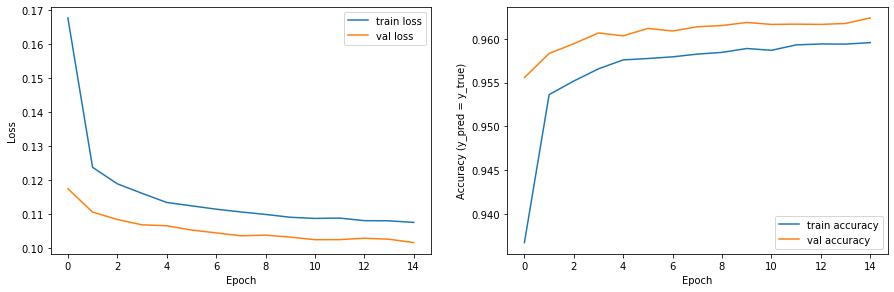

In [83]:
# plot loss vs epoch
plt.figure(figsize = (15,10))
axes = plt.subplot(2, 2, 1)
axes.plot(history.history['loss'], label = 'train loss')
axes.plot(history.history['val_loss'], label = 'val loss')
axes.legend(loc = "upper right")
axes.set_xlabel('Epoch')
axes.set_ylabel('Loss')

# plot accuracy vs epoch
axes = plt.subplot(2, 2, 2)
axes.plot(history.history['accuracy'], label = 'train accuracy')
axes.plot(history.history['val_accuracy'], label = 'val accuracy')
axes.legend(loc = "lower right")
axes.set_xlabel('Epoch')
axes.set_ylabel('Accuracy (y_pred = y_true)')

## Partition the test set into sig/bkg sets

In [84]:
# test set
test_sig_number = np.count_nonzero(Y_test)
test_bkg_number = np.count_nonzero(Y_test == 0)

X_test_sig = np.zeros((test_sig_number,X_test.shape[1]))
X_test_bkg = np.zeros((test_bkg_number,X_test.shape[1]))

j = 0
k = 0
for i in range(Y_test.shape[0]):
    if Y_test[i,0] == 1:
        X_test_sig[j,:] = X_test[i,:]
        j = j + 1
    else:
        X_test_bkg[k,:] = X_test[i,:]
        k = k + 1

# train+val set
train_val_sig_number = np.count_nonzero(Y_train_val)
train_val_bkg_number = np.count_nonzero(Y_train_val == 0)

X_train_val_sig = np.zeros((train_val_sig_number,X_train_val.shape[1]))
X_train_val_bkg = np.zeros((train_val_bkg_number,X_train_val.shape[1]))

j = 0
k = 0
for i in range(Y_train_val.shape[0]):
    if Y_train_val[i,0] == 1:
        X_train_val_sig[j,:] = X_train_val[i,:]
        j = j + 1
    else:
        X_train_val_bkg[k,:] = X_train_val[i,:]
        k = k + 1

## Test set performance plots

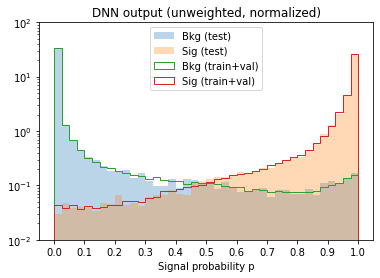

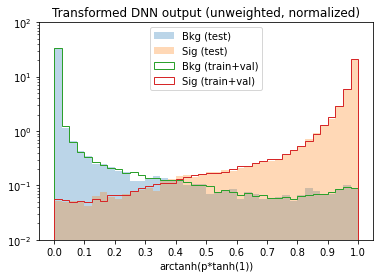

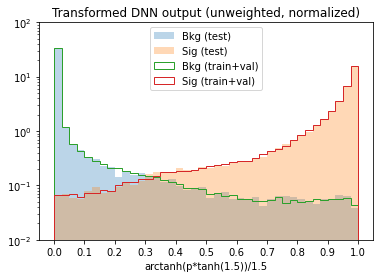

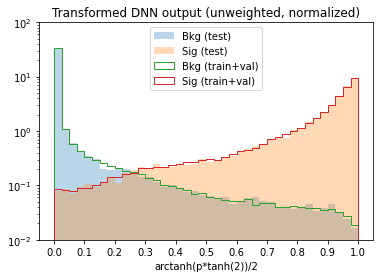

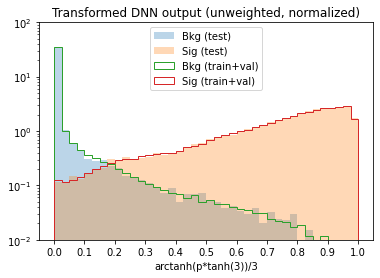

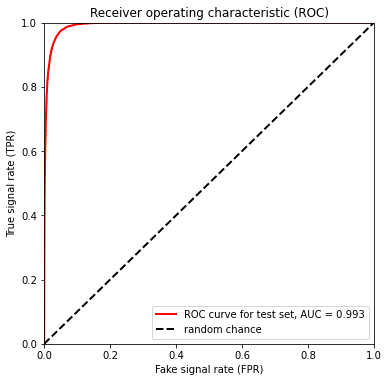

Test loss, test accuracy: [0.10166604525563103, 0.9618062973022461]


In [86]:
#pyplot.hist(model.predict(X_test_bkg), density = 1, range = (0.0, 1.0), bins = 40, alpha = 0.3, label = 'Bkg (test)')
pyplot.hist(model.predict(X_test_bkg), density = 1, range = (0.0, 1.0), bins = 40, alpha = 0.3, label = 'Bkg (test)', log = True)
pyplot.hist(model.predict(X_test_sig), density = 1, range = (0.0, 1.0), bins = 40, alpha = 0.3, label = 'Sig (test)')
pyplot.hist(model.predict(X_train_val_bkg), density = 1, range = (0.0, 1.0), bins = 40, label = 'Bkg (train+val)', histtype = 'step')
pyplot.hist(model.predict(X_train_val_sig), density = 1, range = (0.0, 1.0), bins = 40, label = 'Sig (train+val)', histtype = 'step')
pyplot.legend(loc = 'upper center')
pyplot.title('DNN output (unweighted, normalized)')
pyplot.xlabel('Signal probability p')
pyplot.xticks(np.arange(0, 1.1, step = 0.1))
pyplot.ylim(1e-2,1e2)
pyplot.show()

#pyplot.hist(np.arctanh(model.predict(X_test_bkg)*np.tanh(1)), density = 1, range = (0.0, 1), bins = 40, alpha = 0.3, label = 'Bkg (test)')
pyplot.hist(np.arctanh(model.predict(X_test_bkg)*np.tanh(1)), density = 1, range = (0.0, 1), bins = 40, alpha = 0.3, label = 'Bkg (test)', log = True)
pyplot.hist(np.arctanh(model.predict(X_test_sig)*np.tanh(1)), density = 1, range = (0.0, 1), bins = 40, alpha = 0.3, label = 'Sig (test)')
pyplot.hist(np.arctanh(model.predict(X_train_val_bkg)*np.tanh(1)), density = 1, range = (0.0, 1), bins = 40, label = 'Bkg (train+val)', histtype = 'step')
pyplot.hist(np.arctanh(model.predict(X_train_val_sig)*np.tanh(1)), density = 1, range = (0.0, 1), bins = 40, label = 'Sig (train+val)', histtype = 'step')
pyplot.legend(loc = 'upper center')
pyplot.title('Transformed DNN output (unweighted, normalized)')
pyplot.xlabel('arctanh(p*tanh(1))')
pyplot.xticks(np.arange(0, 1.1, step = 0.1))
pyplot.ylim(1e-2,1e2)
pyplot.show()

#pyplot.hist(np.arctanh(model.predict(X_test_bkg)*np.tanh(1.5))/1.5, density = 1, range = (0.0, 1), bins = 40, alpha = 0.3, label = 'Bkg (test)')
pyplot.hist(np.arctanh(model.predict(X_test_bkg)*np.tanh(1.5))/1.5, density = 1, range = (0.0, 1), bins = 40, alpha = 0.3, label = 'Bkg (test)', log = True)
pyplot.hist(np.arctanh(model.predict(X_test_sig)*np.tanh(1.5))/1.5, density = 1, range = (0.0, 1), bins = 40, alpha = 0.3, label = 'Sig (test)')
pyplot.hist(np.arctanh(model.predict(X_train_val_bkg)*np.tanh(1.5))/1.5, density = 1, range = (0.0, 1), bins = 40, label = 'Bkg (train+val)', histtype = 'step')
pyplot.hist(np.arctanh(model.predict(X_train_val_sig)*np.tanh(1.5))/1.5, density = 1, range = (0.0, 1), bins = 40, label = 'Sig (train+val)', histtype = 'step')
pyplot.legend(loc = 'upper center')
pyplot.title('Transformed DNN output (unweighted, normalized)')
pyplot.xlabel('arctanh(p*tanh(1.5))/1.5')
pyplot.xticks(np.arange(0, 1.1, step = 0.1))
pyplot.ylim(1e-2,1e2)
pyplot.show()

#pyplot.hist(np.arctanh(model.predict(X_test_bkg)*np.tanh(2))/2, density = 1, range = (0.0, 1), bins = 40, alpha = 0.3, label = 'Bkg (test)')
pyplot.hist(np.arctanh(model.predict(X_test_bkg)*np.tanh(2))/2, density = 1, range = (0.0, 1), bins = 40, alpha = 0.3, label = 'Bkg (test)', log = True)
pyplot.hist(np.arctanh(model.predict(X_test_sig)*np.tanh(2))/2, density = 1, range = (0.0, 1), bins = 40, alpha = 0.3, label = 'Sig (test)')
pyplot.hist(np.arctanh(model.predict(X_train_val_bkg)*np.tanh(2))/2, density = 1, range = (0.0, 1), bins = 40, label = 'Bkg (train+val)', histtype = 'step')
pyplot.hist(np.arctanh(model.predict(X_train_val_sig)*np.tanh(2))/2, density = 1, range = (0.0, 1), bins = 40, label = 'Sig (train+val)', histtype = 'step')
pyplot.legend(loc = 'upper center')
pyplot.title('Transformed DNN output (unweighted, normalized)')
pyplot.xlabel('arctanh(p*tanh(2))/2')
pyplot.xticks(np.arange(0, 1.1, step = 0.1))
pyplot.ylim(1e-2,1e2)
pyplot.show()

#pyplot.hist(np.arctanh(model.predict(X_test_bkg)*np.tanh(3))/3, density = 1, range = (0.0, 1), bins = 40, alpha = 0.3, label = 'Bkg (test)')
pyplot.hist(np.arctanh(model.predict(X_test_bkg)*np.tanh(3))/3, density = 1, range = (0.0, 1), bins = 40, alpha = 0.3, label = 'Bkg (test)', log = True)
pyplot.hist(np.arctanh(model.predict(X_test_sig)*np.tanh(3))/3, density = 1, range = (0.0, 1), bins = 40, alpha = 0.3, label = 'Sig (test)')
pyplot.hist(np.arctanh(model.predict(X_train_val_bkg)*np.tanh(3))/3, density = 1, range = (0.0, 1), bins = 40, label = 'Bkg (train+val)', histtype = 'step')
pyplot.hist(np.arctanh(model.predict(X_train_val_sig)*np.tanh(3))/3, density = 1, range = (0.0, 1), bins = 40, label = 'Sig (train+val)', histtype = 'step')
pyplot.legend(loc = 'upper center')
pyplot.title('Transformed DNN output (unweighted, normalized)')
pyplot.xlabel('arctanh(p*tanh(3))/3')
pyplot.xticks(np.arange(0, 1.1, step = 0.1))
pyplot.ylim(1e-2,1e2)
pyplot.show()

# Plot ROC
plt.figure(figsize = (13,13))
Y_predict = model.predict(X_test)
fpr, tpr, thresholds = roc_curve(Y_test, Y_predict)
roc_auc = auc(fpr, tpr)
axes = plt.subplot(2, 2, 1)
axes.plot(fpr, tpr, lw = 2, color = 'red', label = 'ROC curve for test set, AUC = %.3f' % (roc_auc))
axes.plot([0, 1], [0, 1], linestyle = '--', lw = 2, color = 'black', label = 'random chance')
axes.set_xlim([0, 1.0])
axes.set_ylim([0, 1.0])
axes.set_xlabel('Fake signal rate (FPR)')
axes.set_ylabel('True signal rate (TPR)')
axes.set_title('Receiver operating characteristic (ROC)')
axes.legend(loc = "lower right")
plt.show()

results = model.evaluate(X_test, Y_test, verbose = 0, batch_size = 256)
print("Test loss, test accuracy:", results)

## Save trained model

In [87]:
joblib.dump(scaler, 'trained_models_rerunBtag/mt1b_scaler.gz')
model.save('trained_models_rerunBtag/mt1b_model')

## Load saved model

In [ ]:
savedscaler = joblib.load('trained_models_rerunBtag/mt1b_scaler.gz')
savedmodel = keras.models.load_model('trained_models_rerunBtag/mt1b_model')
savedmodel.summary()

# Write model prediction to root files (NOW USE ANOTHER NOTEBOOK TO WRITE, THE BELOW CAN BE IGNORED)

## Load all root files one by one

In [ ]:
from root_numpy import array2root

########### 2018
infolder18 = 'root_raw/mt18_raw/'
outfolder18 = 'root_outputs/mt18_outputs/'

inpaths18 = ['DY.root', 'DY1.root', 'DY2.root', 'DY3.root', 'DY4.root'\
         , 'GGHTT.root', 'GGHWW.root', 'GGZHLLTT.root', 'GGZHNNTT.root'\
         , 'GGZHQQTT.root', 'GGZHWW.root', 'ST_tW_antitop.root'\
         , 'ST_tW_top.root', 'ST_t_antitop.root', 'ST_t_top.root'\
         , 'TTTo2L2Nu.root', 'TTToHadronic.root', 'TTToSemiLeptonic.root', 'VBFHTT.root', 'VBFHWW.root', 'VV2L2Nu.root'\
         , 'WZ2L2Q.root', 'WZ3LNu.root', 'WminusHTT.root', 'WminusHWW.root'\
         , 'WplusHTT.root', 'WplusHWW.root', 'ZHTT.root', 'ZHWW.root'\
         , 'ZZ2L2Q.root', 'ZZ4L.root', 'data_obs.root', 'embedded.root'\
         , 'ggH_bbtt12.root', 'ggH_bbtt20.root', 'ggH_bbtt30.root', 'ggH_bbtt40.root'\
         , 'ggH_bbtt50.root', 'ggH_bbtt60.root', 'ttHnonbb.root'\
         , 'vbf_bbtt12.root', 'vbf_bbtt20.root', 'vbf_bbtt30.root', 'vbf_bbtt40.root'\
         , 'vbf_bbtt50.root', 'vbf_bbtt60.root']

outpaths18 = ['DY.root', 'DY1.root', 'DY2.root', 'DY3.root', 'DY4.root'\
         , 'GGHTT.root', 'GGHWW.root', 'GGZHLLTT.root', 'GGZHNNTT.root'\
         , 'GGZHQQTT.root', 'GGZHWW.root', 'ST_tW_antitop.root'\
         , 'ST_tW_top.root', 'ST_t_antitop.root', 'ST_t_top.root'\
         , 'TTTo2L2Nu.root', 'TTToHadronic.root', 'TTToSemiLeptonic.root', 'VBFHTT.root', 'VBFHWW.root', 'VV2L2Nu.root'\
         , 'WZ2L2Q.root', 'WZ3LNu.root', 'WminusHTT.root', 'WminusHWW.root'\
         , 'WplusHTT.root', 'WplusHWW.root', 'ZHTT.root', 'ZHWW.root'\
         , 'ZZ2L2Q.root', 'ZZ4L.root', 'data_obs.root', 'embedded.root'\
         , 'gghbbtt12.root', 'gghbbtt20.root', 'gghbbtt30.root', 'gghbbtt40.root'\
         , 'gghbbtt50.root', 'gghbbtt60.root', 'ttHnonbb.root'\
         , 'vbfbbtt12.root', 'vbfbbtt20.root', 'vbfbbtt30.root', 'vbfbbtt40.root'\
         , 'vbfbbtt50.root', 'vbfbbtt60.root']

for i in range(len(inpaths18)):
    inpaths18[i] = infolder18 + inpaths18[i]
    outpaths18[i] = outfolder18 + outpaths18[i]

allfiles18 = []
for i in range(len(inpaths18)):
    allfiles18.append(ROOT.RDataFrame('mutau_tree', inpaths18[i]))


for i in range(len(allfiles18)):
    allfiles18[i] = allfiles18[i].Define('mymu', mymu)\
    .Define('mytau', mytau)\
    .Define('mymet', mymet)\
    .Define('mytt', mytt)\
    .Define('myb1', myb1)\
    .Define('m_btt', m_btt)\
    .Define('m_b1mu', m_b1mu)\
    .Define('m_b1tau', m_b1tau)\
    .Define('dR_tt', dR_tt)\
    .Define('dR_b1mu', dR_b1mu)\
    .Define('dR_b1tau', dR_b1tau)\
    .Define('dR_b1tt', dR_b1tt)\
    .Define('tt_pt', tt_pt)\
    .Define('tt_eta', tt_eta)\
    .Define('mT_mu', mT_mu)\
    .Define('mT_tau', mT_tau)\
    .Define('mT_b1', mT_b1)\
    .Define('norm_zeta', norm_zeta)\
    .Define('x_zeta', x_zeta)\
    .Define('y_zeta', y_zeta)\
    .Define('p_zeta_mis', p_zeta_mis)\
    .Define('pzeta_vis', pzeta_vis)\
    .Define('Dzeta', Dzeta)

########### 2017
infolder17 = 'root_raw/mt17_raw/'
outfolder17 = 'root_outputs/mt17_outputs/'

inpaths17 = ['DY.root', 'DY1.root', 'DY2.root', 'DY3.root', 'DY4.root'\
         , 'GGHTT.root', 'GGHWW.root', 'GGZHLLTT.root', 'GGZHNNTT.root'\
         , 'GGZHQQTT.root', 'GGZHWW.root', 'ST_tW_antitop.root'\
         , 'ST_tW_top.root', 'ST_t_antitop.root', 'ST_t_top.root'\
         , 'TTTo2L2Nu.root', 'TTToHadronic.root', 'TTToSemiLeptonic.root', 'VBFHTT.root', 'VBFHWW.root', 'VV2L2Nu.root'\
         , 'WZ2L2Q.root', 'WZ3L1Nu.root', 'WminusHTT.root', 'WminusHWW.root'\
         , 'WplusHTT.root', 'WplusHWW.root', 'ZHTT.root', 'ZHWW.root'\
         , 'ZZ2L2Q.root', 'ZZ4L.root', 'data_obs.root', 'embedded.root'\
         , 'ggH_bbtt12.root', 'ggH_bbtt20.root', 'ggH_bbtt30.root', 'ggH_bbtt40.root'\
         , 'ggH_bbtt50.root', 'ggH_bbtt60.root', 'ttHnonbb.root'\
         , 'vbf_bbtt12.root', 'vbf_bbtt20.root', 'vbf_bbtt30.root', 'vbf_bbtt40.root'\
         , 'vbf_bbtt50.root', 'vbf_bbtt60.root']

outpaths17 = ['DY.root', 'DY1.root', 'DY2.root', 'DY3.root', 'DY4.root'\
         , 'GGHTT.root', 'GGHWW.root', 'GGZHLLTT.root', 'GGZHNNTT.root'\
         , 'GGZHQQTT.root', 'GGZHWW.root', 'ST_tW_antitop.root'\
         , 'ST_tW_top.root', 'ST_t_antitop.root', 'ST_t_top.root'\
         , 'TTTo2L2Nu.root', 'TTToHadronic.root', 'TTToSemiLeptonic.root', 'VBFHTT.root', 'VBFHWW.root', 'VV2L2Nu.root'\
         , 'WZ2L2Q.root', 'WZ3L1Nu.root', 'WminusHTT.root', 'WminusHWW.root'\
         , 'WplusHTT.root', 'WplusHWW.root', 'ZHTT.root', 'ZHWW.root'\
         , 'ZZ2L2Q.root', 'ZZ4L.root', 'data_obs.root', 'embedded.root'\
         , 'gghbbtt12.root', 'gghbbtt20.root', 'gghbbtt30.root', 'gghbbtt40.root'\
         , 'gghbbtt50.root', 'gghbbtt60.root', 'ttHnonbb.root'\
         , 'vbfbbtt12.root', 'vbfbbtt20.root', 'vbfbbtt30.root', 'vbfbbtt40.root'\
         , 'vbfbbtt50.root', 'vbfbbtt60.root']

for i in range(len(inpaths17)):
    inpaths17[i] = infolder17 + inpaths17[i]
    outpaths17[i] = outfolder17 + outpaths17[i]

allfiles17 = []
for i in range(len(inpaths17)):
    allfiles17.append(ROOT.RDataFrame('mutau_tree', inpaths17[i]))


for i in range(len(allfiles17)):
    allfiles17[i] = allfiles17[i].Define('mymu', mymu)\
    .Define('mytau', mytau)\
    .Define('mymet', mymet)\
    .Define('mytt', mytt)\
    .Define('myb1', myb1)\
    .Define('m_btt', m_btt)\
    .Define('m_b1mu', m_b1mu)\
    .Define('m_b1tau', m_b1tau)\
    .Define('dR_tt', dR_tt)\
    .Define('dR_b1mu', dR_b1mu)\
    .Define('dR_b1tau', dR_b1tau)\
    .Define('dR_b1tt', dR_b1tt)\
    .Define('tt_pt', tt_pt)\
    .Define('tt_eta', tt_eta)\
    .Define('mT_mu', mT_mu)\
    .Define('mT_tau', mT_tau)\
    .Define('mT_b1', mT_b1)\
    .Define('norm_zeta', norm_zeta)\
    .Define('x_zeta', x_zeta)\
    .Define('y_zeta', y_zeta)\
    .Define('p_zeta_mis', p_zeta_mis)\
    .Define('pzeta_vis', pzeta_vis)\
    .Define('Dzeta', Dzeta)

########### 2016
infolder16 = 'root_raw/mt16_raw/'
outfolder16 = 'root_outputs/mt16_outputs/'

inpaths16 = ['DY.root', 'DY1.root', 'DY2.root', 'DY3.root', 'DY4.root'\
         , 'GGHTT.root', 'GGHWW.root', 'GGZHLLTT.root', 'GGZHNNTT.root'\
         , 'GGZHQQTT.root', 'GGZHWW.root', 'ST_tW_antitop.root'\
         , 'ST_tW_top.root', 'ST_t_antitop.root', 'ST_t_top.root'\
         , 'TT.root', 'VBFHTT.root', 'VBFHWW.root', 'VV2L2Nu.root'\
         , 'WZ2L2Q.root', 'WZ3L1Nu.root', 'WminusHTT.root', 'WminusHWW.root'\
         , 'WplusHTT.root', 'WplusHWW.root', 'ZHTT.root', 'ZHWW.root'\
         , 'ZZ2L2Q.root', 'ZZ4L.root', 'data_obs.root', 'embedded.root'\
         , 'ggH_bbtt15.root', 'ggH_bbtt20.root', 'ggH_bbtt25.root', 'ggH_bbtt30.root', 'ggH_bbtt35.root', 'ggH_bbtt40.root'\
         , 'ggH_bbtt45.root', 'ggH_bbtt50.root', 'ggH_bbtt55.root', 'ggH_bbtt60.root', 'ttHnonbb.root'\
         , 'vbf_bbtt15.root', 'vbf_bbtt20.root', 'vbf_bbtt25.root', 'vbf_bbtt30.root', 'vbf_bbtt35.root', 'vbf_bbtt40.root'\
         , 'vbf_bbtt45.root', 'vbf_bbtt50.root', 'vbf_bbtt55.root', 'vbf_bbtt60.root']

outpaths16 = ['DY.root', 'DY1.root', 'DY2.root', 'DY3.root', 'DY4.root'\
         , 'GGHTT.root', 'GGHWW.root', 'GGZHLLTT.root', 'GGZHNNTT.root'\
         , 'GGZHQQTT.root', 'GGZHWW.root', 'ST_tW_antitop.root'\
         , 'ST_tW_top.root', 'ST_t_antitop.root', 'ST_t_top.root'\
         , 'TT.root', 'VBFHTT.root', 'VBFHWW.root', 'VV2L2Nu.root'\
         , 'WZ2L2Q.root', 'WZ3L1Nu.root', 'WminusHTT.root', 'WminusHWW.root'\
         , 'WplusHTT.root', 'WplusHWW.root', 'ZHTT.root', 'ZHWW.root'\
         , 'ZZ2L2Q.root', 'ZZ4L.root', 'data_obs.root', 'embedded.root'\
         , 'gghbbtt15.root', 'gghbbtt20.root', 'gghbbtt25.root', 'gghbbtt30.root', 'gghbbtt35.root', 'gghbbtt40.root'\
         , 'gghbbtt45.root', 'gghbbtt50.root', 'gghbbtt55.root', 'gghbbtt60.root', 'ttHnonbb.root'\
         , 'vbfbbtt15.root', 'vbfbbtt20.root', 'vbfbbtt25.root', 'vbfbbtt30.root', 'vbfbbtt35.root', 'vbfbbtt40.root'\
         , 'vbfbbtt45.root', 'vbfbbtt50.root', 'vbfbbtt55.root', 'vbfbbtt60.root']

for i in range(len(inpaths16)):
    inpaths16[i] = infolder16 + inpaths16[i]
    outpaths16[i] = outfolder16 + outpaths16[i]

allfiles16 = []
for i in range(len(inpaths16)):
    allfiles16.append(ROOT.RDataFrame('mutau_tree', inpaths16[i]))


for i in range(len(allfiles16)):
    allfiles16[i] = allfiles16[i].Define('mymu', mymu)\
    .Define('mytau', mytau)\
    .Define('mymet', mymet)\
    .Define('mytt', mytt)\
    .Define('myb1', myb1)\
    .Define('m_btt', m_btt)\
    .Define('m_b1mu', m_b1mu)\
    .Define('m_b1tau', m_b1tau)\
    .Define('dR_tt', dR_tt)\
    .Define('dR_b1mu', dR_b1mu)\
    .Define('dR_b1tau', dR_b1tau)\
    .Define('dR_b1tt', dR_b1tt)\
    .Define('tt_pt', tt_pt)\
    .Define('tt_eta', tt_eta)\
    .Define('mT_mu', mT_mu)\
    .Define('mT_tau', mT_tau)\
    .Define('mT_b1', mT_b1)\
    .Define('norm_zeta', norm_zeta)\
    .Define('x_zeta', x_zeta)\
    .Define('y_zeta', y_zeta)\
    .Define('p_zeta_mis', p_zeta_mis)\
    .Define('pzeta_vis', pzeta_vis)\
    .Define('Dzeta', Dzeta)

## Data pre-processing

In [ ]:
######### 2018
for i in range(len(allfiles18)):
    allfiles18[i] = pd.DataFrame(allfiles18[i].AsNumpy(feature_list))
    allfiles18[i] = allfiles18[i].values
    allfiles18[i] = scaler.transform(allfiles18[i])
    print(inpaths18[i])

In [ ]:
######### 2017
for i in range(len(allfiles17)):
    allfiles17[i] = pd.DataFrame(allfiles17[i].AsNumpy(feature_list))
    allfiles17[i] = allfiles17[i].values
    allfiles17[i] = scaler.transform(allfiles17[i])
    print(inpaths17[i])

In [ ]:
######### 2016
for i in range(len(allfiles16)):
    allfiles16[i] = pd.DataFrame(allfiles16[i].AsNumpy(feature_list))
    allfiles16[i] = allfiles16[i].values
    allfiles16[i] = scaler.transform(allfiles16[i])
    print(inpaths16[i])

## Feed to NN and write outputs to root files

In [ ]:
######### 2018
for i in range(len(allfiles18)):
    y_pred = model.predict(allfiles18[i])
    y_pred = np.array(y_pred, dtype = [('dnn_1b', np.float32)])
    array2root(y_pred, filename = outpaths18[i], treename = 'mutau_tree_dnn', mode = 'update')
    print(outpaths18[i])

In [ ]:
######### 2017
for i in range(len(allfiles17)):
    y_pred = model.predict(allfiles17[i])
    y_pred = np.array(y_pred, dtype = [('dnn_1b', np.float32)])
    array2root(y_pred, filename = outpaths17[i], treename = 'mutau_tree_dnn', mode = 'update')
    print(outpaths17[i])

In [ ]:
######### 2016
for i in range(len(allfiles16)):
    y_pred = model.predict(allfiles16[i])
    y_pred = np.array(y_pred, dtype = [('dnn_1b', np.float32)])
    array2root(y_pred, filename = outpaths16[i], treename = 'mutau_tree_dnn', mode = 'update')
    print(outpaths16[i])